In [2]:
# !pip install pandas==2.1.1
# !pip install scorecardpy==0.1.9.7

# Data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Scorecard libraries 
import scorecardpy as sc
import pprint

import warnings
warnings.filterwarnings("ignore")

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score

# Load Data

In [4]:
# Merged Dataset
merged_df_copy = pd.read_csv( "merged_application_bureau.csv" )


In [5]:
# Retain only rows where CAR_LOAN_TAKEN is True
merged_df_copy = merged_df_copy[merged_df_copy['CAR_LOAN_TAKEN'] == True]
print(f"Number of columns in the dataframe: {len(merged_df_copy.columns)}")
characteristics = list(merged_df_copy.columns)

print(merged_df_copy.shape)

Number of columns in the dataframe: 102
(12168, 102)


# WOE IV

In [6]:
def woe_iv(data, variable_name):
    working_data = data.copy()

    # missing values have been assigned NaN when binning with pd.qcut
    # rename this bin as 'Missing' to consider into WOE calculation
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace = True)

    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']

    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']

    variable_data['Events'] =working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']

    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']

    variable_data['%_of_Events'] = variable_data['Events']/sum(variable_data['Events'])

    variable_data['%_of_Non_Events'] = variable_data['Non_Events']/sum(variable_data['Non_Events'])
    variable_data

    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])

    variable_data['IV'] = (variable_data['%_of_Non_Events']-variable_data['%_of_Events']) * variable_data['WOE']

    IV = sum(variable_data['IV'])
    return(IV, variable_data)

# create IV calc and WOE plotting function
def woe_iv_plot(data, variable_name):
    IV, variable_data = woe_iv(data, variable_name)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'bins:', round(IV,4))
    ffig, ax1 = plt.subplots(figsize=(20,6))
    sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # add WOE values to the plot. i is x axis, v is y axis
    for i, v in enumerate(variable_data['WOE']):
        plt.text(i, v, str(round(v, 2)), color='blue', fontweight='bold')

    # Create the scatter plot to plot the Missing WOE data point
    last_point = len(variable_data['WOE']) - 1
    scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    ax2 = ax1.twinx()

    # plot the bin counts
    sns.barplot(x = variable_data['Bin_Range'] , y = variable_data['Count'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    plt.title("WOE plot for " + variable_name)


    plt.show()

In [7]:
# Create a copy
data_df = merged_df_copy.copy()

## WOE Calculation

In [9]:
# sort variables into numerical and categorical
# for df_app, df_bureau, df_dict
for df_name in ['data_df']:
    df = vars()[df_name]
    vars()[f'numerical_{df_name}'] = df.select_dtypes(include=[np.number]).columns.tolist()
    vars()[f'categorical_{df_name}'] = df.select_dtypes(include=[object]).columns.tolist()
    print(f'numerical_{df_name}: {vars()[f"numerical_{df_name}"]}')
    print(f'categorical_{df_name}: {vars()[f"categorical_{df_name}"]}')
    print()


numerical_data_df: ['SK_ID_CURR', 'TARGET', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT

In [10]:
dataframe = merged_df_copy.copy()
dataframe.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       ...
       'AMT_CREDIT_SUM_ACTIVE_TOTAL', 'AMT_CREDIT_SUM_DEBT_SOLD_TOTAL',
       'AMT_CREDIT_SUM_LIMIT_MEAN', 'AMT_CREDIT_SUM_OVERDUE_TOTAL',
       'CREDIT_TYPE_UNIQUE_COUNT', 'CAR_LOAN_TAKEN', 'DAYS_CREDIT_UPDATE_MIN',
       'AMT_ANNUITY_SOLD_TOTAL', 'DEBT_TO_INCOME_RATIO', 'TOTAL_ANNUITY'],
      dtype='object', length=102)

Mapping for NAME_CONTRACT_TYPE:
Cash loans: 0
Revolving loans: 1
Information Value: 0.01569811105127352


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0         0  11226     682       10544     0.951185         0.920793   
1         1    942      35         907     0.048815         0.079207   

        WOE        IV  
0 -0.032474  0.000987  
1  0.484038  0.014711

IV for NAME_CONTRACT_TYPE_num with 2 bins: 0.0157


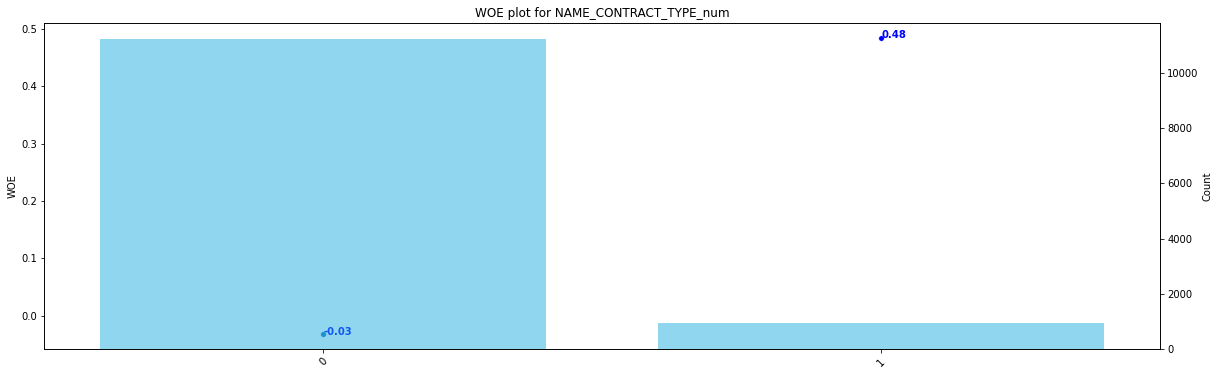

Mapping for FLAG_OWN_CAR:
Y: 1
N: 0
Information Value: 0.00792418610832872


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0         0   2432     168        2264      0.23431         0.197712   
1         1   9736     549        9187      0.76569         0.802288   

        WOE        IV  
0 -0.169832  0.006215  
1  0.046690  0.001709

IV for FLAG_OWN_CAR_num with 2 bins: 0.0079


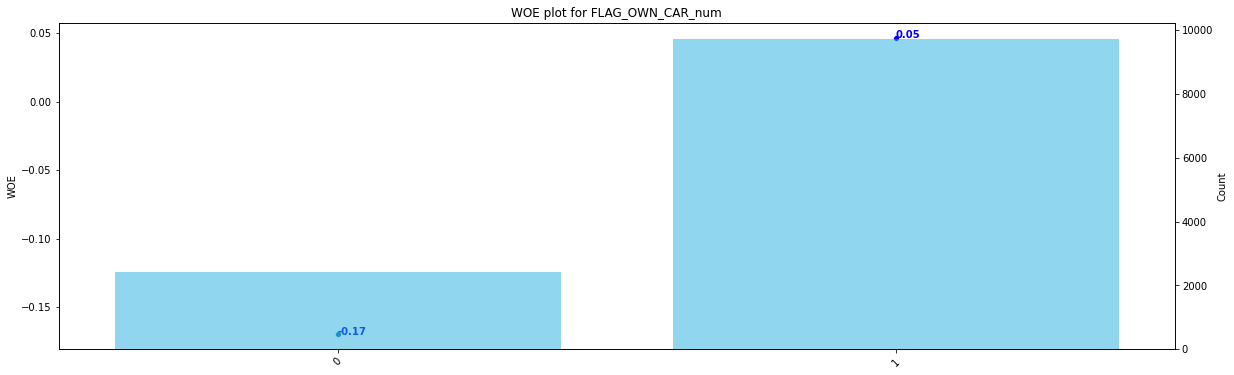

Mapping for FLAG_OWN_REALTY:
N: 0
Y: 1
Information Value: 0.011166805273401453


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0         0   4003     203        3800     0.283124         0.331849   
1         1   8165     514        7651     0.716876         0.668151   

        WOE        IV  
0  0.158794  0.007737  
1 -0.070388  0.003430

IV for FLAG_OWN_REALTY_num with 2 bins: 0.0112


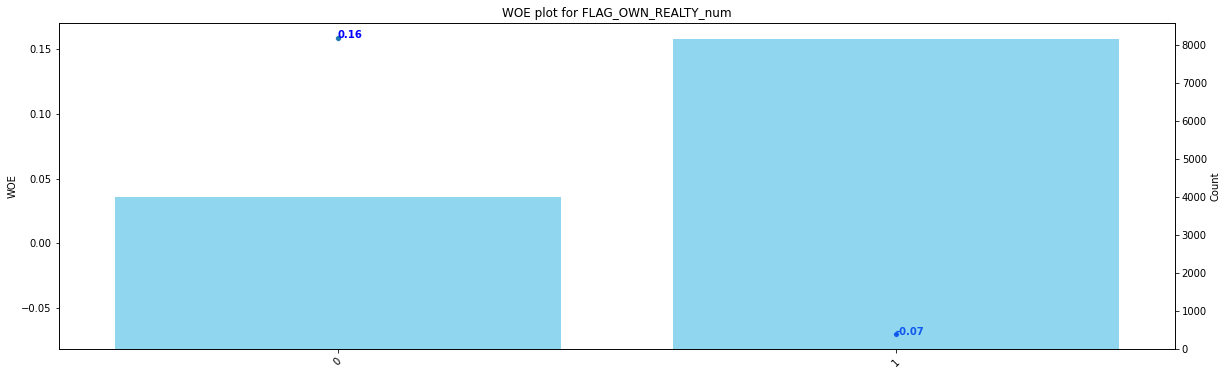

Mapping for NAME_TYPE_SUITE:
Unaccompanied: 6
nan: -1
Family: 1
Spouse, partner: 5
Children: 0
Other_B: 4
Other_A: 3
Group of people: 2
Information Value: 0.013305465259880671


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0        -1     76       1          75     0.001395         0.006550   
1         0     82       7          75     0.009763         0.006550   
2         1   1509      94        1415     0.131102         0.123570   
3         2     12       2          10     0.002789         0.000873   
4         3     24       1          23     0.001395         0.002009   
5         4     34       3          31     0.004184         0.002707   
6         5    491      26         465     0.036262         0.040608   
7         6   9940     583        9357     0.813110         0.817134   

        WOE        IV  
0  1.546732  0.007973  
1 -0.399179  0.001283  
2 -0.059166  0.000446  
3 -1.161319  0.002225  
4  0.364738  0.000224  
5 -0.435382  0.000643  
6  0.113184  0.000492  
7  0.004936  0.000020

IV for NAME_TYPE_SUITE_num with 8 bins: 0.0133


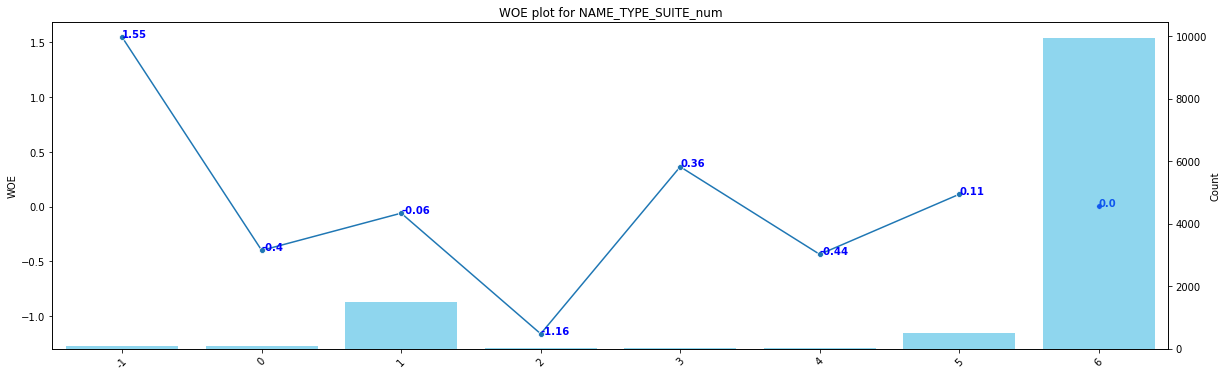

Mapping for NAME_INCOME_TYPE:
Commercial associate: 0
State servant: 2
Working: 3
Pensioner: 1
Information Value: 0.019739179346074862


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0         0   4274     252        4022     0.351464         0.351236   
1         1    811      35         776     0.048815         0.067767   
2         2    855      34         821     0.047420         0.071697   
3         3   6228     396        5832     0.552301         0.509300   

        WOE            IV  
0 -0.000651  1.489107e-07  
1  0.328048  6.217330e-03  
2  0.413406  1.003626e-02  
3 -0.081055  3.485445e-03

IV for NAME_INCOME_TYPE_num with 4 bins: 0.0197


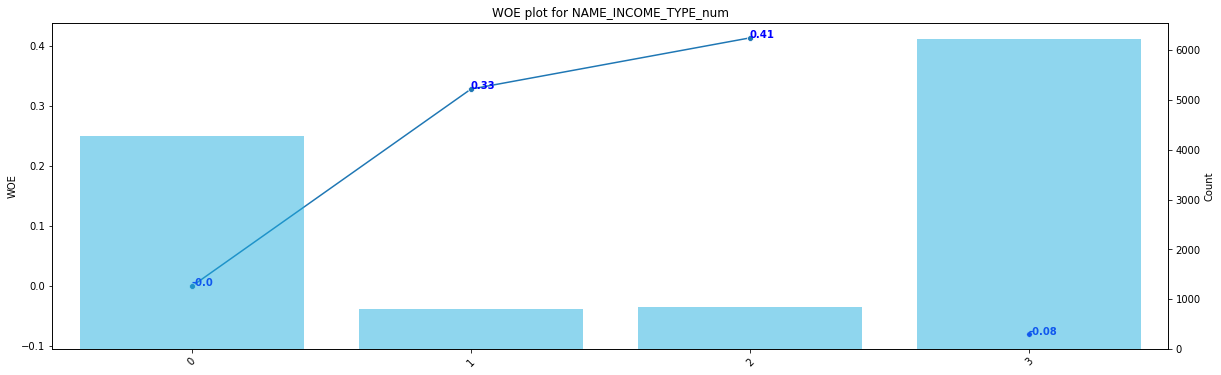

Mapping for NAME_EDUCATION_TYPE:
Secondary / secondary special: 4
Higher education: 1
Incomplete higher: 2
Lower secondary: 3
Academic degree: 0
Information Value: inf


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0         0     15       0          15     0.000000         0.001310   
1         1   4812     217        4595     0.302650         0.401275   
2         2    399      27         372     0.037657         0.032486   
3         3     59       4          55     0.005579         0.004803   
4         4   6883     469        6414     0.654114         0.560126   

        WOE        IV  
0       inf       inf  
1  0.282070  0.027819  
2 -0.147700  0.000764  
3 -0.149718  0.000116  
4 -0.155121  0.014580

IV for NAME_EDUCATION_TYPE_num with 5 bins: inf


posx and posy should be finite values
posx and posy should be finite values


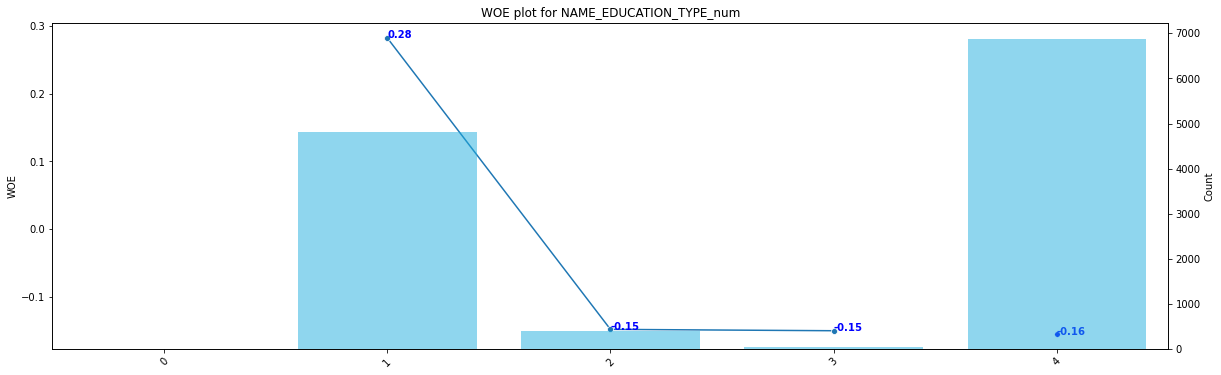

Mapping for NAME_FAMILY_STATUS:
Married: 1
Civil marriage: 0
Single / not married: 3
Separated: 2
Widow: 4
Information Value: 0.001891833674559928


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0         0    878      58         820     0.080893         0.071609   
1         1   9301     539        8762     0.751743         0.765173   
2         2    637      41         596     0.057183         0.052048   
3         3   1171      68        1103     0.094840         0.096323   
4         4    181      11         170     0.015342         0.014846   

        WOE        IV  
0 -0.121895  0.001132  
1  0.017707  0.000238  
2 -0.094088  0.000483  
3  0.015525  0.000023  
4 -0.032853  0.000016

IV for NAME_FAMILY_STATUS_num with 5 bins: 0.0019


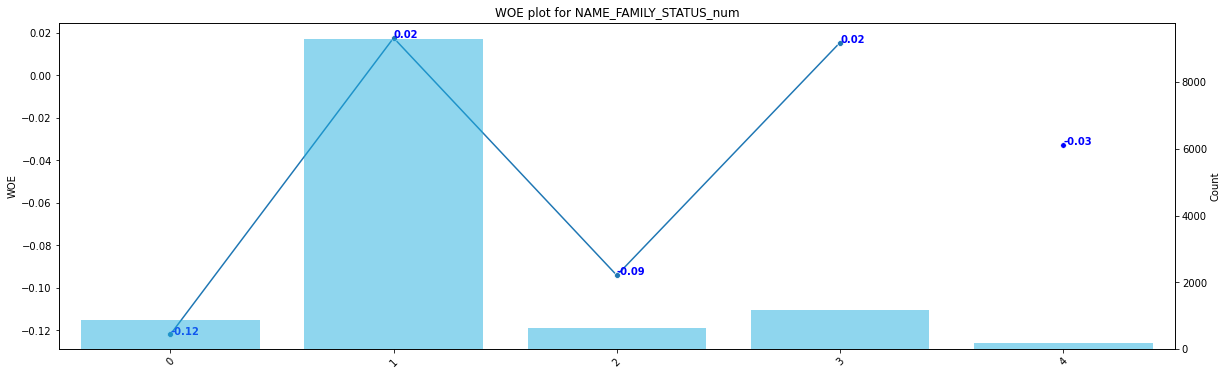

Mapping for NAME_HOUSING_TYPE:
House / apartment: 1
With parents: 5
Municipal apartment: 2
Office apartment: 3
Rented apartment: 4
Co-op apartment: 0
Information Value: 0.007103429765888373


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0         0     37       3          34     0.004184         0.002969   
1         1  11055     647       10408     0.902371         0.908916   
2         2    345      19         326     0.026499         0.028469   
3         3    129       4         125     0.005579         0.010916   
4         4    122       9         113     0.012552         0.009868   
5         5    480      35         445     0.048815         0.038861   

        WOE        IV  
0 -0.343008  0.000417  
1  0.007227  0.000047  
2  0.071702  0.000141  
3  0.671263  0.003583  
4 -0.240593  0.000646  
5 -0.228030  0.002270

IV for NAME_HOUSING_TYPE_num with 6 bins: 0.0071


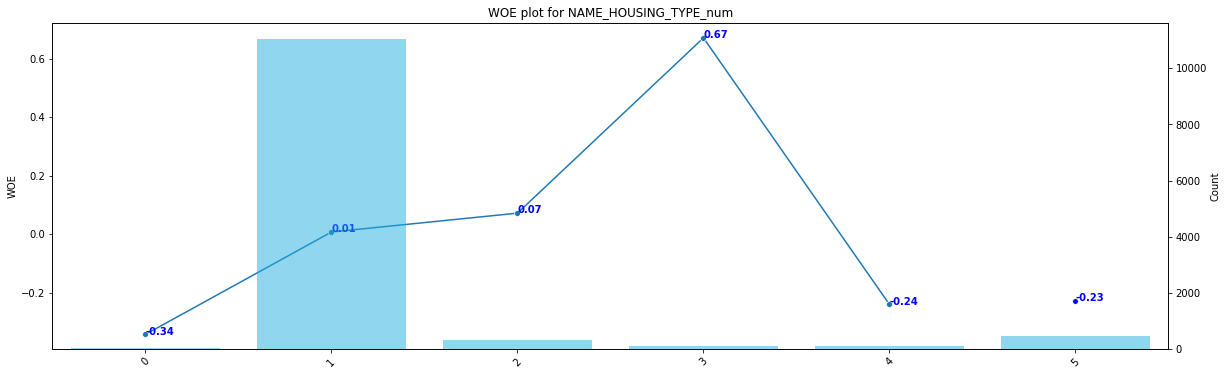

Information Value: 0.08170257048798515


Bin_Range  Count  Events  Non_Events  \
0   (-0.00046699999999999997, 0.00623]    636      49         587   
1                   (0.00623, 0.00733]    647      45         602   
2                   (0.00733, 0.00918]    573      29         544   
3                    (0.00918, 0.0101]    673      36         637   
4                      (0.0101, 0.011]    552      26         526   
5                      (0.011, 0.0152]    707      38         669   
6                     (0.0152, 0.0186]    635      53         582   
7                     (0.0186, 0.0191]    636      32         604   
8                     (0.0191, 0.0202]    425      36         389   
9                     (0.0202, 0.0228]    775      56         719   
10                    (0.0228, 0.0252]    852      67         785   
11                    (0.0252, 0.0264]    926      55         871   
12                    (0.0264, 0.0287]    627      34         593   
13                    (0.0287, 0.0313]    907      59         848   
14                    (0.0313, 0.0326]    488      17         471   
15                    (0.0326, 0.0358]    712      38         674   
16                    (0.0358, 0.0462]    797      29         768   
17                    (0.0462, 0.0725]    600      18         582   

    %_of_Events  %_of_Non_Events       WOE        IV  
0      0.068340         0.051262 -0.287552  0.004911  
1      0.062762         0.052572 -0.177162  0.001805  
2      0.040446         0.047507  0.160897  0.001136  
3      0.050209         0.055628  0.102494  0.000555  
4      0.036262         0.045935  0.236448  0.002287  
5      0.052999         0.058423  0.097441  0.000529  
6      0.073919         0.050825 -0.374578  0.008650  
7      0.044630         0.052746  0.167082  0.001356  
8      0.050209         0.033971 -0.390696  0.006344  
9      0.078103         0.062789 -0.218247  0.003342  
10     0.093445         0.068553 -0.309765  0.007711  
11     0.076709         0.076063 -0.008448  0.000005  
12     0.047420         0.051786  0.088077  0.000385  
13     0.082287         0.074055 -0.105413  0.000868  
14     0.023710         0.041132  0.550888  0.009598  
15     0.052999         0.058859  0.104887  0.000615  
16     0.040446         0.067068  0.505737  0.013464  
17     0.025105         0.050825  0.705342  0.018142

IV for REGION_POPULATION_RELATIVE_num with 18 bins: 0.0817


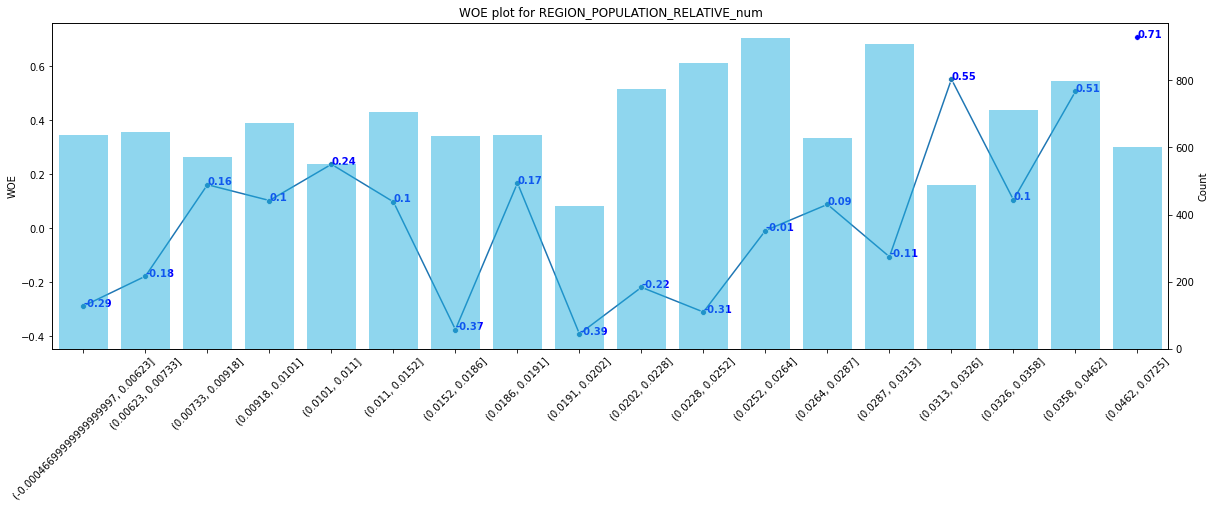

Information Value: 0.05341925007733129


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0   (-24969.0, -21748.0]    609      22         587     0.030683   
1   (-21748.0, -20667.0]    608      35         573     0.048815   
2   (-20667.0, -19833.0]    610      38         572     0.052999   
3   (-19833.0, -19065.0]    608      38         570     0.052999   
4   (-19065.0, -18282.0]    607      36         571     0.050209   
5   (-18282.0, -17560.0]    609      23         586     0.032078   
6   (-17560.0, -16919.0]    608      39         569     0.054393   
7   (-16919.0, -16325.0]    609      30         579     0.041841   
8   (-16325.0, -15806.0]    608      29         579     0.040446   
9   (-15806.0, -15290.0]    608      27         581     0.037657   
10  (-15290.0, -14790.0]    608      42         566     0.058577   
11  (-14790.0, -14301.0]    610      39         571     0.054393   
12  (-14301.0, -13821.0]    607      25         582     0.034868   
13  (-13821.0, -13309.0]    608      44         564     0.061367   
14  (-13309.0, -12768.0]    609      51         558     0.071130   
15  (-12768.0, -12199.0]    608      42         566     0.058577   
16  (-12199.0, -11620.0]    609      37         572     0.051604   
17  (-11620.0, -11023.0]    608      45         563     0.062762   
18  (-11023.0, -10238.0]    609      34         575     0.047420   
19   (-10238.0, -7760.0]    608      41         567     0.057183   

    %_of_Non_Events       WOE        IV  
0          0.051262  0.513226  0.010561  
1          0.050039  0.024781  0.000030  
2          0.049952 -0.059204  0.000180  
3          0.049777 -0.062706  0.000202  
4          0.049865 -0.006886  0.000002  
5          0.051175  0.467069  0.008919  
6          0.049690 -0.090438  0.000425  
7          0.050563  0.189349  0.001652  
8          0.050563  0.223250  0.002259  
9          0.050738  0.298157  0.003900  
10         0.049428 -0.169832  0.001554  
11         0.049865 -0.086929  0.000394  
12         0.050825  0.376838  0.006013  
13         0.049253 -0.219892  0.002664  
14         0.048729 -0.378223  0.008472  
15         0.049428 -0.169832  0.001554  
16         0.049952 -0.032535  0.000054  
17         0.049166 -0.244139  0.003319  
18         0.050214  0.057253  0.000160  
19         0.049515 -0.143969  0.001104

IV for DAYS_BIRTH_num with 20 bins: 0.0534


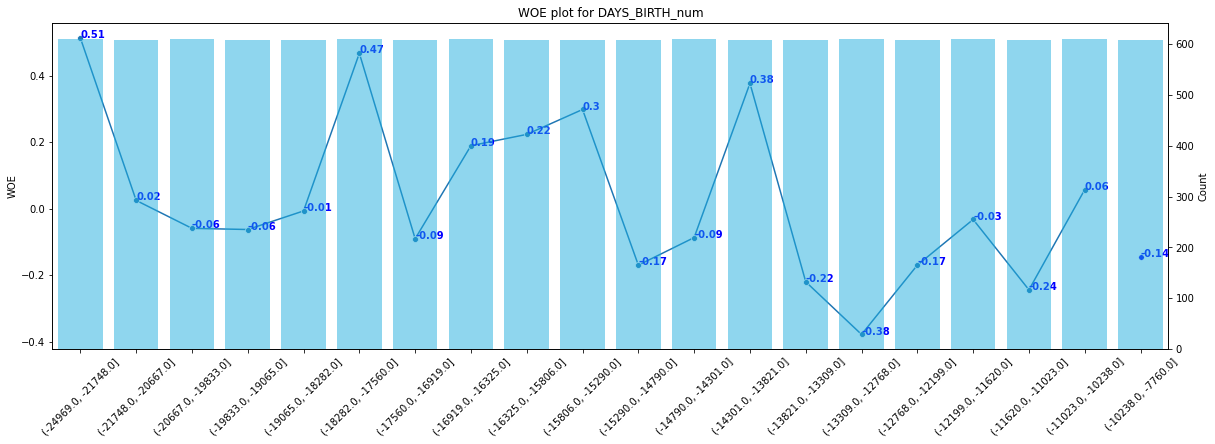

Information Value: 0.10859538015303219


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0   (-14989.0, -6733.0]    609      13         596     0.018131   
1    (-6733.0, -5158.0]    610      19         591     0.026499   
2    (-5158.0, -4334.0]    607      23         584     0.032078   
3    (-4334.0, -3749.0]    608      25         583     0.034868   
4    (-3749.0, -3276.0]    608      33         575     0.046025   
5    (-3276.0, -2923.0]    610      32         578     0.044630   
6    (-2923.0, -2606.0]    612      38         574     0.052999   
7    (-2606.0, -2316.0]    604      26         578     0.036262   
8    (-2316.0, -2027.0]    608      38         570     0.052999   
9    (-2027.0, -1758.0]    608      35         573     0.048815   
10   (-1758.0, -1519.0]    608      51         557     0.071130   
11   (-1519.0, -1299.0]    610      37         573     0.051604   
12   (-1299.0, -1103.0]    608      46         562     0.064156   
13    (-1103.0, -906.0]    610      44         566     0.061367   
14     (-906.0, -731.0]    607      52         555     0.072524   
15     (-731.0, -538.0]    610      41         569     0.057183   
16     (-538.0, -354.0]    607      49         558     0.068340   
17     (-354.0, -193.0]    613      44         569     0.061367   
18   (-193.0, 365243.0]   1211      71        1140     0.099024   

    %_of_Non_Events       WOE        IV  
0          0.052048  1.054535  0.035766  
1          0.051611  0.666621  0.016740  
2          0.051000  0.463650  0.008773  
3          0.050913  0.378555  0.006074  
4          0.050214  0.087106  0.000365  
5          0.050476  0.123081  0.000719  
6          0.050127 -0.055713  0.000160  
7          0.050476  0.330721  0.004701  
8          0.049777 -0.062706  0.000202  
9          0.050039  0.024781  0.000030  
10         0.048642 -0.380017  0.008546  
11         0.050039 -0.030789  0.000048  
12         0.049079 -0.267896  0.004039  
13         0.049428 -0.216352  0.002583  
14         0.048467 -0.403032  0.009696  
15         0.049690 -0.140448  0.001052  
16         0.048729 -0.338218  0.006633  
17         0.049690 -0.211066  0.002465  
18         0.099555  0.005347  0.000003

IV for DAYS_EMPLOYED_num with 19 bins: 0.1086


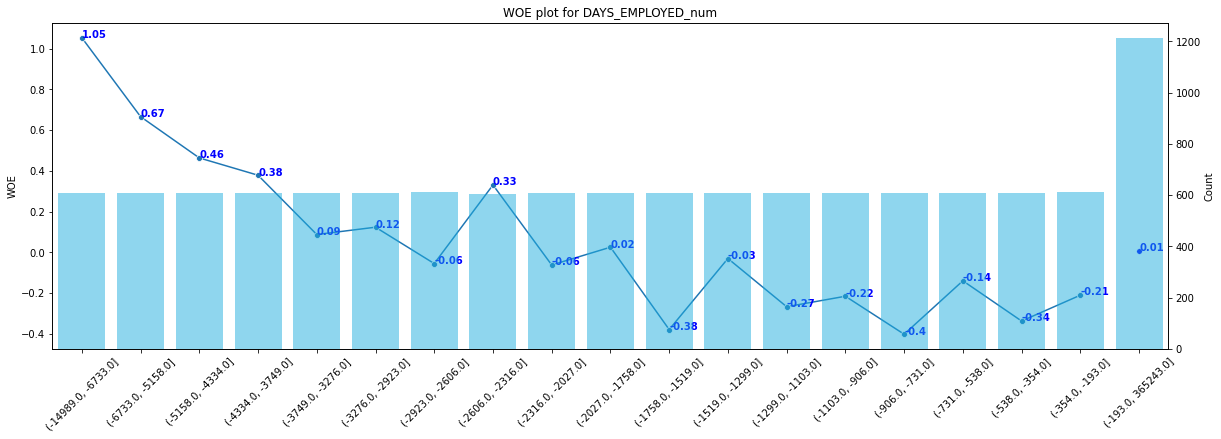

Information Value: 0.035092165222935054


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0   (-22859.0, -10429.0]    609      32         577     0.044630   
1    (-10429.0, -9173.0]    608      30         578     0.041841   
2     (-9173.0, -8328.0]    609      27         582     0.037657   
3     (-8328.0, -7548.0]    608      30         578     0.041841   
4     (-7548.0, -6822.0]    609      23         586     0.032078   
5     (-6822.0, -6174.0]    608      32         576     0.044630   
6     (-6174.0, -5614.0]    608      44         564     0.061367   
7     (-5614.0, -5062.0]    611      30         581     0.041841   
8     (-5062.0, -4604.0]    606      37         569     0.051604   
9     (-4604.0, -4164.0]    608      38         570     0.052999   
10    (-4164.0, -3638.0]    608      32         576     0.044630   
11    (-3638.0, -3136.0]    611      40         571     0.055788   
12    (-3136.0, -2679.0]    606      37         569     0.051604   
13    (-2679.0, -2177.0]    608      39         569     0.054393   
14    (-2177.0, -1685.0]    609      37         572     0.051604   
15    (-1685.0, -1260.0]    609      36         573     0.050209   
16     (-1260.0, -919.0]    607      50         557     0.069735   
17      (-919.0, -598.0]    611      40         571     0.055788   
18      (-598.0, -273.0]    610      43         567     0.059972   
19         (-273.0, 0.0]    605      40         565     0.055788   

    %_of_Non_Events       WOE            IV  
0          0.050389  0.121350  6.987577e-04  
1          0.050476  0.187620  1.620087e-03  
2          0.050825  0.299877  3.948887e-03  
3          0.050476  0.187620  1.620087e-03  
4          0.051175  0.467069  8.919369e-03  
5          0.050301  0.119615  6.783237e-04  
6          0.049253 -0.219892  2.663653e-03  
7          0.050738  0.192797  1.715299e-03  
8          0.049690 -0.037794  7.233472e-05  
9          0.049777 -0.062706  2.019954e-04  
10         0.050301  0.119615  6.783237e-04  
11         0.049865 -0.112247  6.648784e-04  
12         0.049690 -0.037794  7.233472e-05  
13         0.049690 -0.090438  4.253577e-04  
14         0.049952 -0.032535  5.374643e-05  
15         0.050039 -0.003390  5.759381e-07  
16         0.048642 -0.360214  7.597988e-03  
17         0.049865 -0.112247  6.648784e-04  
18         0.049515 -0.191597  2.003491e-03  
19         0.049341 -0.122810  7.917989e-04

IV for DAYS_REGISTRATION_num with 20 bins: 0.0351


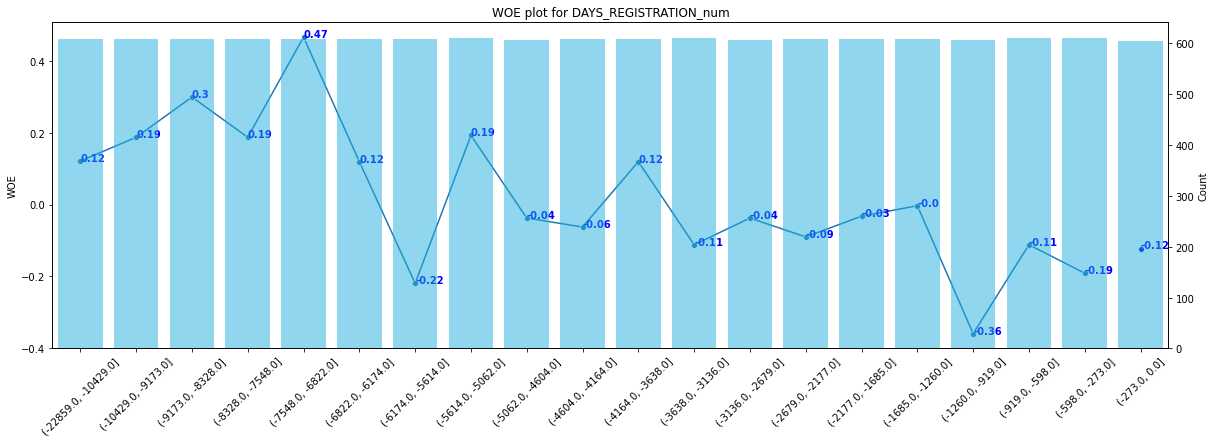

Information Value: 0.030681724470914558


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0   (-6552.0, -4946.0]    609      32         577     0.044630   
1   (-4946.0, -4731.0]    611      32         579     0.044630   
2   (-4731.0, -4580.0]    609      31         578     0.043236   
3   (-4580.0, -4446.0]    608      27         581     0.037657   
4   (-4446.0, -4326.0]    611      38         573     0.052999   
5   (-4326.0, -4215.0]    603      39         564     0.054393   
6   (-4215.0, -4091.0]    609      30         579     0.041841   
7   (-4091.0, -3926.0]    607      36         571     0.050209   
8   (-3926.0, -3632.0]    609      34         575     0.047420   
9   (-3632.0, -3382.0]    608      32         576     0.044630   
10  (-3382.0, -3087.0]    610      47         563     0.065551   
11  (-3087.0, -2805.0]    608      41         567     0.057183   
12  (-2805.0, -2498.0]    607      32         575     0.044630   
13  (-2498.0, -2166.0]    611      35         576     0.048815   
14  (-2166.0, -1830.0]    610      43         567     0.059972   
15  (-1830.0, -1464.0]    605      33         572     0.046025   
16  (-1464.0, -1095.0]    608      29         579     0.040446   
17   (-1095.0, -749.0]    611      38         573     0.052999   
18    (-749.0, -359.0]    606      52         554     0.072524   
19       (-359.0, 0.0]    608      36         572     0.050209   

    %_of_Non_Events       WOE        IV  
0          0.050389  0.121350  0.000699  
1          0.050563  0.124810  0.000740  
2          0.050476  0.154830  0.001121  
3          0.050738  0.298157  0.003900  
4          0.050039 -0.057457  0.000170  
5          0.049253 -0.099264  0.000510  
6          0.050563  0.189349  0.001652  
7          0.049865 -0.006886  0.000002  
8          0.050214  0.057253  0.000160  
9          0.050301  0.119615  0.000678  
10         0.049166 -0.287624  0.004713  
11         0.049515 -0.143969  0.001104  
12         0.050214  0.117878  0.000658  
13         0.050301  0.030003  0.000045  
14         0.049515 -0.191597  0.002003  
15         0.049952  0.081875  0.000322  
16         0.050563  0.223250  0.002259  
17         0.050039 -0.057457  0.000170  
18         0.048380 -0.404836  0.009774  
19         0.049952 -0.005136  0.000001

IV for DAYS_ID_PUBLISH_num with 20 bins: 0.0307


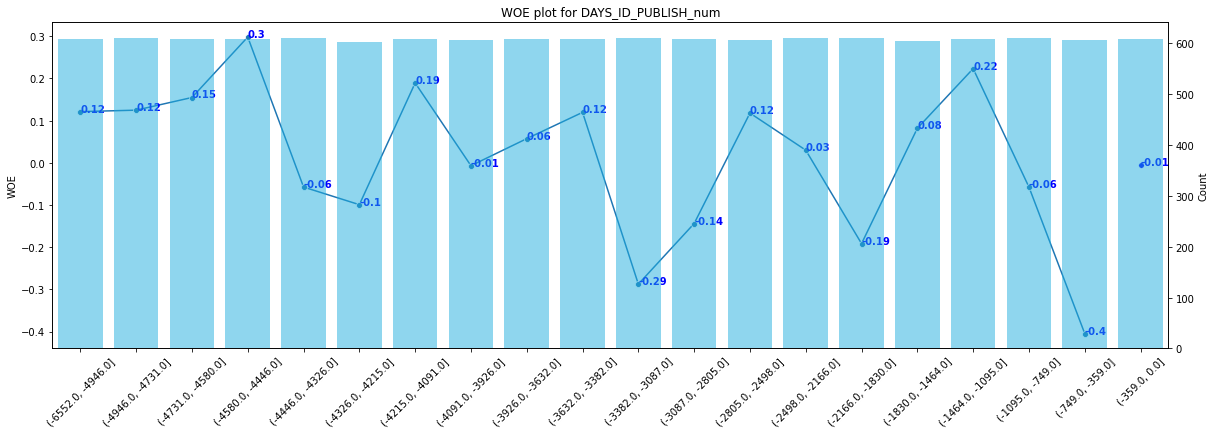

Information Value: 0.07383859409226799


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0    (-1.0, 1.0]   1611      88        1523     0.122734         0.133001   
1     (1.0, 2.0]   1396      58        1338     0.080893         0.116846   
2     (2.0, 3.0]   1291      66        1225     0.092050         0.106978   
3     (3.0, 4.0]    974      40         934     0.055788         0.081565   
4     (4.0, 5.0]    474      17         457     0.023710         0.039909   
5     (5.0, 6.0]    771      40         731     0.055788         0.063837   
6     (6.0, 7.0]    803      49         754     0.068340         0.065846   
7     (7.0, 9.0]    661      42         619     0.058577         0.054056   
8    (9.0, 11.0]    403      31         372     0.043236         0.032486   
9   (11.0, 14.0]    469      48         421     0.066946         0.036765   
10  (14.0, 18.0]    418      38         380     0.052999         0.033185   
11  (18.0, 65.0]    465      32         433     0.044630         0.037813   
12       Missing   2432     168        2264     0.234310         0.197712   

         WOE        IV  
0   0.080344  0.000825  
1   0.367732  0.013221  
2   0.150285  0.002243  
3   0.379840  0.009791  
4   0.520714  0.008435  
5   0.134778  0.001085  
6  -0.037184  0.000093  
7  -0.080321  0.000363  
8  -0.285850  0.003073  
9  -0.599325  0.018088  
10 -0.468171  0.009276  
11 -0.165755  0.001130  
12 -0.169832  0.006215

IV for OWN_CAR_AGE_num with 13 bins: 0.0738


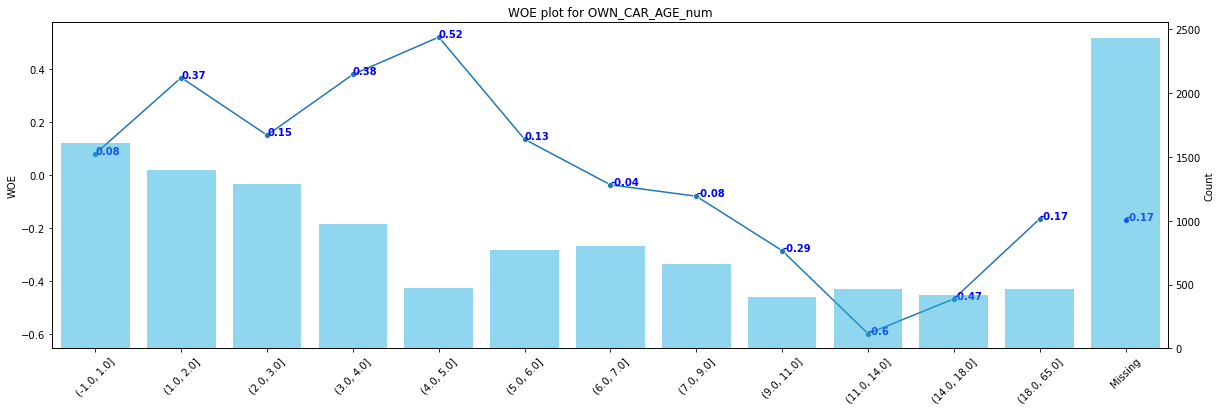

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_WORK_PHONE_num with 1 bins: 0.0


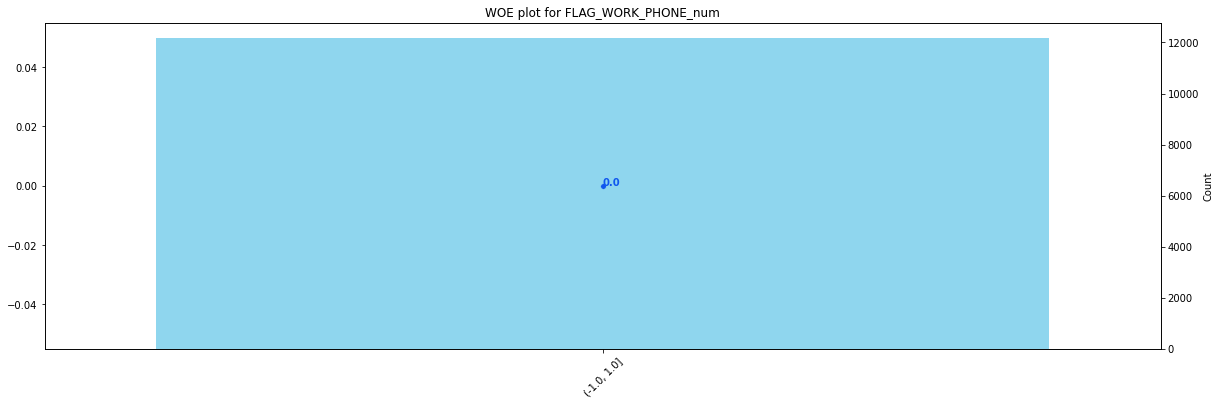

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_CONT_MOBILE_num with 1 bins: 0.0


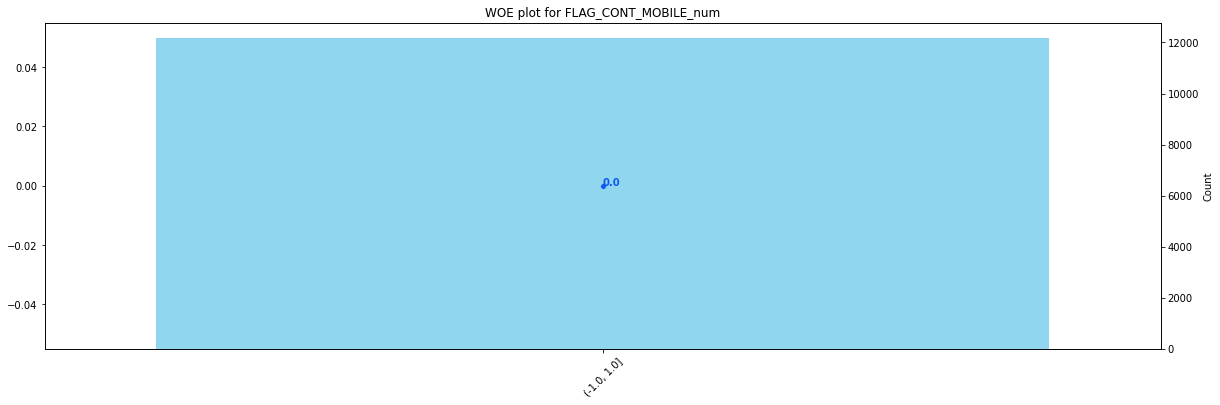

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_PHONE_num with 1 bins: 0.0


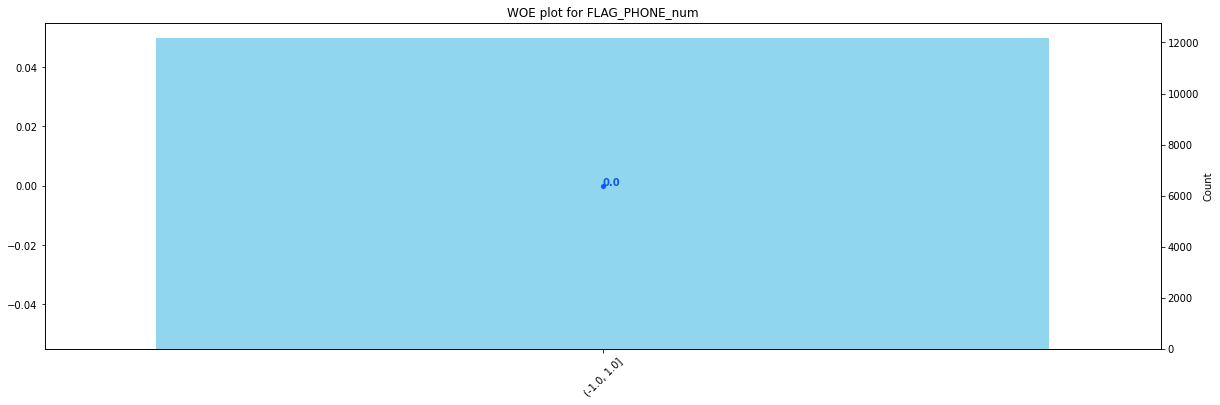

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_EMAIL_num with 1 bins: 0.0


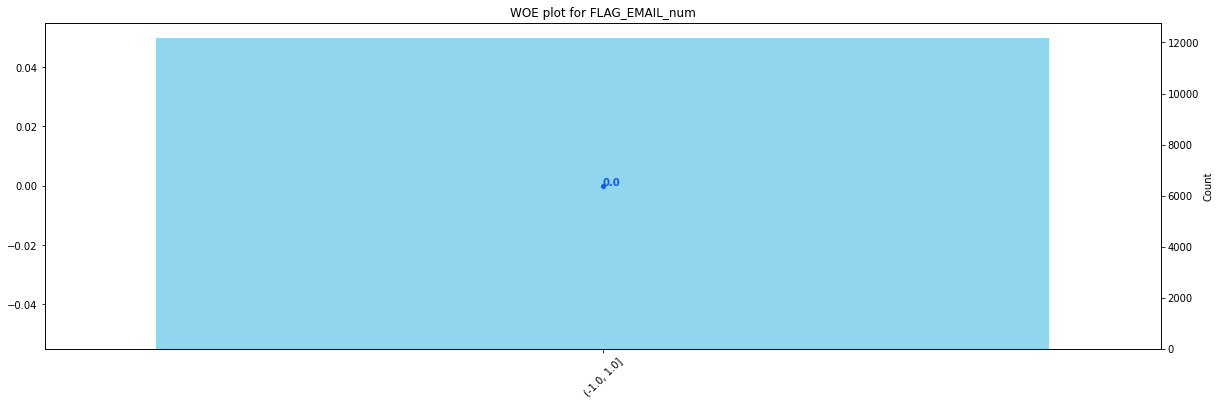

Mapping for OCCUPATION_TYPE:
Drivers: 4
Managers: 10
Laborers: 8
Core staff: 3
High skill tech staff: 6
nan: -1
Security staff: 16
IT staff: 7
Accountants: 0
Sales staff: 14
Cleaning staff: 1
Medicine staff: 11
Cooking staff: 2
Private service staff: 12
Waiters/barmen staff: 17
Low-skill Laborers: 9
Realty agents: 13
Secretaries: 15
HR staff: 5
Information Value: 0.05945160181019561


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0         -1   2509     141        2368     0.196653         0.206794   
1          0    547      24         523     0.033473         0.045673   
2          1     28       3          25     0.004184         0.002183   
3          2     83       5          78     0.006974         0.006812   
4          3   1102      35        1067     0.048815         0.093180   
5          4   1562     124        1438     0.172943         0.125579   
6          5     26       1          25     0.001395         0.002183   
7          6    586      32         554     0.044630         0.048380   
8          7     25       1          24     0.001395         0.002096   
9          8   2125     139        1986     0.193863         0.173435   
10         9     28       3          25     0.004184         0.002183   
11        10   2112     115        1997     0.160391         0.174395   
12        11    208      13         195     0.018131         0.017029   
13        12    117      11         106     0.015342         0.009257   
14        13     24       2          22     0.002789         0.001921   
15        14    801      52         749     0.072524         0.065409   
16        15     36       2          34     0.002789         0.002969   
17        16    228      13         215     0.018131         0.018776   
18        17     21       1          20     0.001395         0.001747   

         WOE        IV  
0   0.050285  0.000510  
1   0.310771  0.003791  
2  -0.650493  0.001302  
3  -0.023486  0.000004  
4   0.646502  0.028682  
5  -0.320030  0.015158  
6   0.448119  0.000353  
7   0.080672  0.000302  
8   0.407297  0.000286  
9  -0.111353  0.002275  
10 -0.650493  0.001302  
11  0.083713  0.001172  
12 -0.062706  0.000069  
13 -0.505213  0.003074  
14 -0.372861  0.000324  
15 -0.103261  0.000735  
16  0.062457  0.000011  
17  0.034932  0.000023  
18  0.224976  0.000079

IV for OCCUPATION_TYPE_num with 19 bins: 0.0595


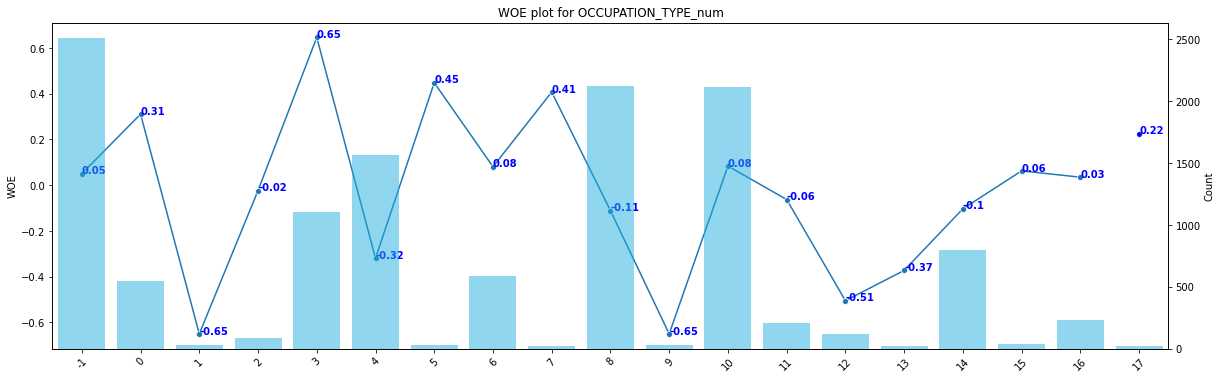

Information Value: 0.005313297648777145


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0  (0.0, 2.0]   8184     467        7717     0.651325         0.673915   
1  (2.0, 3.0]   2567     168        2399     0.234310         0.209501   
2  (3.0, 4.0]   1233      68        1165     0.094840         0.101738   
3  (4.0, 7.0]    184      14         170     0.019526         0.014846   

        WOE        IV  
0  0.034095  0.000770  
1 -0.111913  0.002776  
2  0.070212  0.000484  
3 -0.274015  0.001282

IV for CNT_FAM_MEMBERS_num with 4 bins: 0.0053


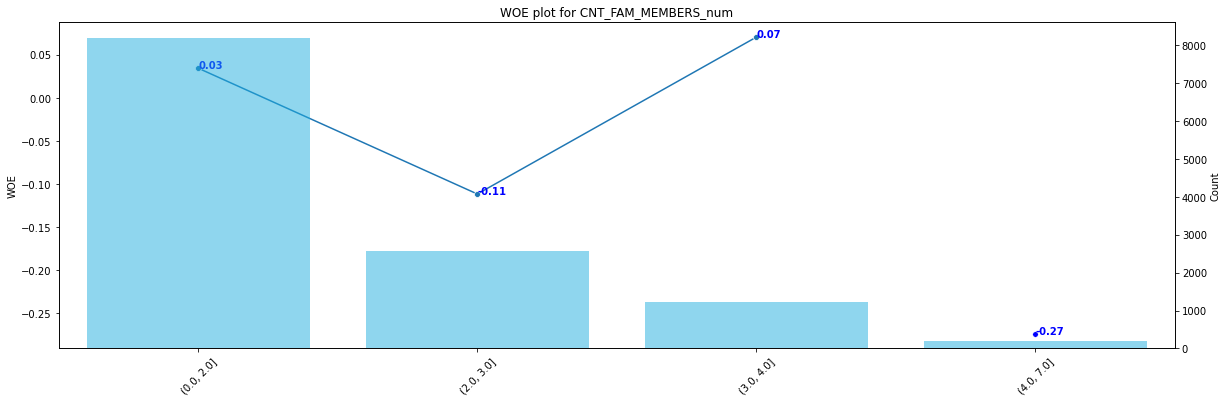

Information Value: 0.03502627948593325


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0  (0.0, 2.0]  11122     616       10506     0.859135         0.917474   
1  (2.0, 3.0]   1046     101         945     0.140865         0.082526   

        WOE        IV  
0  0.065698  0.003833  
1 -0.534692  0.031193

IV for REGION_RATING_CLIENT_num with 2 bins: 0.035


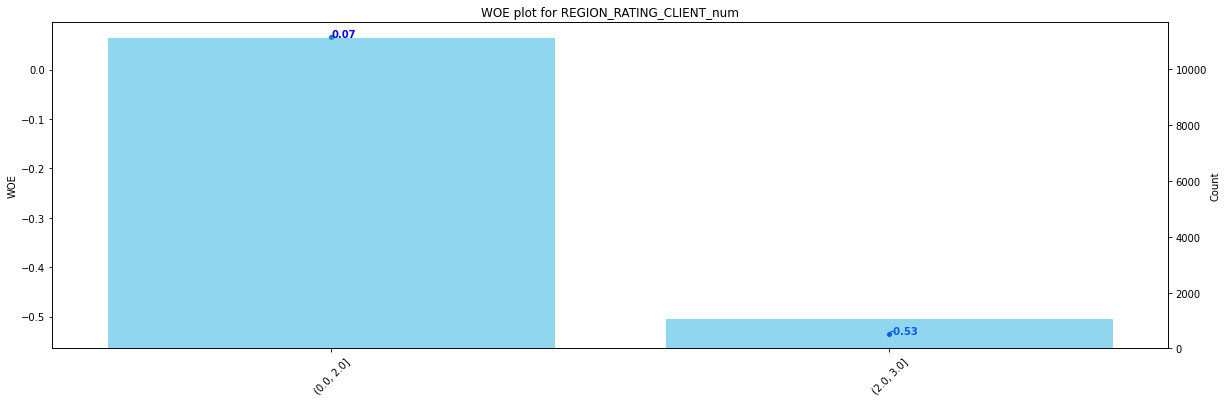

Mapping for WEEKDAY_APPR_PROCESS_START:
THURSDAY: 4
TUESDAY: 5
MONDAY: 1
SATURDAY: 2
FRIDAY: 0
SUNDAY: 3
WEDNESDAY: 6
Information Value: 0.01685703258743473


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0         0   1892     114        1778     0.158996         0.155270   
1         1   1898     112        1786     0.156206         0.155969   
2         2   1292      69        1223     0.096234         0.106803   
3         3    584      28         556     0.039052         0.048555   
4         4   2201     161        2040     0.224547         0.178150   
5         5   2093     111        1982     0.154812         0.173085   
6         6   2208     122        2086     0.170153         0.182167   

        WOE            IV  
0 -0.023711  8.833439e-05  
1 -0.001522  3.613895e-07  
2  0.104199  1.101238e-03  
3  0.217807  2.069846e-03  
4 -0.231456  1.073870e-02  
5  0.111575  2.038878e-03  
6  0.068226  8.196737e-04

IV for WEEKDAY_APPR_PROCESS_START_num with 7 bins: 0.0169


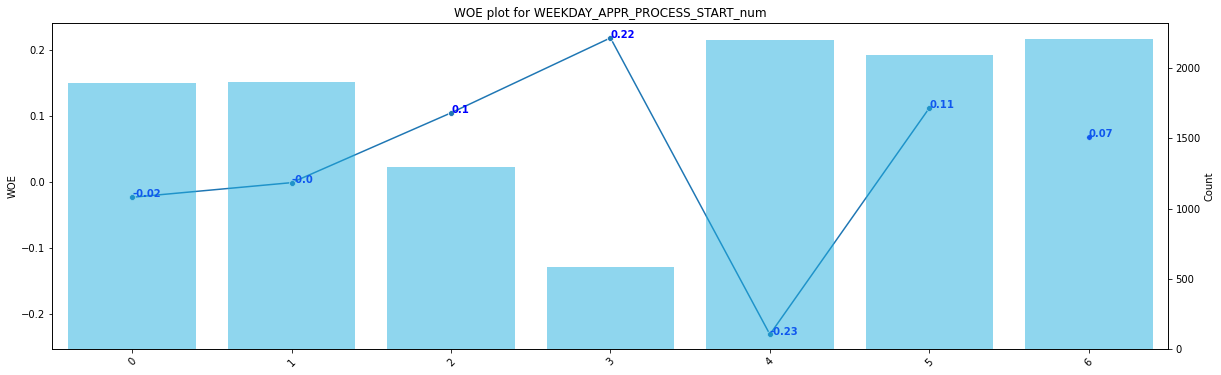

Information Value: 0.04198080886875489


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0    (-1.0, 8.0]    965      86         879     0.119944         0.076762   
1     (8.0, 9.0]    917      61         856     0.085077         0.074753   
2    (9.0, 10.0]   1330      75        1255     0.104603         0.109597   
3   (10.0, 11.0]   1390      83        1307     0.115760         0.114139   
4   (11.0, 12.0]   1345      74        1271     0.103208         0.110995   
5   (12.0, 13.0]   1305      80        1225     0.111576         0.106978   
6   (13.0, 14.0]   1139      59        1080     0.082287         0.094315   
7   (14.0, 15.0]   1127      58        1069     0.080893         0.093354   
8   (15.0, 16.0]   1076      72        1004     0.100418         0.087678   
9   (16.0, 17.0]    760      39         721     0.054393         0.062964   
10  (17.0, 18.0]    482      16         466     0.022315         0.040695   
11  (18.0, 23.0]    332      14         318     0.019526         0.027771   

         WOE        IV  
0  -0.446319  0.019273  
1  -0.129360  0.001335  
2   0.046646  0.000233  
3  -0.014107  0.000023  
4   0.072738  0.000566  
5  -0.042087  0.000194  
6   0.136422  0.001641  
7   0.143279  0.001786  
8  -0.135675  0.001729  
9   0.146321  0.001254  
10  0.600840  0.011043  
11  0.352238  0.002904

IV for HOUR_APPR_PROCESS_START_num with 12 bins: 0.042


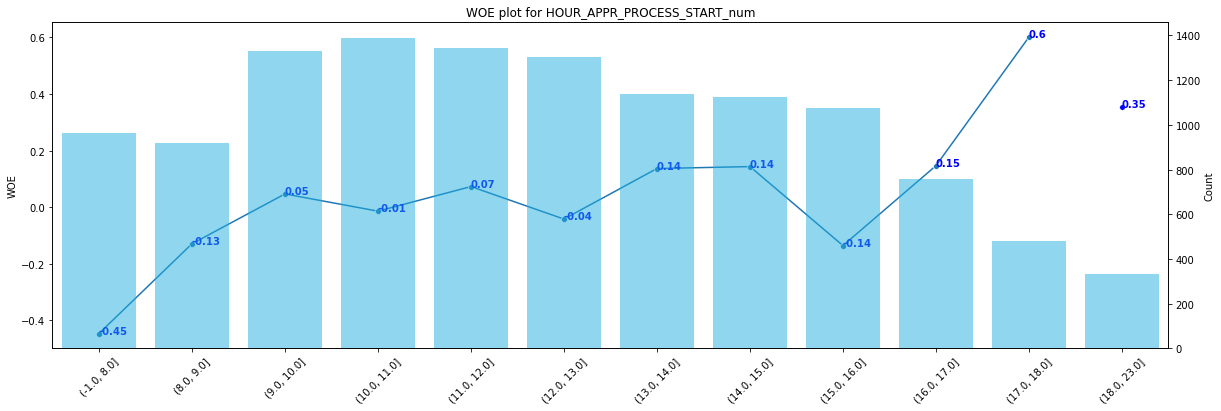

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for REG_REGION_NOT_LIVE_REGION_num with 1 bins: 0.0


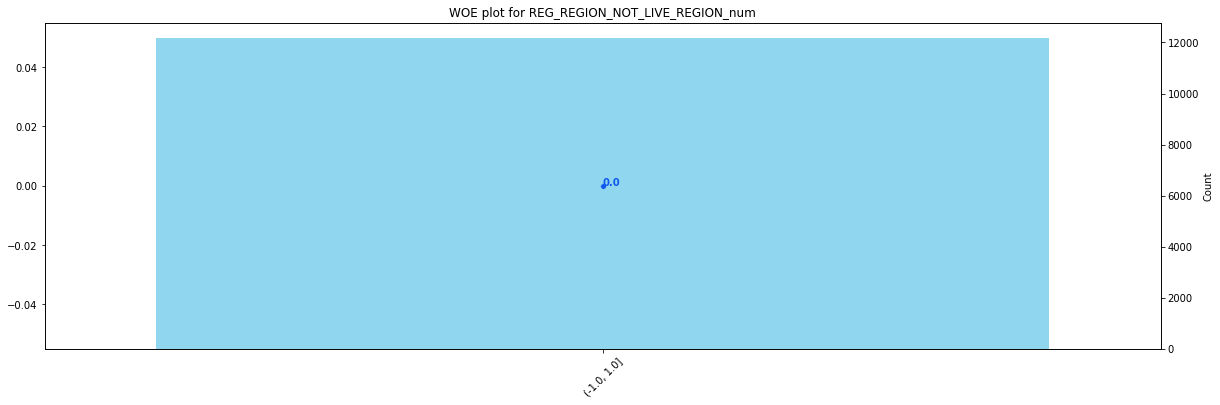

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for LIVE_REGION_NOT_WORK_REGION_num with 1 bins: 0.0


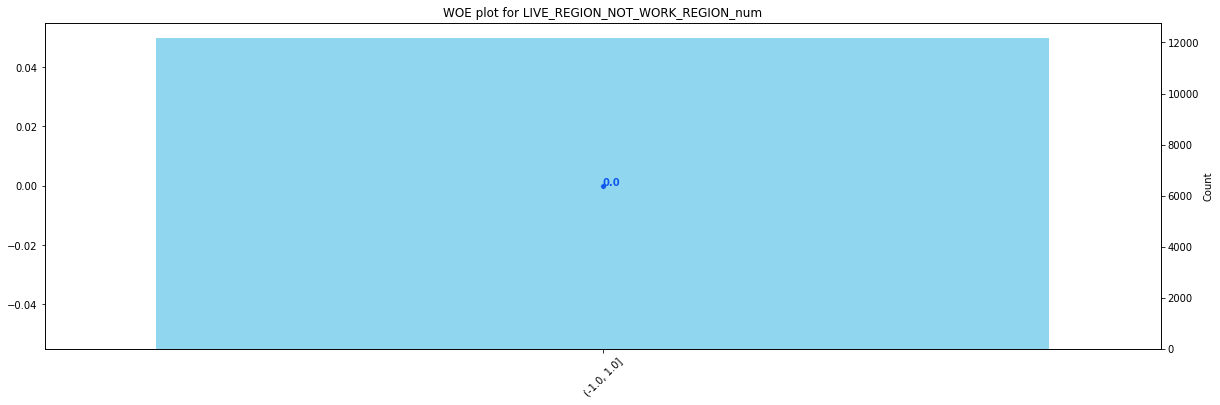

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for REG_CITY_NOT_LIVE_CITY_num with 1 bins: 0.0


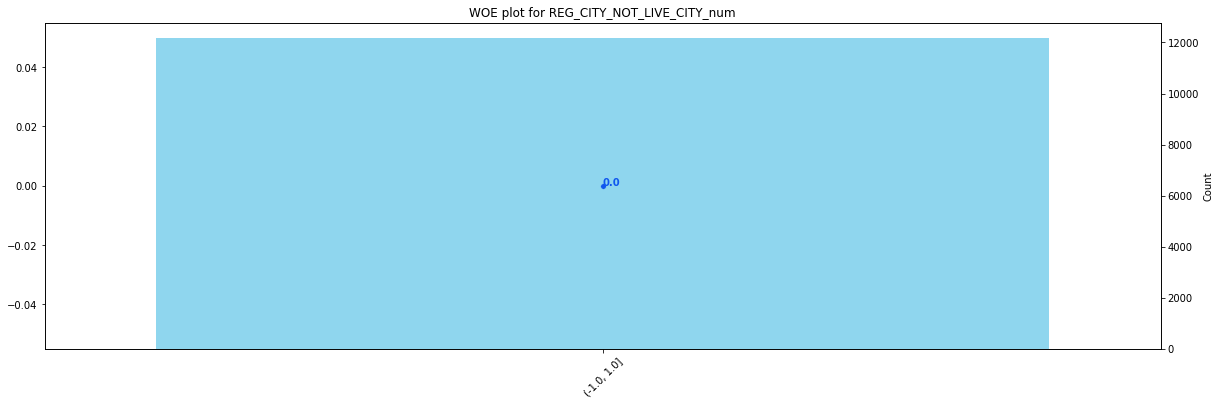

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for LIVE_CITY_NOT_WORK_CITY_num with 1 bins: 0.0


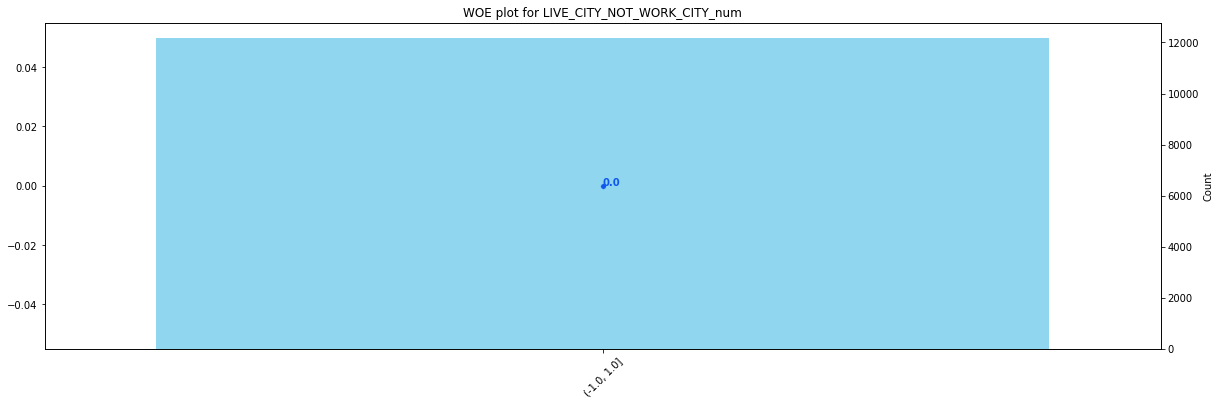

Mapping for ORGANIZATION_TYPE:
Self-employed: 42
Government: 11
Services: 43
Medicine: 30
Transport: type 3: 54
Business Entity Type 3: 5
Kindergarten: 28
Postal: 35
Transport: type 4: 55
Construction: 7
Bank: 2
XNA: 57
Business Entity Type 2: 4
Other: 33
Security: 40
University: 56
Trade: type 3: 47
Industry: type 12: 17
Industry: type 7: 24
Mobile: 32
Trade: type 7: 51
Business Entity Type 1: 3
Industry: type 9: 26
Police: 34
Agriculture: 1
School: 39
Housing: 13
Trade: type 2: 46
Hotel: 12
Electricity: 9
Industry: type 11: 16
Trade: type 5: 49
Military: 31
Industry: type 10: 15
Transport: type 2: 53
Security Ministries: 41
Industry: type 1: 14
Emergency: 10
Culture: 8
Industry: type 4: 21
Telecom: 44
Industry: type 3: 20
Legal Services: 29
Trade: type 6: 50
Advertising: 0
Industry: type 5: 22
Trade: type 1: 45
Restaurant: 38
Insurance: 27
Cleaning: 6
Industry: type 2: 19
Realtor: 36
Industry: type 13: 18
Religion: 37
Industry: type 8: 25
Trade: type 4: 48
Transport: type 1: 52
Indus

Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0          0     24       0          24     0.000000         0.002096   
1          1     81       3          78     0.004184         0.006812   
2          2    106       2         104     0.002789         0.009082   
3          3    293      21         272     0.029289         0.023753   
4          4    444      25         419     0.034868         0.036591   
5          5   3751     240        3511     0.334728         0.306611   
6          6      8       0           8     0.000000         0.000699   
7          7    402      24         378     0.033473         0.033010   
8          8     12       0          12     0.000000         0.001048   
9          9     48       1          47     0.001395         0.004104   
10        10     30       1          29     0.001395         0.002533   
11        11    382      17         365     0.023710         0.031875   
12        12     36       0          36     0.000000         0.003144   
13        13    105       3         102     0.004184         0.008908   
14        14     58       4          54     0.005579         0.004716   
15        15     11       2           9     0.002789         0.000786   
16        16    106       3         103     0.004184         0.008995   
17        17     23       1          22     0.001395         0.001921   
18        18      5       0           5     0.000000         0.000437   
19        19     20       2          18     0.002789         0.001572   
20        20     90       6          84     0.008368         0.007336   
21        21     33       3          30     0.004184         0.002620   
22        22     29       3          26     0.004184         0.002271   
23        23      5       1           4     0.001395         0.000349   
24        24     48       2          46     0.002789         0.004017   
25        25      2       0           2     0.000000         0.000175   
26        26    217       5         212     0.006974         0.018514   
27        27     49       4          45     0.005579         0.003930   
28        28    113       8         105     0.011158         0.009170   
29        29     39       1          38     0.001395         0.003318   
30        30    361      25         336     0.034868         0.029342   
31        31    156       8         148     0.011158         0.012925   
32        32     10       0          10     0.000000         0.000873   
33        33    719      28         691     0.039052         0.060344   
34        34    143       4         139     0.005579         0.012139   
35        35     32       2          30     0.002789         0.002620   
36        36     32       2          30     0.002789         0.002620   
37        37      6       0           6     0.000000         0.000524   
38        38     46       5          41     0.006974         0.003580   
39        39    229       7         222     0.009763         0.019387   
40        40    169      13         156     0.018131         0.013623   
41        41     93       0          93     0.000000         0.008122   
42        42   1597     130        1467     0.181311         0.128111   
43        43     52       4          48     0.005579         0.004192   
44        44     18       0          18     0.000000         0.001572   
45        45      9       0           9     0.000000         0.000786   
46        46     66       2          64     0.002789         0.005589   
47        47     99       4          95     0.005579         0.008296   
48        48      4       0           4     0.000000         0.000349   
49        49      2       0           2     0.000000         0.000175   
50        50     34       3          31     0.004184         0.002707   
51        51    293      20         273     0.027894         0.023841   
52        52      9       0           9     0.000000         0.000786   
53        53     82       4          78     0.005579         

IV for ORGANIZATION_TYPE_num with 58 bins: inf


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

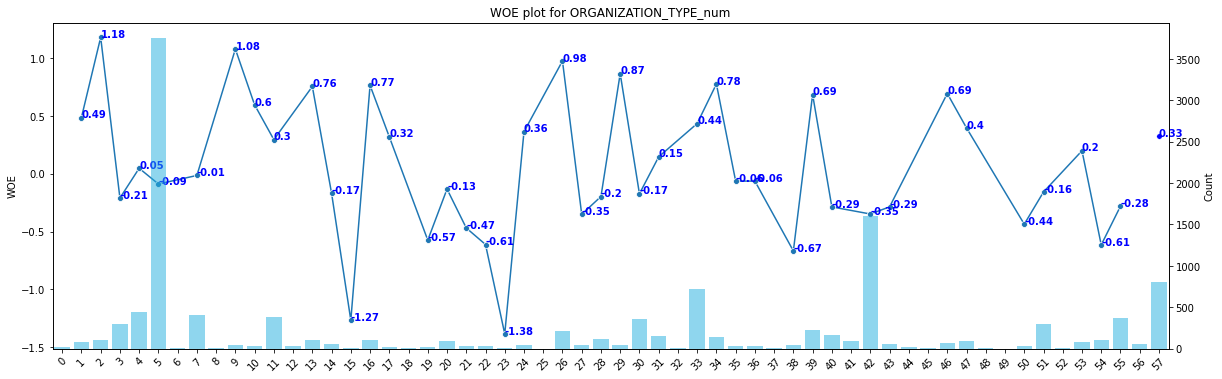

Information Value: 0.06360330871034024


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0   (-0.01, 0.0014]    563      30         533     0.041841         0.046546   
1   (0.0014, 0.026]    281      11         270     0.015342         0.023579   
2    (0.026, 0.039]    283      13         270     0.018131         0.023579   
3    (0.039, 0.048]    281      17         264     0.023710         0.023055   
4    (0.048, 0.056]    281      12         269     0.016736         0.023491   
5    (0.056, 0.062]    280       9         271     0.012552         0.023666   
6    (0.062, 0.069]    281      18         263     0.025105         0.022967   
7    (0.069, 0.076]    284      13         271     0.018131         0.023666   
8     (0.076, 0.08]    280      15         265     0.020921         0.023142   
9     (0.08, 0.086]    281      15         266     0.020921         0.023229   
10   (0.086, 0.094]    280      14         266     0.019526         0.023229   
11     (0.094, 0.1]    282      17         265     0.023710         0.023142   
12      (0.1, 0.11]    283      11         272     0.015342         0.023753   
13     (0.11, 0.12]    278      12         266     0.016736         0.023229   
14     (0.12, 0.14]    280      14         266     0.019526         0.023229   
15     (0.14, 0.16]    283      12         271     0.016736         0.023666   
16     (0.16, 0.19]    279       9         270     0.012552         0.023579   
17     (0.19, 0.26]    281      12         269     0.016736         0.023491   
18      (0.26, 1.0]    282       8         274     0.011158         0.023928   
19          Missing   6545     455        6090     0.634589         0.531831   

         WOE        IV  
0   0.106568  0.000501  
1   0.429770  0.003540  
2   0.262716  0.001431  
3  -0.028021  0.000018  
4   0.339048  0.002290  
5   0.634138  0.007048  
6  -0.088974  0.000190  
7   0.266413  0.001475  
8   0.100923  0.000224  
9   0.104690  0.000242  
10  0.173682  0.000643  
11 -0.024240  0.000014  
12  0.437150  0.003677  
13  0.327833  0.002129  
14  0.173682  0.000643  
15  0.346456  0.002401  
16  0.630441  0.006952  
17  0.339048  0.002290  
18  0.762930  0.009743  
19 -0.176651  0.018152

IV for BASEMENTAREA_AVG_num with 20 bins: 0.0636


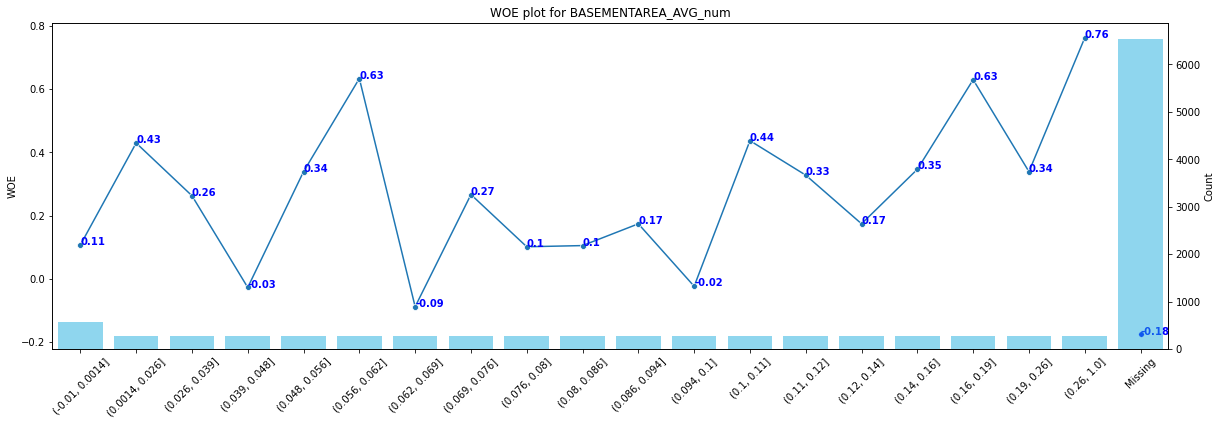

Information Value: 0.07633448684577009


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0   (-0.001, 0.969]    361      21         340     0.029289         0.029692   
1    (0.969, 0.973]    372      15         357     0.020921         0.031176   
2    (0.973, 0.975]    377      21         356     0.029289         0.031089   
3    (0.975, 0.976]    321      18         303     0.025105         0.026461   
4    (0.976, 0.978]    440      21         419     0.029289         0.036591   
5    (0.978, 0.979]    318      22         296     0.030683         0.025849   
6     (0.979, 0.98]    315      16         299     0.022315         0.026111   
7     (0.98, 0.981]    314      18         296     0.025105         0.025849   
8    (0.981, 0.982]    468      12         456     0.016736         0.039822   
9    (0.982, 0.983]    313      14         299     0.019526         0.026111   
10   (0.983, 0.984]    319      15         304     0.020921         0.026548   
11   (0.984, 0.985]    330      14         316     0.019526         0.027596   
12   (0.985, 0.986]    369      27         342     0.037657         0.029866   
13   (0.986, 0.987]    390      21         369     0.029289         0.032224   
14   (0.987, 0.988]    309      10         299     0.013947         0.026111   
15    (0.988, 0.99]    379      19         360     0.026499         0.031438   
16    (0.99, 0.992]    302      13         289     0.018131         0.025238   
17   (0.992, 0.994]    328      10         318     0.013947         0.027771   
18   (0.994, 0.997]    338      19         319     0.026499         0.027858   
19     (0.997, 1.0]    326      20         306     0.027894         0.026723   
20          Missing   5179     371        4808     0.517434         0.419876   

         WOE        IV  
0   0.013667  0.000006  
1   0.398929  0.004091  
2   0.059652  0.000107  
3   0.052605  0.000071  
4   0.222592  0.001625  
5  -0.171439  0.000829  
6   0.157098  0.000596  
7   0.029231  0.000022  
8   0.866830  0.020011  
9   0.290630  0.001914  
10  0.238221  0.001341  
11  0.345928  0.002792  
12 -0.231783  0.001806  
13  0.095518  0.000280  
14  0.627102  0.007628  
15  0.170909  0.000844  
16  0.330721  0.002350  
17  0.688710  0.009520  
18  0.049996  0.000068  
19 -0.042904  0.000050  
20 -0.208922  0.020382

IV for YEARS_BEGINEXPLUATATION_AVG_num with 21 bins: 0.0763


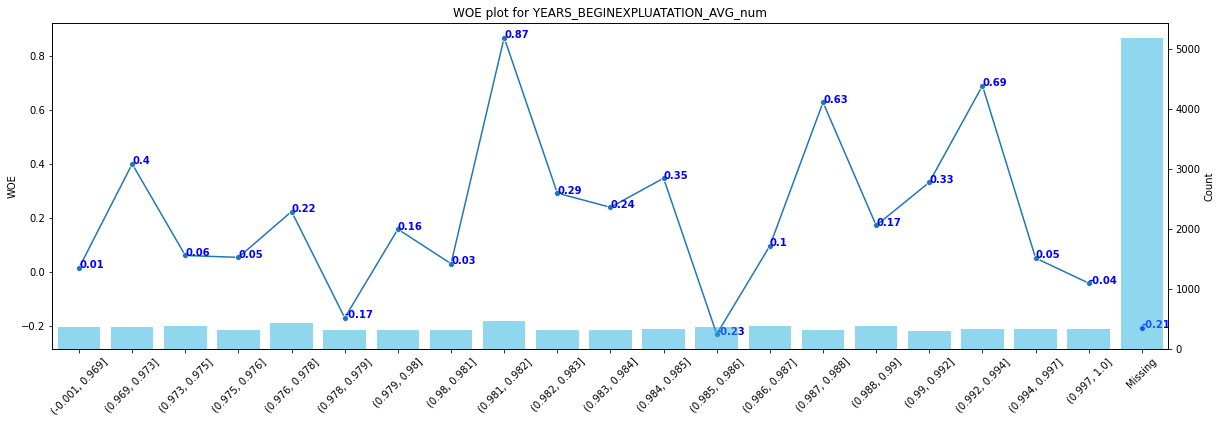

Information Value: 0.09490716901937964


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0   (-0.01, 0.59]    241      12         229     0.016736         0.019998   
1    (0.59, 0.63]    236      14         222     0.019526         0.019387   
2    (0.63, 0.66]    253       8         245     0.011158         0.021396   
3    (0.66, 0.68]    214      16         198     0.022315         0.017291   
4    (0.68, 0.69]    202       8         194     0.011158         0.016942   
5    (0.69, 0.71]    313      23         290     0.032078         0.025325   
6    (0.71, 0.73]    218      11         207     0.015342         0.018077   
7    (0.73, 0.74]    209       7         202     0.009763         0.017640   
8    (0.74, 0.76]    218       7         211     0.009763         0.018426   
9    (0.76, 0.77]    200       8         192     0.011158         0.016767   
10   (0.77, 0.78]    210      11         199     0.015342         0.017378   
11    (0.78, 0.8]    222      11         211     0.015342         0.018426   
12    (0.8, 0.81]    237      18         219     0.025105         0.019125   
13   (0.81, 0.82]    277      16         261     0.022315         0.022793   
14   (0.82, 0.84]    215       6         209     0.008368         0.018252   
15   (0.84, 0.86]    249       6         243     0.008368         0.021221   
16   (0.86, 0.88]    152       8         144     0.011158         0.012575   
17   (0.88, 0.93]    250       2         248     0.002789         0.021657   
18   (0.93, 0.96]    198      12         186     0.016736         0.016243   
19    (0.96, 1.0]    225      13         212     0.018131         0.018514   
20        Missing   7629     500        7129     0.697350         0.622566   

         WOE            IV  
0   0.178059  5.808016e-04  
1  -0.007136  9.908877e-07  
2   0.651060  6.665496e-03  
3  -0.255078  1.281548e-03  
4   0.417660  2.415809e-03  
5  -0.236370  1.596159e-03  
6   0.164067  4.487762e-04  
7   0.591601  4.660325e-03  
8   0.635191  5.502942e-03  
9   0.407297  2.284732e-03  
10  0.124653  2.538800e-04  
11  0.183206  5.651251e-04  
12 -0.272057  1.626799e-03  
13  0.021175  1.011257e-05  
14  0.779818  7.707319e-03  
15  0.930545  1.195998e-02  
16  0.119615  1.695809e-04  
17  2.049525  3.867064e-02  
18 -0.029916  1.475716e-05  
19  0.020880  7.988119e-06  
20 -0.113438  8.483414e-03

IV for YEARS_BUILD_AVG_num with 21 bins: 0.0949


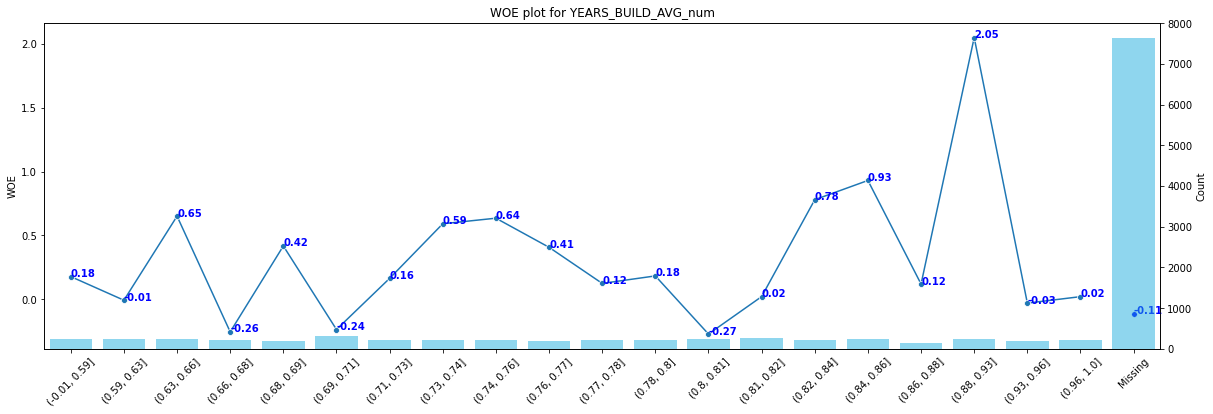

Information Value: 0.0512337943581775


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0    (-0.01, 0.00063]    410      26         384     0.036262   
1   (0.00063, 0.0038]    204       9         195     0.012552   
2     (0.0038, 0.007]    216       9         207     0.012552   
3     (0.007, 0.0087]    197      12         185     0.016736   
4     (0.0087, 0.011]    210       8         202     0.011158   
5      (0.011, 0.013]    196      12         184     0.016736   
6      (0.013, 0.016]    211       4         207     0.005579   
7       (0.016, 0.02]    198      10         188     0.013947   
8       (0.02, 0.026]    206      10         196     0.013947   
9      (0.026, 0.031]    207       9         198     0.012552   
10     (0.031, 0.037]    203      14         189     0.019526   
11     (0.037, 0.044]    204      10         194     0.013947   
12     (0.044, 0.052]    205      10         195     0.013947   
13     (0.052, 0.061]    203      13         190     0.018131   
14     (0.061, 0.074]    205       8         197     0.011158   
15     (0.074, 0.094]    205       8         197     0.011158   
16      (0.094, 0.12]    205      10         195     0.013947   
17       (0.12, 0.19]    204      12         192     0.016736   
18        (0.19, 1.0]    205       4         201     0.005579   
19            Missing   8074     519        7555     0.723849   

    %_of_Non_Events       WOE            IV  
0          0.033534 -0.078210  2.133593e-04  
1          0.017029  0.305018  1.365500e-03  
2          0.018077  0.364738  2.015075e-03  
3          0.016156 -0.035307  2.049970e-05  
4          0.017640  0.458070  2.969565e-03  
5          0.016068 -0.040727  2.720329e-05  
6          0.018077  1.175668  1.469376e-02  
7          0.016418  0.163100  4.029849e-04  
8          0.017116  0.204773  6.490093e-04  
9          0.017291  0.320286  1.517760e-03  
10         0.016505 -0.168067  5.076783e-04  
11         0.016942  0.194517  5.825286e-04  
12         0.017029  0.199658  6.153616e-04  
13         0.016592 -0.088682  1.364515e-04  
14         0.017204  0.433006  2.618012e-03  
15         0.017204  0.433006  2.618012e-03  
16         0.017029  0.199658  6.153616e-04  
17         0.016767  0.001832  5.623619e-08  
18         0.017553  1.146254  1.372553e-02  
19         0.659768 -0.092696  5.940083e-03

IV for COMMONAREA_AVG_num with 20 bins: 0.0512


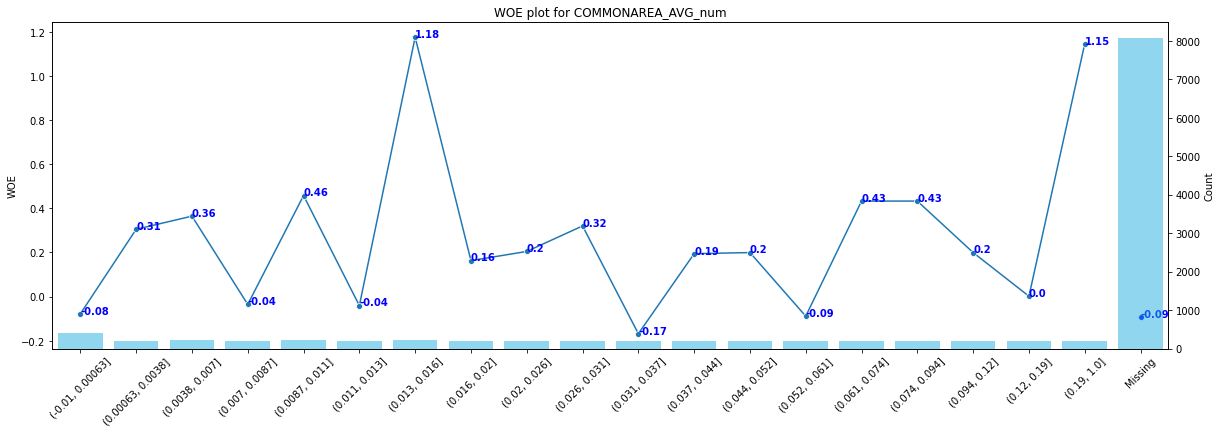

Information Value: inf


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0   (-0.01, 0.034]    633      34         599     0.047420         0.052310   
1   (0.034, 0.054]     47       1          46     0.001395         0.004017   
2   (0.054, 0.069]    885      49         836     0.068340         0.073007   
3     (0.069, 0.1]   1001      63         938     0.087866         0.081914   
4      (0.1, 0.13]    149       7         142     0.009763         0.012401   
5     (0.13, 0.14]   1481      65        1416     0.090656         0.123657   
6     (0.14, 0.17]    582      25         557     0.034868         0.048642   
7     (0.17, 0.21]    928      40         888     0.055788         0.077548   
8     (0.21, 0.24]    228       0         228     0.000000         0.019911   
9     (0.24, 0.28]    371      25         346     0.034868         0.030216   
10    (0.28, 0.34]    237      13         224     0.018131         0.019562   
11     (0.34, 1.0]    240       7         233     0.009763         0.020348   
12         Missing   5386     388        4998     0.541144         0.436468   

         WOE        IV  
0   0.098145  0.000480  
1   1.057885  0.002774  
2   0.066052  0.000308  
3  -0.070141  0.000417  
4   0.239160  0.000631  
5   0.310448  0.010245  
6   0.332933  0.004586  
7   0.329336  0.007166  
8        inf       inf  
9  -0.143194  0.000666  
10  0.075940  0.000109  
11  0.734372  0.007773  
12 -0.214969  0.022502

IV for ENTRANCES_AVG_num with 13 bins: inf


posx and posy should be finite values
posx and posy should be finite values


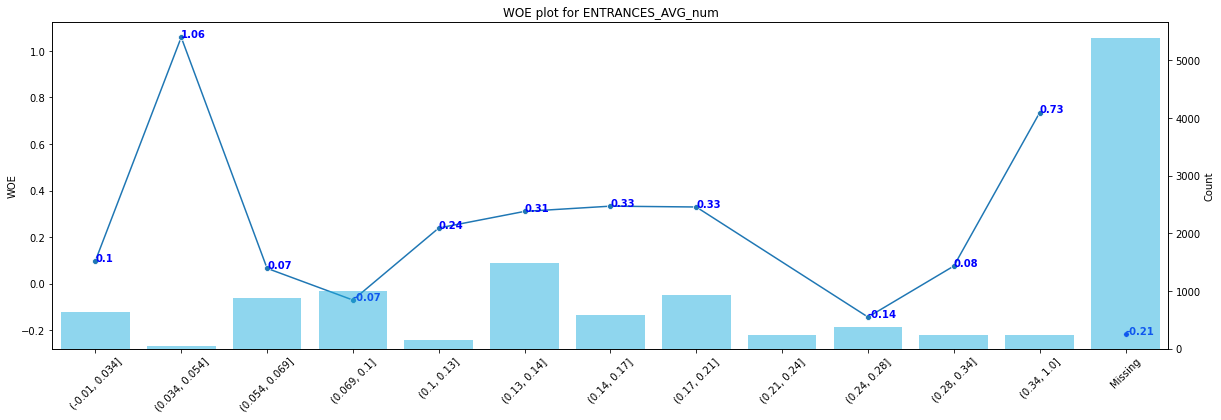

Information Value: 0.05750534451477948


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0   (-0.01, 0.042]    533      32         501     0.044630         0.043752   
1   (0.042, 0.083]    246      15         231     0.020921         0.020173   
2    (0.083, 0.12]    255      18         237     0.025105         0.020697   
3     (0.12, 0.17]   2455     123        2332     0.171548         0.203650   
4     (0.17, 0.29]    320      10         310     0.013947         0.027072   
5     (0.29, 0.33]   1640      72        1568     0.100418         0.136931   
6     (0.33, 0.35]     46       1          45     0.001395         0.003930   
7     (0.35, 0.38]    511      26         485     0.036262         0.042354   
8     (0.38, 0.46]    262      14         248     0.019526         0.021657   
9     (0.46, 0.58]    242      10         232     0.013947         0.020260   
10     (0.58, 1.0]    340      14         326     0.019526         0.028469   
11         Missing   5318     382        4936     0.532775         0.431054   

         WOE        IV  
0  -0.019886  0.000017  
1  -0.036389  0.000027  
2  -0.193068  0.000851  
3   0.171541  0.005507  
4   0.663231  0.008705  
5   0.310134  0.011324  
6   1.035906  0.002626  
7   0.155296  0.000946  
8   0.103615  0.000221  
9   0.373396  0.002357  
10  0.377084  0.003372  
11 -0.211867  0.021551

IV for FLOORSMAX_AVG_num with 12 bins: 0.0575


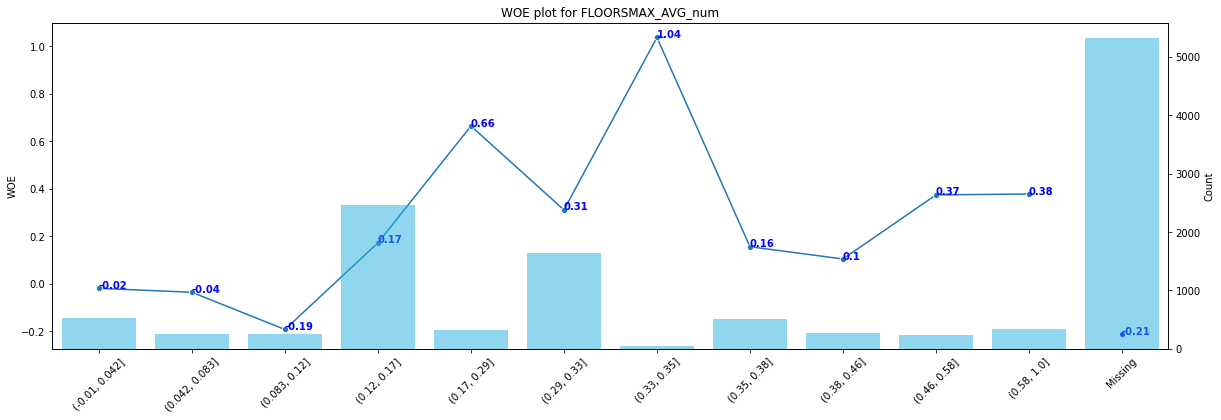

Information Value: 0.03169929666564176


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0   (-0.01, 0.042]    788      38         750     0.052999         0.065496   
1   (0.042, 0.083]    167      12         155     0.016736         0.013536   
2    (0.083, 0.14]    133       7         126     0.009763         0.011003   
3     (0.14, 0.21]   1435      68        1367     0.094840         0.119378   
4     (0.21, 0.28]     87       3          84     0.004184         0.007336   
5     (0.28, 0.38]    999      42         957     0.058577         0.083573   
6     (0.38, 0.42]    269      15         254     0.020921         0.022181   
7     (0.42, 0.46]     37       1          36     0.001395         0.003144   
8     (0.46, 0.58]    219      10         209     0.013947         0.018252   
9      (0.58, 1.0]    216      10         206     0.013947         0.017990   
10         Missing   7818     511        7307     0.712692         0.638110   

         WOE        IV  
0   0.211731  0.002646  
1  -0.212238  0.000679  
2   0.119615  0.000148  
3   0.230110  0.005647  
4   0.561448  0.001769  
5   0.355377  0.008883  
6   0.058528  0.000074  
7   0.812762  0.001422  
8   0.268993  0.001158  
9   0.254535  0.001029  
10 -0.110538  0.008244

IV for FLOORSMIN_AVG_num with 11 bins: 0.0317


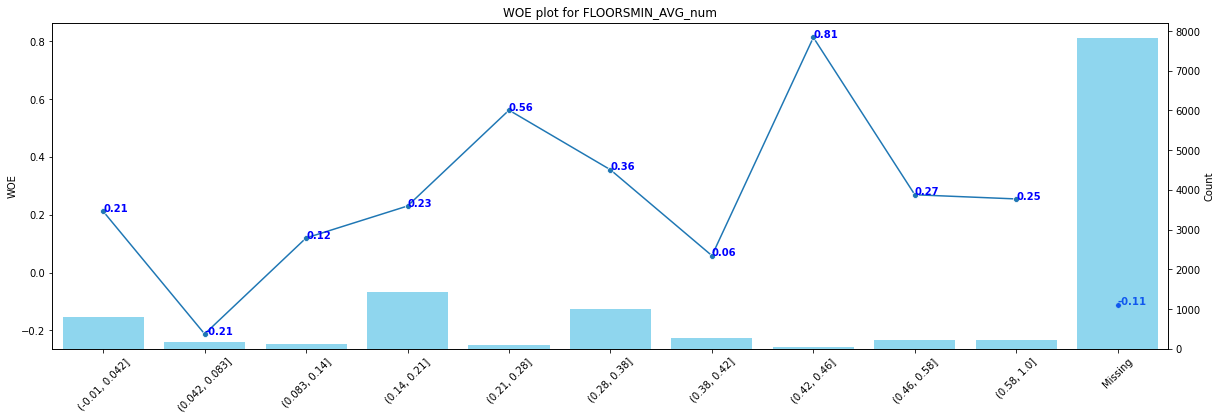

Information Value: 0.04573106422098536


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0   (-0.01, 0.0015]    823      37         786     0.051604         0.068640   
1   (0.0015, 0.012]    274      15         259     0.020921         0.022618   
2    (0.012, 0.018]    279      12         267     0.016736         0.023317   
3    (0.018, 0.023]    275      13         262     0.018131         0.022880   
4    (0.023, 0.029]    268      11         257     0.015342         0.022443   
5    (0.029, 0.036]    279      11         268     0.015342         0.023404   
6    (0.036, 0.042]    270      17         253     0.023710         0.022094   
7    (0.042, 0.049]    274      10         264     0.013947         0.023055   
8    (0.049, 0.057]    273      18         255     0.025105         0.022269   
9    (0.057, 0.063]    275      14         261     0.019526         0.022793   
10   (0.063, 0.072]    275      12         263     0.016736         0.022967   
11   (0.072, 0.081]    273      11         262     0.015342         0.022880   
12   (0.081, 0.092]    273      15         258     0.020921         0.022531   
13    (0.092, 0.11]    274      16         258     0.022315         0.022531   
14     (0.11, 0.12]    274      14         260     0.019526         0.022705   
15     (0.12, 0.15]    274      14         260     0.019526         0.022705   
16     (0.15, 0.21]    274      15         259     0.020921         0.022618   
17      (0.21, 1.0]    275       9         266     0.012552         0.023229   
18          Missing   6686     453        6233     0.631799         0.544319   

         WOE        IV  
0   0.285282  0.004860  
1   0.078021  0.000132  
2   0.331586  0.002182  
3   0.232639  0.001105  
4   0.380424  0.002702  
5   0.422335  0.003405  
6  -0.070580  0.000114  
7   0.502608  0.004578  
8  -0.119865  0.000340  
9   0.154707  0.000505  
10  0.316491  0.001972  
11  0.399693  0.003013  
12  0.074153  0.000119  
13  0.009614  0.000002  
14  0.150868  0.000480  
15  0.150868  0.000480  
16  0.078021  0.000132  
17  0.615515  0.006572  
18 -0.149036  0.013038

IV for LANDAREA_AVG_num with 19 bins: 0.0457


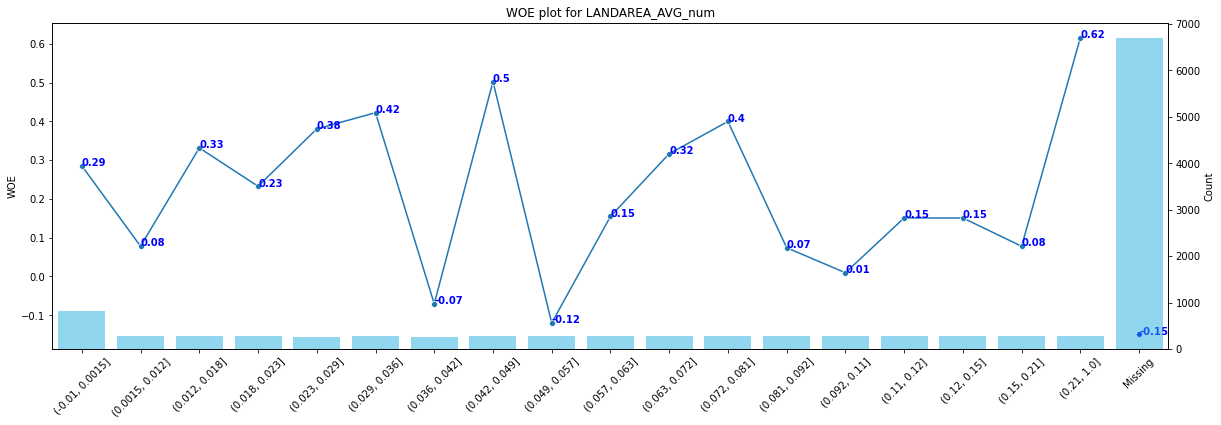

Information Value: 0.023565213055784948


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0   (-0.01, 0.0019]   2350     116        2234     0.161785         0.195092   
1  (0.0019, 0.0039]    612      30         582     0.041841         0.050825   
2  (0.0039, 0.0077]    306      16         290     0.022315         0.025325   
3   (0.0077, 0.012]    190       8         182     0.011158         0.015894   
4    (0.012, 0.015]    138       9         129     0.012552         0.011265   
5    (0.015, 0.023]    173       5         168     0.006974         0.014671   
6    (0.023, 0.042]    205       9         196     0.012552         0.017116   
7      (0.042, 1.0]    197      10         187     0.013947         0.016330   
8           Missing   7997     514        7483     0.716876         0.653480   

        WOE        IV  
0  0.187202  0.006235  
1  0.194517  0.001748  
2  0.126536  0.000381  
3  0.353809  0.001676  
4 -0.108169  0.000139  
5  0.743770  0.005725  
6  0.310134  0.001415  
7  0.157767  0.000376  
8 -0.092591  0.005870

IV for NONLIVINGAPARTMENTS_AVG_num with 9 bins: 0.0236


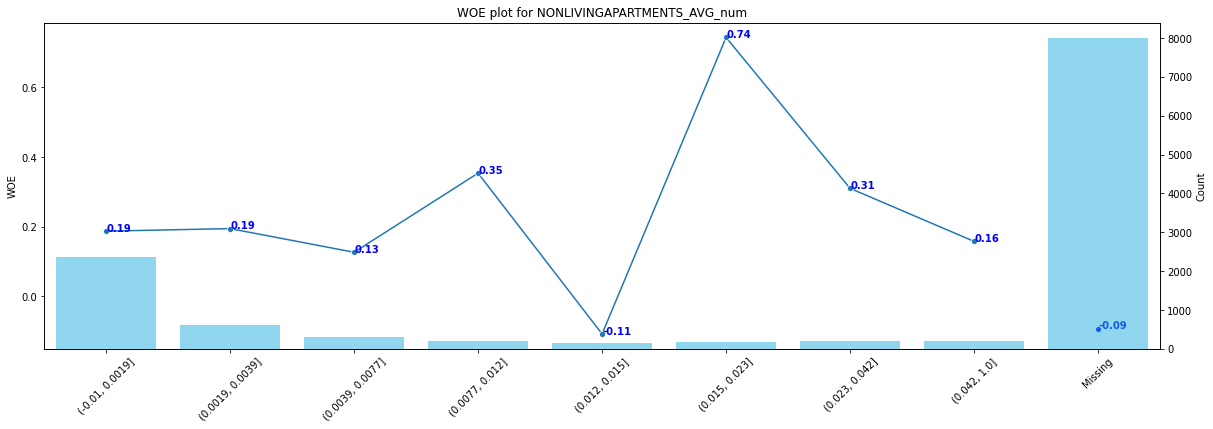

Information Value: 0.05857174525299845


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0    (-0.1, 0.001]   2511     125        2386     0.174338         0.208366   
1   (0.001, 0.003]    311       7         304     0.009763         0.026548   
2   (0.003, 0.006]    310      15         295     0.020921         0.025762   
3   (0.006, 0.009]    304      14         290     0.019526         0.025325   
4    (0.009, 0.01]    312      21         291     0.029289         0.025413   
5     (0.01, 0.02]    312      16         296     0.022315         0.025849   
6     (0.02, 0.03]    309      14         295     0.019526         0.025762   
7     (0.03, 0.04]    312      18         294     0.025105         0.025675   
8     (0.04, 0.05]    312      14         298     0.019526         0.026024   
9     (0.05, 0.07]    312      13         299     0.018131         0.026111   
10     (0.07, 0.1]    312      10         302     0.013947         0.026373   
11      (0.1, 0.2]    312      19         293     0.026499         0.025587   
12      (0.2, 1.0]    313      17         296     0.023710         0.025849   
13         Missing   5926     414        5512     0.577406         0.481355   

         WOE        IV  
0   0.178303  0.006067  
1   1.000361  0.016791  
2   0.208169  0.001008  
3   0.260067  0.001508  
4  -0.141956  0.000550  
5   0.147014  0.000520  
6   0.277162  0.001728  
7   0.022452  0.000013  
8   0.287280  0.001867  
9   0.364738  0.002911  
10  0.637085  0.007917  
11 -0.035023  0.000032  
12  0.086390  0.000185  
13 -0.181940  0.017475

IV for NONLIVINGAREA_AVG_num with 14 bins: 0.0586


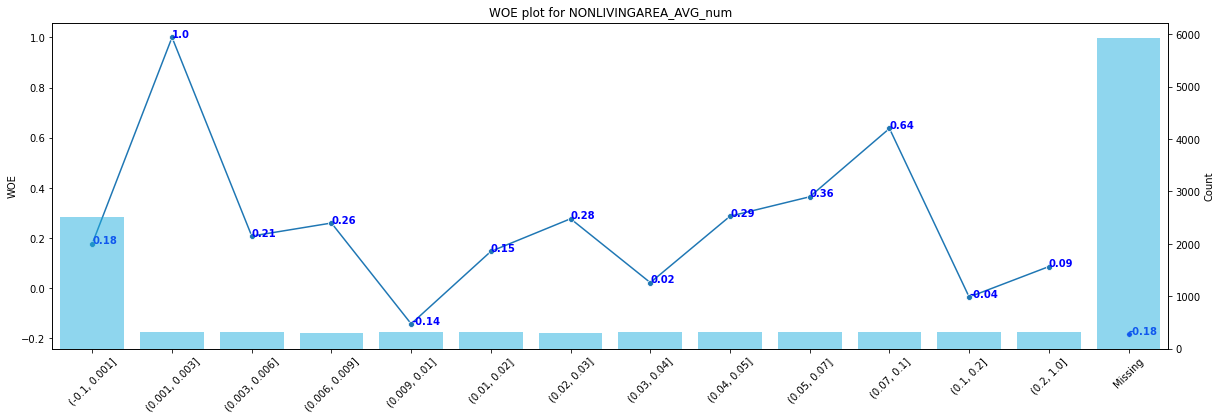

Mapping for FONDKAPREMONT_MODE:
nan: -1
reg oper spec account: 3
reg oper account: 2
org spec account: 1
not specified: 0
Information Value: 0.028755380833324296


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0        -1   7865     514        7351     0.716876         0.641953   
1         0    280      16         264     0.022315         0.023055   
2         1    312      11         301     0.015342         0.026286   
3         2   3245     153        3092     0.213389         0.270020   
4         3    466      23         443     0.032078         0.038687   

        WOE        IV  
0 -0.110388  0.008271  
1  0.032604  0.000024  
2  0.538458  0.005893  
3  0.235379  0.013330  
4  0.187319  0.001238

IV for FONDKAPREMONT_MODE_num with 5 bins: 0.0288


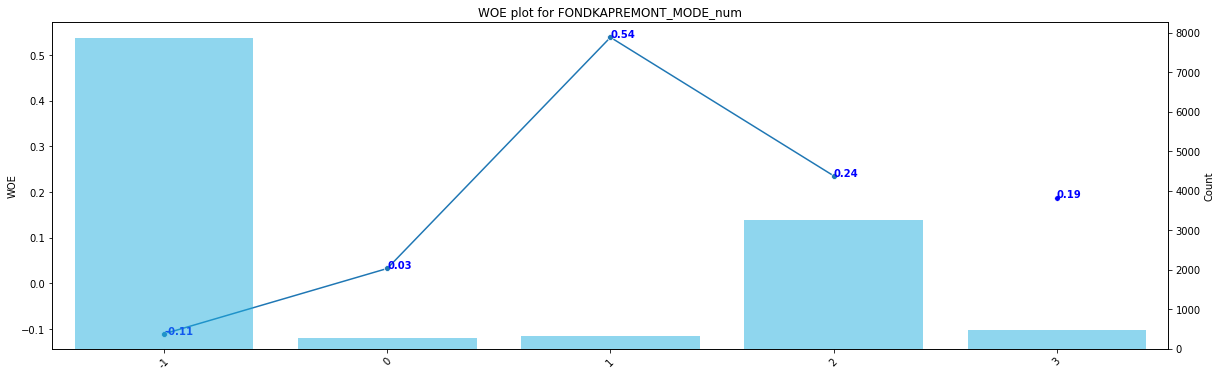

Mapping for HOUSETYPE_MODE:
nan: -1
block of flats: 0
terraced house: 2
specific housing: 1
Information Value: inf


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0        -1   5358     382        4976     0.532775         0.434547   
1         0   6709     331        6378     0.461646         0.556982   
2         1     52       4          48     0.005579         0.004192   
3         2     49       0          49     0.000000         0.004279   

        WOE        IV  
0 -0.203795  0.020018  
1  0.187735  0.017898  
2 -0.285850  0.000396  
3       inf       inf

IV for HOUSETYPE_MODE_num with 4 bins: inf


posx and posy should be finite values
posx and posy should be finite values


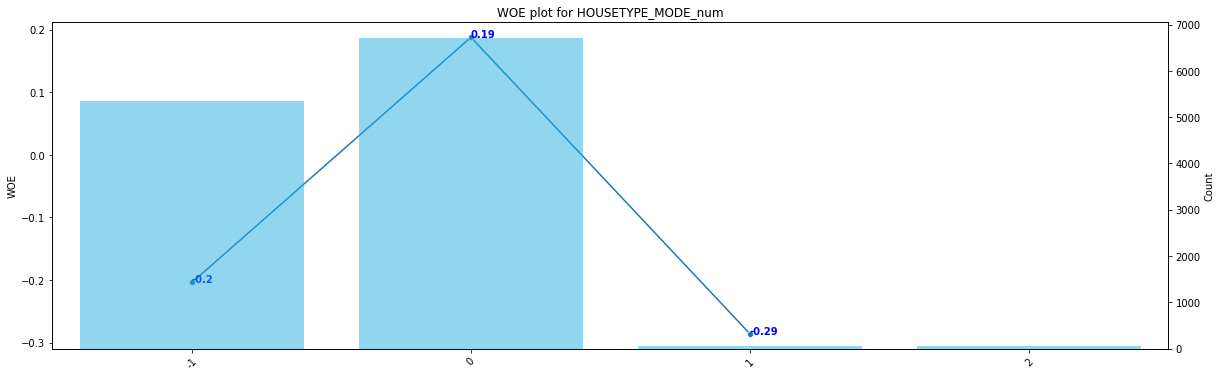

Information Value: 0.06872108426171139


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0   (-0.01, 0.009]    353      20         333     0.027894         0.029080   
1    (0.009, 0.02]    351      30         321     0.041841         0.028032   
2    (0.02, 0.033]    353      19         334     0.026499         0.029168   
3   (0.033, 0.042]    356      12         344     0.016736         0.030041   
4    (0.042, 0.05]    349      18         331     0.025105         0.028906   
5    (0.05, 0.055]    350      17         333     0.023710         0.029080   
6    (0.055, 0.06]    356      20         336     0.027894         0.029342   
7    (0.06, 0.067]    348      16         332     0.022315         0.028993   
8   (0.067, 0.073]    353      15         338     0.020921         0.029517   
9    (0.073, 0.08]    354      22         332     0.030683         0.028993   
10   (0.08, 0.091]    351      19         332     0.026499         0.028993   
11    (0.091, 0.1]    351      17         334     0.023710         0.029168   
12     (0.1, 0.12]    351      15         336     0.020921         0.029342   
13    (0.12, 0.15]    353      19         334     0.026499         0.029168   
14    (0.15, 0.17]    352      14         338     0.019526         0.029517   
15    (0.17, 0.19]    351      20         331     0.027894         0.028906   
16    (0.19, 0.22]    354      15         339     0.020921         0.029604   
17    (0.22, 0.27]    350      12         338     0.016736         0.029517   
18    (0.27, 0.36]    352      15         337     0.020921         0.029430   
19     (0.36, 1.0]    352      13         339     0.018131         0.029604   
20         Missing   5128     369        4759     0.514644         0.415597   

         WOE        IV  
0   0.041654  0.000049  
1  -0.400513  0.005530  
2   0.095946  0.000256  
3   0.584979  0.007783  
4   0.140990  0.000536  
5   0.204173  0.001097  
6   0.050622  0.000073  
7   0.261790  0.001748  
8   0.344239  0.002959  
9  -0.056664  0.000096  
10  0.089939  0.000224  
11  0.207171  0.001131  
12  0.338304  0.002849  
13  0.095946  0.000256  
14  0.413232  0.004129  
15  0.035630  0.000036  
16  0.347193  0.003015  
17  0.567383  0.007252  
18  0.341276  0.002904  
19  0.490294  0.005625  
20 -0.213760  0.021172

IV for TOTALAREA_MODE_num with 21 bins: 0.0687


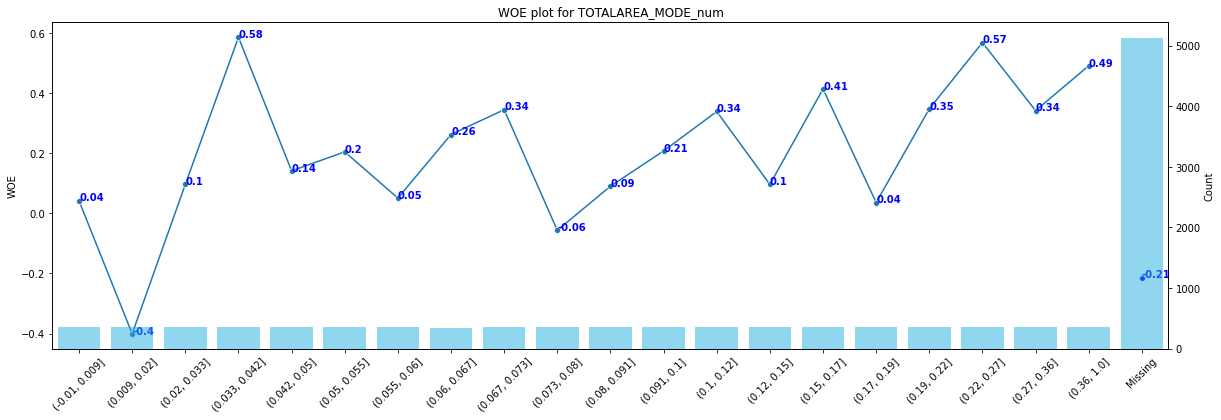

Mapping for WALLSMATERIAL_MODE:
nan: -1
Panel: 4
Stone, brick: 5
Block: 0
Monolithic: 2
Others: 3
Mixed: 1
Wooden: 6
Information Value: 0.05493240784913989


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0        -1   5437     387        5050     0.539749         0.441010   
1         0    388      17         371     0.023710         0.032399   
2         1    127       8         119     0.011158         0.010392   
3         2    149       7         142     0.009763         0.012401   
4         3     89       2          87     0.002789         0.007598   
5         4   3063     130        2933     0.181311         0.256135   
6         5   2771     156        2615     0.217573         0.228364   
7         6    144      10         134     0.013947         0.011702   

        WOE        IV  
0 -0.202038  0.019949  
1  0.312232  0.002713  
2 -0.071075  0.000054  
3  0.239160  0.000631  
4  1.002004  0.004818  
5  0.345490  0.025851  
6  0.048407  0.000522  
7 -0.175502  0.000394

IV for WALLSMATERIAL_MODE_num with 8 bins: 0.0549


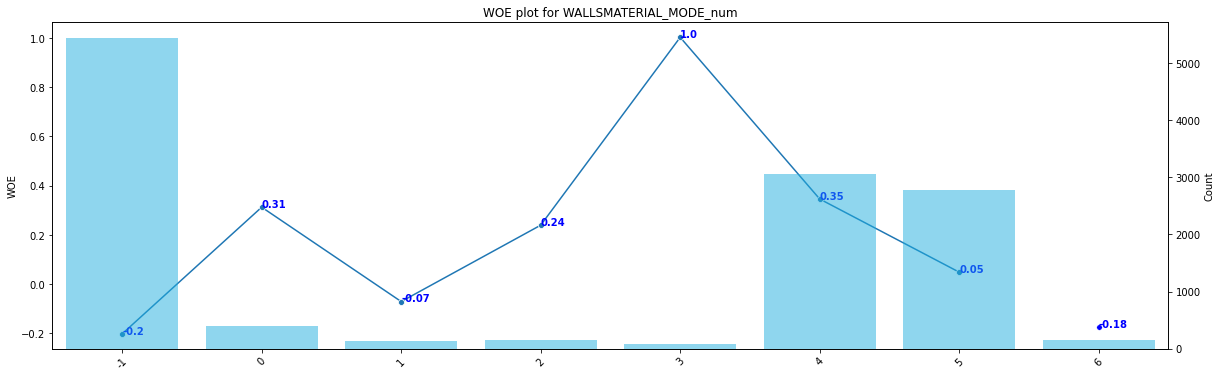

Mapping for EMERGENCYSTATE_MODE:
nan: -1
No: 0
Yes: 1
Information Value: 0.043141201405790516


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0        -1   5045     367        4678     0.511855         0.408523   
1         0   7062     347        6715     0.483961         0.586412   
2         1     61       3          58     0.004184         0.005065   

        WOE        IV  
0 -0.225492  0.023301  
1  0.192018  0.019672  
2  0.191074  0.000168

IV for EMERGENCYSTATE_MODE_num with 3 bins: 0.0431


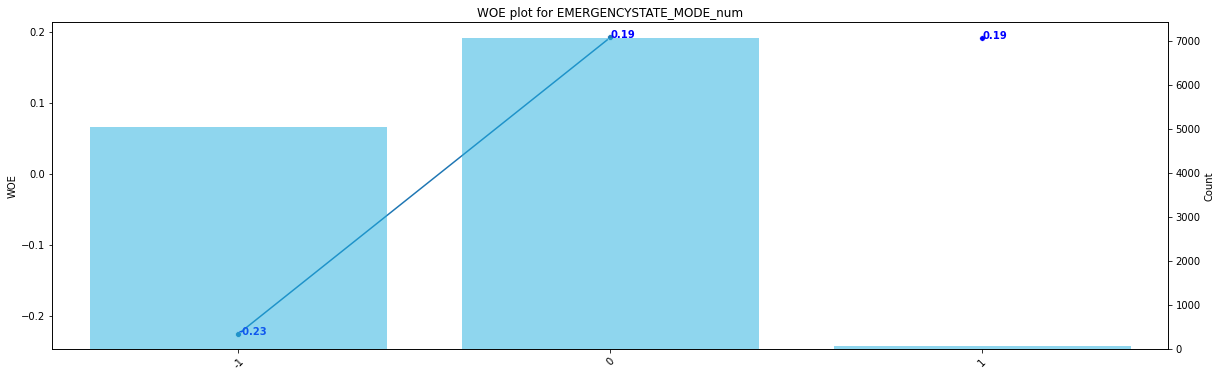

Information Value: inf


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0  (-1.0, 1.0]   8467     451        8016     0.629010         0.700026   
1   (1.0, 2.0]   1094      79        1015     0.110181         0.088639   
2   (2.0, 3.0]    846      69         777     0.096234         0.067854   
3   (3.0, 4.0]    546      38         508     0.052999         0.044363   
4   (4.0, 6.0]    642      38         604     0.052999         0.052746   
5  (6.0, 22.0]    530      42         488     0.058577         0.042616   
6      Missing     43       0          43     0.000000         0.003755   

        WOE        IV  
0  0.106971  0.007597  
1 -0.217560  0.004687  
2 -0.349423  0.009917  
3 -0.177861  0.001536  
4 -0.004768  0.000001  
5 -0.318111  0.005077  
6       inf       inf

IV for OBS_30_CNT_SOCIAL_CIRCLE_num with 7 bins: inf


posx and posy should be finite values
posx and posy should be finite values


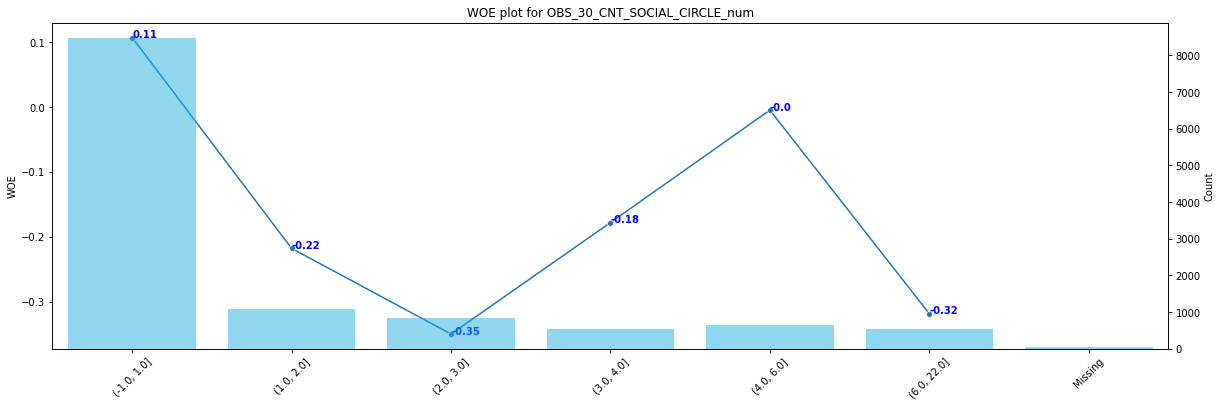

Information Value: inf


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0  (-1.0, 1.0]  11933     704       11229     0.981869         0.980613   
1   (1.0, 5.0]    192      13         179     0.018131         0.015632   
2      Missing     43       0          43     0.000000         0.003755   

       WOE        IV  
0 -0.00128  0.000002  
1 -0.14832  0.000371  
2      inf       inf

IV for DEF_30_CNT_SOCIAL_CIRCLE_num with 3 bins: inf


posx and posy should be finite values
posx and posy should be finite values


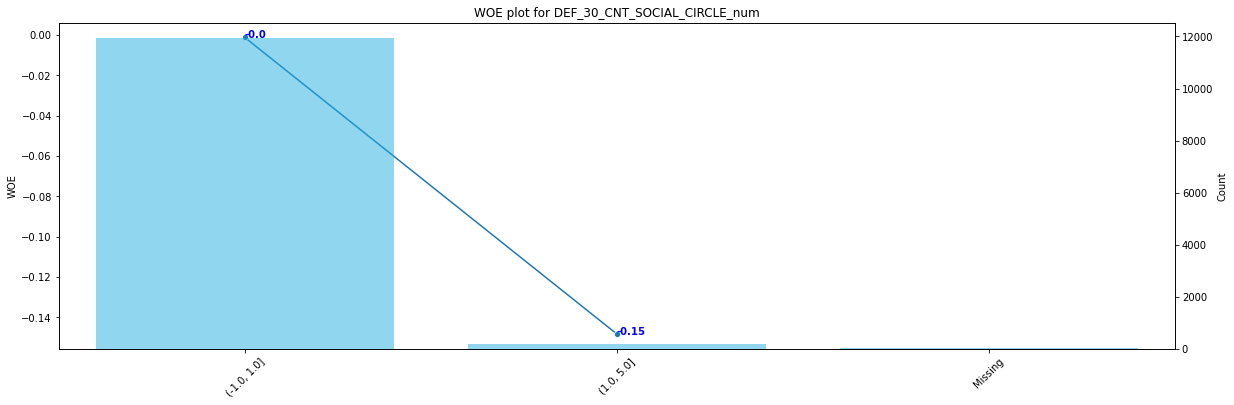

Information Value: 0.06502664089099414


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0   (-3927.0, -2737.0]    609      26         583     0.036262   
1   (-2737.0, -2403.0]    609      28         581     0.039052   
2   (-2403.0, -2105.0]    608      27         581     0.037657   
3   (-2105.0, -1901.0]    609      31         578     0.043236   
4   (-1901.0, -1748.0]    609      34         575     0.047420   
5   (-1748.0, -1626.0]    609      42         567     0.058577   
6   (-1626.0, -1510.0]    612      31         581     0.043236   
7   (-1510.0, -1336.0]    603      20         583     0.027894   
8   (-1336.0, -1141.0]    609      42         567     0.058577   
9    (-1141.0, -964.0]    607      26         581     0.036262   
10    (-964.0, -815.0]    609      32         577     0.044630   
11    (-815.0, -686.0]    611      53         558     0.073919   
12    (-686.0, -569.0]    605      49         556     0.068340   
13    (-569.0, -457.0]    611      33         578     0.046025   
14    (-457.0, -336.0]    606      41         565     0.057183   
15    (-336.0, -203.0]    611      48         563     0.066946   
16      (-203.0, -9.0]    613      32         581     0.044630   
17         (-9.0, 0.0]   1818     122        1696     0.170153   

    %_of_Non_Events       WOE        IV  
0          0.050913  0.339334  0.004971  
1          0.050738  0.261790  0.003059  
2          0.050738  0.298157  0.003900  
3          0.050476  0.154830  0.001121  
4          0.050214  0.057253  0.000160  
5          0.049515 -0.168067  0.001523  
6          0.050738  0.160007  0.001200  
7          0.050913  0.601698  0.013850  
8          0.049515 -0.168067  0.001523  
9          0.050738  0.335898  0.004862  
10         0.050389  0.121350  0.000699  
11         0.048729 -0.416689  0.010496  
12         0.048555 -0.341809  0.006763  
13         0.050476  0.092310  0.000411  
14         0.049341 -0.147503  0.001157  
15         0.049166 -0.308678  0.005488  
16         0.050738  0.128258  0.000783  
17         0.148109 -0.138750  0.003059

IV for DAYS_LAST_PHONE_CHANGE_num with 18 bins: 0.065


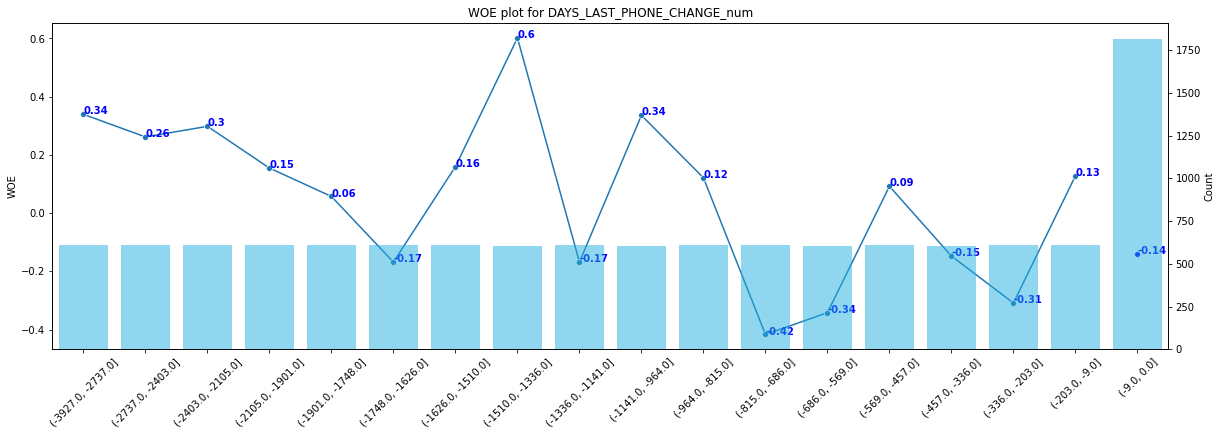

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE   IV
0   Missing  12168     717       11451          1.0              1.0  0.0  0.0

IV for FLAG_DOCUMENT_2_num with 1 bins: 0.0


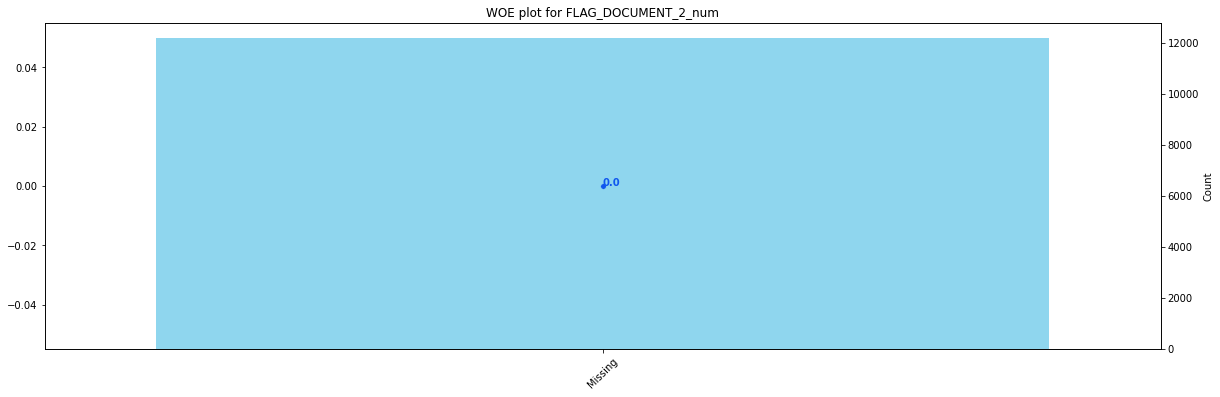

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_3_num with 1 bins: 0.0


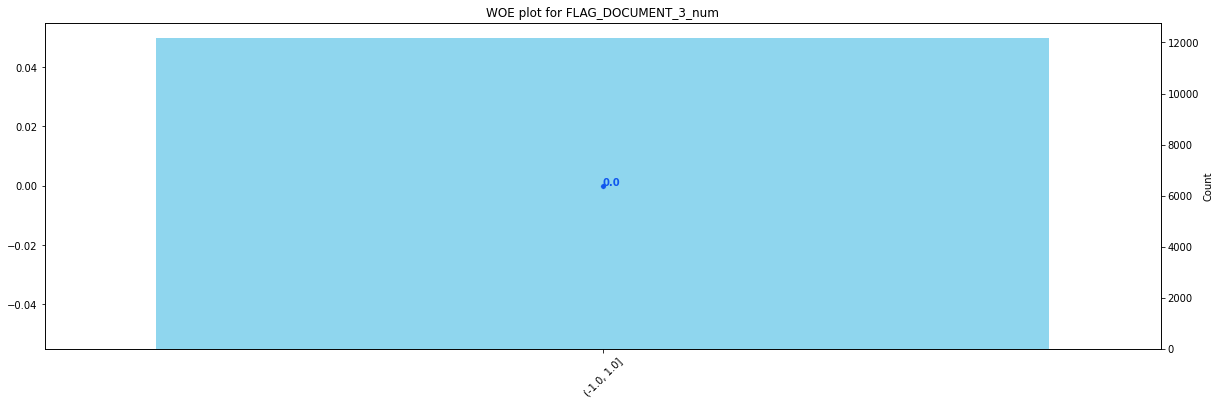

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE   IV
0   Missing  12168     717       11451          1.0              1.0  0.0  0.0

IV for FLAG_DOCUMENT_4_num with 1 bins: 0.0


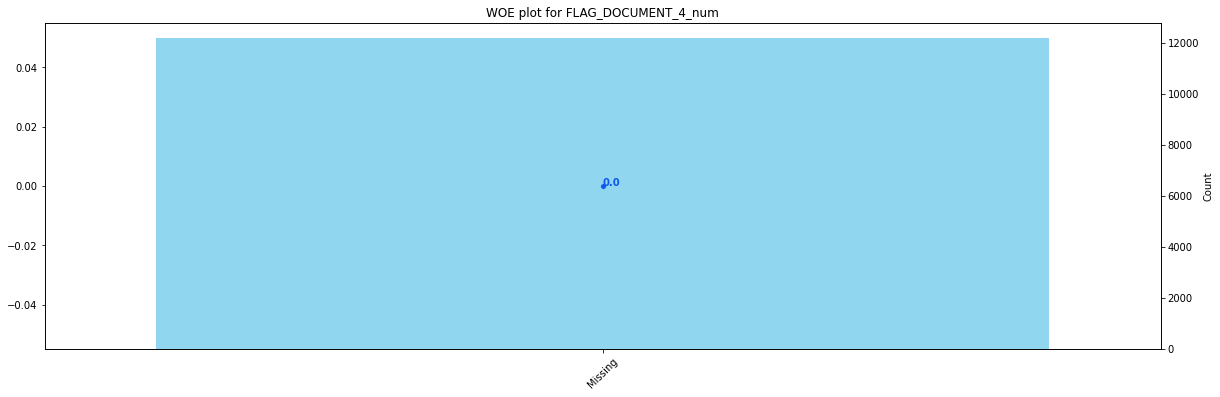

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_5_num with 1 bins: 0.0


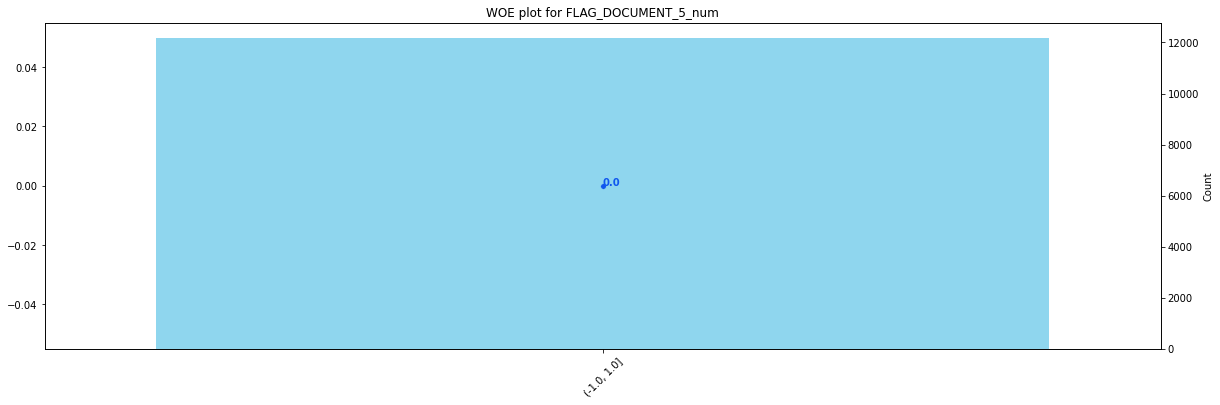

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_6_num with 1 bins: 0.0


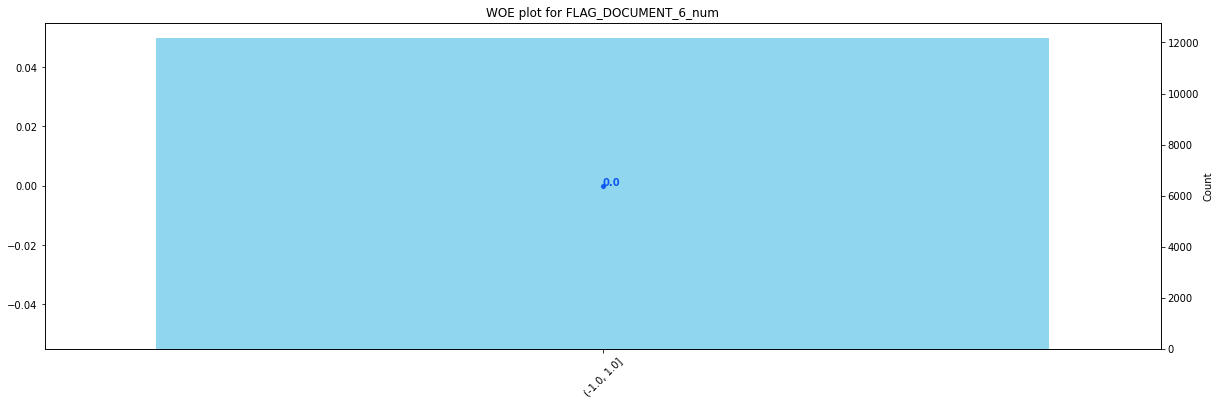

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_7_num with 1 bins: 0.0


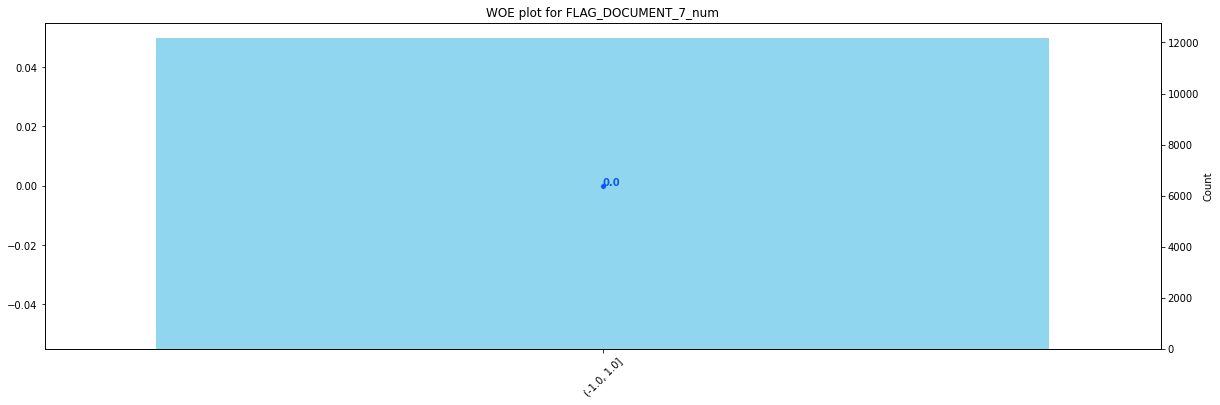

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_8_num with 1 bins: 0.0


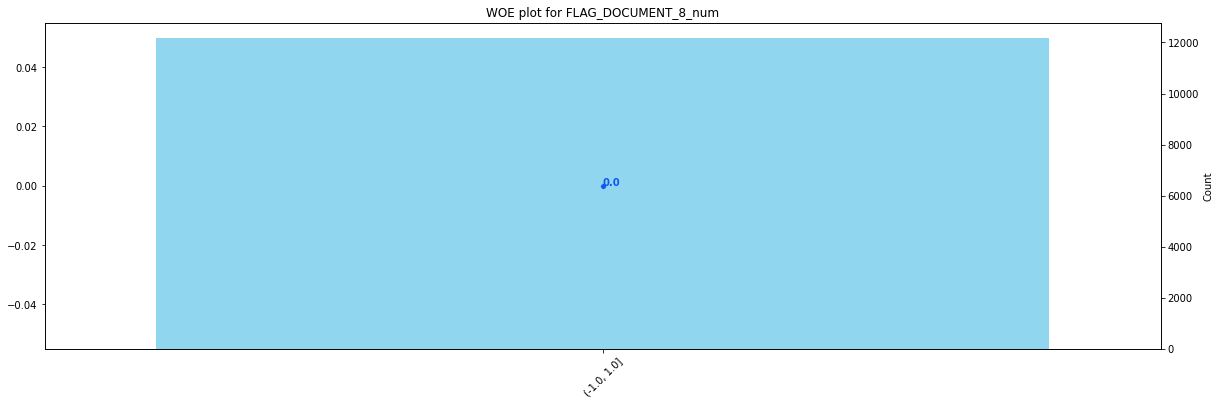

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_9_num with 1 bins: 0.0


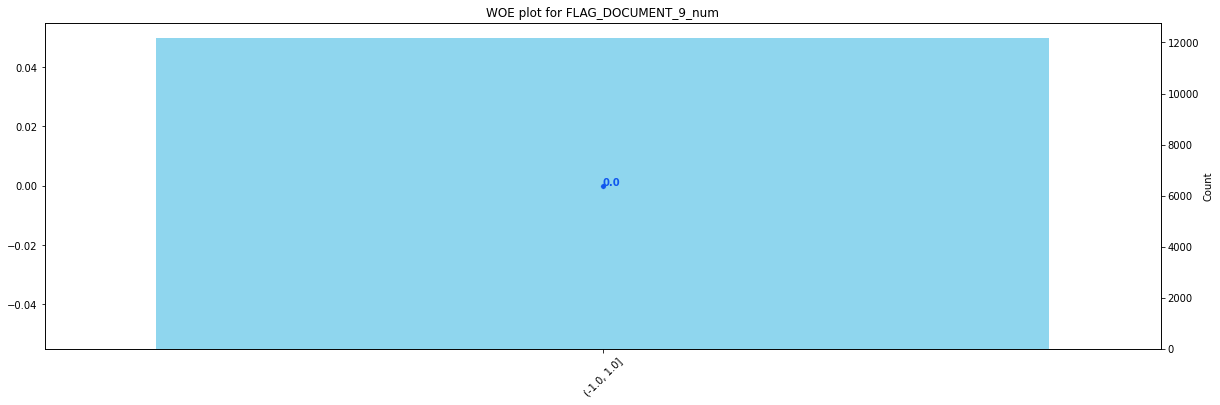

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_10_num with 1 bins: 0.0


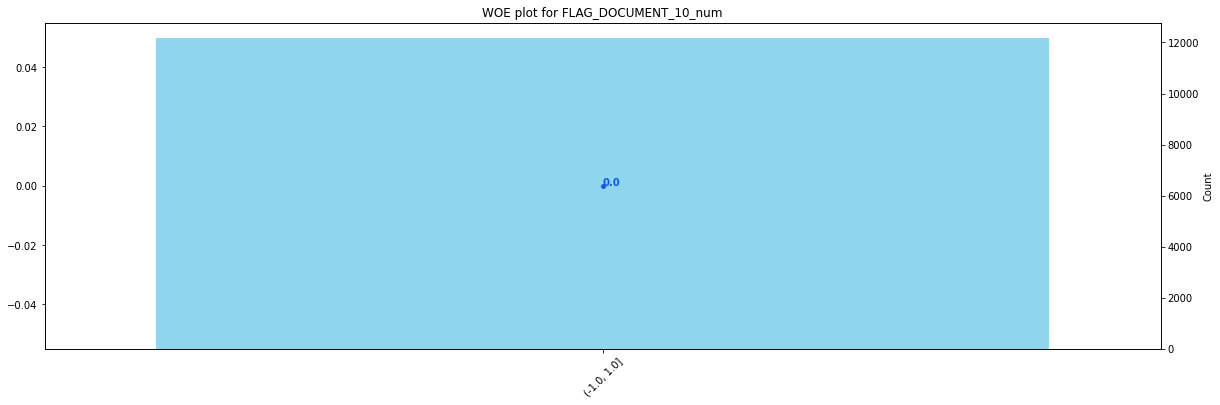

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_11_num with 1 bins: 0.0


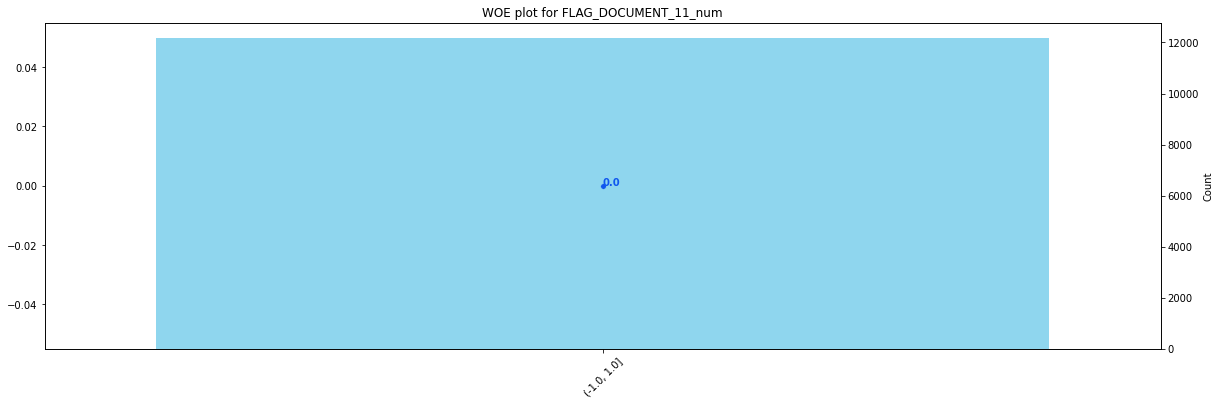

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE   IV
0   Missing  12168     717       11451          1.0              1.0  0.0  0.0

IV for FLAG_DOCUMENT_12_num with 1 bins: 0.0


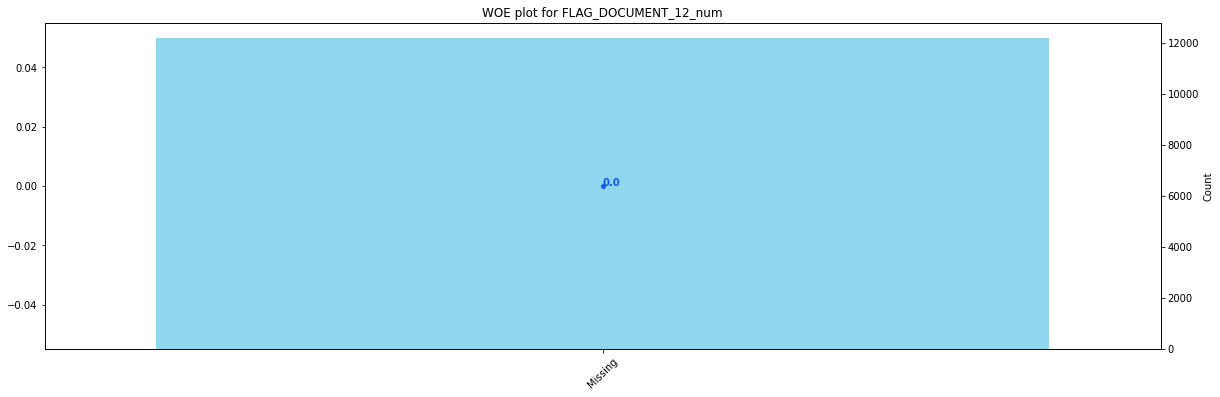

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_13_num with 1 bins: 0.0


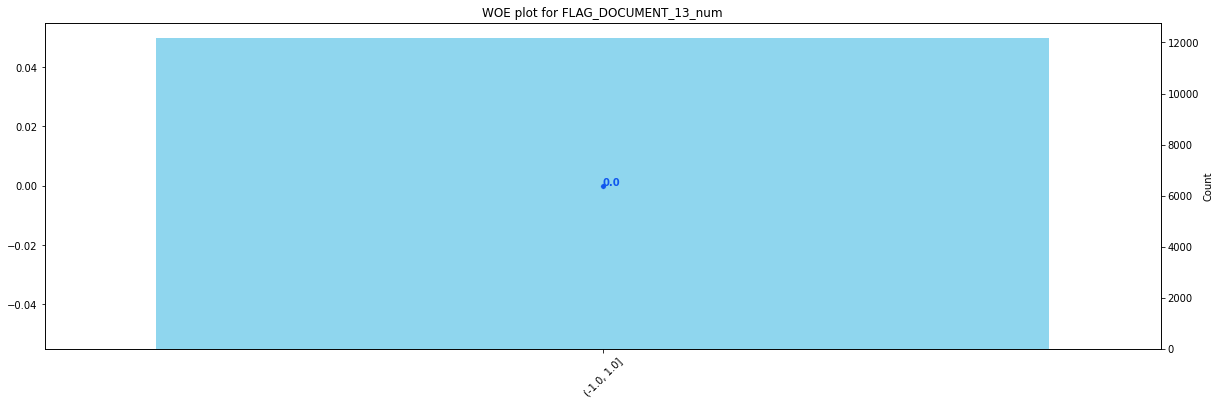

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_14_num with 1 bins: 0.0


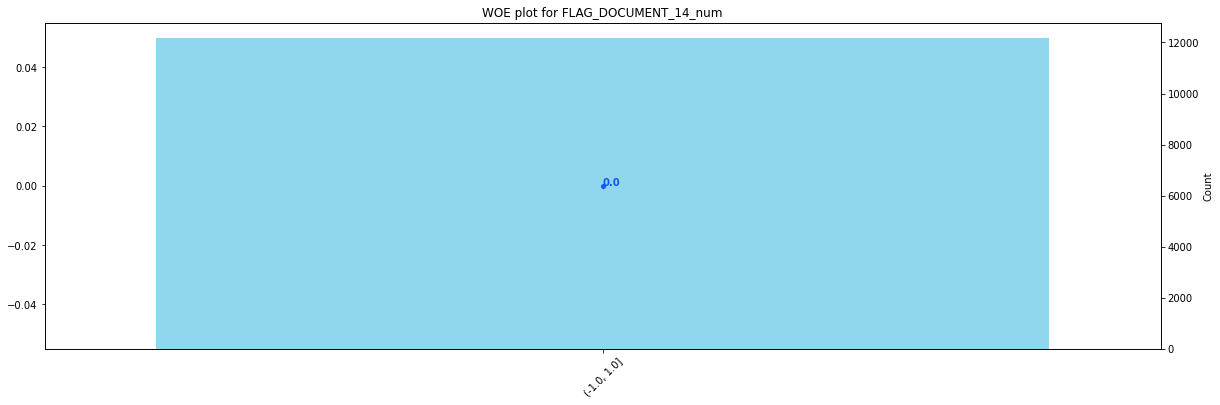

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_15_num with 1 bins: 0.0


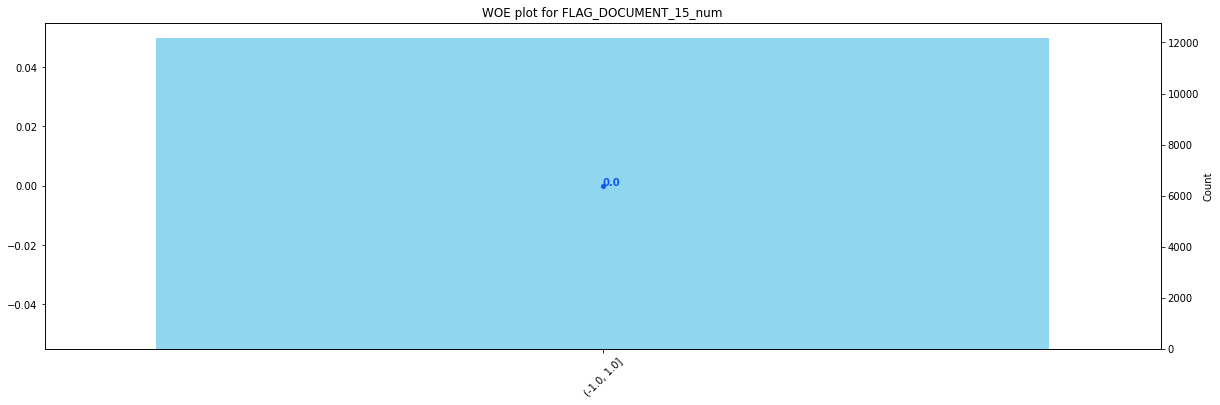

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_16_num with 1 bins: 0.0


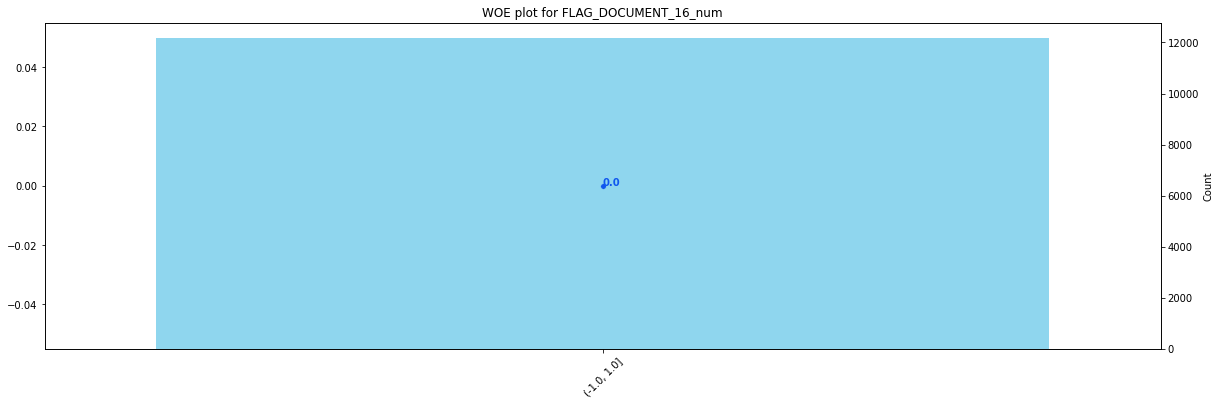

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE   IV
0   Missing  12168     717       11451          1.0              1.0  0.0  0.0

IV for FLAG_DOCUMENT_17_num with 1 bins: 0.0


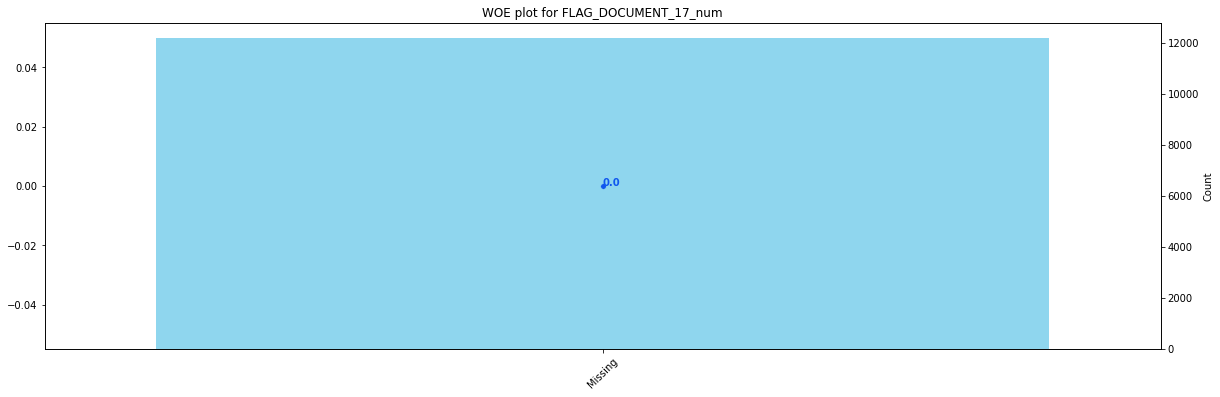

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_18_num with 1 bins: 0.0


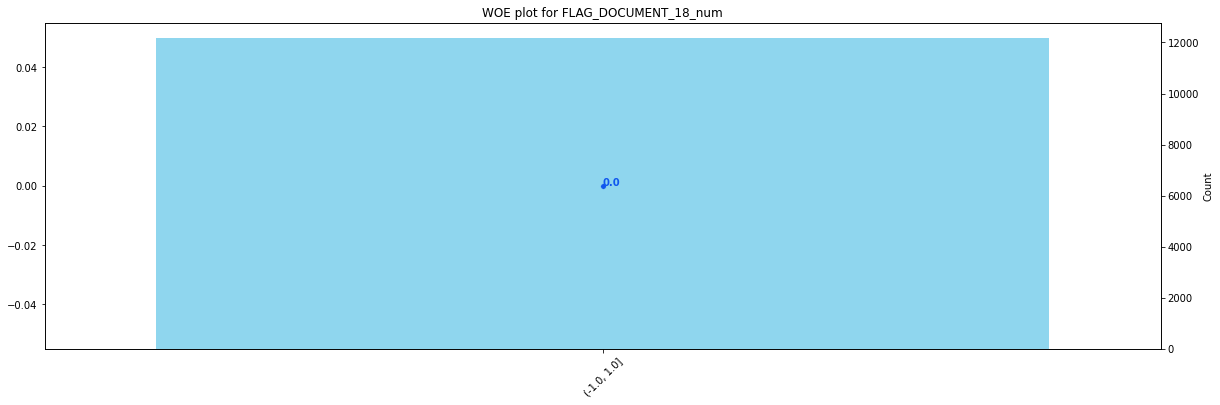

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_19_num with 1 bins: 0.0


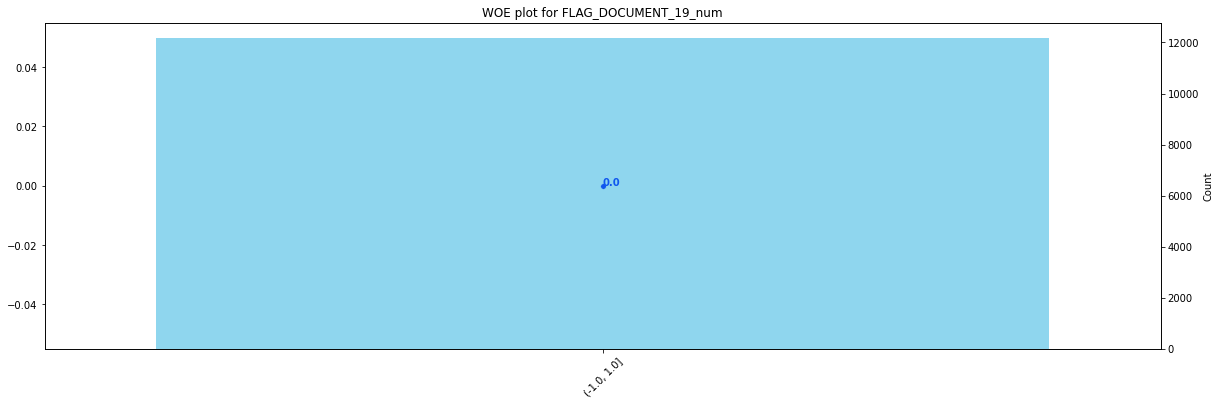

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_20_num with 1 bins: 0.0


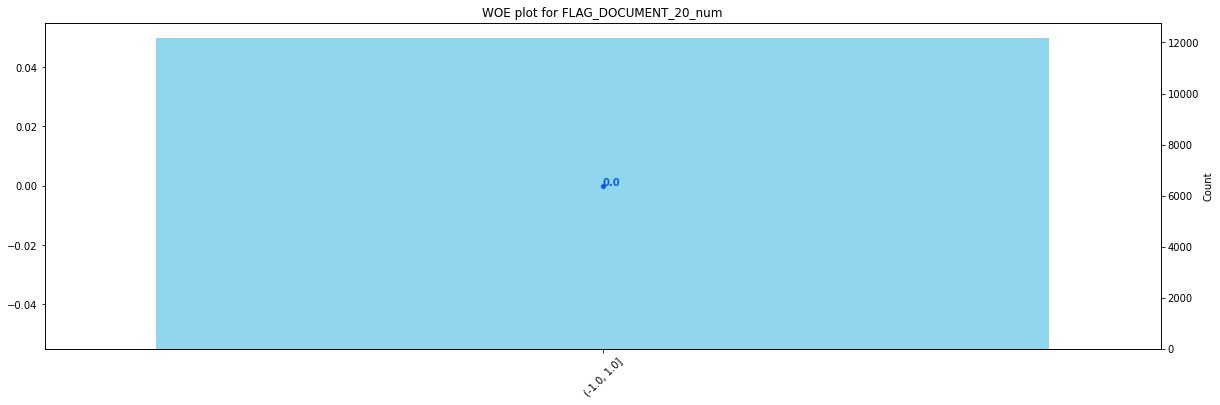

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 1.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for FLAG_DOCUMENT_21_num with 1 bins: 0.0


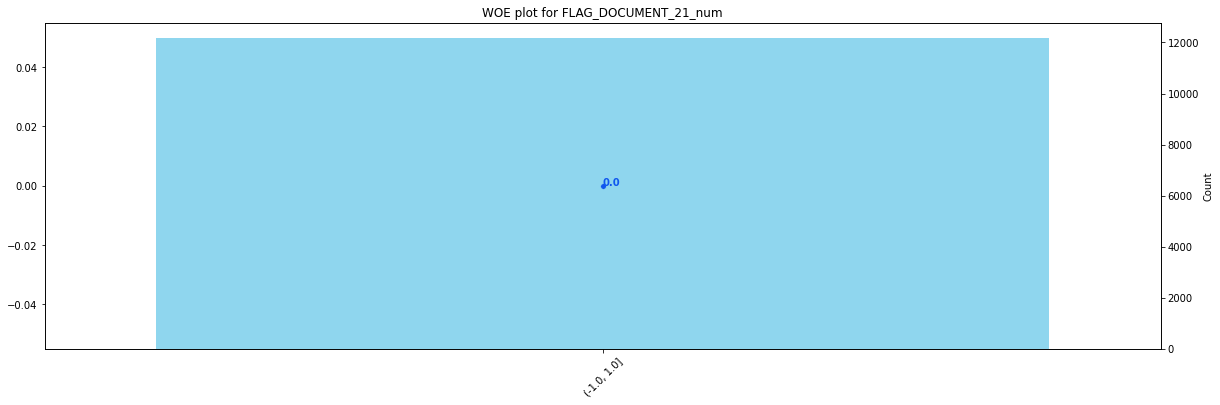

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 3.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for AMT_REQ_CREDIT_BUREAU_HOUR_num with 1 bins: 0.0


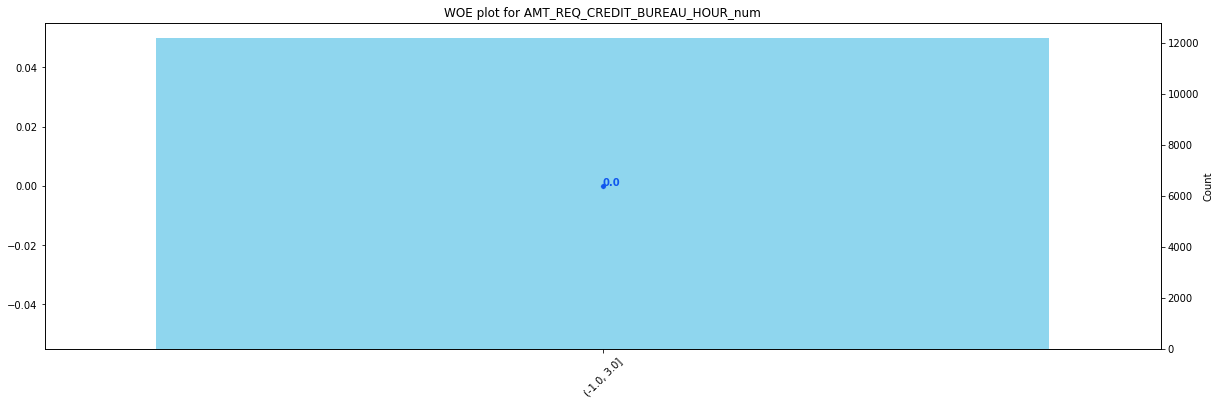

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 9.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for AMT_REQ_CREDIT_BUREAU_DAY_num with 1 bins: 0.0


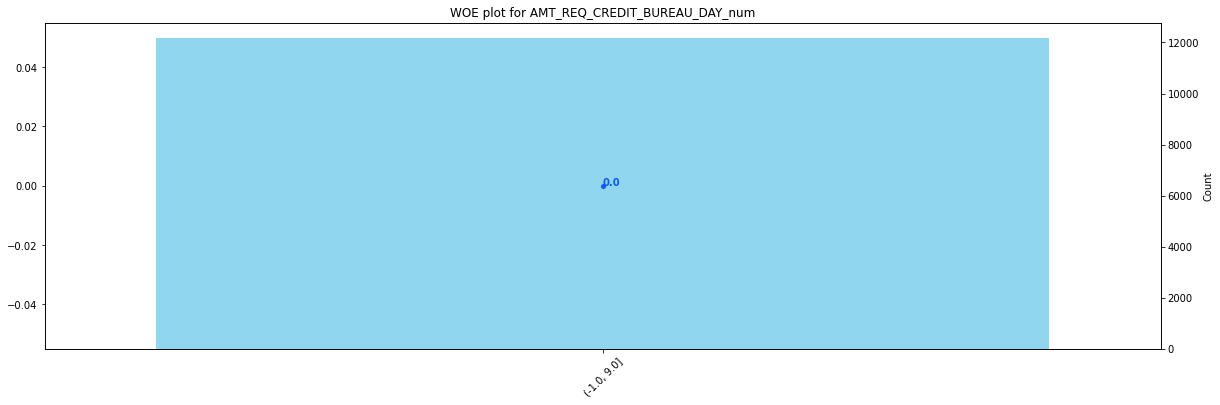

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 8.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for AMT_REQ_CREDIT_BUREAU_WEEK_num with 1 bins: 0.0


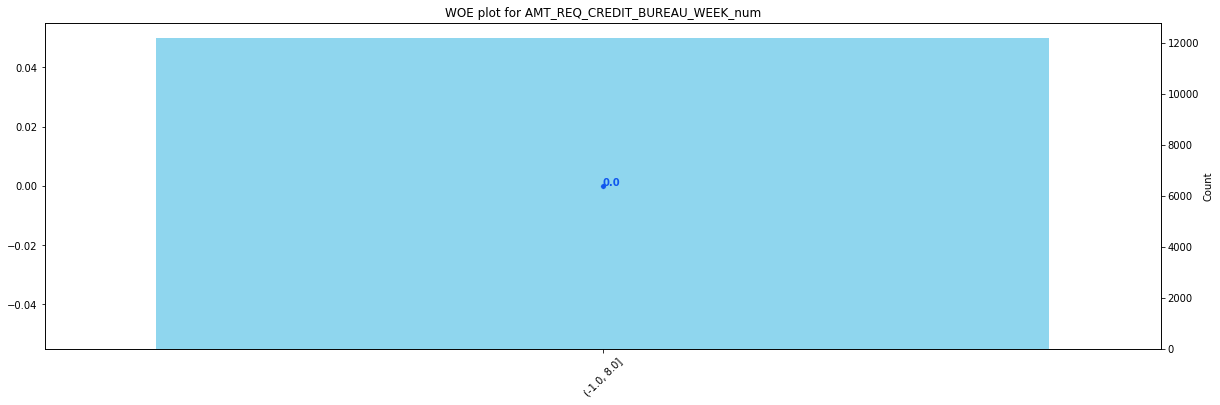

Information Value: 0.001751036126289642


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0  (-1.0, 1.0]  11373     676       10697     0.942817         0.934154   
1   (1.0, 2.0]    375      21         354     0.029289         0.030914   
2  (2.0, 23.0]    420      20         400     0.027894         0.034931   

        WOE        IV  
0 -0.009231  0.000080  
1  0.054018  0.000088  
2  0.224976  0.001583

IV for AMT_REQ_CREDIT_BUREAU_MON_num with 3 bins: 0.0018


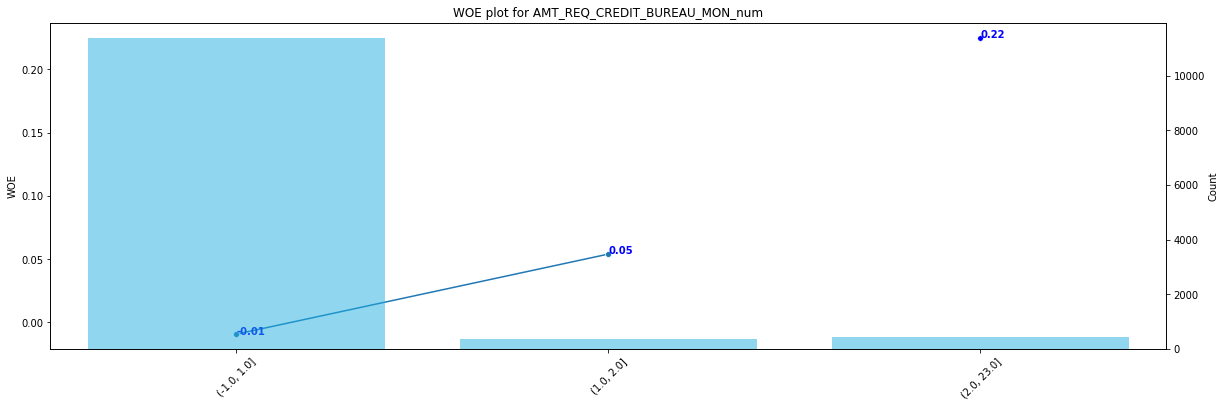

Information Value: 0.003714331575980544


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0  (-1.0, 1.0]  11439     678       10761     0.945607         0.939743   
1   (1.0, 2.0]    638      31         607     0.043236         0.053008   
2   (2.0, 8.0]     91       8          83     0.011158         0.007248   

        WOE        IV  
0 -0.006220  0.000036  
1  0.203785  0.001992  
2 -0.431357  0.001686

IV for AMT_REQ_CREDIT_BUREAU_QRT_num with 3 bins: 0.0037


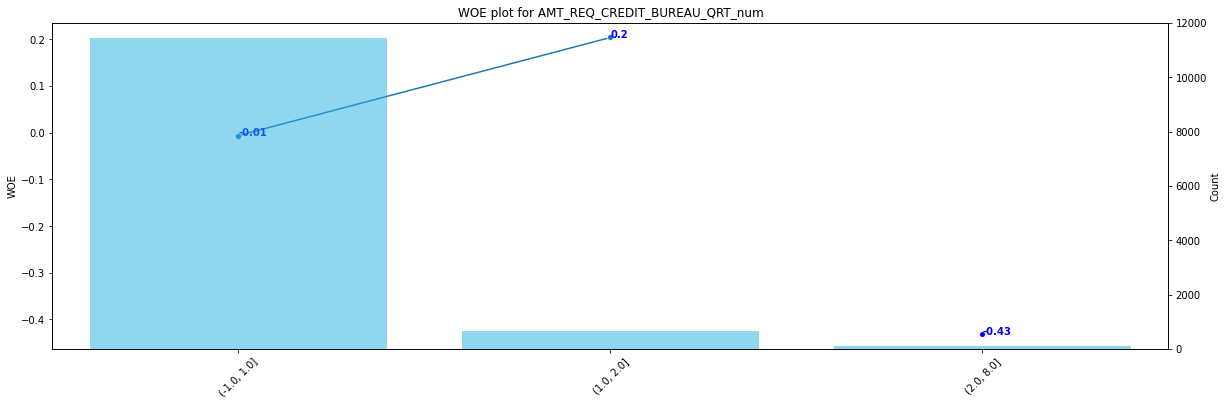

Information Value: 0.012188723959677064


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0  (-1.0, 1.0]   6441     354        6087     0.493724         0.531569   
1   (1.0, 2.0]   2221     124        2097     0.172943         0.183128   
2   (2.0, 3.0]   1556     100        1456     0.139470         0.127150   
3   (3.0, 4.0]    909      62         847     0.086471         0.073967   
4   (4.0, 5.0]    486      35         451     0.048815         0.039385   
5  (5.0, 12.0]    555      42         513     0.058577         0.044800   

        WOE        IV  
0  0.073857  0.002795  
1  0.057225  0.000583  
2 -0.092478  0.001139  
3 -0.156190  0.001953  
4 -0.214637  0.002024  
5 -0.268150  0.003695

IV for AMT_REQ_CREDIT_BUREAU_YEAR_num with 6 bins: 0.0122


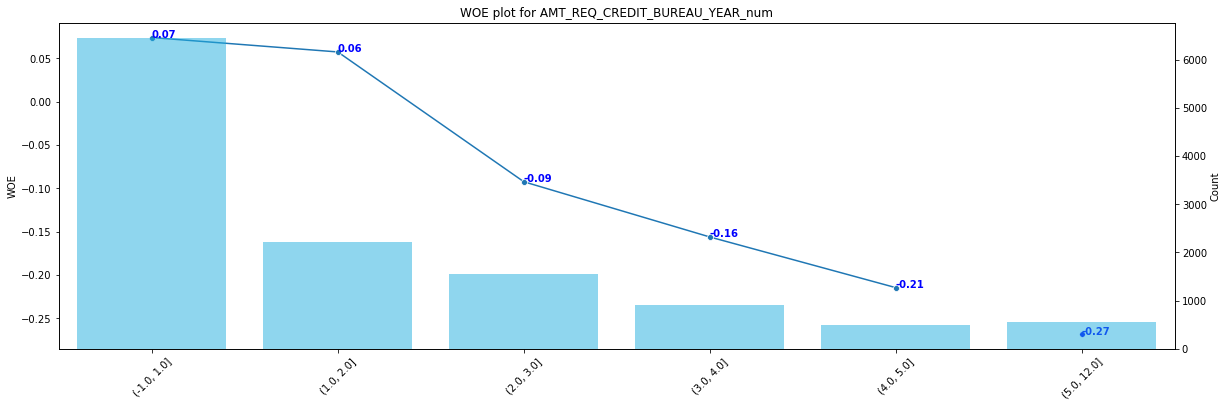

Information Value: 0.10201081847938778


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0   (0.0, 2.0]   5792     293        5499     0.408647         0.480220   
1   (2.0, 3.0]   2055     141        1914     0.196653         0.167147   
2   (3.0, 4.0]   1298      98        1200     0.136681         0.104794   
3   (4.0, 5.0]    686      45         641     0.062762         0.055978   
4   (5.0, 6.0]    357      34         323     0.047420         0.028207   
5  (6.0, 23.0]    354      48         306     0.066946         0.026723   
6      Missing   1626      58        1568     0.080893         0.136931   

        WOE        IV  
0  0.161392  0.011551  
1 -0.162566  0.004797  
2 -0.265647  0.008470  
3 -0.114390  0.000776  
4 -0.519465  0.009980  
5 -0.918372  0.036940  
6  0.526357  0.029496

IV for CREDIT_ACTIVE_Active_num with 7 bins: 0.102


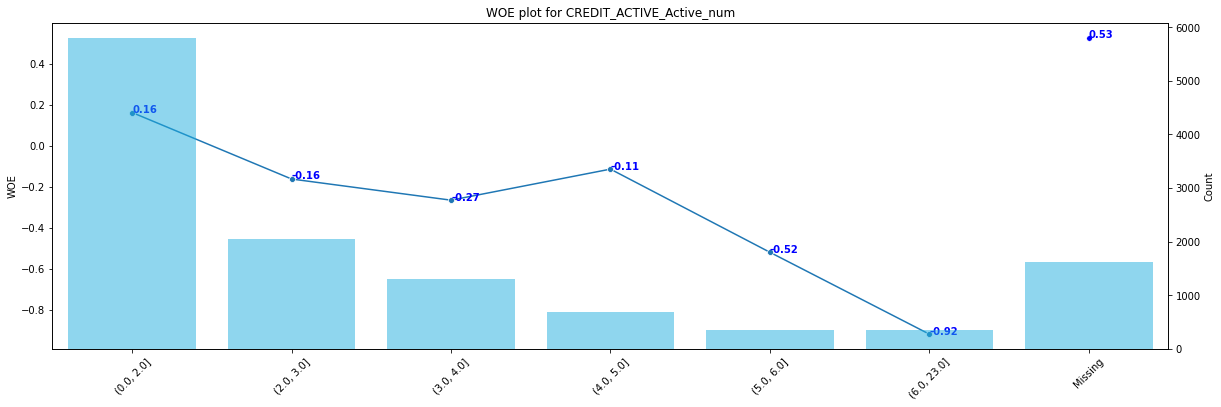

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE   IV
0   Missing  12168     717       11451          1.0              1.0  0.0  0.0

IV for CREDIT_ACTIVE_Bad debt_num with 1 bins: 0.0


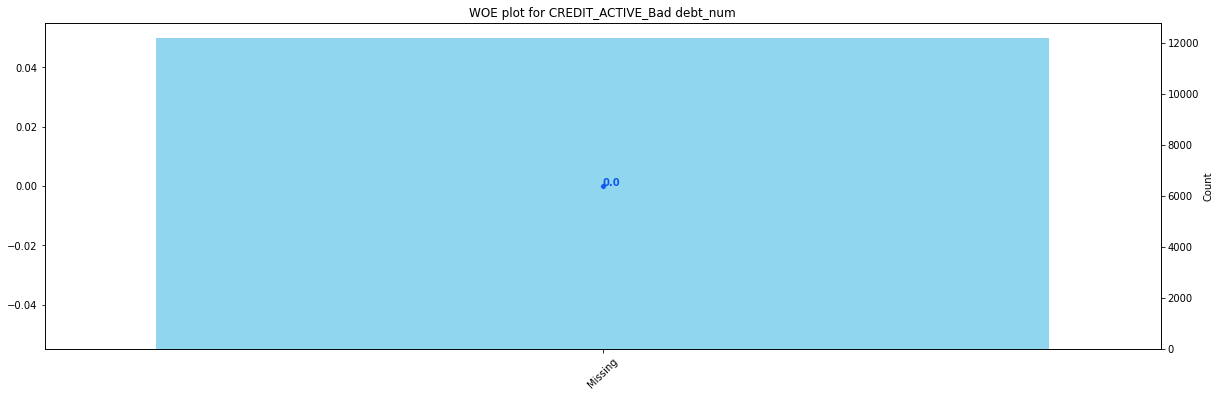

Information Value: 0.013290338204906587


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0     (0.0, 2.0]   3765     214        3551     0.298466         0.310104   
1     (2.0, 3.0]   1652      88        1564     0.122734         0.136582   
2     (3.0, 4.0]   1447      89        1358     0.124128         0.118592   
3     (4.0, 5.0]   1067      56        1011     0.078103         0.088289   
4     (5.0, 6.0]    852      56         796     0.078103         0.069514   
5     (6.0, 7.0]    667      40         627     0.055788         0.054755   
6     (7.0, 8.0]    473      29         444     0.040446         0.038774   
7     (8.0, 9.0]    344      20         324     0.027894         0.028294   
8    (9.0, 11.0]    508      34         474     0.047420         0.041394   
9   (11.0, 48.0]    541      26         515     0.036262         0.044974   
10       Missing    852      65         787     0.090656         0.068728   

         WOE        IV  
0   0.038252  0.000445  
1   0.106909  0.001481  
2  -0.045625  0.000253  
3   0.122587  0.001249  
4  -0.116509  0.001001  
5  -0.018689  0.000019  
6  -0.042228  0.000071  
7   0.014255  0.000006  
8  -0.135910  0.000819  
9   0.215314  0.001876  
10 -0.276916  0.006072

IV for CREDIT_ACTIVE_Closed_num with 11 bins: 0.0133


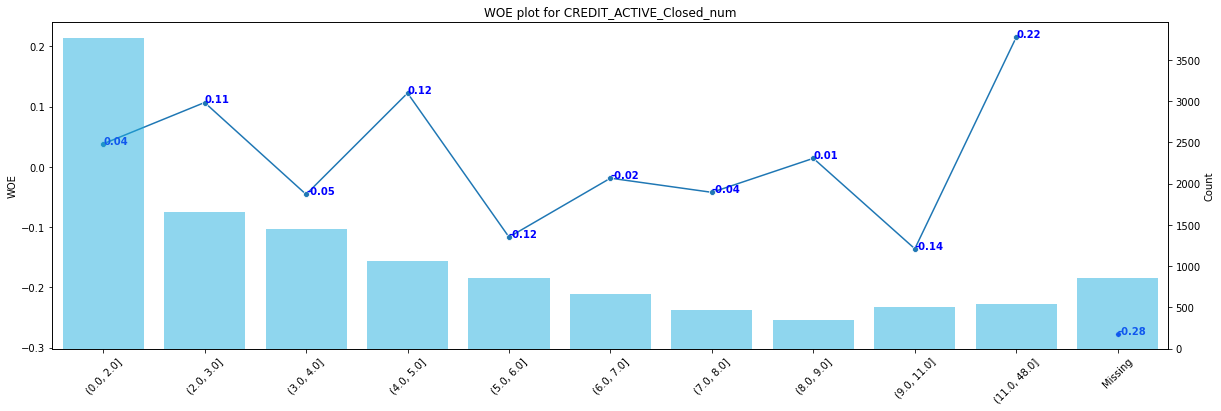

Information Value: inf


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0  (0.0, 2.0]    463      36         427     0.050209         0.037289   
1  (2.0, 5.0]      3       0           3     0.000000         0.000262   
2     Missing  11702     681       11021     0.949791         0.962449   

        WOE        IV  
0 -0.297491  0.003844  
1       inf       inf  
2  0.013239  0.000168

posx and posy should be finite values


IV for CREDIT_ACTIVE_Sold_num with 3 bins: inf


posx and posy should be finite values


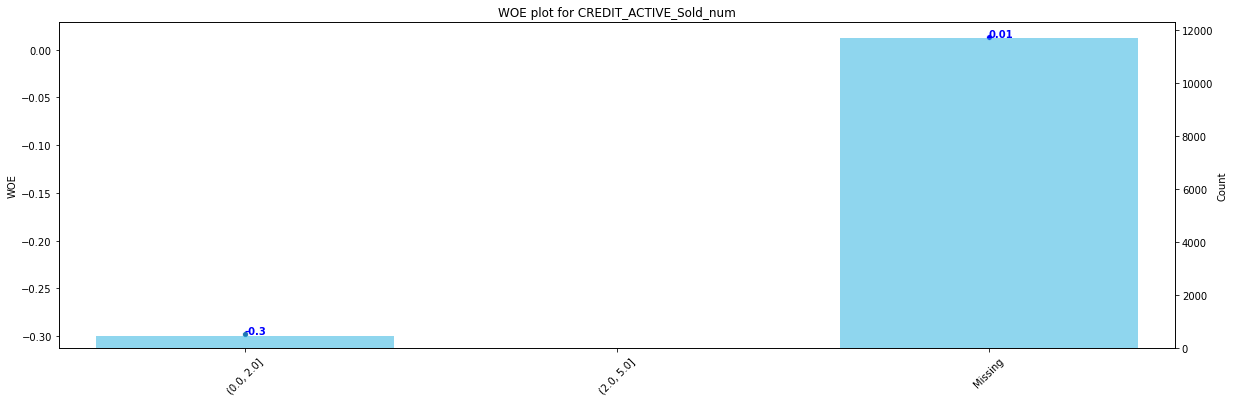

Information Value: inf


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0  (0.0, 2.0]    237       9         228     0.012552         0.019911   
1  (2.0, 4.0]      7       0           7     0.000000         0.000611   
2     Missing  11924     708       11216     0.987448         0.979478   

        WOE        IV  
0  0.461365  0.003395  
1       inf       inf  
2 -0.008104  0.000065

IV for CREDIT_CURRENCY_2_num with 3 bins: inf


posx and posy should be finite values
posx and posy should be finite values


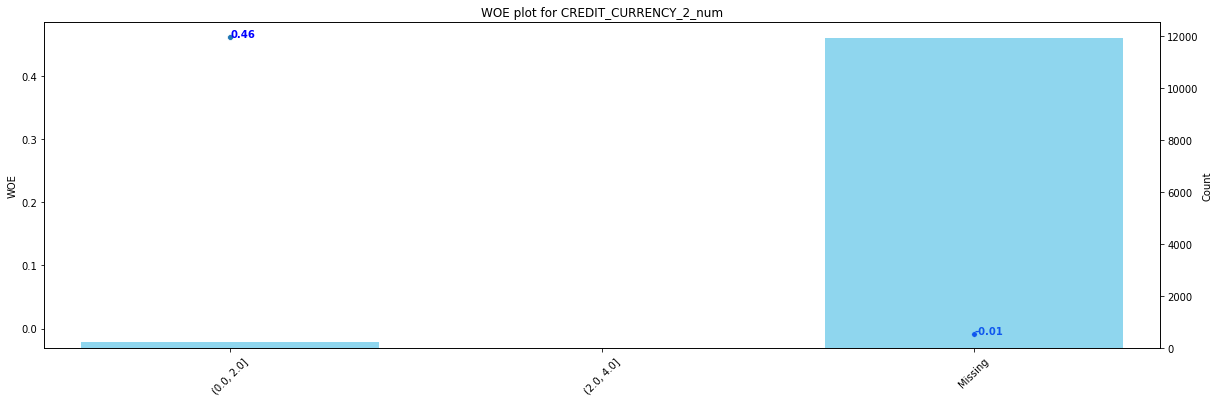

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE   IV
0   Missing  12168     717       11451          1.0              1.0  0.0  0.0

IV for CREDIT_CURRENCY_4_num with 1 bins: 0.0


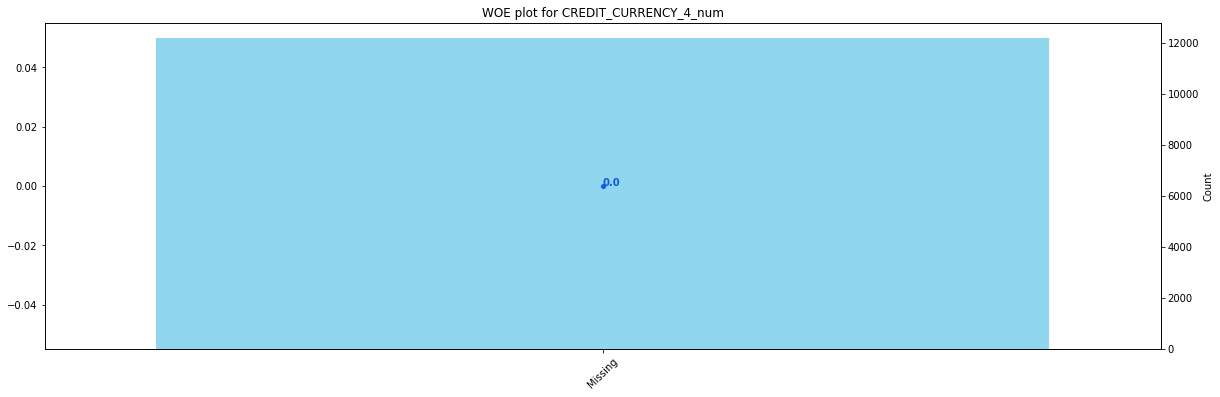

Information Value: 0.10543853411262472


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0   (-2921.0, -1519.0]    528      15         513     0.020921   
1   (-1519.0, -1278.0]    527      22         505     0.030683   
2   (-1278.0, -1119.0]    527      22         505     0.030683   
3   (-1119.0, -1011.0]    527      24         503     0.033473   
4    (-1011.0, -921.0]    527      28         499     0.039052   
5     (-921.0, -842.0]    531      31         500     0.043236   
6     (-842.0, -776.0]    529      33         496     0.046025   
7     (-776.0, -715.0]    523      33         490     0.046025   
8     (-715.0, -664.0]    527      38         489     0.052999   
9     (-664.0, -616.0]    526      30         496     0.041841   
10    (-616.0, -566.0]    528      39         489     0.054393   
11    (-566.0, -521.0]    525      26         499     0.036262   
12    (-521.0, -469.0]    528      41         487     0.057183   
13    (-469.0, -424.0]    528      46         482     0.064156   
14    (-424.0, -378.0]    525      26         499     0.036262   
15    (-378.0, -337.0]    528      43         485     0.059972   
16    (-337.0, -282.0]    526      39         487     0.054393   
17    (-282.0, -221.0]    530      38         492     0.052999   
18    (-221.0, -148.0]    525      41         484     0.057183   
19      (-148.0, -3.0]    527      44         483     0.061367   
20             Missing   1626      58        1568     0.080893   

    %_of_Non_Events       WOE        IV  
0          0.044800  0.761469  0.018183  
1          0.044101  0.362759  0.004867  
2          0.044101  0.362759  0.004867  
3          0.043926  0.271780  0.002841  
4          0.043577  0.109645  0.000496  
5          0.043664  0.009864  0.000004  
6          0.043315 -0.060688  0.000164  
7          0.042791 -0.072859  0.000236  
8          0.042704 -0.215980  0.002223  
9          0.043315  0.034622  0.000051  
10         0.042704 -0.241956  0.002828  
11         0.043577  0.183753  0.001344  
12         0.042529 -0.296064  0.004338  
13         0.042092 -0.421454  0.009299  
14         0.043577  0.183753  0.001344  
15         0.042354 -0.347808  0.006128  
16         0.042529 -0.246054  0.002919  
17         0.042966 -0.209864  0.002106  
18         0.042267 -0.302244  0.004508  
19         0.042180 -0.374929  0.007194  
20         0.136931  0.526357  0.029496

IV for DAYS_CREDIT_Active_mean_num with 21 bins: 0.1054


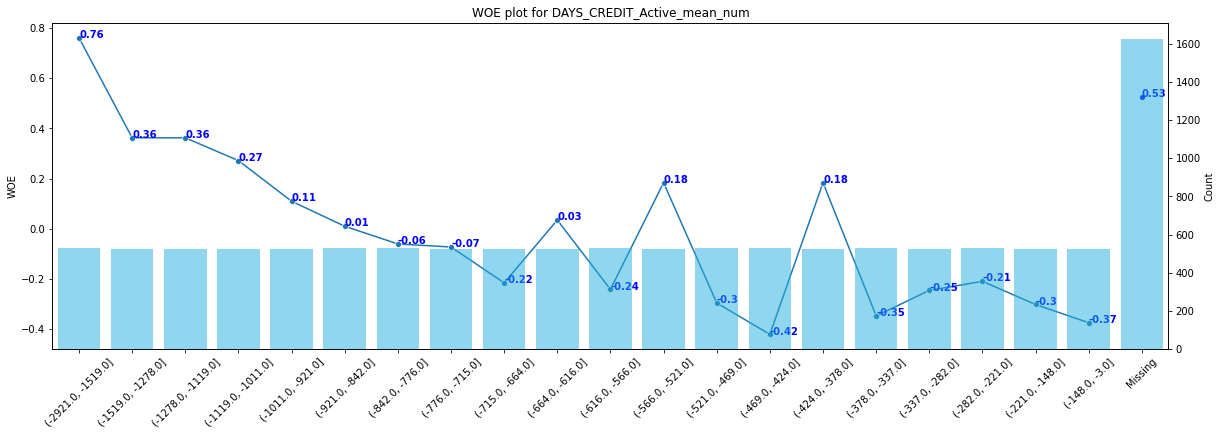

Information Value: inf


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0   (-2922.0, -2682.0]     24       2          22     0.002789   
1   (-2682.0, -2524.0]     23       1          22     0.001395   
2   (-2524.0, -2443.0]     24       1          23     0.001395   
3   (-2443.0, -2309.0]     23       0          23     0.000000   
4   (-2309.0, -2198.0]     23       1          22     0.001395   
5   (-2198.0, -2046.0]     23       2          21     0.002789   
6   (-2046.0, -1795.0]     24       1          23     0.001395   
7   (-1795.0, -1580.0]     23       0          23     0.000000   
8   (-1580.0, -1372.0]     25       3          22     0.004184   
9   (-1372.0, -1320.0]     21       3          18     0.004184   
10  (-1320.0, -1227.0]     23       2          21     0.002789   
11  (-1227.0, -1165.0]     24       2          22     0.002789   
12  (-1165.0, -1061.0]     26       2          24     0.002789   
13   (-1061.0, -951.0]     20       3          17     0.004184   
14    (-951.0, -849.0]     24       1          23     0.001395   
15    (-849.0, -758.0]     23       1          22     0.001395   
16    (-758.0, -640.0]     24       0          24     0.000000   
17    (-640.0, -495.0]     22       1          21     0.001395   
18    (-495.0, -340.0]     23       6          17     0.008368   
19     (-340.0, -25.0]     24       4          20     0.005579   
20             Missing  11702     681       11021     0.949791   

    %_of_Non_Events       WOE        IV  
0          0.001921 -0.372861  0.000324  
1          0.001921  0.320286  0.000169  
2          0.002009  0.364738  0.000224  
3          0.002009       inf       inf  
4          0.001921  0.320286  0.000169  
5          0.001834 -0.419381  0.000401  
6          0.002009  0.364738  0.000224  
7          0.002009       inf       inf  
8          0.001921 -0.778326  0.001761  
9          0.001572 -0.978997  0.002557  
10         0.001834 -0.419381  0.000401  
11         0.001921 -0.372861  0.000324  
12         0.002096 -0.285850  0.000198  
13         0.001485 -1.036155  0.002797  
14         0.002009  0.364738  0.000224  
15         0.001921  0.320286  0.000169  
16         0.002096       inf       inf  
17         0.001834  0.273766  0.000120  
18         0.001485 -1.729303  0.011904  
19         0.001747 -1.161319  0.004450  
20         0.962449  0.013239  0.000168

IV for DAYS_CREDIT_Sold_mean_num with 21 bins: inf


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


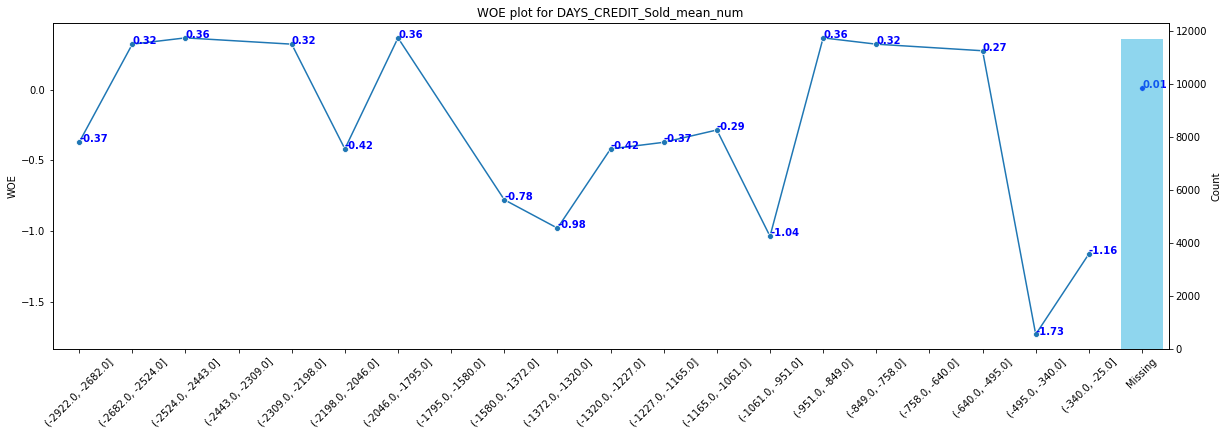

Information Value: 0.15206026338996326


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0   (-2921.0, -1237.0]    531      12         519     0.016736   
1    (-1237.0, -924.0]    526      19         507     0.026499   
2     (-924.0, -746.0]    527      25         502     0.034868   
3     (-746.0, -633.0]    525      16         509     0.022315   
4     (-633.0, -546.0]    531      28         503     0.039052   
5     (-546.0, -475.0]    531      28         503     0.039052   
6     (-475.0, -418.0]    520      33         487     0.046025   
7     (-418.0, -370.0]    529      29         500     0.040446   
8     (-370.0, -336.0]    534      27         507     0.037657   
9     (-336.0, -298.0]    523      29         494     0.040446   
10    (-298.0, -265.0]    533      32         501     0.044630   
11    (-265.0, -236.0]    515      46         469     0.064156   
12    (-236.0, -206.0]    544      41         503     0.057183   
13    (-206.0, -182.0]    516      48         468     0.066946   
14    (-182.0, -156.0]    541      38         503     0.052999   
15    (-156.0, -127.0]    517      32         485     0.044630   
16    (-127.0, -102.0]    542      41         501     0.057183   
17     (-102.0, -78.0]    506      34         472     0.047420   
18      (-78.0, -46.0]    534      47         487     0.065551   
19        (-46.0, 0.0]    517      54         463     0.075314   
20             Missing   1626      58        1568     0.080893   

    %_of_Non_Events       WOE        IV  
0          0.045324  0.996241  0.028480  
1          0.044276  0.513316  0.009125  
2          0.043839  0.228968  0.002054  
3          0.044450  0.689103  0.015253  
4          0.043926  0.117629  0.000573  
5          0.043926  0.117629  0.000573  
6          0.042529 -0.079000  0.000276  
7          0.043664  0.076556  0.000246  
8          0.044276  0.161918  0.001072  
9          0.043140  0.064483  0.000174  
10         0.043752 -0.019886  0.000017  
11         0.040957 -0.448795  0.010412  
12         0.043926 -0.263738  0.003496  
13         0.040870 -0.493489  0.012868  
14         0.043926 -0.187752  0.001703  
15         0.042354 -0.052344  0.000119  
16         0.043752 -0.267722  0.003596  
17         0.041219 -0.140138  0.000869  
18         0.042529 -0.432640  0.009960  
19         0.040433 -0.622013  0.021696  
20         0.136931  0.526357  0.029496

IV for DAYS_CREDIT_Active_max_num with 21 bins: 0.1521


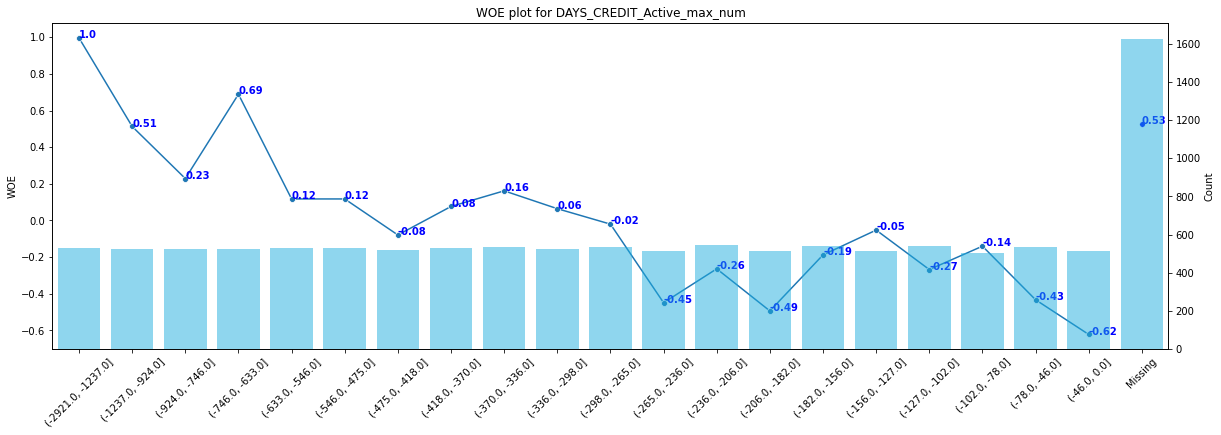

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE   IV
0   Missing  12168     717       11451          1.0              1.0  0.0  0.0

IV for DAYS_CREDIT_Others_mean_num with 1 bins: 0.0


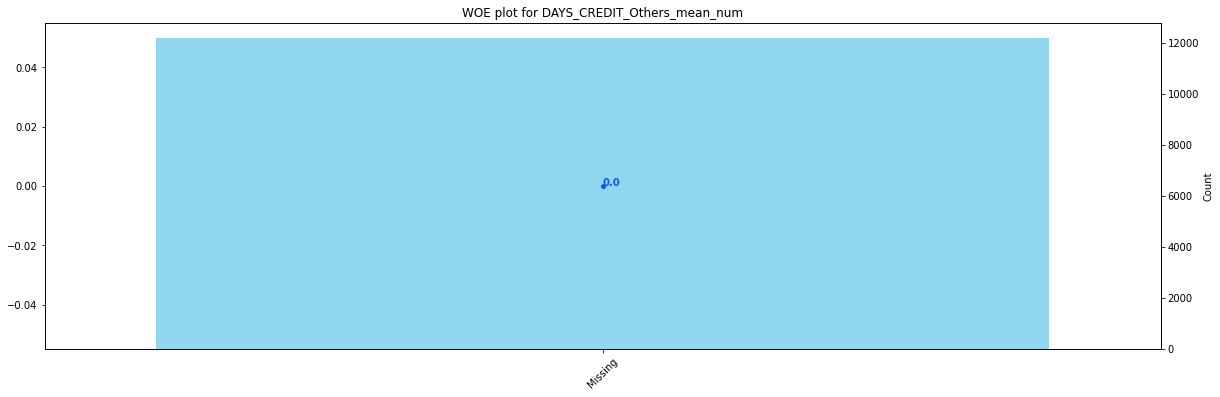

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE   IV
0   Missing  12168     717       11451          1.0              1.0  0.0  0.0

IV for DAYS_CREDIT_Others_max_num with 1 bins: 0.0


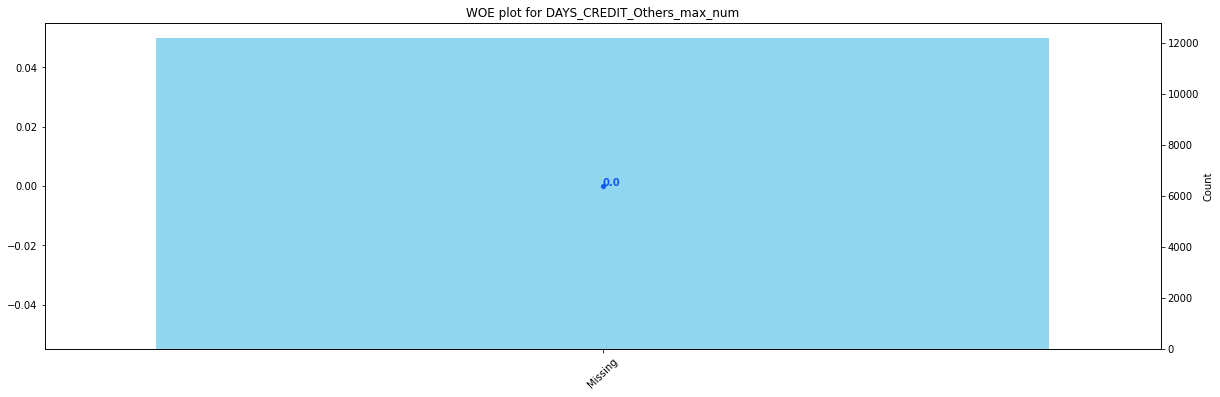

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0  (-1.0, 822.0]  12168     717       11451          1.0              1.0   

   WOE   IV  
0  0.0  0.0

IV for CREDIT_DAY_OVERDUE_MEAN_num with 1 bins: 0.0


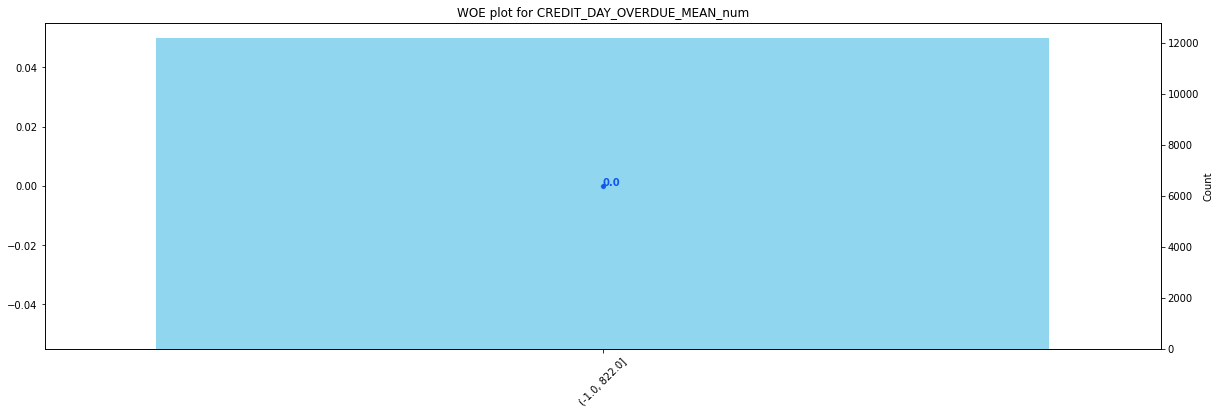

Information Value: 0.10785319937710543


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0   (-41820.0, -238.0]    515      20         495     0.027894   
1       (-238.0, 67.0]    516      28         488     0.039052   
2        (67.0, 216.0]    514      22         492     0.030683   
3       (216.0, 345.0]    514      21         493     0.029289   
4       (345.0, 445.0]    515      24         491     0.033473   
5       (445.0, 536.0]    518      25         493     0.034868   
6       (536.0, 625.0]    514      20         494     0.027894   
7       (625.0, 702.0]    516      31         485     0.043236   
8       (702.0, 777.0]    512      35         477     0.048815   
9       (777.0, 868.0]    514      33         481     0.046025   
10      (868.0, 959.0]    514      36         478     0.050209   
11     (959.0, 1056.0]    516      44         472     0.061367   
12    (1056.0, 1176.0]    515      35         480     0.048815   
13    (1176.0, 1339.0]    514      38         476     0.052999   
14    (1339.0, 1562.0]    514      38         476     0.052999   
15    (1562.0, 1994.0]    515      39         476     0.054393   
16    (1994.0, 3685.0]    514      33         481     0.046025   
17    (3685.0, 6492.0]    515      36         479     0.050209   
18   (6492.0, 10818.0]    515      45         470     0.062762   
19  (10818.0, 31188.0]    515      48         467     0.066946   
20             Missing   1873      66        1807     0.092050   

    %_of_Non_Events       WOE        IV  
0          0.043228  0.438069  0.006717  
1          0.042616  0.087354  0.000311  
2          0.042966  0.336680  0.004135  
3          0.043053  0.385230  0.005302  
4          0.042878  0.247634  0.002329  
5          0.043053  0.210877  0.001726  
6          0.043140  0.436047  0.006648  
7          0.042354 -0.020595  0.000018  
8          0.041656 -0.158588  0.001135  
9          0.042005 -0.091397  0.000367  
10         0.041743 -0.184665  0.001563  
11         0.041219 -0.397967  0.008018  
12         0.041918 -0.152318  0.001051  
13         0.041568 -0.242925  0.002777  
14         0.041568 -0.242925  0.002777  
15         0.041568 -0.268900  0.003449  
16         0.042005 -0.091397  0.000367  
17         0.041830 -0.182575  0.001530  
18         0.041044 -0.424686  0.009223  
19         0.040782 -0.495628  0.012967  
20         0.157803  0.539012  0.035441

IV for DAYS_CREDIT_ENDDATE_ACTIVE_MEAN_num with 21 bins: 0.1079


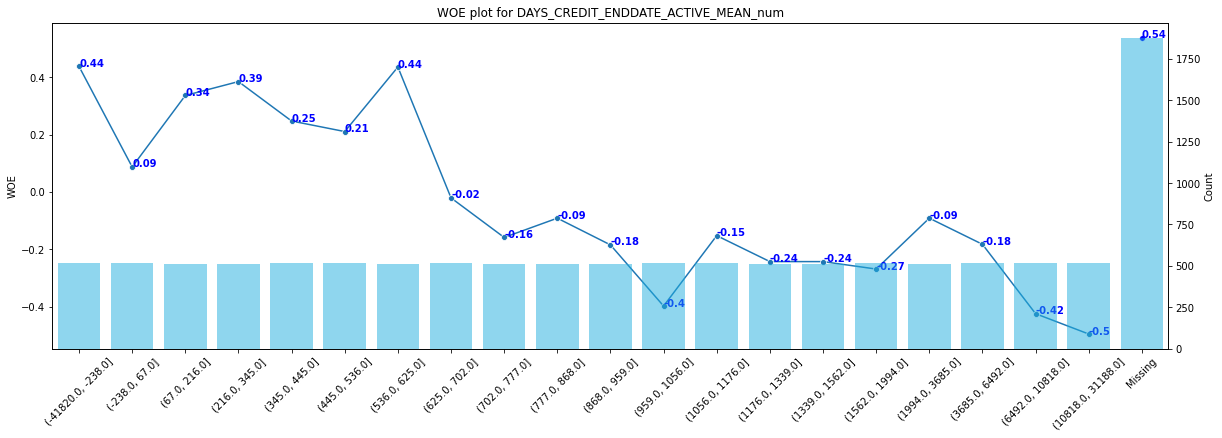

Information Value: 0.03871980409816156


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0   (-2761.0, -1473.0]    567      40         527     0.055788   
1   (-1473.0, -1089.0]    566      34         532     0.047420   
2    (-1089.0, -898.0]    566      31         535     0.043236   
3     (-898.0, -754.0]    567      21         546     0.029289   
4     (-754.0, -645.0]    565      36         529     0.050209   
5     (-645.0, -552.0]    574      36         538     0.050209   
6     (-552.0, -481.0]    556      27         529     0.037657   
7     (-481.0, -423.0]    577      36         541     0.050209   
8     (-423.0, -372.0]    559      26         533     0.036262   
9     (-372.0, -325.0]    573      25         548     0.034868   
10    (-325.0, -287.0]    570      31         539     0.043236   
11    (-287.0, -252.0]    559      39         520     0.054393   
12    (-252.0, -217.0]    556      31         525     0.043236   
13    (-217.0, -181.0]    573      45         528     0.062762   
14    (-181.0, -151.0]    560      33         527     0.046025   
15    (-151.0, -120.0]    568      34         534     0.047420   
16     (-120.0, -91.0]    571      35         536     0.048815   
17      (-91.0, -62.0]    566      33         533     0.046025   
18      (-62.0, -34.0]    566      24         542     0.033473   
19       (-34.0, -2.0]    557      35         522     0.048815   
20             Missing    852      65         787     0.090656   

    %_of_Non_Events       WOE            IV  
0          0.046022 -0.192435  1.879290e-03  
1          0.046459 -0.020474  1.967466e-05  
2          0.046721  0.077523  2.701760e-04  
3          0.047681  0.487340  8.963510e-03  
4          0.046197 -0.083287  3.341780e-04  
5          0.046983 -0.066417  2.142880e-04  
6          0.046197  0.204395  1.745521e-03  
7          0.047245 -0.060856  1.804034e-04  
8          0.046546  0.249668  2.567577e-03  
9          0.047856  0.316643  4.112742e-03  
10         0.047070  0.084972  3.258179e-04  
11         0.045411 -0.180489  1.621232e-03  
12         0.045848  0.058655  1.531951e-04  
13         0.046110 -0.308323  5.134189e-03  
14         0.046022 -0.000064  1.856591e-10  
15         0.046633 -0.016721  1.314825e-05  
16         0.046808 -0.041970  8.420798e-05  
17         0.046546  0.011257  5.865632e-06  
18         0.047332  0.346456  4.801636e-03  
19         0.045586 -0.068437  2.209807e-04  
20         0.068728 -0.276916  6.072172e-03

IV for DAYS_ENDDATE_FACT_MIN_num with 21 bins: 0.0387


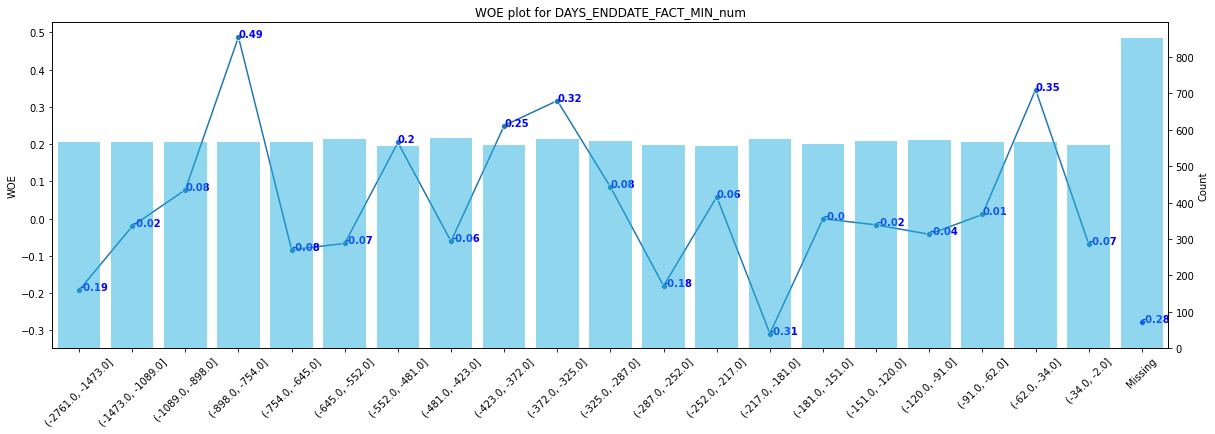

Information Value: 0.031017448499042984


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0   (-2761.0, -1834.0]    567      34         533     0.047420   
1   (-1834.0, -1617.0]    565      30         535     0.041841   
2   (-1617.0, -1484.0]    566      33         533     0.046025   
3   (-1484.0, -1380.0]    566      30         536     0.041841   
4   (-1380.0, -1300.0]    565      21         544     0.029289   
5   (-1300.0, -1222.0]    566      28         538     0.039052   
6   (-1222.0, -1155.0]    567      28         539     0.039052   
7   (-1155.0, -1091.0]    565      30         535     0.041841   
8   (-1091.0, -1031.0]    565      35         530     0.048815   
9    (-1031.0, -973.0]    567      42         525     0.058577   
10    (-973.0, -911.0]    565      36         529     0.050209   
11    (-911.0, -849.0]    566      27         539     0.037657   
12    (-849.0, -787.0]    569      31         538     0.043236   
13    (-787.0, -723.0]    562      41         521     0.057183   
14    (-723.0, -652.0]    568      37         531     0.051604   
15    (-652.0, -575.0]    564      29         535     0.040446   
16    (-575.0, -493.0]    566      36         530     0.050209   
17    (-493.0, -398.0]    566      34         532     0.047420   
18    (-398.0, -261.0]    565      32         533     0.044630   
19      (-261.0, -5.0]    566      38         528     0.052999   
20             Missing    852      65         787     0.090656   

    %_of_Non_Events       WOE        IV  
0          0.046546 -0.018596  0.000016  
1          0.046721  0.110313  0.000538  
2          0.046546  0.011257  0.000006  
3          0.046808  0.112180  0.000557  
4          0.047507  0.483670  0.008812  
5          0.046983  0.184898  0.001466  
6          0.047070  0.186755  0.001497  
7          0.046721  0.110313  0.000538  
8          0.046284 -0.053228  0.000135  
9          0.045848 -0.245028  0.003119  
10         0.046197 -0.083287  0.000334  
11         0.047070  0.223122  0.002100  
12         0.046983  0.083115  0.000311  
13         0.045498 -0.228579  0.002671  
14         0.046371 -0.106912  0.000559  
15         0.046721  0.144214  0.000905  
16         0.046284 -0.081398  0.000319  
17         0.046459 -0.020474  0.000020  
18         0.046546  0.042029  0.000081  
19         0.046110 -0.139246  0.000959  
20         0.068728 -0.276916  0.006072

IV for DAYS_ENDDATE_FACT_MEAN_num with 21 bins: 0.031


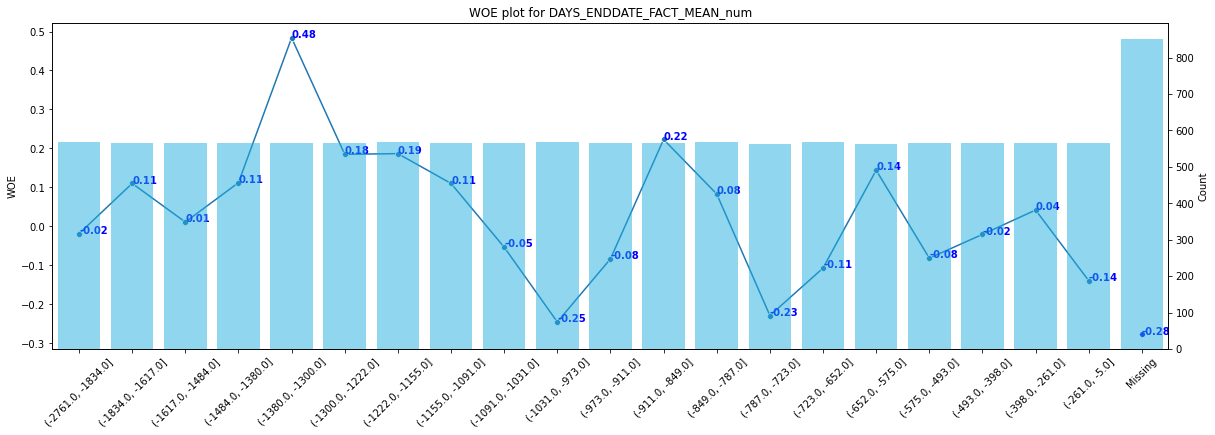

Information Value: 0.03712361909175223


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0   (-0.1, 0.0002]   8517     446        8071     0.622036         0.704829   
1  (0.0002, 0.001]    609      39         570     0.054393         0.049777   
2   (0.001, 0.003]    608      39         569     0.054393         0.049690   
3   (0.003, 0.005]    608      55         553     0.076709         0.048293   
4   (0.005, 0.009]    609      48         561     0.066946         0.048991   
5    (0.009, 0.02]    608      48         560     0.066946         0.048904   
6      (0.02, 1.3]    609      42         567     0.058577         0.049515   

        WOE        IV  
0  0.124957  0.010346  
1 -0.088682  0.000409  
2 -0.090438  0.000425  
3 -0.462732  0.013149  
4 -0.312237  0.005606  
5 -0.314021  0.005665  
6 -0.168067  0.001523

IV for CREDIT_OVERDUE_RATIO_num with 7 bins: 0.0371


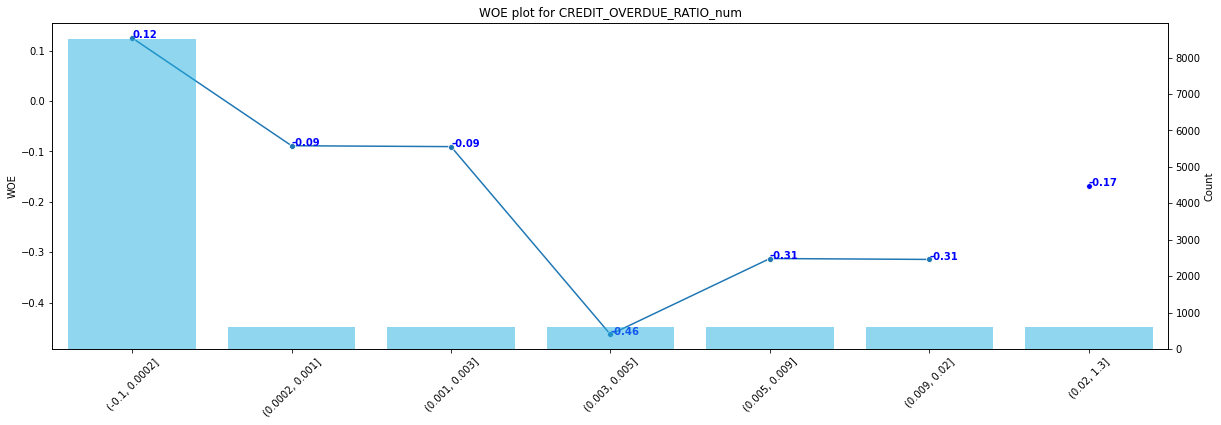

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE  \
0  (-1.0, 6.0]  12168     717       11451          1.0              1.0  0.0   

    IV  
0  0.0

IV for CNT_CREDIT_PROLONG_TOTAL_num with 1 bins: 0.0


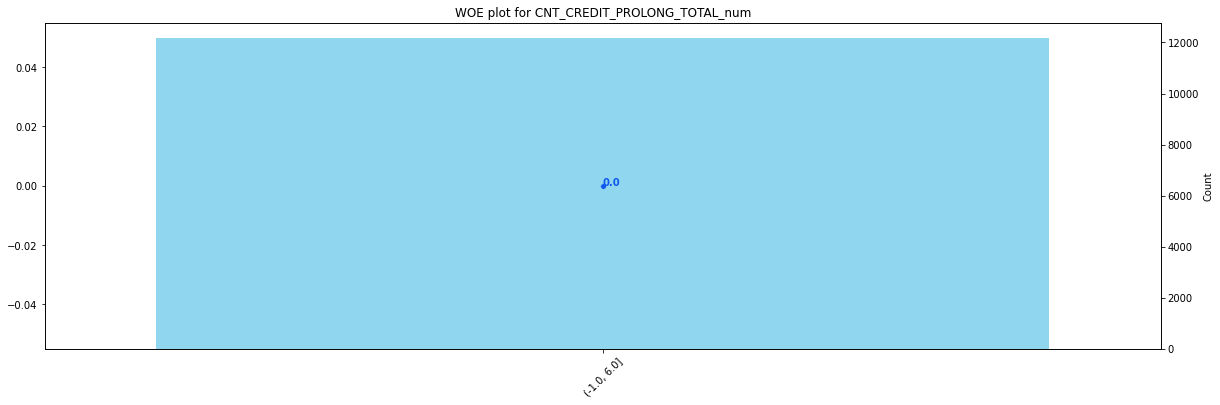

Information Value: 0.08467492858334111


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0           (-1.0, 99801.0]    528      28         500     0.039052   
1       (99801.0, 180000.0]    568      38         530     0.052999   
2      (180000.0, 252968.0]    486      21         465     0.029289   
3      (252968.0, 328165.0]    527      40         487     0.055788   
4      (328165.0, 400572.0]    527      35         492     0.048815   
5      (400572.0, 469826.0]    527      32         495     0.044630   
6      (469826.0, 547972.0]    528      47         481     0.065551   
7      (547972.0, 630000.0]    530      41         489     0.057183   
8      (630000.0, 712451.0]    523      35         488     0.048815   
9      (712451.0, 801356.0]    527      39         488     0.054393   
10     (801356.0, 900000.0]    540      48         492     0.066946   
11    (900000.0, 1012500.0]    516      34         482     0.047420   
12   (1012500.0, 1138166.0]    525      34         491     0.047420   
13   (1138166.0, 1282891.0]    527      28         499     0.039052   
14   (1282891.0, 1453021.0]    527      31         496     0.043236   
15   (1453021.0, 1672277.0]    527      22         505     0.030683   
16   (1672277.0, 1980000.0]    531      26         505     0.036262   
17   (1980000.0, 2417778.0]    523      27         496     0.037657   
18   (2417778.0, 3316794.0]    527      33         494     0.046025   
19  (3316794.0, 51750000.0]    528      20         508     0.027894   
20                  Missing   1626      58        1568     0.080893   

    %_of_Non_Events       WOE            IV  
0          0.043664  0.111647  5.149951e-04  
1          0.046284 -0.135466  9.095757e-04  
2          0.040608  0.326758  3.698613e-03  
3          0.042529 -0.271372  3.598111e-03  
4          0.042966 -0.127626  7.464612e-04  
5          0.043228 -0.031935  4.479596e-05  
6          0.042005 -0.445037  1.047877e-02  
7          0.042704 -0.291966  4.227380e-03  
8          0.042616 -0.135789  8.416401e-04  
9          0.042616 -0.244003  2.873606e-03  
10         0.042966 -0.443479  1.063459e-02  
11         0.042092 -0.119173  6.348831e-04  
12         0.042878 -0.100673  4.572013e-04  
13         0.043577  0.109645  4.961853e-04  
14         0.043315  0.001832  1.452768e-07  
15         0.044101  0.362759  4.867343e-03  
16         0.044101  0.195705  1.534085e-03  
17         0.043315  0.139983  7.920340e-04  
18         0.043140 -0.064729  1.867268e-04  
19         0.044363  0.463993  7.641465e-03  
20         0.136931  0.526357  2.949633e-02

IV for AMT_CREDIT_SUM_ACTIVE_MEAN_num with 21 bins: 0.0847


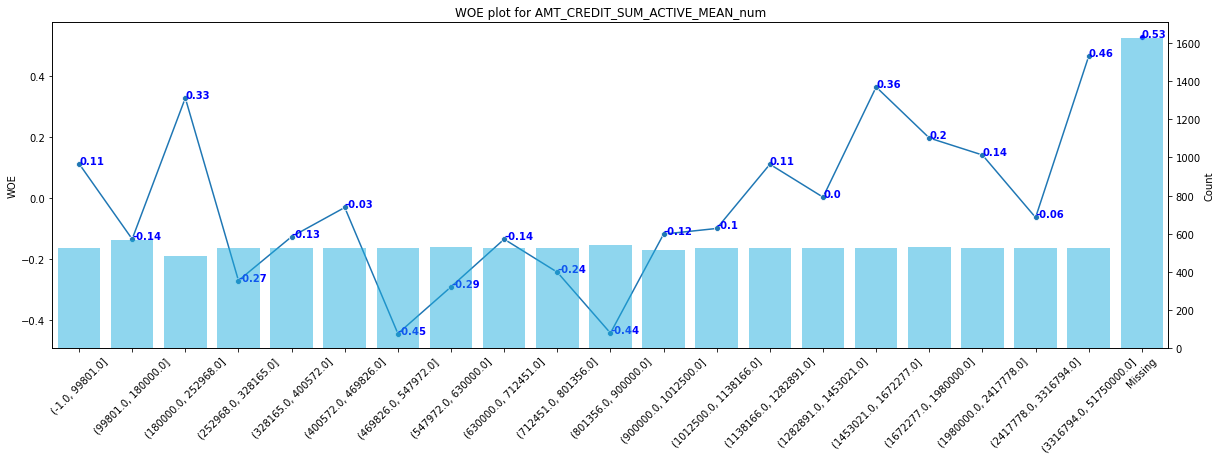

Information Value: 0.05754320959030497


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0           (-1.0, 135000.0]    538      25         513     0.034868   
1       (135000.0, 315000.0]    524      26         498     0.036262   
2       (315000.0, 514831.0]    520      29         491     0.040446   
3       (514831.0, 723754.0]    527      29         498     0.040446   
4       (723754.0, 967707.0]    527      27         500     0.037657   
5      (967707.0, 1204775.0]    527      32         495     0.044630   
6     (1204775.0, 1395919.0]    527      34         493     0.047420   
7     (1395919.0, 1602233.0]    527      42         485     0.058577   
8     (1602233.0, 1804352.0]    527      33         494     0.046025   
9     (1804352.0, 2007000.0]    528      30         498     0.041841   
10    (2007000.0, 2227500.0]    531      30         501     0.041841   
11    (2227500.0, 2434969.0]    522      40         482     0.055788   
12    (2434969.0, 2700000.0]    542      36         506     0.050209   
13    (2700000.0, 2997354.0]    512      29         483     0.040446   
14    (2997354.0, 3341514.0]    527      45         482     0.062762   
15    (3341514.0, 3806244.0]    527      33         494     0.046025   
16    (3806244.0, 4507818.0]    527      36         491     0.050209   
17    (4507818.0, 5583633.0]    527      38         489     0.052999   
18    (5583633.0, 7922943.0]    527      31         496     0.043236   
19  (7922943.0, 103500000.0]    528      34         494     0.047420   
20                   Missing   1626      58        1568     0.080893   

    %_of_Non_Events       WOE            IV  
0          0.044800  0.250644  2.489411e-03  
1          0.043490  0.181747  1.313567e-03  
2          0.042878  0.058392  1.420116e-04  
3          0.043490  0.072548  2.207880e-04  
4          0.043664  0.148015  8.891844e-04  
5          0.043228 -0.031935  4.479596e-05  
6          0.043053 -0.096608  4.218668e-04  
7          0.042354 -0.324277  5.260758e-03  
8          0.043140 -0.064729  1.867268e-04  
9          0.043490  0.038646  6.371395e-05  
10         0.043752  0.044652  8.531401e-05  
11         0.042092 -0.281692  3.857942e-03  
12         0.044188 -0.127739  7.691055e-04  
13         0.042180  0.041964  7.274172e-05  
14         0.042092 -0.399475  8.256791e-03  
15         0.043140 -0.064729  1.867268e-04  
16         0.042878 -0.157831  1.157038e-03  
17         0.042704 -0.215980  2.223497e-03  
18         0.043315  0.001832  1.452768e-07  
19         0.043140 -0.094582  4.047585e-04  
20         0.136931  0.526357  2.949633e-02

IV for AMT_CREDIT_SUM_ACTIVE_TOTAL_num with 21 bins: 0.0575


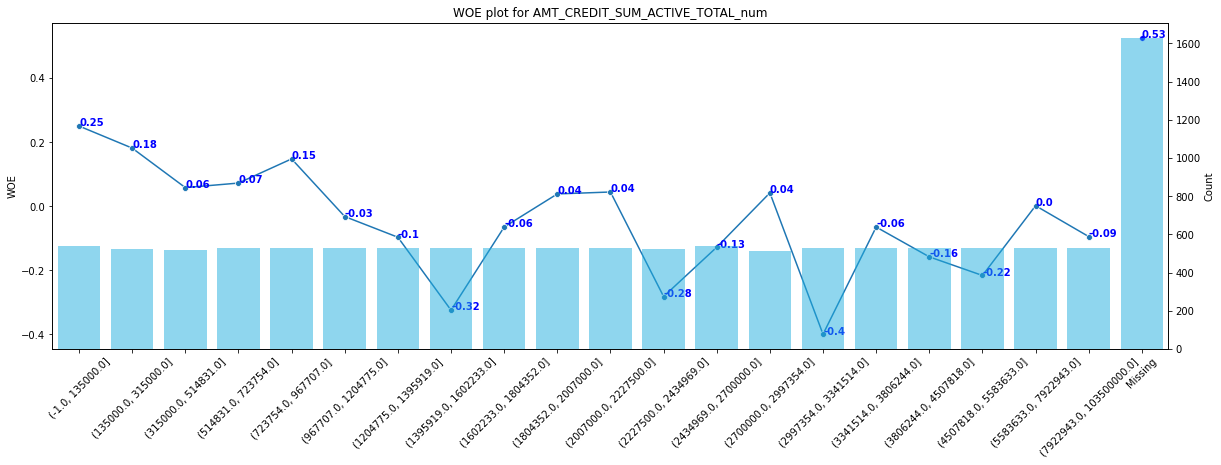

Information Value: 0.004719637634588268


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0        (-1.0, 612773.0]    442      33         409     0.046025   
1  (612773.0, 37610902.0]     24       3          21     0.004184   
2                 Missing  11702     681       11021     0.949791   

   %_of_Non_Events       WOE        IV  
0         0.035717 -0.253549  0.002614  
1         0.001834 -0.824846  0.001939  
2         0.962449  0.013239  0.000168

IV for AMT_CREDIT_SUM_DEBT_SOLD_TOTAL_num with 3 bins: 0.0047


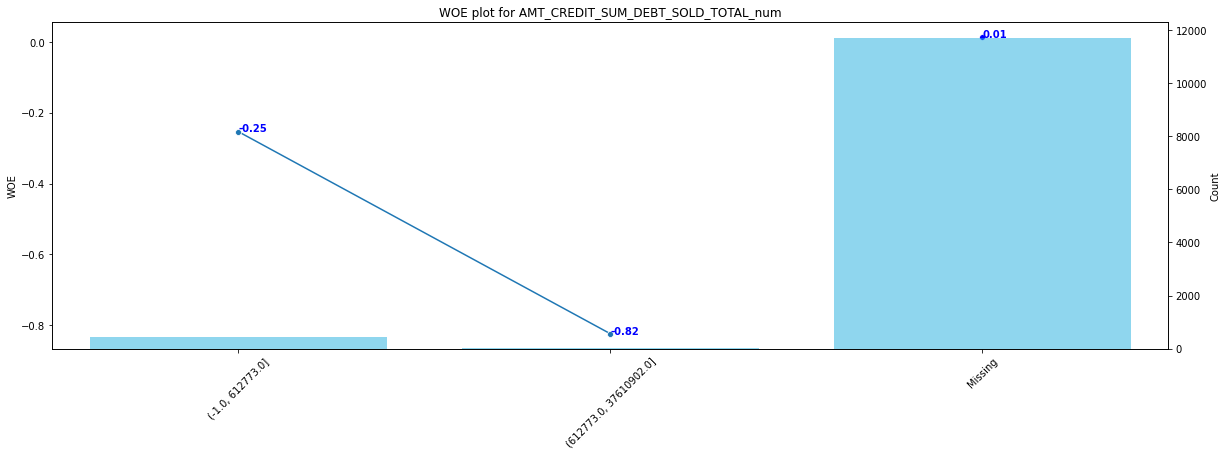

Information Value: 0.054766622864483416


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0        (-1407.0, 0.0]   8725     451        8274     0.629010   
1            (0.0, 8.0]     35       4          31     0.005579   
2         (8.0, 3410.0]    547      61         486     0.085077   
3     (3410.0, 15041.0]    548      41         507     0.057183   
4    (15041.0, 43903.0]    547      41         506     0.057183   
5  (43903.0, 1003500.0]    548      39         509     0.054393   
6               Missing   1218      80        1138     0.111576   

   %_of_Non_Events       WOE        IV  
0         0.722557  0.138650  0.012970  
1         0.002707 -0.723064  0.002076  
2         0.042442 -0.695422  0.029649  
3         0.044276 -0.255818  0.003302  
4         0.044188 -0.257792  0.003350  
5         0.044450 -0.201870  0.002007  
6         0.099380 -0.115756  0.001412

IV for AMT_CREDIT_SUM_LIMIT_MEAN_num with 7 bins: 0.0548


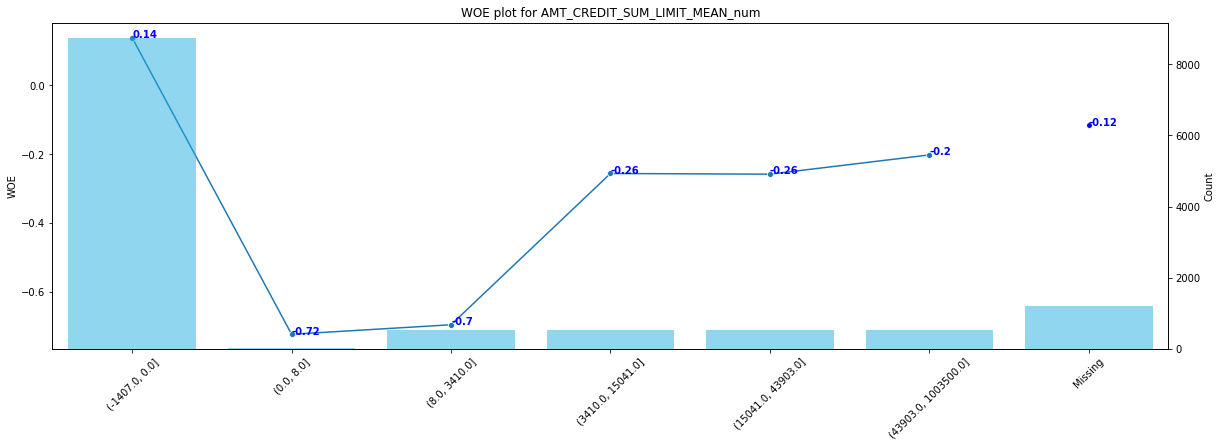

Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0  (-1.0, 2079510.0]  12168     717       11451          1.0              1.0   

   WOE   IV  
0  0.0  0.0

IV for AMT_CREDIT_SUM_OVERDUE_TOTAL_num with 1 bins: 0.0


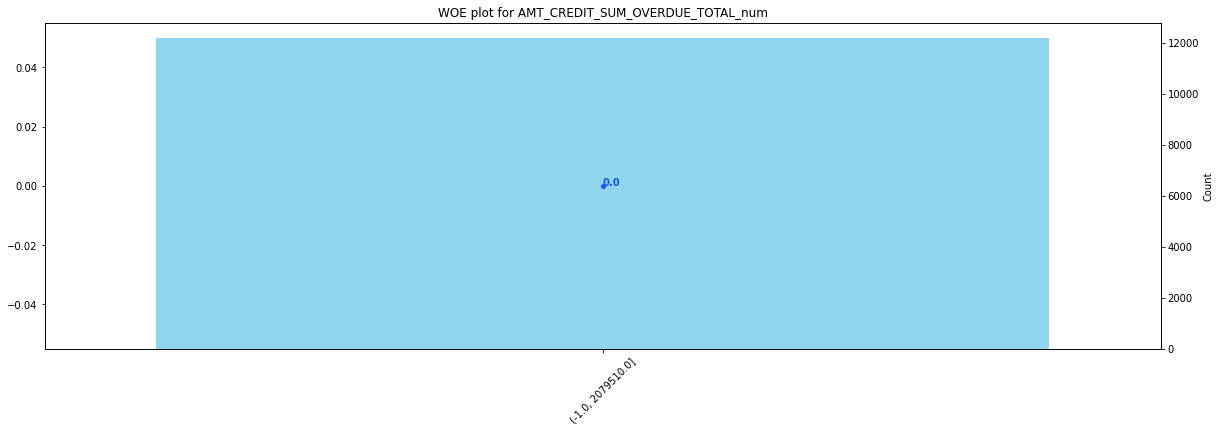

Information Value: 0.00698747865391748


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  \
0  (0.0, 2.0]   4383     237        4146     0.330544         0.362064   
1  (2.0, 3.0]   6909     422        6487     0.588563         0.566501   
2  (3.0, 4.0]    838      57         781     0.079498         0.068204   
3  (4.0, 6.0]     38       1          37     0.001395         0.003231   

        WOE        IV  
0  0.091083  0.002871  
1 -0.038206  0.000843  
2 -0.153233  0.001731  
3  0.840161  0.001543

IV for CREDIT_TYPE_UNIQUE_COUNT_num with 4 bins: 0.007


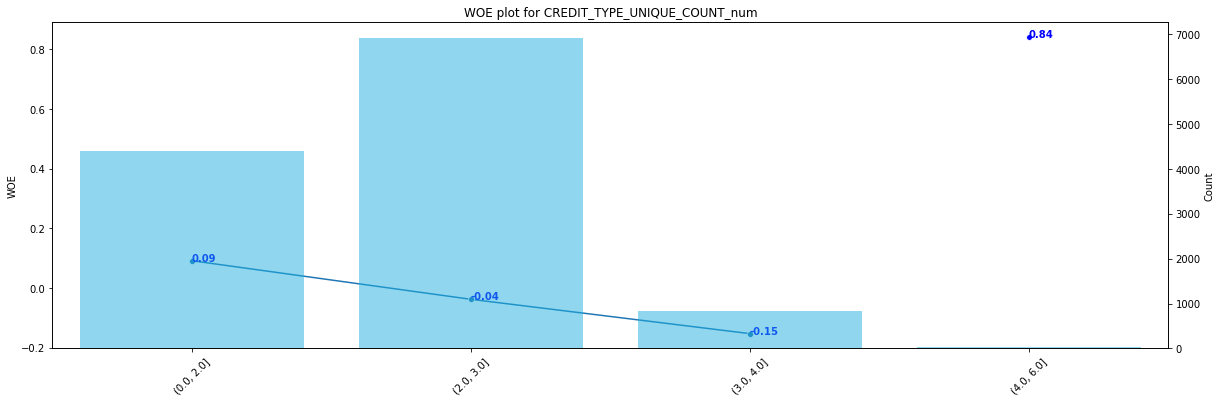

Mapping for CAR_LOAN_TAKEN:
True: 0
Information Value: 0.0


Bin_Range  Count  Events  Non_Events  %_of_Events  %_of_Non_Events  WOE   IV
0         0  12168     717       11451          1.0              1.0  0.0  0.0

IV for CAR_LOAN_TAKEN_num with 1 bins: 0.0


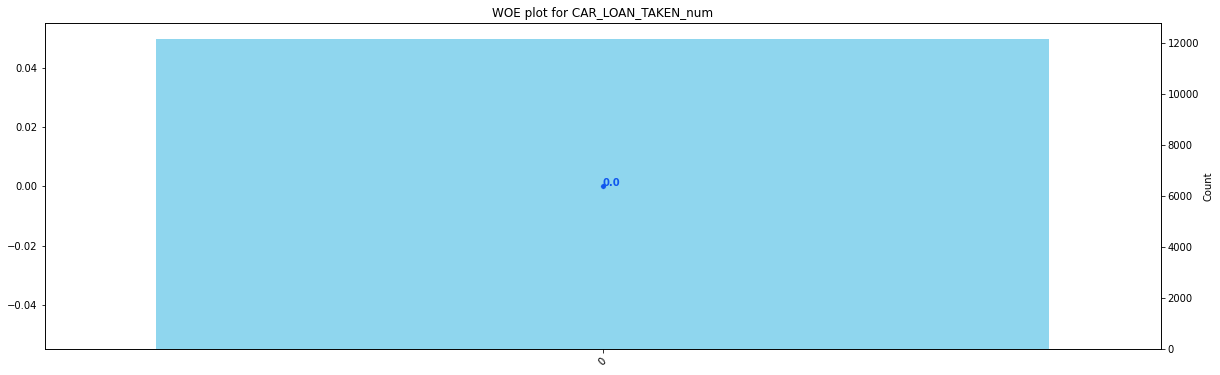

Information Value: 0.03921439041589754


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0   (-41924.0, -2576.0]    612      38         574     0.052999   
1    (-2576.0, -2453.0]    613      33         580     0.046025   
2    (-2453.0, -2341.0]    601      26         575     0.036262   
3    (-2341.0, -2212.0]    608      28         580     0.039052   
4    (-2212.0, -2047.0]    612      33         579     0.046025   
5    (-2047.0, -1866.0]    608      30         578     0.041841   
6    (-1866.0, -1693.0]    607      43         564     0.059972   
7    (-1693.0, -1559.0]    606      30         576     0.041841   
8    (-1559.0, -1419.0]    617      29         588     0.040446   
9    (-1419.0, -1289.0]    604      27         577     0.037657   
10   (-1289.0, -1164.0]    608      42         566     0.058577   
11   (-1164.0, -1053.0]    607      37         570     0.051604   
12    (-1053.0, -940.0]    610      44         566     0.061367   
13     (-940.0, -825.0]    604      43         561     0.059972   
14     (-825.0, -720.0]    609      33         576     0.046025   
15     (-720.0, -607.0]    608      45         563     0.062762   
16     (-607.0, -442.0]    611      34         577     0.047420   
17     (-442.0, -233.0]    611      31         580     0.043236   
18      (-233.0, -36.0]    606      46         560     0.064156   
19         (-36.0, 0.0]    606      45         561     0.062762   

    %_of_Non_Events       WOE        IV  
0          0.050127 -0.055713  0.000160  
1          0.050651  0.095764  0.000443  
2          0.050214  0.325517  0.004542  
3          0.050651  0.260067  0.003017  
4          0.050563  0.094038  0.000427  
5          0.050476  0.187620  0.001620  
6          0.049253 -0.196902  0.002111  
7          0.050301  0.184154  0.001558  
8          0.051349  0.238675  0.002602  
9          0.050389  0.291249  0.003708  
10         0.049428 -0.169832  0.001554  
11         0.049777 -0.036038  0.000066  
12         0.049428 -0.216352  0.002583  
13         0.048991 -0.202236  0.002221  
14         0.050301  0.088844  0.000380  
15         0.049166 -0.244139  0.003319  
16         0.050389  0.060725  0.000180  
17         0.050651  0.158284  0.001174  
18         0.048904 -0.271461  0.004140  
19         0.048991 -0.247698  0.003411

IV for DAYS_CREDIT_UPDATE_MIN_num with 20 bins: 0.0392


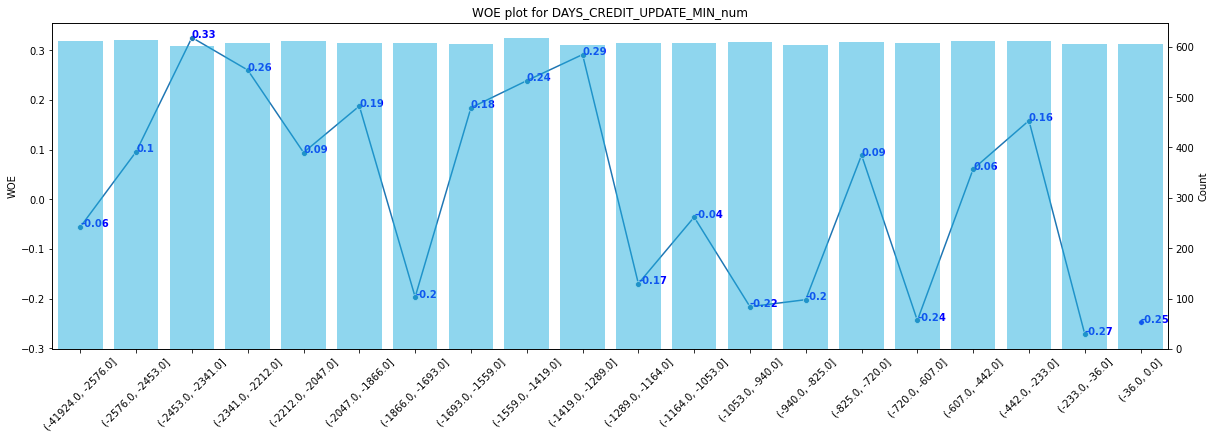

Information Value: 0.007423866611625614


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0      (-1.0, 12701.0]    419      31         388     0.043236   
1   (12701.0, 32244.0]     23       4          19     0.005579   
2  (32244.0, 377091.0]     24       1          23     0.001395   
3              Missing  11702     681       11021     0.949791   

   %_of_Non_Events       WOE        IV  
0         0.033884 -0.243738  0.002279  
1         0.001659 -1.212612  0.004753  
2         0.002009  0.364738  0.000224  
3         0.962449  0.013239  0.000168

IV for AMT_ANNUITY_SOLD_TOTAL_num with 4 bins: 0.0074


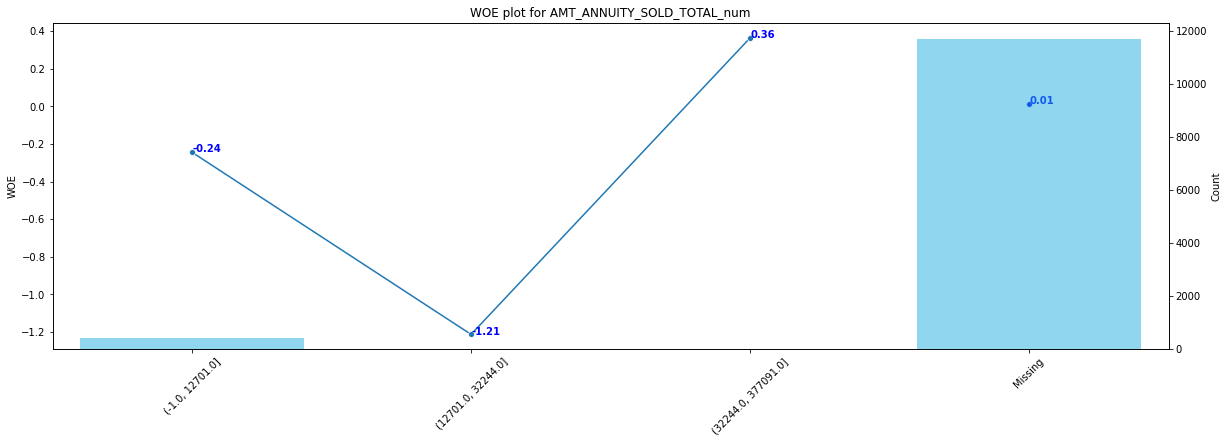

Information Value: 0.10040129923294455


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0      (45008.0, 188706.0]    528      22         506     0.030683   
1     (188706.0, 247501.0]    527      28         499     0.039052   
2     (247501.0, 277971.0]    527      30         497     0.041841   
3     (277971.0, 337505.0]    527      25         502     0.034868   
4     (337505.0, 417865.0]    527      45         482     0.062762   
5     (417865.0, 450020.0]    527      49         478     0.068340   
6     (450020.0, 504379.0]    527      36         491     0.050209   
7     (504379.0, 544491.0]    528      41         487     0.057183   
8     (544491.0, 595914.0]    526      45         481     0.062762   
9     (595914.0, 675003.0]    527      34         493     0.047420   
10    (675003.0, 720012.0]    527      36         491     0.050209   
11    (720012.0, 785403.0]    527      41         486     0.057183   
12    (785403.0, 870987.0]    527      35         492     0.048815   
13    (870987.0, 922510.0]    527      22         505     0.030683   
14   (922510.0, 1027328.0]    529      22         507     0.030683   
15  (1027328.0, 1125000.0]    529      34         495     0.047420   
16  (1125000.0, 1256357.0]    523      26         497     0.036262   
17  (1256357.0, 1350005.0]    527      40         487     0.055788   
18  (1350005.0, 1664821.0]    527      26         501     0.036262   
19  (1664821.0, 3150006.0]    528      22         506     0.030683   
20                 Missing   1626      58        1568     0.080893   

    %_of_Non_Events       WOE        IV  
0          0.044188  0.364738  0.004926  
1          0.043577  0.109645  0.000496  
2          0.043402  0.036636  0.000057  
3          0.043839  0.228968  0.002054  
4          0.042092 -0.399475  0.008257  
5          0.041743 -0.492966  0.013112  
6          0.042878 -0.157831  0.001157  
7          0.042529 -0.296064  0.004338  
8          0.042005 -0.401552  0.008335  
9          0.043053 -0.096608  0.000422  
10         0.042878 -0.157831  0.001157  
11         0.042442 -0.298120  0.004395  
12         0.042966 -0.127626  0.000746  
13         0.044101  0.362759  0.004867  
14         0.044276  0.366712  0.004984  
15         0.043228 -0.092559  0.000388  
16         0.043402  0.179737  0.001283  
17         0.042529 -0.271372  0.003598  
18         0.043752  0.187753  0.001406  
19         0.044188  0.364738  0.004926  
20         0.136931  0.526357  0.029496

IV for DEBT_TO_INCOME_RATIO_num with 21 bins: 0.1004


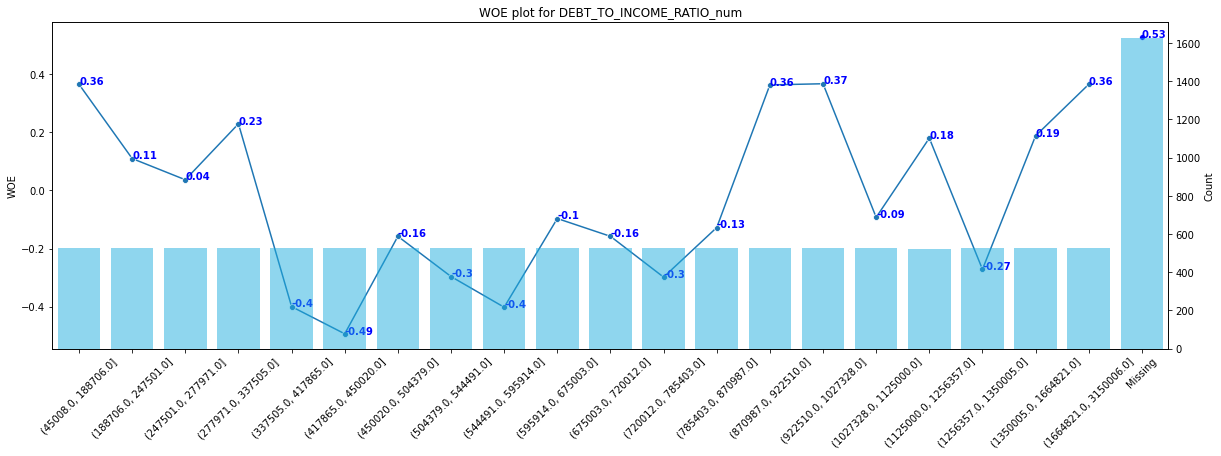

Information Value: 0.07386495970489079


Bin_Range  Count  Events  Non_Events  %_of_Events  \
0       (3603.0, 12375.0]    529      24         505     0.033473   
1      (12375.0, 15927.0]    526      22         504     0.030683   
2      (15927.0, 19125.0]    530      38         492     0.052999   
3      (19125.0, 21888.0]    534      24         510     0.033473   
4      (21888.0, 24138.0]    517      31         486     0.043236   
5      (24138.0, 26284.0]    538      35         503     0.048815   
6      (26284.0, 28274.0]    517      37         480     0.051604   
7      (28274.0, 30704.0]    528      39         489     0.054393   
8      (30704.0, 32895.0]    546      46         500     0.064156   
9      (32895.0, 35694.0]    510      27         483     0.037657   
10     (35694.0, 37800.0]    531      40         491     0.055788   
11     (37800.0, 40523.0]    519      29         490     0.040446   
12     (40523.0, 43997.0]    527      27         500     0.037657   
13     (43997.0, 47952.0]    530      29         501     0.040446   
14     (47952.0, 52964.0]    524      28         496     0.039052   
15     (52964.0, 61059.0]    527      37         490     0.051604   
16     (61059.0, 72430.0]    527      30         497     0.041841   
17     (72430.0, 95664.0]    527      40         487     0.055788   
18    (95664.0, 140164.0]    527      32         495     0.044630   
19  (140164.0, 2063601.0]    528      44         484     0.061367   
20                Missing   1626      58        1568     0.080893   

    %_of_Non_Events       WOE        IV  
0          0.044101  0.275748  0.002931  
1          0.044014  0.360777  0.004809  
2          0.042966 -0.209864  0.002106  
3          0.044538  0.285600  0.003160  
4          0.042442 -0.018535  0.000015  
5          0.043926 -0.105514  0.000516  
6          0.041918 -0.207888  0.002014  
7          0.042704 -0.241956  0.002828  
8          0.043664 -0.384790  0.007885  
9          0.042180  0.113423  0.000513  
10         0.042878 -0.263192  0.003398  
11         0.042791  0.056353  0.000132  
12         0.043664  0.148015  0.000889  
13         0.043752  0.078554  0.000260  
14         0.043315  0.103615  0.000442  
15         0.042791 -0.187269  0.001650  
16         0.043402  0.036636  0.000057  
17         0.042529 -0.271372  0.003598  
18         0.043228 -0.031935  0.000045  
19         0.042267 -0.372861  0.007122  
20         0.136931  0.526357  0.029496

IV for TOTAL_ANNUITY_num with 21 bins: 0.0739


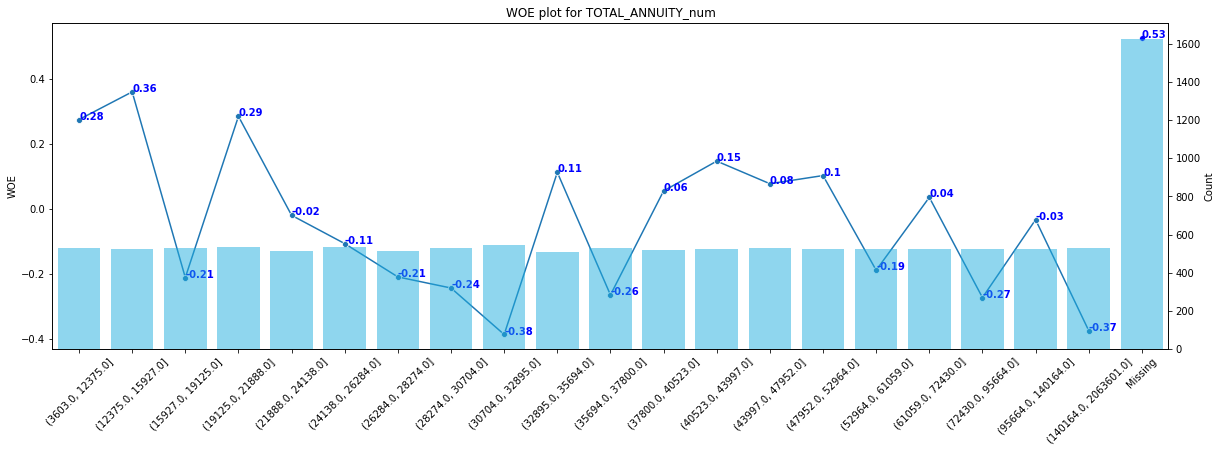

In [11]:
# Assuming df_app_working and TARGET are defined and valid
target = 'TARGET'
dataframe = merged_df_copy.copy()
bin_count = 20

# for variable in dataframe.columns[2:4]:
for variable in dataframe.columns[2:]:
    if variable in categorical_data_df:
        # Map the categorical variable to numbers
        dataframe[variable + '_num'] = pd.Categorical(dataframe[variable]).codes

        # Create a dictionary that maps the original values to the codes
        value_to_code_mapping = {value: code for value, code in zip(dataframe[variable], dataframe[variable + '_num'])}

        # Print out the mapping
        print(f"Mapping for {variable}:")
        for value, code in value_to_code_mapping.items():
            print(f"{value}: {code}")

        # create groupings based on specified bin edges
        working = pd.DataFrame()
        working = dataframe[[variable + '_num', target]]
        # working['Bin_Range'] = pd.qcut(dataframe[variable + '_num'], q= bin_count, precision=0, duplicates="drop")
        working['Bin_Range'] = dataframe[variable + '_num']

        # Calculate WOE and IV
        IV, variable_data = woe_iv(working, variable + '_num')
    else:
        # create groupings based on specified bin edges
        working = pd.DataFrame()
        working = dataframe[[variable, target]]
        working['Bin_Range'] = pd.qcut(dataframe[variable], q= bin_count, precision=0, duplicates="drop")

        # Calculate WOE and IV
        IV, variable_data = woe_iv(working, variable)

    # Display the results
    print('Information Value:', IV)
    display(variable_data)

    # Plot WOE and IV
    woe_iv_plot(working, variable + '_num')
# display(working.head())

## Feature Screening

In [12]:
# 24 Variables Group Agreed To Keep + 1 Variable (TARGET)
to_keep = ["TARGET", "ORGANIZATION_TYPE", "DAYS_CREDIT_Active_mean", "DAYS_EMPLOYED",
                    "CREDIT_ACTIVE_Active", "OWN_CAR_AGE", "OCCUPATION_TYPE", "NAME_EDUCATION_TYPE", "LANDAREA_AVG",
                    "CREDIT_OVERDUE_RATIO", "DAYS_BIRTH", "OBS_30_CNT_SOCIAL_CIRCLE", "AMT_REQ_CREDIT_BUREAU_QRT",
                    "AMT_CREDIT_SUM_LIMIT_MEAN", "DEF_30_CNT_SOCIAL_CIRCLE", "AMT_REQ_CREDIT_BUREAU_YEAR", "FLAG_OWN_REALTY",
                    "FLAG_OWN_CAR", "CNT_FAM_MEMBERS", "AMT_REQ_CREDIT_BUREAU_MON", "NAME_HOUSING_TYPE", "NAME_FAMILY_STATUS",
                    "DEBT_TO_INCOME_RATIO", "TOTAL_ANNUITY"
]


In [13]:
data_df2 = data_df[to_keep].copy()
data_df2.to_csv('selected_data_for_LR.csv', index=False) # save file

In [14]:
data_df2 = pd.read_csv('selected_data_for_LR.csv') # read file

In [15]:
# sort variables into numerical and categorical
# for df_app, df_bureau, df_dict
for df_name in ['data_df2']:
    df = vars()[df_name]
    vars()[f'numerical_{df_name}'] = df.select_dtypes(include=[np.number]).columns.tolist()
    vars()[f'categorical_{df_name}'] = df.select_dtypes(include=[object]).columns.tolist()
    print(f'numerical_{df_name}: {vars()[f"numerical_{df_name}"]}')
    print(f'categorical_{df_name}: {vars()[f"categorical_{df_name}"]}')
    print()


numerical_data_df2: ['TARGET', 'DAYS_CREDIT_Active_mean', 'DAYS_EMPLOYED', 'CREDIT_ACTIVE_Active', 'OWN_CAR_AGE', 'LANDAREA_AVG', 'CREDIT_OVERDUE_RATIO', 'DAYS_BIRTH', 'OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_CREDIT_SUM_LIMIT_MEAN', 'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_FAM_MEMBERS', 'AMT_REQ_CREDIT_BUREAU_MON', 'DEBT_TO_INCOME_RATIO', 'TOTAL_ANNUITY']
categorical_data_df2: ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'NAME_HOUSING_TYPE', 'NAME_FAMILY_STATUS']



# Coarse Classing

In [16]:
data_df2.shape[0] * 0.05

608.4

In [17]:
data_df2.shape

(12168, 24)

## Coarse Classing Without Monotonicity 

[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
ORGANIZATION_TYPE
>>> Continue the binning process?
1: yes 
2: no
Selection: 1


variable                                                bin  \
0  ORGANIZATION_TYPE  Hotel%,%University%,%Religion%,%Industry: type...   
1  ORGANIZATION_TYPE  Industry: type 9%,%Bank%,%Emergency%,%School%,...   
2  ORGANIZATION_TYPE  Trade: type 3%,%Kindergarten%,%Business Entity...   
3  ORGANIZATION_TYPE  Medicine%,%Postal%,%Construction%,%Business En...   
4  ORGANIZATION_TYPE  Transport: type 4%,%Industry: type 4%,%Self-em...   

   count  count_distr  good  bad   badprob       woe    bin_iv  total_iv  \
0   1097     0.056041  1078   19  0.017320 -1.248662  0.052049  0.112989   
1   4806     0.245517  4611  195  0.040574 -0.373439  0.029097  0.112989   
2   1248     0.063755  1181   67  0.053686 -0.079663  0.000391  0.112989   
3   8412     0.429732  7878  534  0.063481  0.098328  0.004340  0.112989   
4   4012     0.204955  3694  318  0.079262  0.337348  0.027112  0.112989   

                                              breaks  is_special_values  
0  Hotel%,%University%,%Religion%,%Industry: type...              False  
1  Industry: type 9%,%Bank%,%Emergency%,%School%,...              False  
2  Trade: type 3%,%Kindergarten%,%Business Entity...              False  
3  Medicine%,%Postal%,%Construction%,%Business En...              False  
4  Transport: type 4%,%Industry: type 4%,%Self-em...              False

Information Value: 0.11298889782169463
Bins: 0    Hotel%,%University%,%Religion%,%Industry: type...
1    Industry: type 9%,%Bank%,%Emergency%,%School%,...
2    Trade: type 3%,%Kindergarten%,%Business Entity...
3    Medicine%,%Postal%,%Construction%,%Business En...
4    Transport: type 4%,%Industry: type 4%,%Self-em...
Name: bin, dtype: object



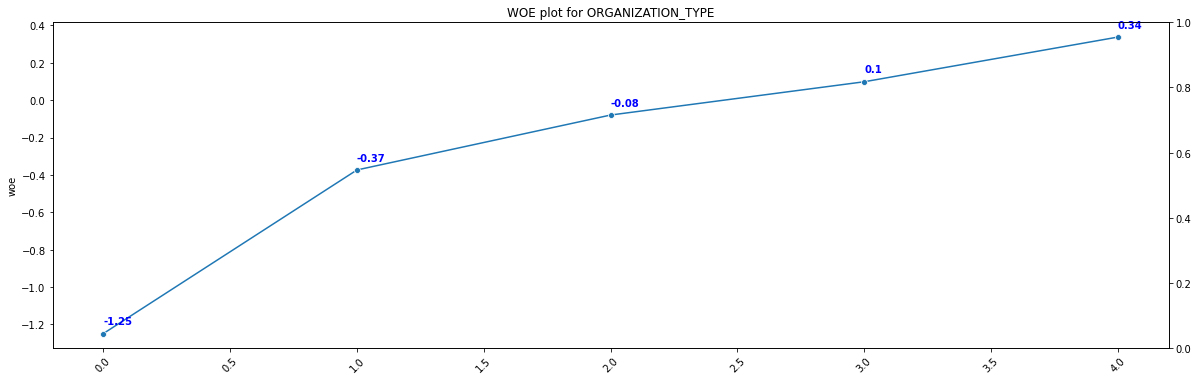

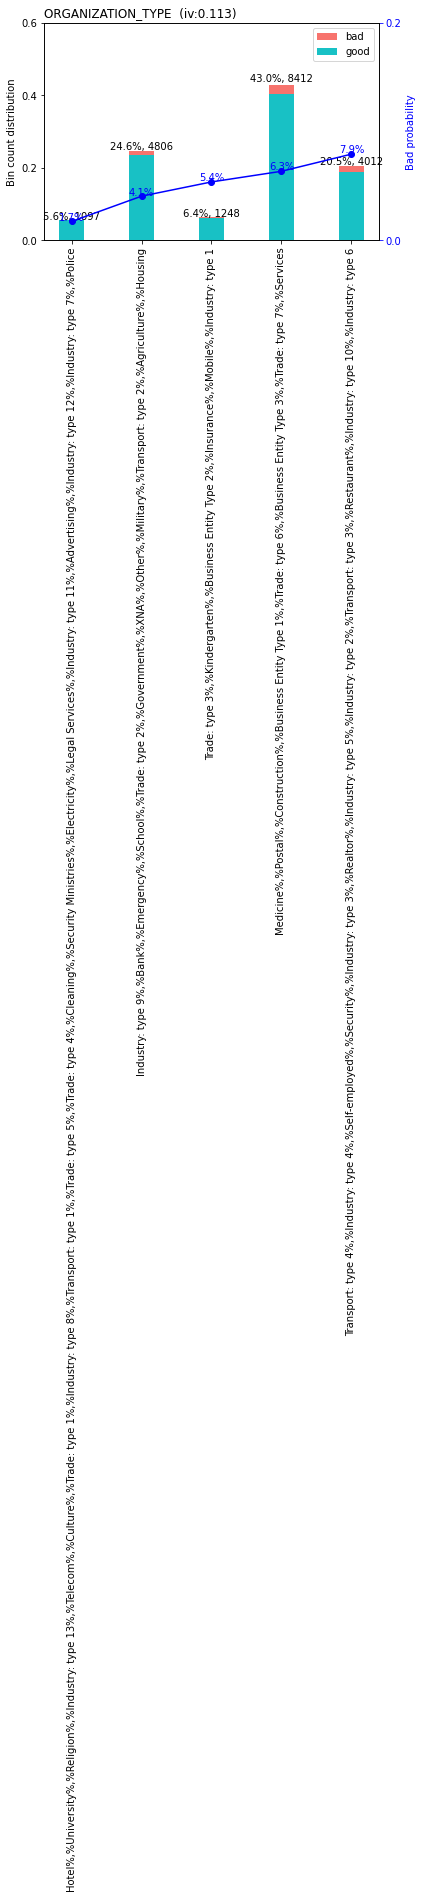

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable               bin  count  count_distr  good  bad  \
0  DAYS_CREDIT_Active_mean           missing   2173     0.111009  2100   73   
1  DAYS_CREDIT_Active_mean    [-inf,-1250.0)   1849     0.094457  1786   63   
2  DAYS_CREDIT_Active_mean  [-1250.0,-700.0)   5480     0.279949  5202  278   
3  DAYS_CREDIT_Active_mean   [-700.0,-400.0)   5420     0.276884  5054  366   
4  DAYS_CREDIT_Active_mean   [-400.0,-350.0)    981     0.050115   925   56   
5  DAYS_CREDIT_Active_mean      [-350.0,inf)   3672     0.187586  3375  297   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.033594 -0.569471  0.028155  0.092655  missing               True  
1  0.034072 -0.554837  0.022881  0.092655  -1250.0              False  
2  0.050730 -0.139416  0.005118  0.092655   -700.0              False  
3  0.067528  0.164460  0.008057  0.092655   -400.0              False  
4  0.057085 -0.014680  0.000011  0.092655   -350.0              False  
5  0.080882  0.359343  0.028435  0.092655      inf              False

Information Value: 0.09265536398745354
Bins: 0             missing
1      [-inf,-1250.0)
2    [-1250.0,-700.0)
3     [-700.0,-400.0)
4     [-400.0,-350.0)
5        [-350.0,inf)
Name: bin, dtype: object



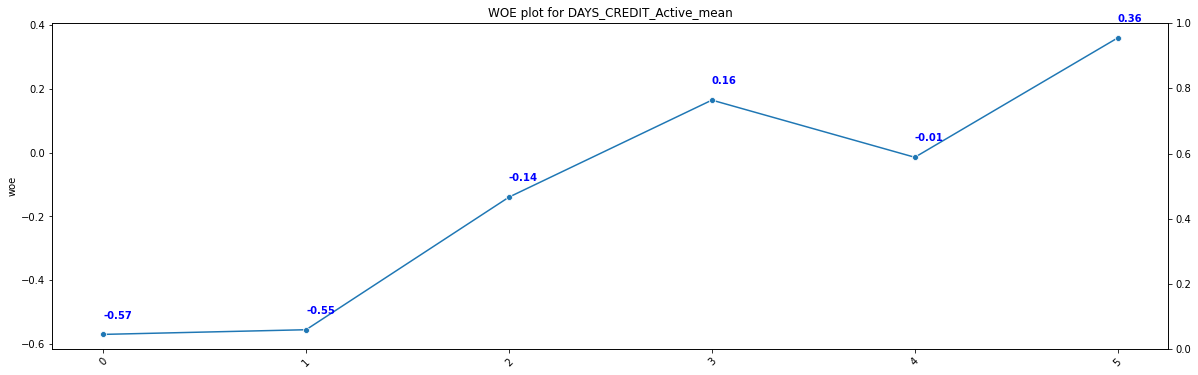

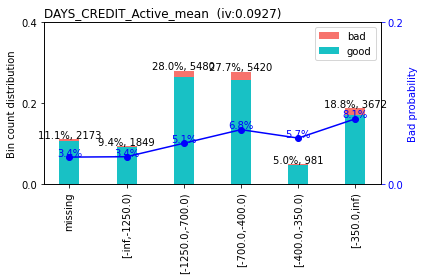

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable                bin  count  count_distr  good  bad   badprob  \
0  DAYS_EMPLOYED     [-inf,-6000.0)   1360     0.069476  1333   27  0.019853   
1  DAYS_EMPLOYED  [-6000.0,-4000.0)   2112     0.107893  2034   78  0.036932   
2  DAYS_EMPLOYED  [-4000.0,-2400.0)   4107     0.209808  3901  206  0.050158   
3  DAYS_EMPLOYED  [-2400.0,-1400.0)   3662     0.187075  3426  236  0.064446   
4  DAYS_EMPLOYED      [-1400.0,0.0)   7016     0.358416  6483  533  0.075969   
5  DAYS_EMPLOYED          [0.0,inf)   1318     0.067331  1265   53  0.040212   

        woe    bin_iv  total_iv   breaks  is_special_values  
0 -1.109589  0.053760  0.123359  -6000.0              False  
1 -0.471289  0.019534  0.123359  -4000.0              False  
2 -0.151350  0.004497  0.123359  -2400.0              False  
3  0.114445  0.002578  0.123359  -1400.0              False  
4  0.291344  0.034640  0.123359      0.0              False  
5 -0.382774  0.008350  0.123359      inf              False

Information Value: 0.12335859282136899
Bins: 0       [-inf,-6000.0)
1    [-6000.0,-4000.0)
2    [-4000.0,-2400.0)
3    [-2400.0,-1400.0)
4        [-1400.0,0.0)
5            [0.0,inf)
Name: bin, dtype: category
Categories (6, object): ['[-inf,-6000.0)' < '[-6000.0,-4000.0)' < '[-4000.0,-2400.0)' < '[-2400.0,-1400.0)' < '[-1400.0,0.0)' < '[0.0,inf)']



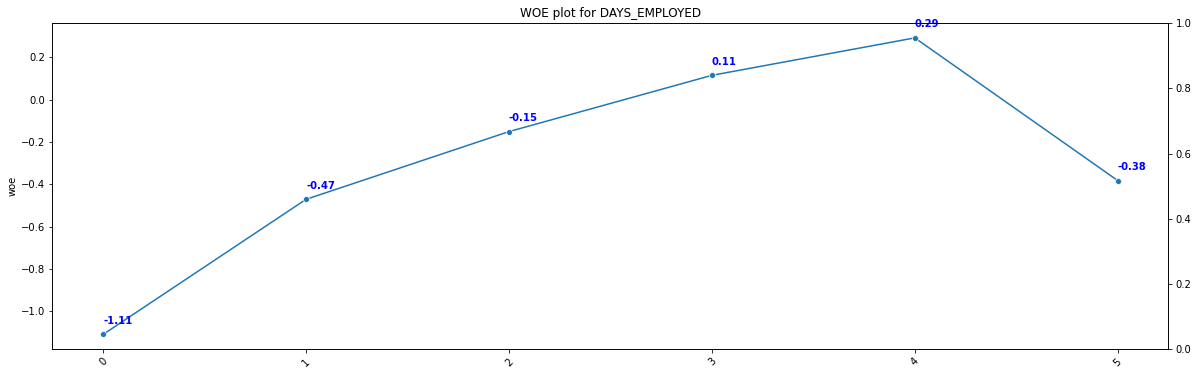

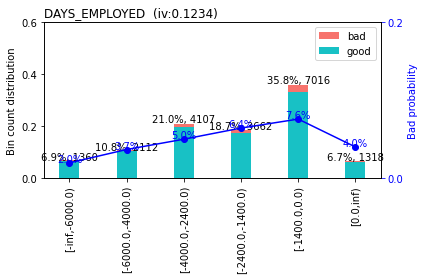

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable         bin  count  count_distr  good  bad   badprob  \
0  CREDIT_ACTIVE_Active     missing   2173     0.111009  2100   73  0.033594   
1  CREDIT_ACTIVE_Active  [-inf,2.0)   4392     0.224368  4197  195  0.044399   
2  CREDIT_ACTIVE_Active   [2.0,4.0)   7986     0.407969  7535  451  0.056474   
3  CREDIT_ACTIVE_Active   [4.0,5.0)   2280     0.116475  2110  170  0.074561   
4  CREDIT_ACTIVE_Active   [5.0,6.0)   1329     0.067893  1243   86  0.064710   
5  CREDIT_ACTIVE_Active   [6.0,inf)   1415     0.072286  1257  158  0.111661   

        woe    bin_iv  total_iv   breaks  is_special_values  
0 -0.569471  0.028155  0.105633  missing               True  
1 -0.279364  0.015496  0.105633      2.0              False  
2 -0.026085  0.000274  0.105633      4.0              False  
3  0.271117  0.009660  0.105633      5.0              False  
4  0.118826  0.001011  0.105633      6.0              False  
5  0.715874  0.051037  0.105633      inf              False

Information Value: 0.10563264699227097
Bins: 0       missing
1    [-inf,2.0)
2     [2.0,4.0)
3     [4.0,5.0)
4     [5.0,6.0)
5     [6.0,inf)
Name: bin, dtype: object



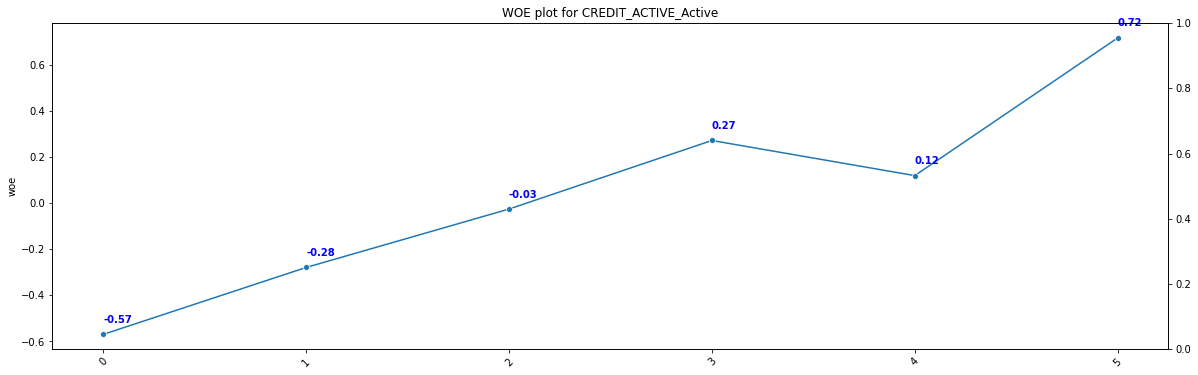

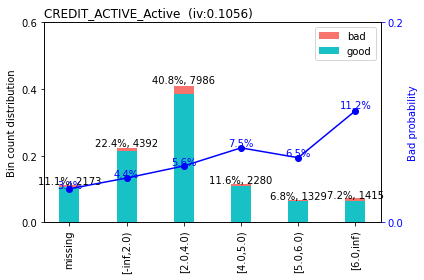

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable         bin  count  count_distr  good  bad   badprob       woe  \
0  OWN_CAR_AGE     missing   3967     0.202656  3700  267  0.067305  0.160922   
1  OWN_CAR_AGE  [-inf,6.0)   9226     0.471315  8800  426  0.046174 -0.238306   
2  OWN_CAR_AGE   [6.0,8.0)   2565     0.131034  2427  138  0.053801 -0.077396   
3  OWN_CAR_AGE   [8.0,inf)   3817     0.194994  3515  302  0.079120  0.335394   

     bin_iv  total_iv   breaks  is_special_values  
0  0.005637  0.055981  missing               True  
1  0.024111  0.055981      6.0              False  
2  0.000759  0.055981      8.0              False  
3  0.025474  0.055981      inf              False

Information Value: 0.05598059281052632
Bins: 0       missing
1    [-inf,6.0)
2     [6.0,8.0)
3     [8.0,inf)
Name: bin, dtype: object



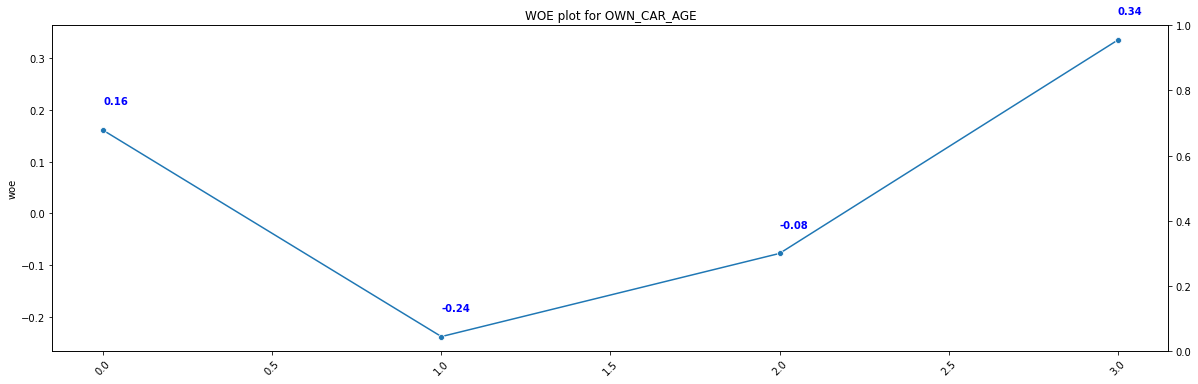

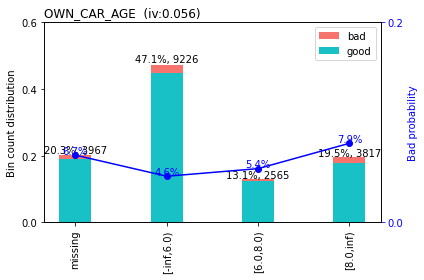

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable                                                bin  count  \
0  OCCUPATION_TYPE                                            missing   4025   
1  OCCUPATION_TYPE  HR staff%,%Waiters/barmen staff%,%Core staff%,...   1867   
2  OCCUPATION_TYPE     IT staff%,%Accountants%,%High skill tech staff   1895   
3  OCCUPATION_TYPE         Medicine staff%,%Security staff%,%Managers   4077   
4  OCCUPATION_TYPE             Laborers%,%Sales staff%,%Cooking staff   4842   
5  OCCUPATION_TYPE  Cleaning staff%,%Private service staff%,%Drive...   2869   

   count_distr  good  bad   badprob       woe    bin_iv  total_iv  \
0     0.205619  3816  209  0.051925 -0.114862  0.002579   0.07134   
1     0.095377  1801   66  0.035351 -0.516681  0.020360   0.07134   
2     0.096807  1813   82  0.043272 -0.306257  0.007942   0.07134   
3     0.208276  3859  218  0.053471 -0.083907  0.001413   0.07134   
4     0.247356  4537  305  0.062990  0.090052  0.002088   0.07134   
5     0.146564  2616  253  0.088184  0.453749  0.036958   0.07134   

                                              breaks  is_special_values  
0                                            missing               True  
1  HR staff%,%Waiters/barmen staff%,%Core staff%,...              False  
2     IT staff%,%Accountants%,%High skill tech staff              False  
3         Medicine staff%,%Security staff%,%Managers              False  
4             Laborers%,%Sales staff%,%Cooking staff              False  
5  Cleaning staff%,%Private service staff%,%Drive...              False

Information Value: 0.0713402981952865
Bins: 0                                              missing
1    HR staff%,%Waiters/barmen staff%,%Core staff%,...
2       IT staff%,%Accountants%,%High skill tech staff
3           Medicine staff%,%Security staff%,%Managers
4               Laborers%,%Sales staff%,%Cooking staff
5    Cleaning staff%,%Private service staff%,%Drive...
Name: bin, dtype: object



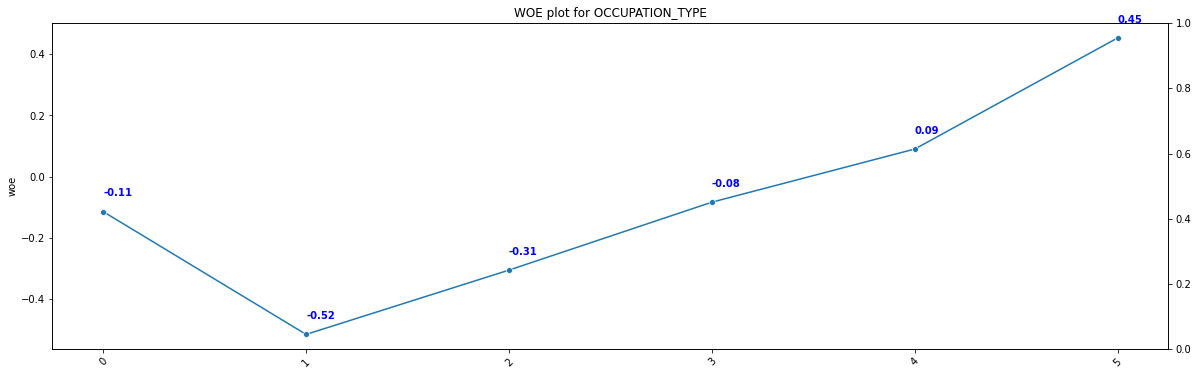

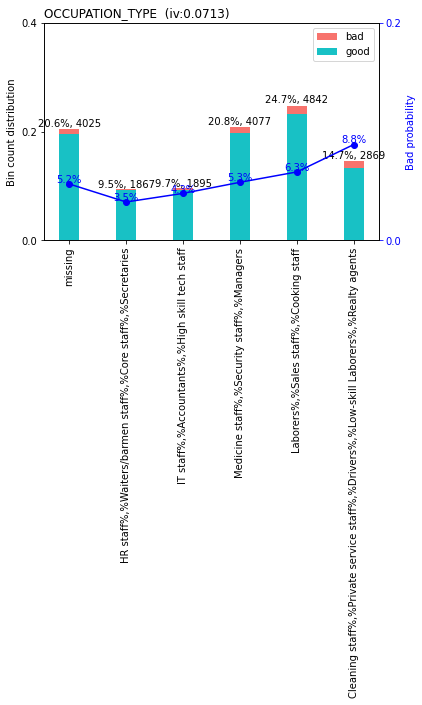

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable                                                bin  \
0  NAME_EDUCATION_TYPE                 Higher education%,%Academic degree   
1  NAME_EDUCATION_TYPE  Incomplete higher%,%Secondary / secondary spec...   

   count  count_distr   good  bad   badprob       woe    bin_iv  total_iv  \
0   7793      0.39811   7455  338  0.043372 -0.303833  0.032181  0.049513   
1  11782      0.60189  10987  795  0.067476  0.163636  0.017332  0.049513   

                                              breaks  is_special_values  
0                 Higher education%,%Academic degree              False  
1  Incomplete higher%,%Secondary / secondary spec...              False

Information Value: 0.049512984902792725
Bins: 0                   Higher education%,%Academic degree
1    Incomplete higher%,%Secondary / secondary spec...
Name: bin, dtype: object



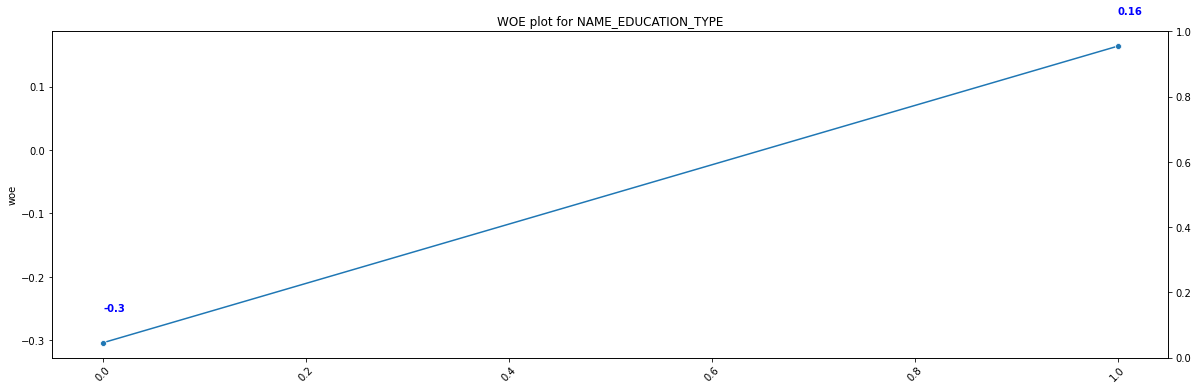

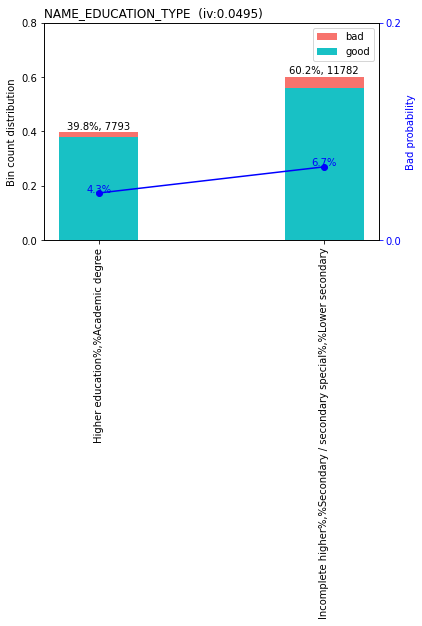

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable            bin  count  count_distr   good  bad   badprob  \
0  LANDAREA_AVG        missing  10723     0.547791  10031  692  0.064534   
1  LANDAREA_AVG   [-inf,0.005)   1379     0.070447   1326   53  0.038434   
2  LANDAREA_AVG  [0.005,0.025)   1390     0.071009   1304   86  0.061871   
3  LANDAREA_AVG  [0.025,0.055)   1976     0.100945   1867  109  0.055162   
4  LANDAREA_AVG   [0.055,0.08)   1395     0.071264   1337   58  0.041577   
5  LANDAREA_AVG    [0.08,0.11)   1068     0.054559   1009   59  0.055243   
6  LANDAREA_AVG     [0.11,inf)   1644     0.083985   1568   76  0.046229   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.115912  0.007748  0.030971  missing               True  
1 -0.429869  0.010799  0.030971    0.005              False  
2  0.070917  0.000369  0.030971    0.025              False  
3 -0.050979  0.000257  0.030971    0.055              False  
4 -0.347979  0.007414  0.030971     0.08              False  
5 -0.049416  0.000130  0.030971     0.11              False  
6 -0.237061  0.004254  0.030971      inf              False

Information Value: 0.03097116766011847
Bins: 0          missing
1     [-inf,0.005)
2    [0.005,0.025)
3    [0.025,0.055)
4     [0.055,0.08)
5      [0.08,0.11)
6       [0.11,inf)
Name: bin, dtype: object



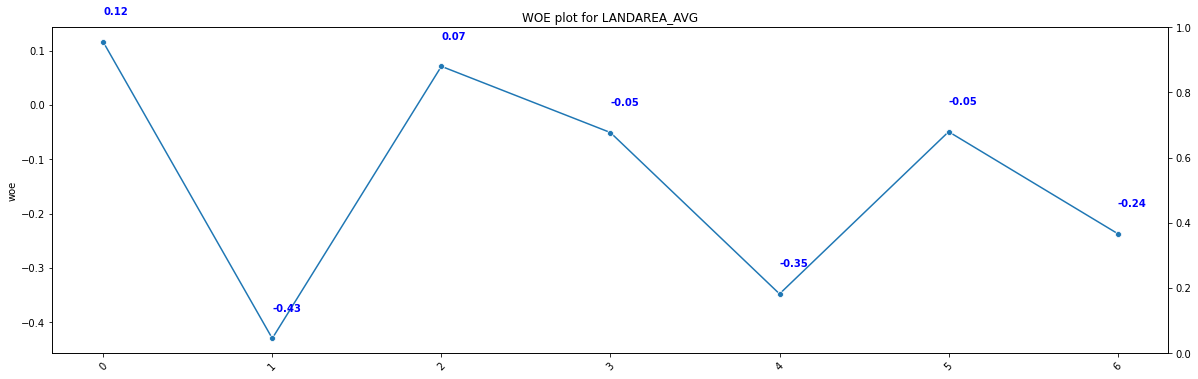

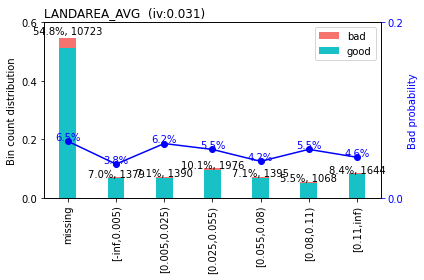

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable                             bin  count  count_distr  \
0  CREDIT_OVERDUE_RATIO    [-inf,0.0006000000000000001)  13813     0.705645   
1  CREDIT_OVERDUE_RATIO  [0.0006000000000000001,0.0032)   1906     0.097369   
2  CREDIT_OVERDUE_RATIO   [0.0032,0.006200000000000001)   1240     0.063346   
3  CREDIT_OVERDUE_RATIO      [0.006200000000000001,inf)   2616     0.133640   

    good  bad   badprob       woe    bin_iv  total_iv                 breaks  \
0  13108  705  0.051039 -0.133019  0.011776  0.039795  0.0006000000000000001   
1   1784  122  0.064008  0.107169  0.001173  0.039795                 0.0032   
2   1135  105  0.084677  0.409334  0.012743  0.039795   0.006200000000000001   
3   2415  201  0.076835  0.303612  0.014104  0.039795                    inf   

   is_special_values  
0              False  
1              False  
2              False  
3              False

Information Value: 0.039795074386895654
Bins: 0      [-inf,0.0006000000000000001)
1    [0.0006000000000000001,0.0032)
2     [0.0032,0.006200000000000001)
3        [0.006200000000000001,inf)
Name: bin, dtype: category
Categories (4, object): ['[-inf,0.0006000000000000001)' < '[0.0006000000000000001,0.0032)' < '[0.0032,0.006200000000000001)' < '[0.006200000000000001,inf)']



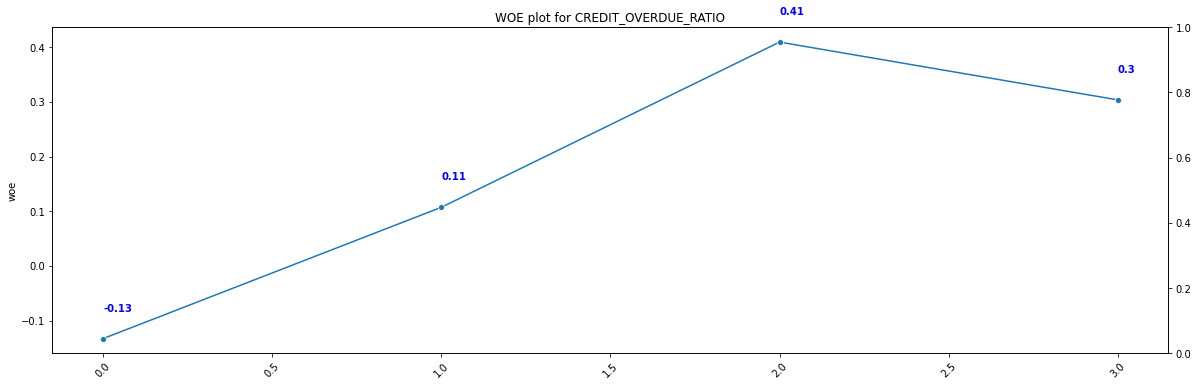

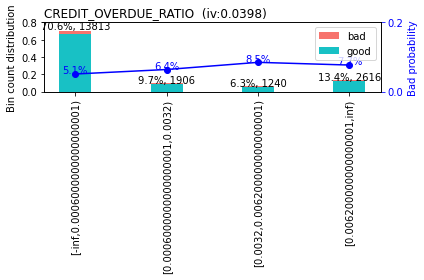

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable                  bin  count  count_distr  good  bad   badprob  \
0  DAYS_BIRTH      [-inf,-21500.0)   1212     0.061916  1166   46  0.037954   
1  DAYS_BIRTH  [-21500.0,-15500.0)   8185     0.418135  7754  431  0.052657   
2  DAYS_BIRTH  [-15500.0,-13500.0)   3940     0.201277  3717  223  0.056599   
3  DAYS_BIRTH       [-13500.0,inf)   6238     0.318672  5805  433  0.069413   

        woe    bin_iv  total_iv    breaks  is_special_values  
0 -0.442931  0.010021  0.027219  -21500.0              False  
1 -0.100094  0.004009  0.027219  -15500.0              False  
2 -0.023739  0.000112  0.027219  -13500.0              False  
3  0.194025  0.013077  0.027219       inf              False

Information Value: 0.027219470377608725
Bins: 0        [-inf,-21500.0)
1    [-21500.0,-15500.0)
2    [-15500.0,-13500.0)
3         [-13500.0,inf)
Name: bin, dtype: category
Categories (4, object): ['[-inf,-21500.0)' < '[-21500.0,-15500.0)' < '[-15500.0,-13500.0)' < '[-13500.0,inf)']



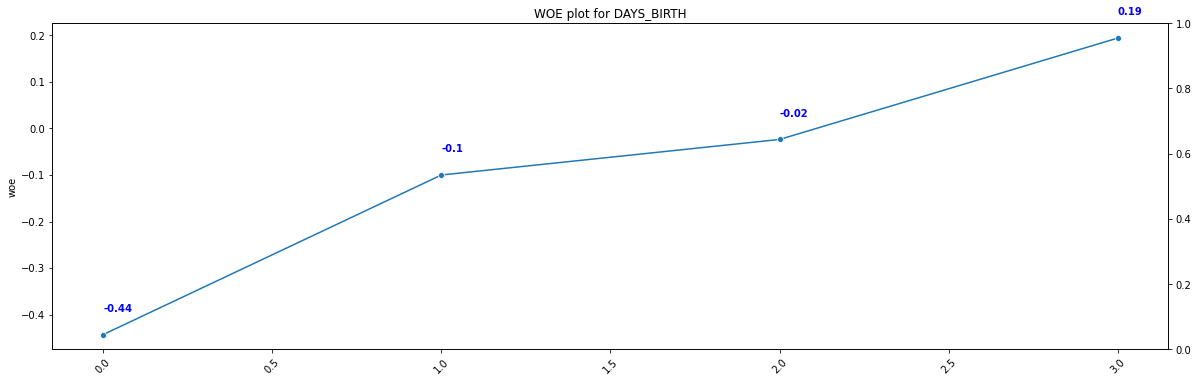

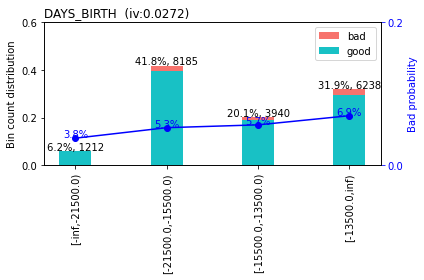

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable         bin  count  count_distr   good  bad  \
0  OBS_30_CNT_SOCIAL_CIRCLE     missing     89     0.004547     88    1   
1  OBS_30_CNT_SOCIAL_CIRCLE  [-inf,2.0)  13575     0.693487  12827  748   
2  OBS_30_CNT_SOCIAL_CIRCLE   [2.0,3.0)   1825     0.093231   1713  112   
3  OBS_30_CNT_SOCIAL_CIRCLE   [3.0,inf)   4086     0.208736   3814  272   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.011236 -1.687575  0.006563  0.013737  missing               True  
1  0.055101 -0.052143  0.001843  0.013737      2.0              False  
2  0.061370  0.062259  0.000371  0.013737      3.0              False  
3  0.066569  0.149130  0.004960  0.013737      inf              False

Information Value: 0.013737330481275402
Bins: 0       missing
1    [-inf,2.0)
2     [2.0,3.0)
3     [3.0,inf)
Name: bin, dtype: object



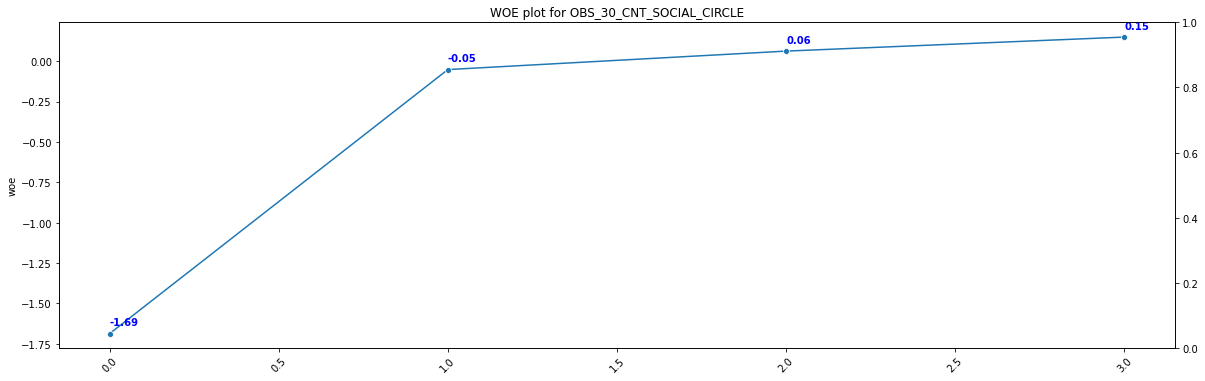

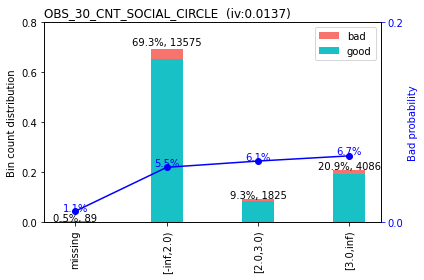

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable               bin  count  count_distr   good  bad  \
0  DAYS_CREDIT_UPDATE_MIN    [-inf,-1100.0)  11832     0.604444  11207  625   
1  DAYS_CREDIT_UPDATE_MIN  [-1100.0,-900.0)   1708     0.087254   1601  107   
2  DAYS_CREDIT_UPDATE_MIN   [-900.0,-650.0)   2134     0.109017   1986  148   
3  DAYS_CREDIT_UPDATE_MIN   [-650.0,-150.0)   2489     0.127152   2345  144   
4  DAYS_CREDIT_UPDATE_MIN      [-150.0,inf)   1412     0.072133   1303  109   

    badprob       woe        bin_iv  total_iv   breaks  is_special_values  
0  0.052823 -0.096781  5.425142e-03  0.018384  -1100.0              False  
1  0.062646  0.084207  6.422311e-04  0.018384   -900.0              False  
2  0.069353  0.193096  4.429178e-03  0.018384   -650.0              False  
3  0.057855 -0.000466  2.756956e-08  0.018384   -150.0              False  
4  0.077195  0.308685  7.887156e-03  0.018384      inf              False

Information Value: 0.018383734726930973
Bins: 0      [-inf,-1100.0)
1    [-1100.0,-900.0)
2     [-900.0,-650.0)
3     [-650.0,-150.0)
4        [-150.0,inf)
Name: bin, dtype: category
Categories (5, object): ['[-inf,-1100.0)' < '[-1100.0,-900.0)' < '[-900.0,-650.0)' < '[-650.0,-150.0)' < '[-150.0,inf)']



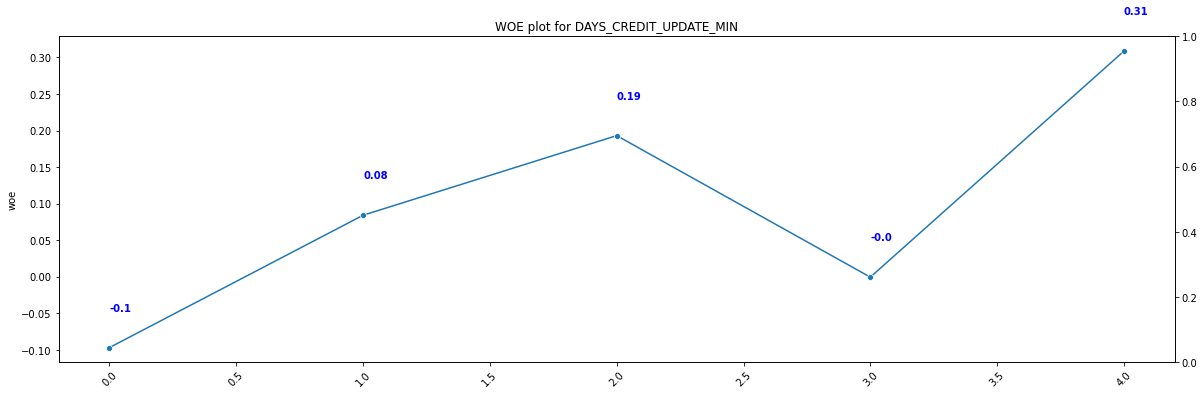

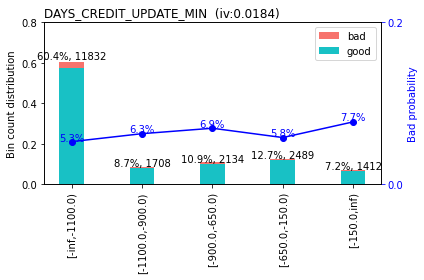

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable         bin  count  count_distr   good  bad  \
0  AMT_REQ_CREDIT_BUREAU_QRT  [-inf,1.0)  16076     0.821252  15120  956   
1  AMT_REQ_CREDIT_BUREAU_QRT   [1.0,2.0)   2357     0.120409   2252  105   
2  AMT_REQ_CREDIT_BUREAU_QRT   [2.0,inf)   1142     0.058340   1070   72   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.059468  0.028746  0.000687  0.009311    1.0              False  
1  0.044548 -0.275852  0.008121  0.009311    2.0              False  
2  0.063047  0.091014  0.000503  0.009311    inf              False

Information Value: 0.009311069987933301
Bins: 0    [-inf,1.0)
1     [1.0,2.0)
2     [2.0,inf)
Name: bin, dtype: category
Categories (3, object): ['[-inf,1.0)' < '[1.0,2.0)' < '[2.0,inf)']



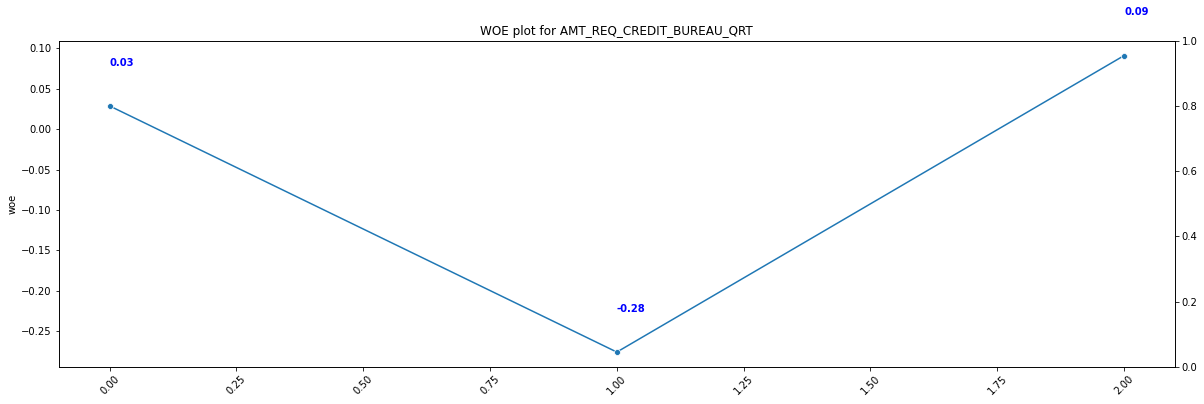

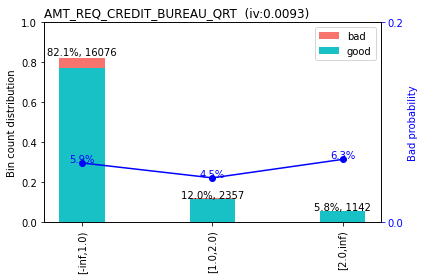

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable               bin  count  count_distr   good  \
0  AMT_CREDIT_SUM_LIMIT_MEAN           missing   1662     0.084904   1558   
1  AMT_CREDIT_SUM_LIMIT_MEAN     [-inf,2000.0)  14858     0.759029  14040   
2  AMT_CREDIT_SUM_LIMIT_MEAN  [2000.0,34000.0)   1964     0.100332   1816   
3  AMT_CREDIT_SUM_LIMIT_MEAN     [34000.0,inf)   1091     0.055734   1028   

   bad   badprob       woe        bin_iv  total_iv   breaks  is_special_values  
0  104  0.062575  0.082994  6.067409e-04   0.01178  missing               True  
1  818  0.055055 -0.053042  2.086057e-03   0.01178   2000.0              False  
2  148  0.075356  0.282582  9.086656e-03   0.01178  34000.0              False  
3   63  0.057745 -0.002474  3.407672e-07   0.01178      inf              False

Information Value: 0.01177979458971678
Bins: 0             missing
1       [-inf,2000.0)
2    [2000.0,34000.0)
3       [34000.0,inf)
Name: bin, dtype: object



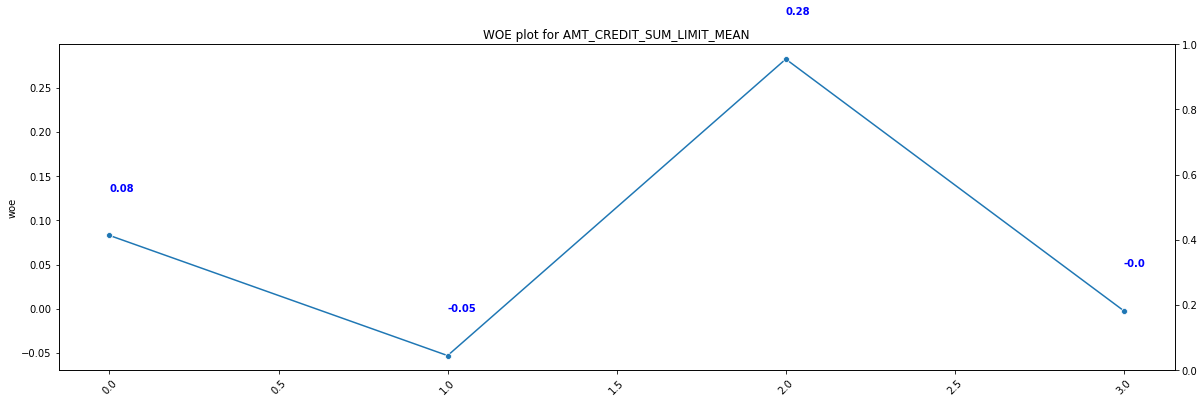

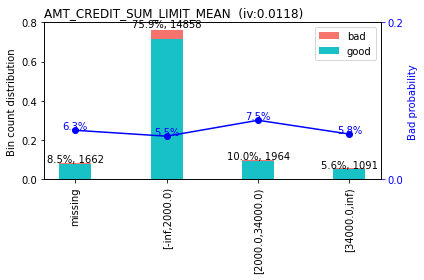

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable         bin  count  count_distr   good  bad  \
0  DEF_30_CNT_SOCIAL_CIRCLE     missing     89     0.004547     88    1   
1  DEF_30_CNT_SOCIAL_CIRCLE  [-inf,1.0)  17460     0.891954  16477  983   
2  DEF_30_CNT_SOCIAL_CIRCLE   [1.0,inf)   2026     0.103499   1877  149   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.011236 -1.687575  0.006563  0.014941  missing               True  
1  0.056300 -0.029350  0.000758  0.014941      1.0              False  
2  0.073544  0.256278  0.007619  0.014941      inf              False

Information Value: 0.014940933138476463
Bins: 0       missing
1    [-inf,1.0)
2     [1.0,inf)
Name: bin, dtype: object



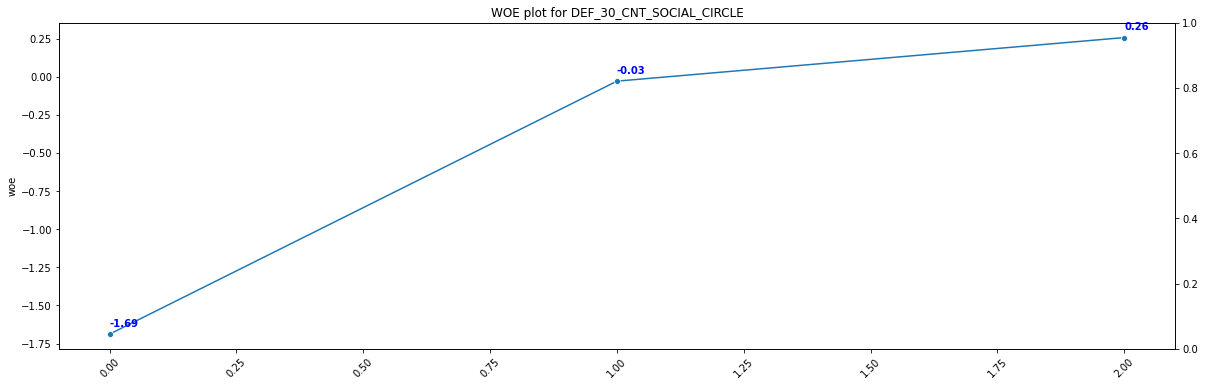

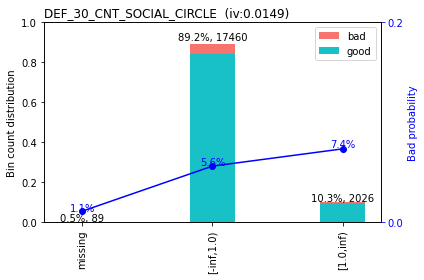

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable         bin  count  count_distr   good  bad  \
0  AMT_REQ_CREDIT_BUREAU_YEAR  [-inf,3.0)  14039     0.717190  13275  764   
1  AMT_REQ_CREDIT_BUREAU_YEAR   [3.0,4.0)   2403     0.122759   2254  149   
2  AMT_REQ_CREDIT_BUREAU_YEAR   [4.0,5.0)   1496     0.076424   1385  111   
3  AMT_REQ_CREDIT_BUREAU_YEAR   [5.0,inf)   1637     0.083627   1528  109   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.054420 -0.065308  0.002972  0.011726    3.0              False  
1  0.062006  0.073246  0.000680  0.011726    4.0              False  
2  0.074198  0.265836  0.006080  0.011726    5.0              False  
3  0.066585  0.149395  0.001994  0.011726    inf              False

Information Value: 0.011726478920390837
Bins: 0    [-inf,3.0)
1     [3.0,4.0)
2     [4.0,5.0)
3     [5.0,inf)
Name: bin, dtype: category
Categories (4, object): ['[-inf,3.0)' < '[3.0,4.0)' < '[4.0,5.0)' < '[5.0,inf)']



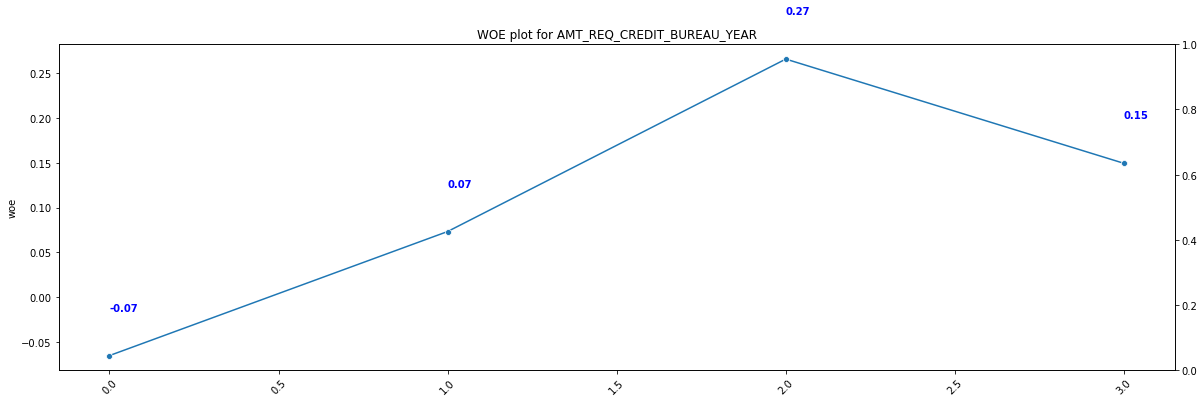

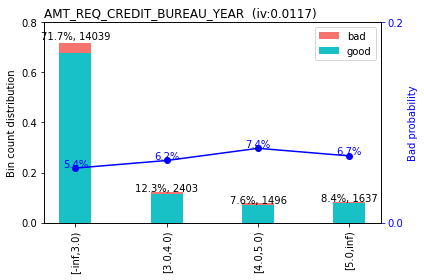

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable bin  count  count_distr   good  bad   badprob       woe  \
0  FLAG_OWN_REALTY   N   6393      0.32659   6059  334  0.052245 -0.108397   
1  FLAG_OWN_REALTY   Y  13182      0.67341  12383  799  0.060613  0.049043   

     bin_iv  total_iv breaks  is_special_values  
0  0.003659  0.005314      N              False  
1  0.001655  0.005314      Y              False

Information Value: 0.005313755840856096
Bins: 0    N
1    Y
Name: bin, dtype: object



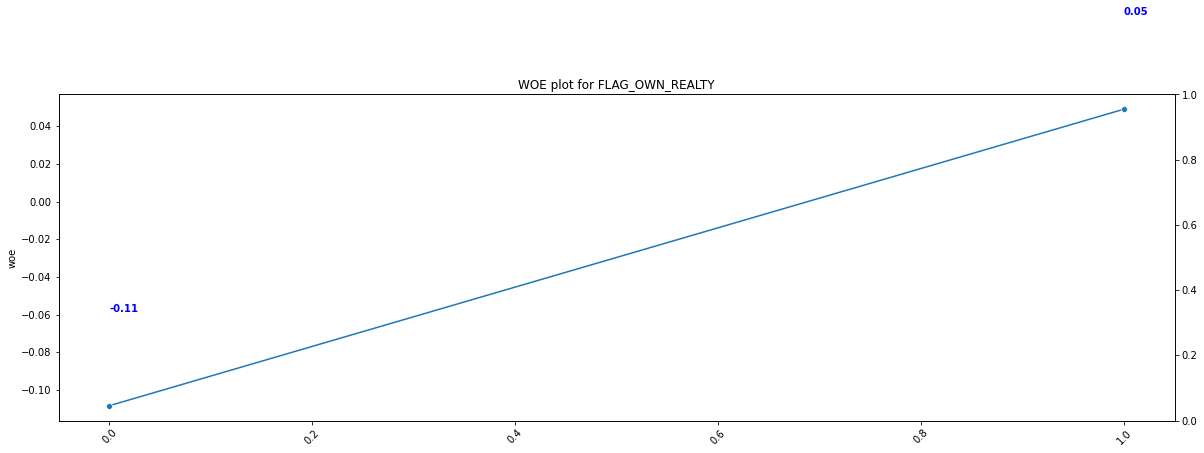

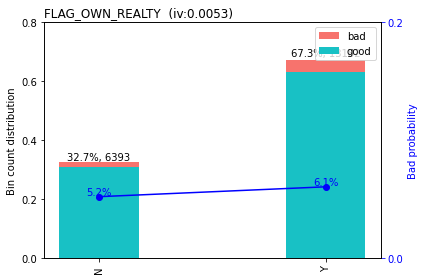

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable bin  count  count_distr   good  bad   badprob       woe  \
0  FLAG_OWN_CAR   Y  15608     0.797344  14742  866  0.055484 -0.044809   
1  FLAG_OWN_CAR   N   3967     0.202656   3700  267  0.067305  0.160922   

     bin_iv  total_iv breaks  is_special_values  
0  0.001570  0.007206      Y              False  
1  0.005637  0.007206      N              False

Information Value: 0.00720647533477827
Bins: 0    Y
1    N
Name: bin, dtype: object



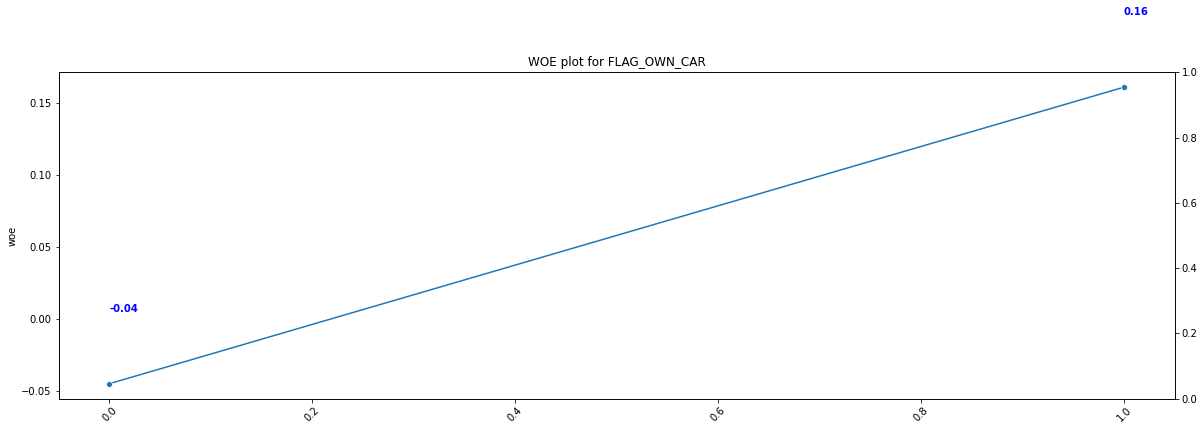

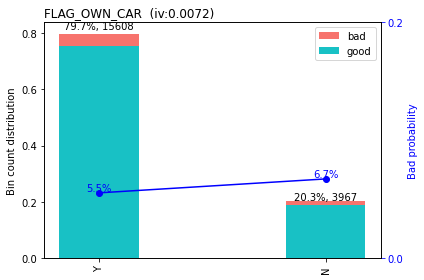

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable         bin  count  count_distr   good  bad   badprob  \
0  CNT_FAM_MEMBERS  [-inf,2.0)   2449     0.125109   2299  150  0.061249   
1  CNT_FAM_MEMBERS   [2.0,3.0)  10783     0.550856  10173  610  0.056571   
2  CNT_FAM_MEMBERS   [3.0,4.0)   4031     0.205926   3790  241  0.059787   
3  CNT_FAM_MEMBERS   [4.0,inf)   2312     0.118110   2180  132  0.057093   

        woe    bin_iv  total_iv breaks  is_special_values  
0  0.060167  0.000465  0.001059    2.0              False  
1 -0.024272  0.000321  0.001059    3.0              False  
2  0.034437  0.000248  0.001059    4.0              False  
3 -0.014517  0.000025  0.001059    inf              False

Information Value: 0.0010588947677191243
Bins: 0    [-inf,2.0)
1     [2.0,3.0)
2     [3.0,4.0)
3     [4.0,inf)
Name: bin, dtype: category
Categories (4, object): ['[-inf,2.0)' < '[2.0,3.0)' < '[3.0,4.0)' < '[4.0,inf)']



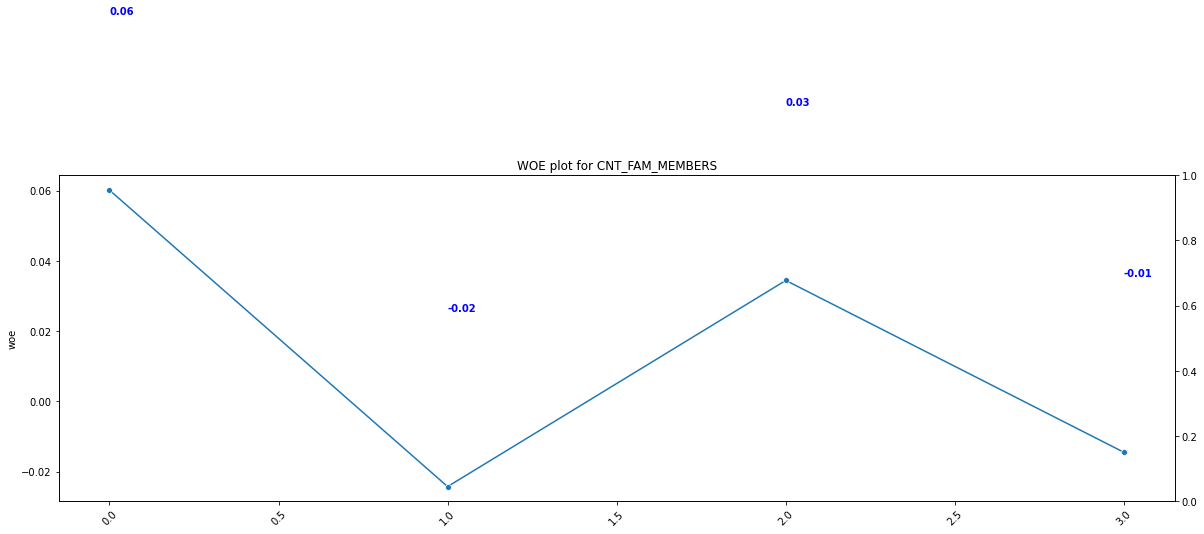

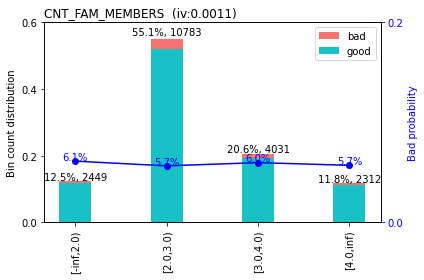

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable         bin  count  count_distr   good  bad  \
0  AMT_REQ_CREDIT_BUREAU_MON  [-inf,1.0)  15389     0.786156  14500  889   
1  AMT_REQ_CREDIT_BUREAU_MON   [1.0,2.0)   2881     0.147178   2688  193   
2  AMT_REQ_CREDIT_BUREAU_MON   [2.0,inf)   1305     0.066667   1254   51   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.057769 -0.002045  0.000003  0.013318    1.0              False  
1  0.066991  0.155899  0.003834  0.013318    2.0              False  
2  0.039080 -0.412506  0.009481  0.013318    inf              False

Information Value: 0.013317772972796979
Bins: 0    [-inf,1.0)
1     [1.0,2.0)
2     [2.0,inf)
Name: bin, dtype: category
Categories (3, object): ['[-inf,1.0)' < '[1.0,2.0)' < '[2.0,inf)']



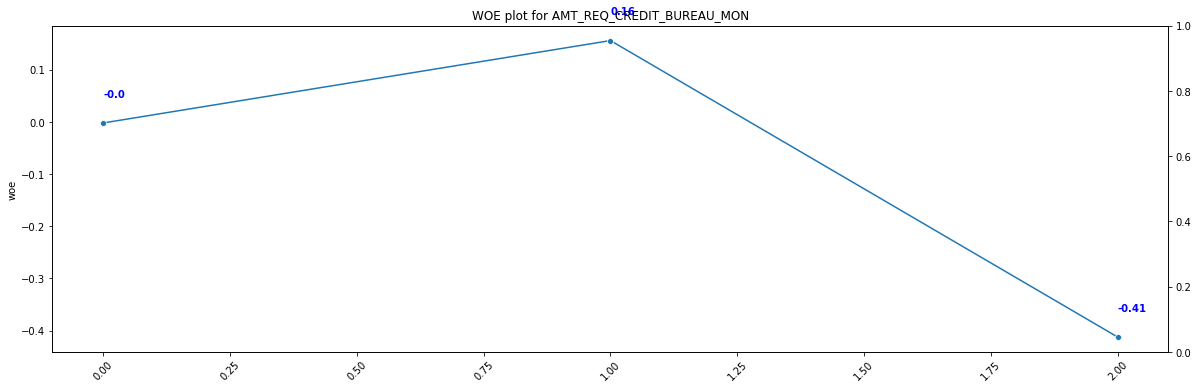

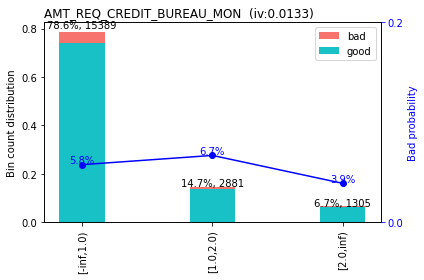

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable                                                bin  \
0  NAME_HOUSING_TYPE               Office apartment%,%House / apartment   
1  NAME_HOUSING_TYPE  Municipal apartment%,%Rented apartment%,%With ...   

   count  count_distr   good   bad   badprob       woe    bin_iv  total_iv  \
0  17960     0.917497  16945  1015  0.056514 -0.025323  0.000582  0.006308   
1   1615     0.082503   1497   118  0.073065  0.249228  0.005726  0.006308   

                                              breaks  is_special_values  
0               Office apartment%,%House / apartment              False  
1  Municipal apartment%,%Rented apartment%,%With ...              False

Information Value: 0.006307760602440138
Bins: 0                 Office apartment%,%House / apartment
1    Municipal apartment%,%Rented apartment%,%With ...
Name: bin, dtype: object



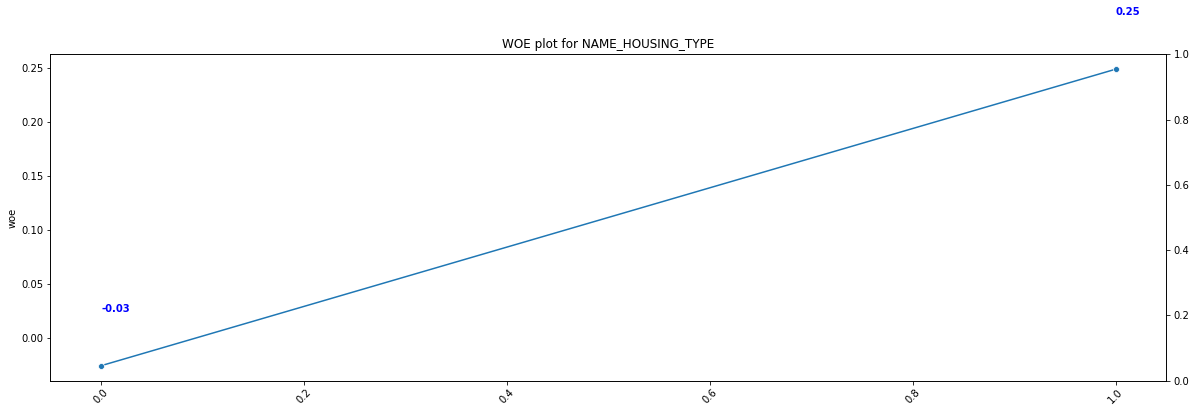

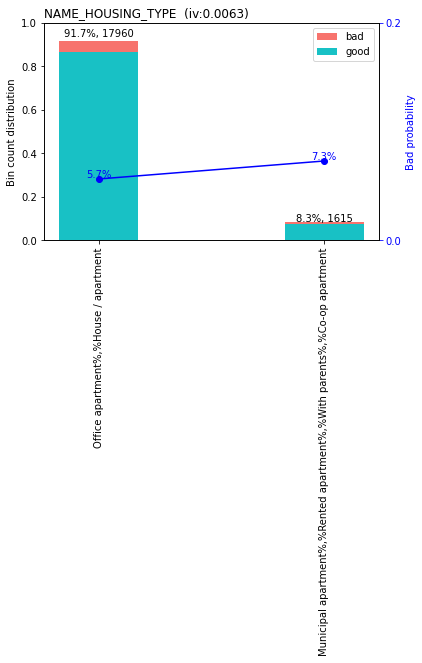

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable                           bin  count  count_distr  \
0  NAME_FAMILY_STATUS                       Married  15000     0.766284   
1  NAME_FAMILY_STATUS  Widow%,%Single / not married   2159     0.110294   
2  NAME_FAMILY_STATUS                     Separated    984     0.050268   
3  NAME_FAMILY_STATUS                Civil marriage   1432     0.073155   

    good  bad   badprob       woe    bin_iv  total_iv  \
0  14160  840  0.056000 -0.035013  0.000925  0.005246   
1   2030  129  0.059750  0.033783  0.000128  0.005246   
2    921   63  0.064024  0.107436  0.000609  0.005246   
3   1331  101  0.070531  0.211196  0.003584  0.005246   

                         breaks  is_special_values  
0                       Married              False  
1  Widow%,%Single / not married              False  
2                     Separated              False  
3                Civil marriage              False

Information Value: 0.00524564033379082
Bins: 0                         Married
1    Widow%,%Single / not married
2                       Separated
3                  Civil marriage
Name: bin, dtype: object



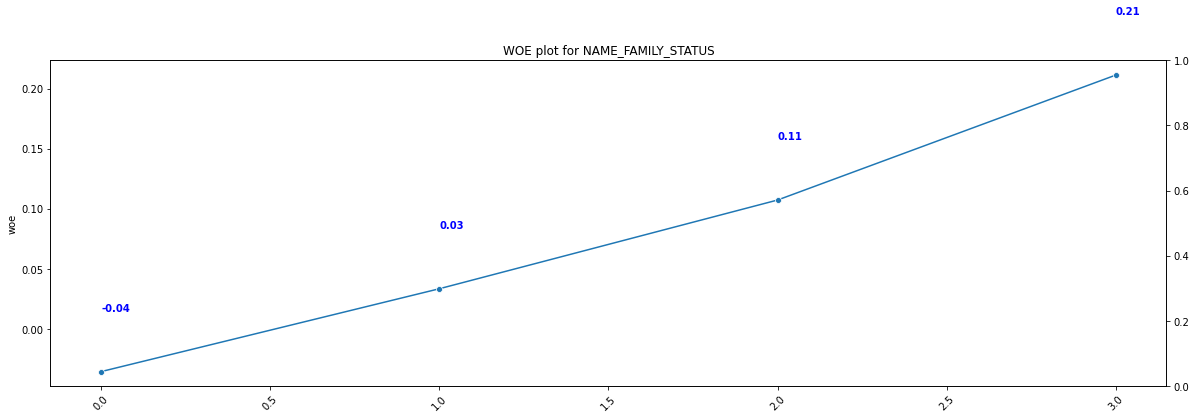

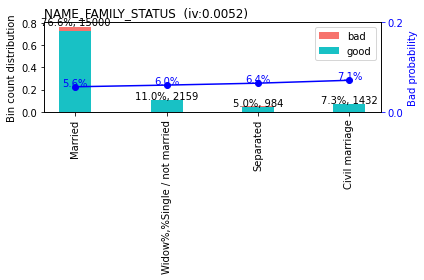

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable                    bin  count  count_distr  good  bad  \
0  DEBT_TO_INCOME_RATIO                missing   2173     0.111009  2100   73   
1  DEBT_TO_INCOME_RATIO        [-inf,350000.0)   3762     0.192184  3550  212   
2  DEBT_TO_INCOME_RATIO    [350000.0,850000.0)   7369     0.376450  6814  555   
3  DEBT_TO_INCOME_RATIO   [850000.0,1250000.0)   3557     0.181711  3394  163   
4  DEBT_TO_INCOME_RATIO  [1250000.0,1550000.0)   1582     0.080817  1485   97   
5  DEBT_TO_INCOME_RATIO        [1550000.0,inf)   1132     0.057829  1099   33   

    badprob       woe    bin_iv  total_iv     breaks  is_special_values  
0  0.033594 -0.569471  0.028155  0.094265    missing               True  
1  0.056353 -0.028355  0.000153  0.094265   350000.0              False  
2  0.075316  0.281995  0.033943  0.094265   850000.0              False  
3  0.045825 -0.246253  0.009892  0.094265  1250000.0              False  
4  0.061315  0.061303  0.000312  0.094265  1550000.0              False  
5  0.029152 -0.715887  0.021810  0.094265        inf              False

Information Value: 0.09426454137812798
Bins: 0                  missing
1          [-inf,350000.0)
2      [350000.0,850000.0)
3     [850000.0,1250000.0)
4    [1250000.0,1550000.0)
5          [1550000.0,inf)
Name: bin, dtype: object



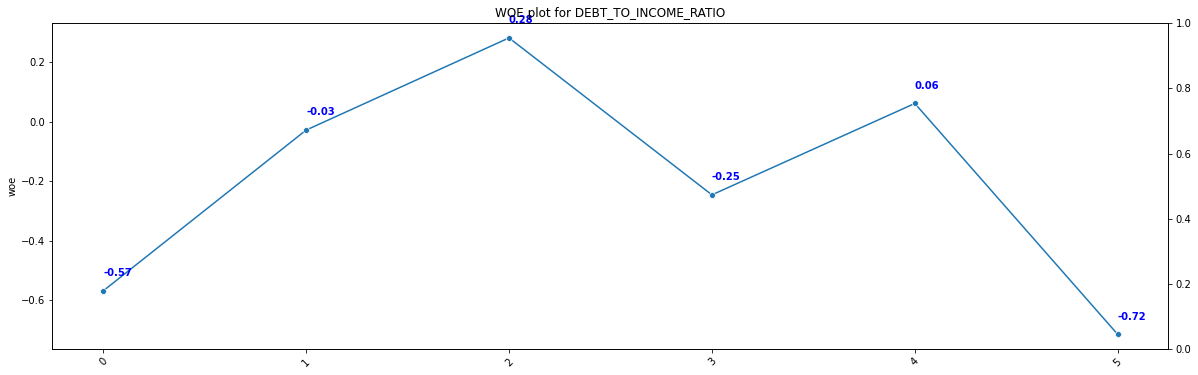

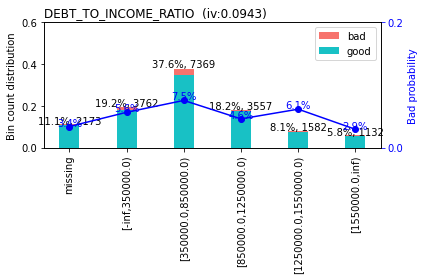

----------------------------------------------------------------------------------------------------
[INFO] creating woe binning ...


variable                 bin  count  count_distr  good  bad   badprob  \
0  TOTAL_ANNUITY             missing   2174     0.111060  2101   73  0.033579   
1  TOTAL_ANNUITY      [-inf,14000.0)   1515     0.077395  1438   77  0.050825   
2  TOTAL_ANNUITY   [14000.0,18000.0)    989     0.050524   918   71  0.071790   
3  TOTAL_ANNUITY   [18000.0,22000.0)   1259     0.064317  1202   57  0.045274   
4  TOTAL_ANNUITY   [22000.0,38000.0)   6175     0.315453  5747  428  0.069312   
5  TOTAL_ANNUITY   [38000.0,42000.0)   1120     0.057216  1059   61  0.054464   
6  TOTAL_ANNUITY   [42000.0,50000.0)   1787     0.091290  1713   74  0.041410   
7  TOTAL_ANNUITY  [50000.0,110000.0)   3263     0.166692  3073  190  0.058229   
8  TOTAL_ANNUITY      [110000.0,inf)   1293     0.066054  1191  102  0.078886   

        woe    bin_iv  total_iv    breaks  is_special_values  
0 -0.569948  0.028209   0.06753   missing               True  
1 -0.137441  0.001376   0.06753   14000.0              False  
2  0.230244  0.002967   0.06753   18000.0              False  
3 -0.258929  0.003850   0.06753   22000.0              False  
4  0.192452  0.012727   0.06753   38000.0              False  
5 -0.064445  0.000231   0.06753   42000.0              False  
6 -0.352175  0.009710   0.06753   50000.0              False  
7  0.006376  0.000007   0.06753  110000.0              False  
8  0.332186  0.008453   0.06753       inf              False

Information Value: 0.06753048905107283
Bins: 0               missing
1        [-inf,14000.0)
2     [14000.0,18000.0)
3     [18000.0,22000.0)
4     [22000.0,38000.0)
5     [38000.0,42000.0)
6     [42000.0,50000.0)
7    [50000.0,110000.0)
8        [110000.0,inf)
Name: bin, dtype: object



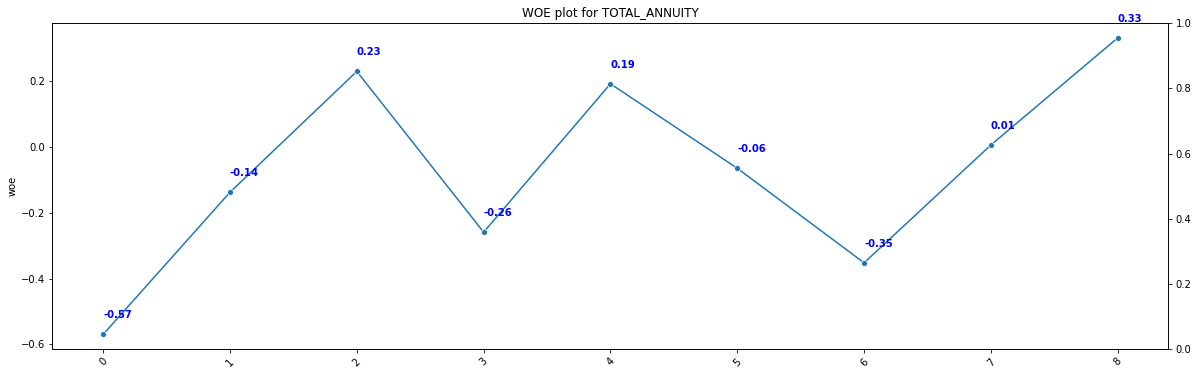

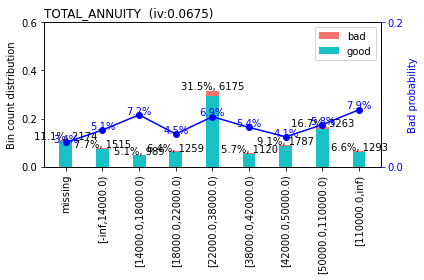

----------------------------------------------------------------------------------------------------


In [6]:
# create IV calc and WOE plotting function
def woe_iv_plot(data, variable_name):
    IV = data['total_iv'][0]
    BINS = data['bin']
    print('Information Value:', IV)
    print(f'Bins: {BINS}\n')
    fig, ax1 = plt.subplots(figsize=(20,6))
    sns.lineplot(data = data['woe'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)
    
    # add WOE values to the plot. i is x axis, v is y axis
    for i, v in enumerate(data['woe']):
        plt.text(i, v + 0.05, str(round(v, 2)), color='blue', fontweight='bold')
    
    # Create the scatter plot to plot the Missing WOE data point
    last_point = len(data['woe']) - 1
    scatter_plot = sns.scatterplot(x=[last_point], y=[data['woe'][last_point]], color='b', s=30, ax=ax1)
    ax2 = ax1.twinx()
    
    
    plt.title("WOE plot for " + variable_name)
    plt.show()

dataframe = data_df2.copy()
TARGET = 'TARGET'

# make it easy to read the bins
for variable in dataframe.columns[1:]:
    
    # automatically calculate bin ranges 
    bins = sc.woebin(dataframe[[variable, TARGET]], y=TARGET)
    skip_variable = False
    if bins == {}:
        print(f"IV is 0.0. There were no bins suitable for this category")
        print("--"*50)
        skip_variable = True
        continue
    # make it easy to read the bins
    for variables , bindetails in bins.items():
        display(bindetails)
        if not skip_variable:
            # Plot WOE and IV
            woe_iv_plot(bindetails, variable)
            
            # plot the sc.woebin bins
            plots = sc.woebin_plot(bins) # this plot prob of target event. NOT IV

            # Loop through each figure and rotate the x-axis labels
            for fig in plots.values():
                for ax in fig.get_axes():
                    for label in ax.get_xticklabels():
                        label.set_rotation(90)  # Rotate labels by 45 degrees

                # Adjust the layout to prevent labels from overlapping
                fig.tight_layout()
                plt.show()

        print("--"*50)

## Coarse Classing Monotonicity Fix

[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
ORGANIZATION_TYPE
>>> Continue the binning process?
1: yes 
2: no
Selection: 1


variable                                                bin  \
0  ORGANIZATION_TYPE  Hotel%,%University%,%Religion%,%Industry: type...   
1  ORGANIZATION_TYPE  Industry: type 9%,%Bank%,%Emergency%,%School%,...   
2  ORGANIZATION_TYPE  Trade: type 3%,%Kindergarten%,%Business Entity...   
3  ORGANIZATION_TYPE  Medicine%,%Postal%,%Construction%,%Business En...   
4  ORGANIZATION_TYPE  Transport: type 4%,%Industry: type 4%,%Self-em...   

   count  count_distr  good  bad   badprob       woe    bin_iv  total_iv  \
0   1097     0.056041  1078   19  0.017320 -1.248662  0.052049  0.112989   
1   4806     0.245517  4611  195  0.040574 -0.373439  0.029097  0.112989   
2   1248     0.063755  1181   67  0.053686 -0.079663  0.000391  0.112989   
3   8412     0.429732  7878  534  0.063481  0.098328  0.004340  0.112989   
4   4012     0.204955  3694  318  0.079262  0.337348  0.027112  0.112989   

                                              breaks  is_special_values  
0  Hotel%,%University%,%Religion%,%Industry: type...              False  
1  Industry: type 9%,%Bank%,%Emergency%,%School%,...              False  
2  Trade: type 3%,%Kindergarten%,%Business Entity...              False  
3  Medicine%,%Postal%,%Construction%,%Business En...              False  
4  Transport: type 4%,%Industry: type 4%,%Self-em...              False

ORGANIZATION_TYPE
Information Value: 0.11298889782169463
Bins: 0    Hotel%,%University%,%Religion%,%Industry: type...
1    Industry: type 9%,%Bank%,%Emergency%,%School%,...
2    Trade: type 3%,%Kindergarten%,%Business Entity...
3    Medicine%,%Postal%,%Construction%,%Business En...
4    Transport: type 4%,%Industry: type 4%,%Self-em...
Name: bin, dtype: object



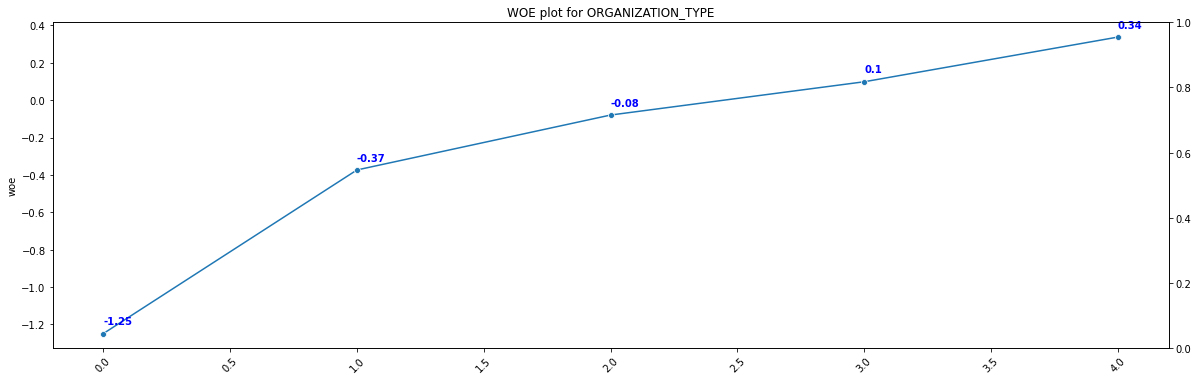

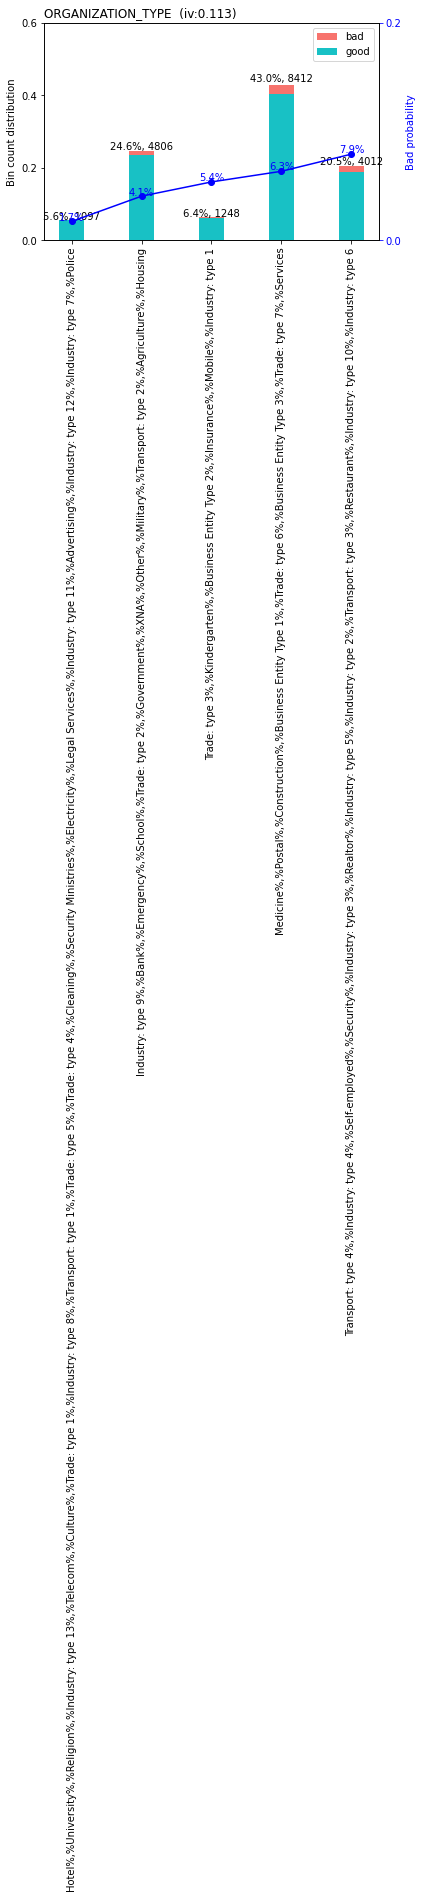

----------------------------------------------------------------------------------------------------


variable                             bin  count  count_distr  \
0  CREDIT_OVERDUE_RATIO    [-inf,0.0006000000000000001)  13813     0.705645   
1  CREDIT_OVERDUE_RATIO  [0.0006000000000000001,0.0032)   1906     0.097369   
2  CREDIT_OVERDUE_RATIO                    [0.0032,inf)   3856     0.196986   

    good  bad   badprob       woe    bin_iv  total_iv                 breaks  \
0  13108  705  0.051039 -0.133019  0.011776  0.039222  0.0006000000000000001   
1   1784  122  0.064008  0.107169  0.001173  0.039222                 0.0032   
2   3550  306  0.079357  0.338644  0.026273  0.039222                    inf   

   is_special_values  
0              False  
1              False  
2              False

CREDIT_OVERDUE_RATIO
Information Value: 0.03922185924485923
Bins: 0      [-inf,0.0006000000000000001)
1    [0.0006000000000000001,0.0032)
2                      [0.0032,inf)
Name: bin, dtype: object



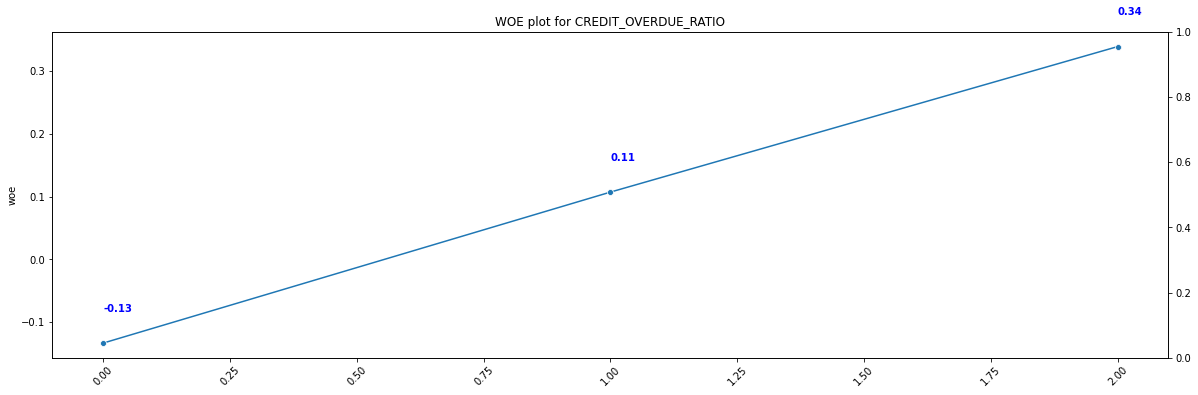

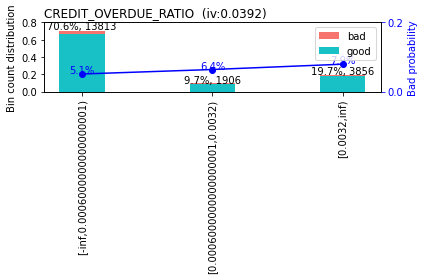

----------------------------------------------------------------------------------------------------


variable               bin  count  count_distr  good  bad  \
0  DAYS_CREDIT_Active_mean           missing   2173     0.111009  2100   73   
1  DAYS_CREDIT_Active_mean    [-inf,-1250.0)   1849     0.094457  1786   63   
2  DAYS_CREDIT_Active_mean  [-1250.0,-700.0)   5480     0.279949  5202  278   
3  DAYS_CREDIT_Active_mean   [-700.0,-400.0)   5420     0.276884  5054  366   
4  DAYS_CREDIT_Active_mean      [-400.0,inf)   4653     0.237701  4300  353   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.033594 -0.569471  0.028155  0.086935  missing               True  
1  0.034072 -0.554837  0.022881  0.086935  -1250.0              False  
2  0.050730 -0.139416  0.005118  0.086935   -700.0              False  
3  0.067528  0.164460  0.008057  0.086935   -400.0              False  
4  0.075865  0.289859  0.022725  0.086935      inf              False

DAYS_CREDIT_Active_mean
Information Value: 0.08693452773822172
Bins: 0             missing
1      [-inf,-1250.0)
2    [-1250.0,-700.0)
3     [-700.0,-400.0)
4        [-400.0,inf)
Name: bin, dtype: object



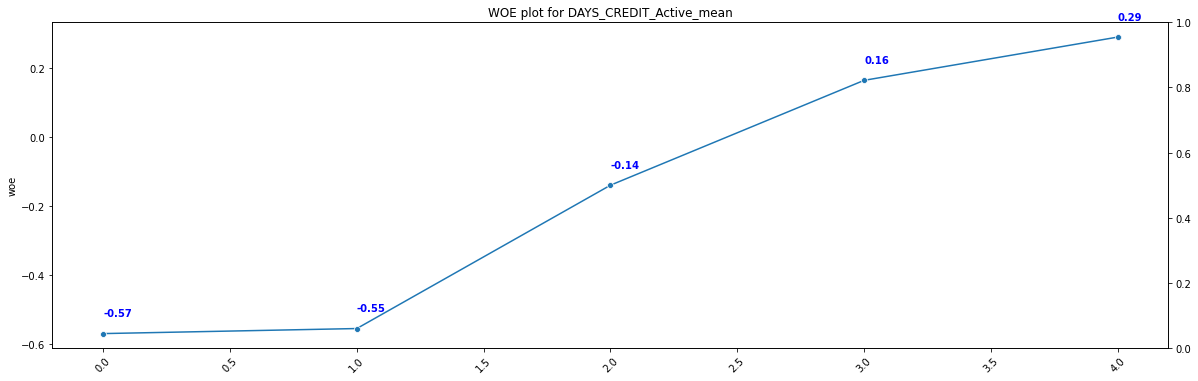

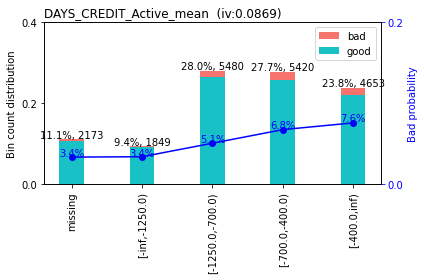

----------------------------------------------------------------------------------------------------


variable         bin  count  count_distr  good  bad   badprob  \
0  CREDIT_ACTIVE_Active     missing   2173     0.111009  2100   73  0.033594   
1  CREDIT_ACTIVE_Active  [-inf,2.0)   4392     0.224368  4197  195  0.044399   
2  CREDIT_ACTIVE_Active   [2.0,4.0)   7986     0.407969  7535  451  0.056474   
3  CREDIT_ACTIVE_Active   [4.0,5.0)   2280     0.116475  2110  170  0.074561   
4  CREDIT_ACTIVE_Active   [5.0,inf)   2744     0.140179  2500  244  0.088921   

        woe    bin_iv  total_iv   breaks  is_special_values  
0 -0.569471  0.028155  0.090522  missing               True  
1 -0.279364  0.015496  0.090522      2.0              False  
2 -0.026085  0.000274  0.090522      4.0              False  
3  0.271117  0.009660  0.090522      5.0              False  
4  0.462884  0.036937  0.090522      inf              False

CREDIT_ACTIVE_Active
Information Value: 0.09052215303613806
Bins: 0       missing
1    [-inf,2.0)
2     [2.0,4.0)
3     [4.0,5.0)
4     [5.0,inf)
Name: bin, dtype: object



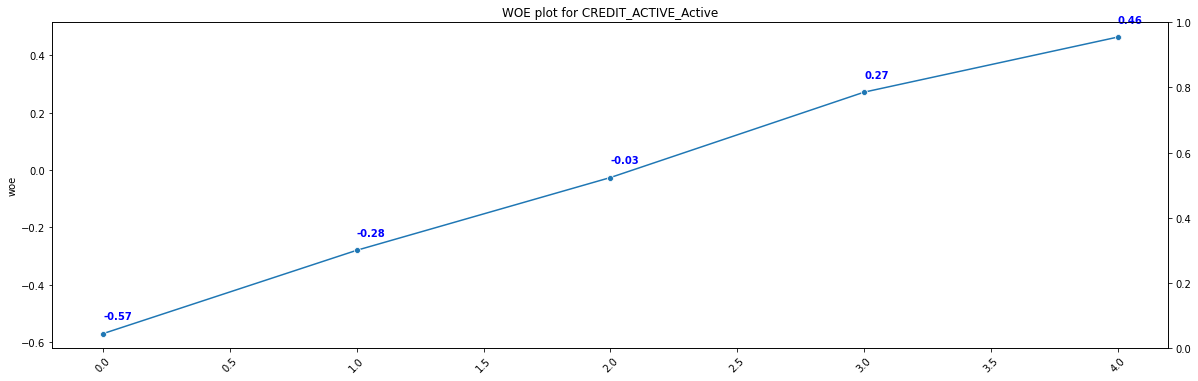

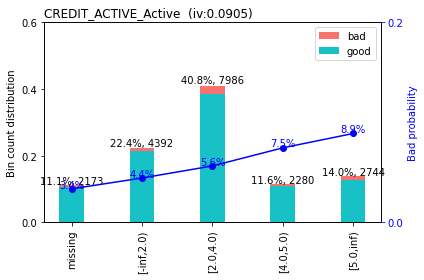

----------------------------------------------------------------------------------------------------


variable            bin  count  count_distr   good  bad  \
0  AMT_CREDIT_SUM_LIMIT_MEAN        missing   1662     0.084904   1558  104   
1  AMT_CREDIT_SUM_LIMIT_MEAN  [-inf,2000.0)  14858     0.759029  14040  818   
2  AMT_CREDIT_SUM_LIMIT_MEAN   [2000.0,inf)   3055     0.156066   2844  211   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.062575  0.082994  0.000607  0.008733  missing               True  
1  0.055055 -0.053042  0.002086  0.008733   2000.0              False  
2  0.069067  0.188653  0.006040  0.008733      inf              False

AMT_CREDIT_SUM_LIMIT_MEAN
Information Value: 0.00873309759971961
Bins: 0          missing
1    [-inf,2000.0)
2     [2000.0,inf)
Name: bin, dtype: object



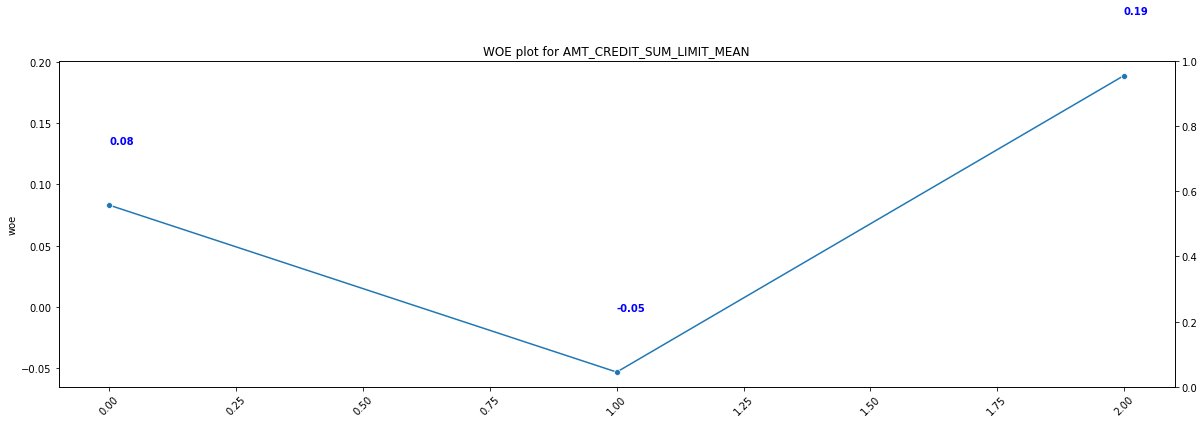

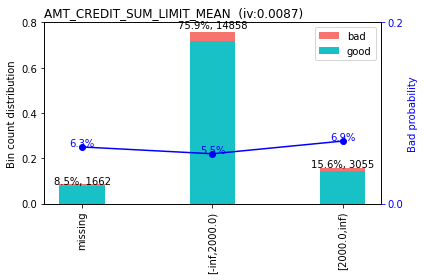

----------------------------------------------------------------------------------------------------


variable         bin  count  count_distr   good  bad  \
0  AMT_REQ_CREDIT_BUREAU_MON  [-inf,1.0)  15389     0.786156  14500  889   
1  AMT_REQ_CREDIT_BUREAU_MON   [1.0,inf)   4186     0.213844   3942  244   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.057769 -0.002045  0.000003  0.000015    1.0              False  
1  0.058290  0.007486  0.000012  0.000015    inf              False

AMT_REQ_CREDIT_BUREAU_MON
Information Value: 1.530974615446815e-05
Bins: 0    [-inf,1.0)
1     [1.0,inf)
Name: bin, dtype: object



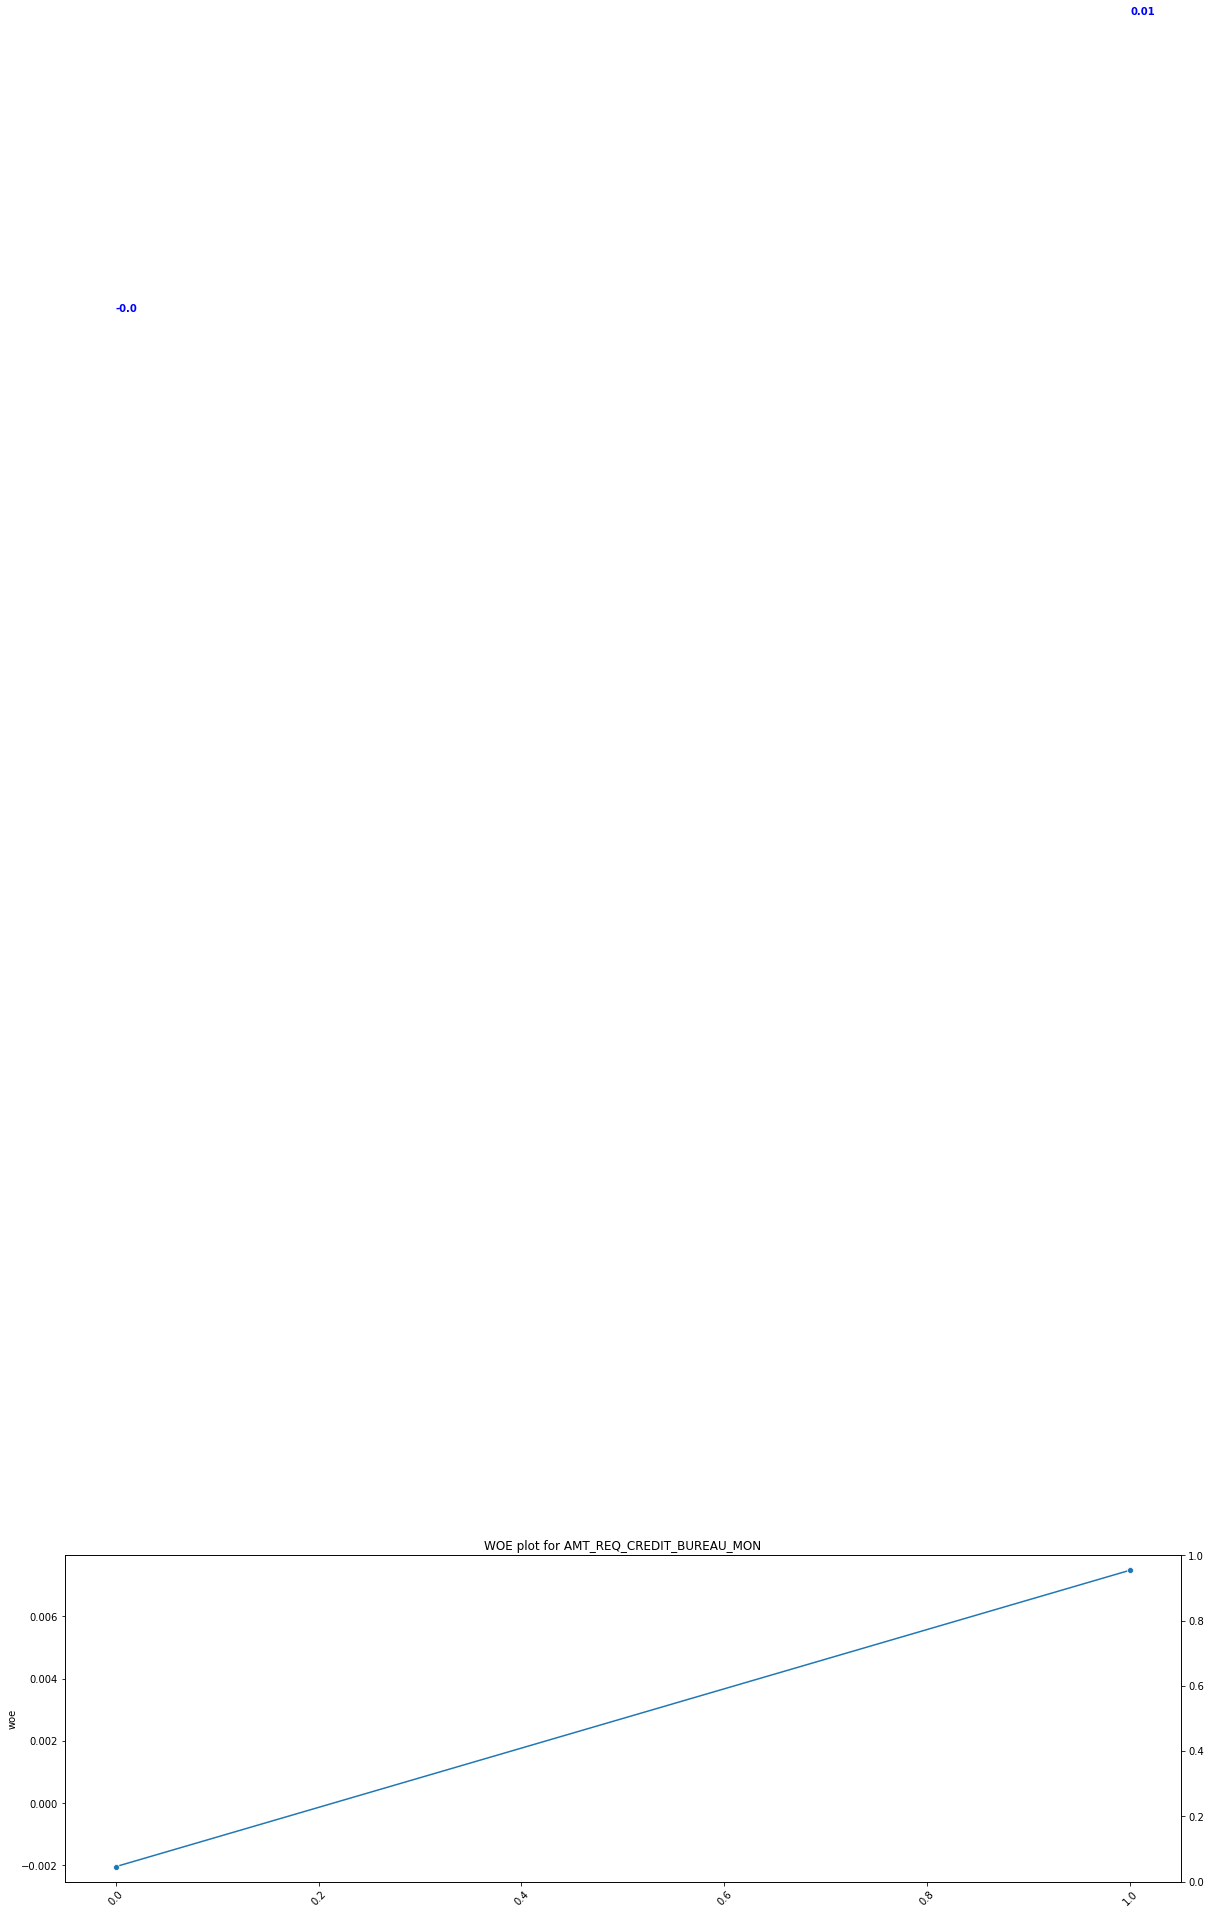

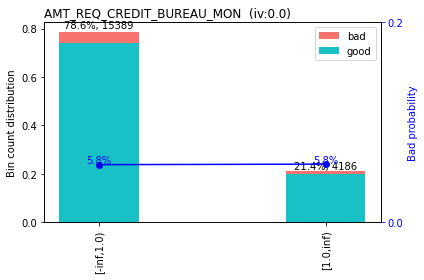

----------------------------------------------------------------------------------------------------


variable                                                bin  \
0  NAME_HOUSING_TYPE               Office apartment%,%House / apartment   
1  NAME_HOUSING_TYPE  Municipal apartment%,%Rented apartment%,%With ...   

   count  count_distr   good   bad   badprob       woe    bin_iv  total_iv  \
0  17960     0.917497  16945  1015  0.056514 -0.025323  0.000582  0.006308   
1   1615     0.082503   1497   118  0.073065  0.249228  0.005726  0.006308   

                                              breaks  is_special_values  
0               Office apartment%,%House / apartment              False  
1  Municipal apartment%,%Rented apartment%,%With ...              False

NAME_HOUSING_TYPE
Information Value: 0.006307760602440138
Bins: 0                 Office apartment%,%House / apartment
1    Municipal apartment%,%Rented apartment%,%With ...
Name: bin, dtype: object



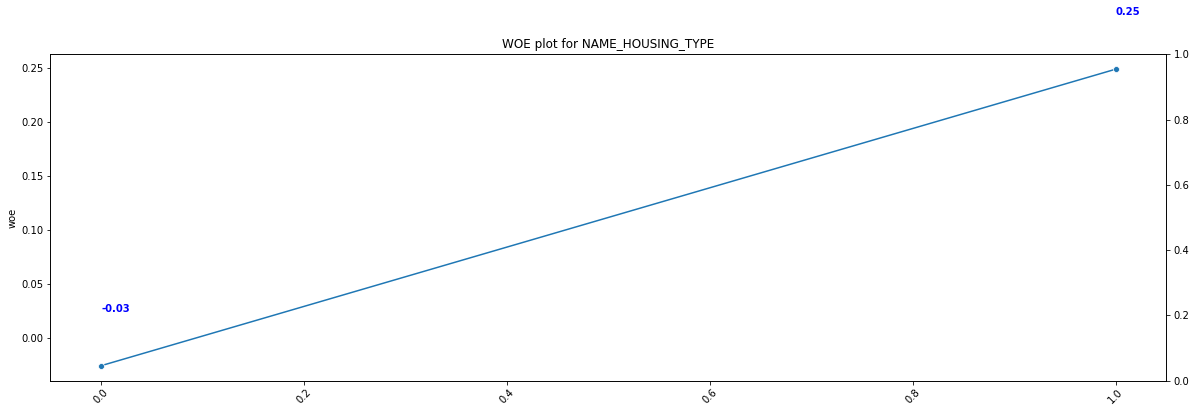

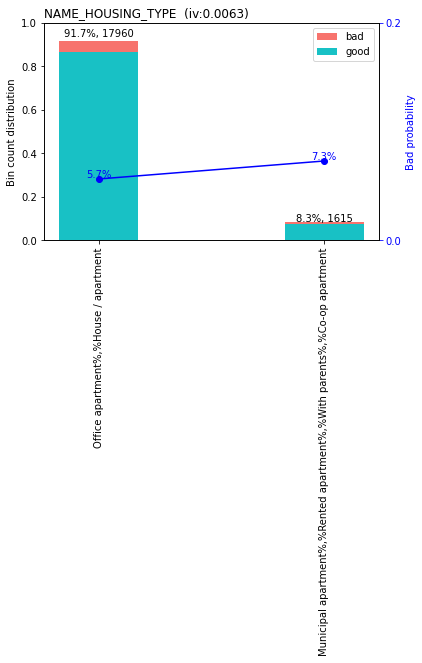

----------------------------------------------------------------------------------------------------


variable                bin  count  count_distr   good  bad   badprob  \
0  TOTAL_ANNUITY            missing   2174     0.111060   2101   73  0.033579   
1  TOTAL_ANNUITY     [-inf,14000.0)   1515     0.077395   1438   77  0.050825   
2  TOTAL_ANNUITY  [14000.0,22000.0)   2248     0.114840   2120  128  0.056940   
3  TOTAL_ANNUITY      [22000.0,inf)  13638     0.696705  12783  855  0.062692   

        woe    bin_iv  total_iv   breaks  is_special_values  
0 -0.569948  0.028209  0.034846  missing               True  
1 -0.137441  0.001376  0.034846  14000.0              False  
2 -0.017379  0.000034  0.034846  22000.0              False  
3  0.084992  0.005226  0.034846      inf              False

TOTAL_ANNUITY
Information Value: 0.0348455632017828
Bins: 0              missing
1       [-inf,14000.0)
2    [14000.0,22000.0)
3        [22000.0,inf)
Name: bin, dtype: object



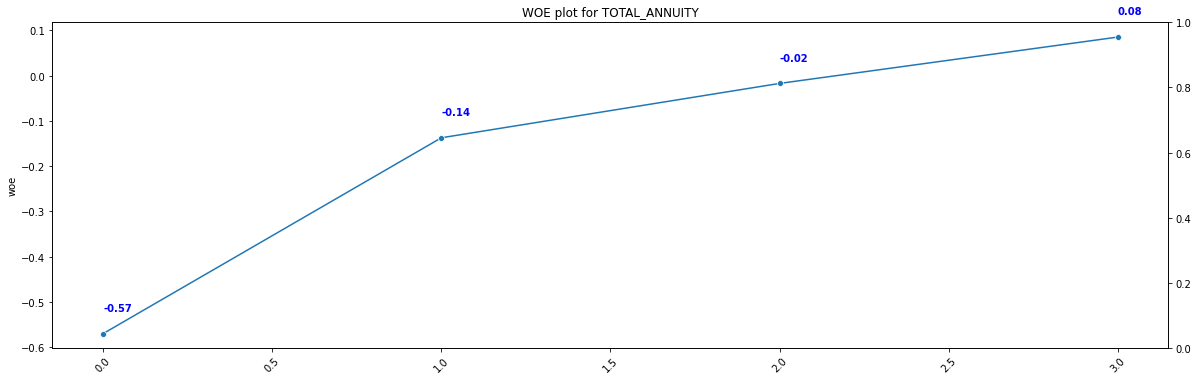

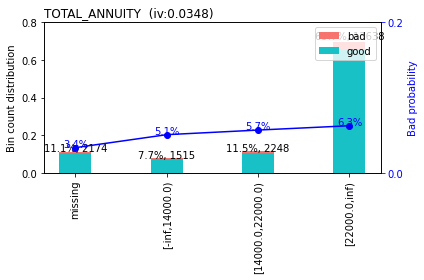

----------------------------------------------------------------------------------------------------


variable                           bin  count  count_distr  \
0  NAME_FAMILY_STATUS                       Married  15000     0.766284   
1  NAME_FAMILY_STATUS  Widow%,%Single / not married   2159     0.110294   
2  NAME_FAMILY_STATUS                     Separated    984     0.050268   
3  NAME_FAMILY_STATUS                Civil marriage   1432     0.073155   

    good  bad   badprob       woe    bin_iv  total_iv  \
0  14160  840  0.056000 -0.035013  0.000925  0.005246   
1   2030  129  0.059750  0.033783  0.000128  0.005246   
2    921   63  0.064024  0.107436  0.000609  0.005246   
3   1331  101  0.070531  0.211196  0.003584  0.005246   

                         breaks  is_special_values  
0                       Married              False  
1  Widow%,%Single / not married              False  
2                     Separated              False  
3                Civil marriage              False

NAME_FAMILY_STATUS
Information Value: 0.00524564033379082
Bins: 0                         Married
1    Widow%,%Single / not married
2                       Separated
3                  Civil marriage
Name: bin, dtype: object



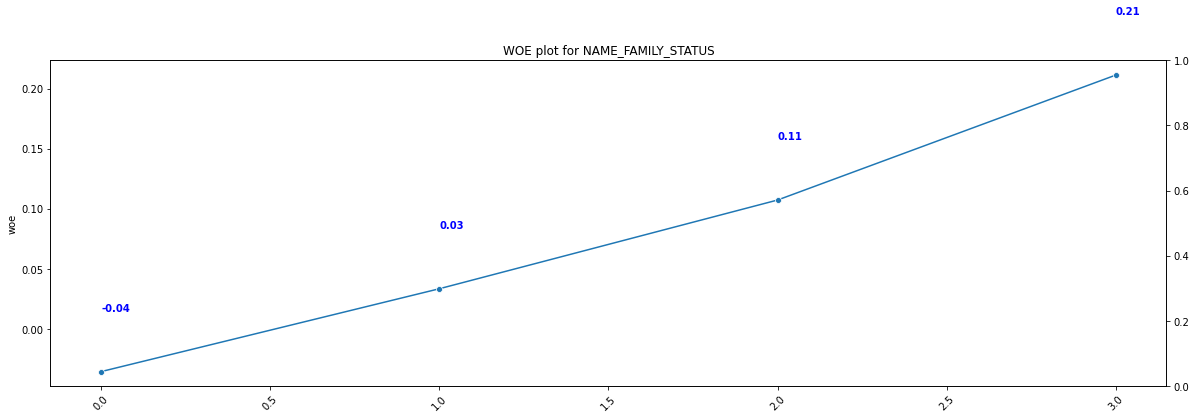

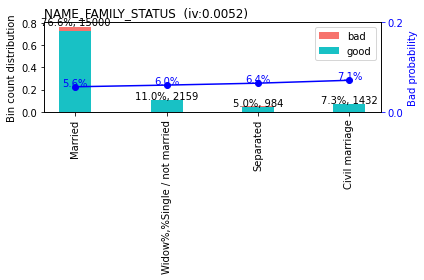

----------------------------------------------------------------------------------------------------


variable                   bin  count  count_distr   good  bad  \
0  DEBT_TO_INCOME_RATIO               missing   2173     0.111009   2100   73   
1  DEBT_TO_INCOME_RATIO       [-inf,850000.0)  11131     0.568633  10364  767   
2  DEBT_TO_INCOME_RATIO  [850000.0,1550000.0)   5139     0.262529   4879  260   
3  DEBT_TO_INCOME_RATIO       [1550000.0,inf)   1132     0.057829   1099   33   

    badprob       woe    bin_iv  total_iv     breaks  is_special_values  
0  0.033594 -0.569471  0.028155   0.07636    missing               True  
1  0.068907  0.186155  0.021405   0.07636   850000.0              False  
2  0.050594 -0.142252  0.004990   0.07636  1550000.0              False  
3  0.029152 -0.715887  0.021810   0.07636        inf              False

DEBT_TO_INCOME_RATIO
Information Value: 0.07636013038257959
Bins: 0                 missing
1         [-inf,850000.0)
2    [850000.0,1550000.0)
3         [1550000.0,inf)
Name: bin, dtype: object



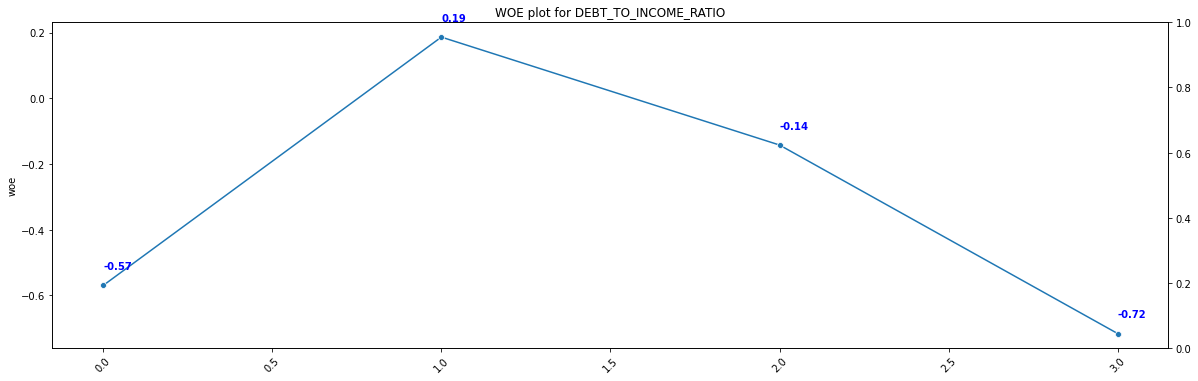

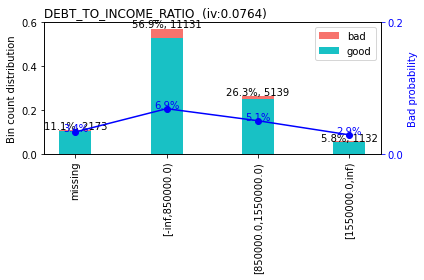

----------------------------------------------------------------------------------------------------


variable         bin  count  count_distr   good  bad  \
0  OBS_30_CNT_SOCIAL_CIRCLE     missing     89     0.004547     88    1   
1  OBS_30_CNT_SOCIAL_CIRCLE  [-inf,2.0)  13575     0.693487  12827  748   
2  OBS_30_CNT_SOCIAL_CIRCLE   [2.0,3.0)   1825     0.093231   1713  112   
3  OBS_30_CNT_SOCIAL_CIRCLE   [3.0,inf)   4086     0.208736   3814  272   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.011236 -1.687575  0.006563  0.013737  missing               True  
1  0.055101 -0.052143  0.001843  0.013737      2.0              False  
2  0.061370  0.062259  0.000371  0.013737      3.0              False  
3  0.066569  0.149130  0.004960  0.013737      inf              False

OBS_30_CNT_SOCIAL_CIRCLE
Information Value: 0.013737330481275402
Bins: 0       missing
1    [-inf,2.0)
2     [2.0,3.0)
3     [3.0,inf)
Name: bin, dtype: object



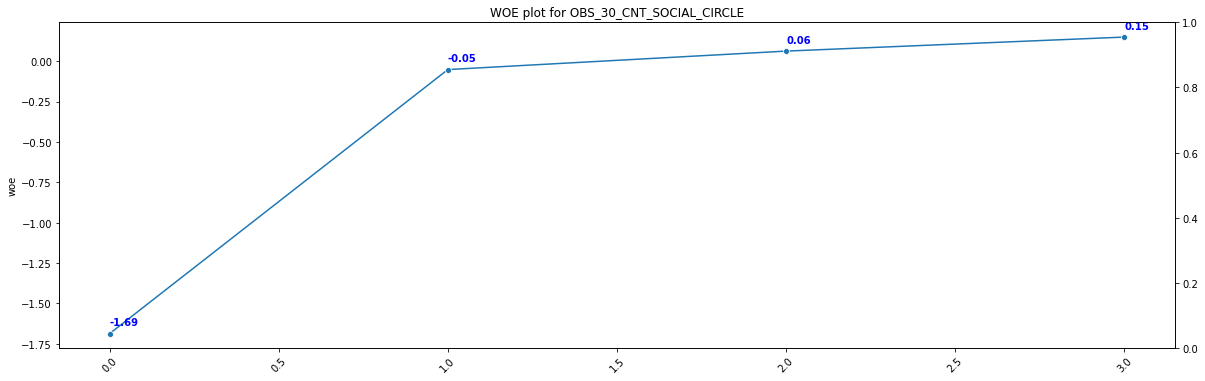

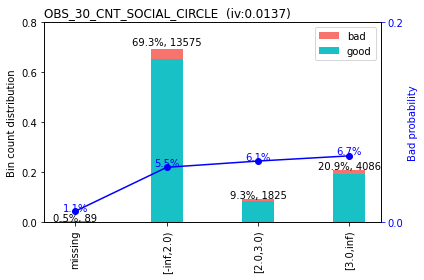

----------------------------------------------------------------------------------------------------


variable         bin  count  count_distr   good  bad  \
0  AMT_REQ_CREDIT_BUREAU_YEAR  [-inf,3.0)  14039     0.717190  13275  764   
1  AMT_REQ_CREDIT_BUREAU_YEAR   [3.0,4.0)   2403     0.122759   2254  149   
2  AMT_REQ_CREDIT_BUREAU_YEAR   [4.0,inf)   3133     0.160051   2913  220   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.054420 -0.065308  0.002972   0.01113    3.0              False  
1  0.062006  0.073246  0.000680   0.01113    4.0              False  
2  0.070220  0.206450  0.007478   0.01113    inf              False

AMT_REQ_CREDIT_BUREAU_YEAR
Information Value: 0.01113005991340294
Bins: 0    [-inf,3.0)
1     [3.0,4.0)
2     [4.0,inf)
Name: bin, dtype: object



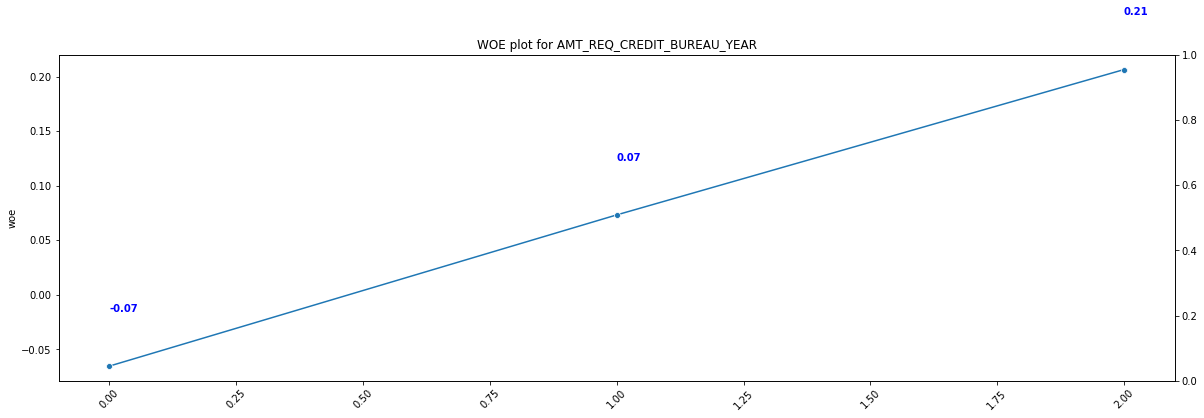

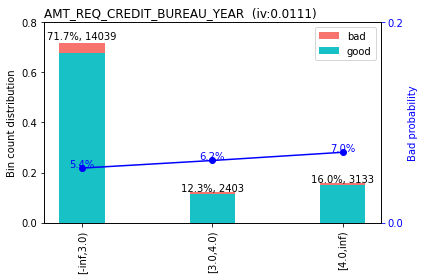

----------------------------------------------------------------------------------------------------


variable           bin  count  count_distr   good  bad   badprob  \
0  LANDAREA_AVG       missing  10723     0.547791  10031  692  0.064534   
1  LANDAREA_AVG  [-inf,0.055)   4745     0.242401   4497  248  0.052266   
2  LANDAREA_AVG  [0.055,0.11)   2463     0.125824   2346  117  0.047503   
3  LANDAREA_AVG    [0.11,inf)   1644     0.083985   1568   76  0.046229   

        woe    bin_iv  total_iv   breaks  is_special_values  
0  0.115912  0.007748   0.01969  missing               True  
1 -0.107975  0.002695   0.01969    0.055              False  
2 -0.208531  0.004993   0.01969     0.11              False  
3 -0.237061  0.004254   0.01969      inf              False

LANDAREA_AVG
Information Value: 0.019690190668096474
Bins: 0         missing
1    [-inf,0.055)
2    [0.055,0.11)
3      [0.11,inf)
Name: bin, dtype: object



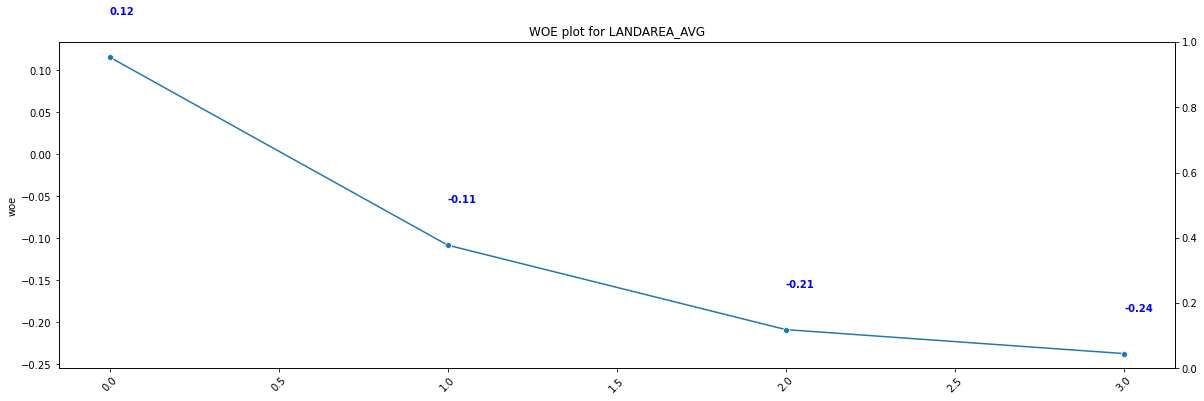

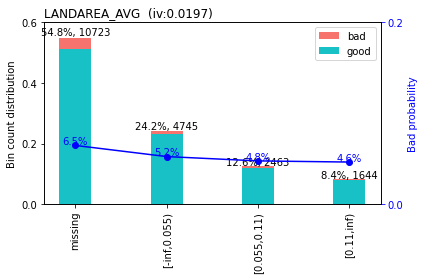

----------------------------------------------------------------------------------------------------


variable         bin  count  count_distr   good  bad  \
0  DEF_30_CNT_SOCIAL_CIRCLE     missing     89     0.004547     88    1   
1  DEF_30_CNT_SOCIAL_CIRCLE  [-inf,1.0)  17460     0.891954  16477  983   
2  DEF_30_CNT_SOCIAL_CIRCLE   [1.0,inf)   2026     0.103499   1877  149   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.011236 -1.687575  0.006563  0.014941  missing               True  
1  0.056300 -0.029350  0.000758  0.014941      1.0              False  
2  0.073544  0.256278  0.007619  0.014941      inf              False

DEF_30_CNT_SOCIAL_CIRCLE
Information Value: 0.014940933138476463
Bins: 0       missing
1    [-inf,1.0)
2     [1.0,inf)
Name: bin, dtype: object



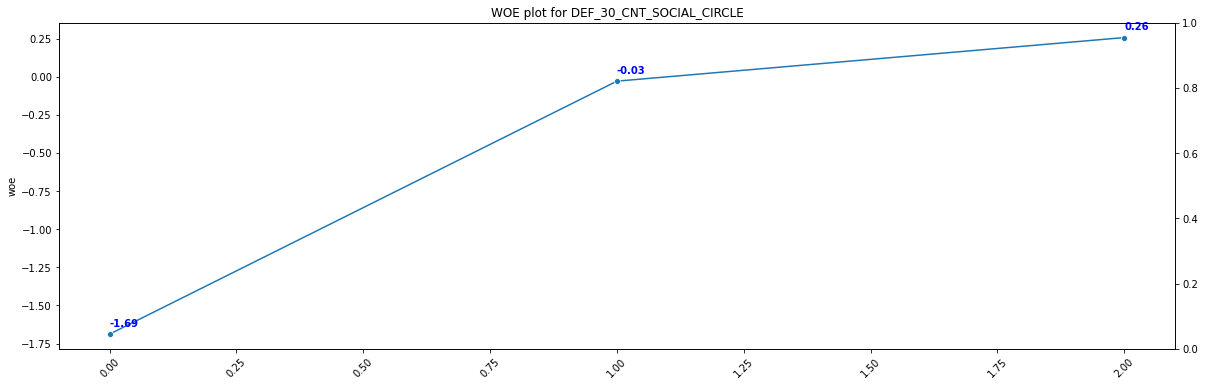

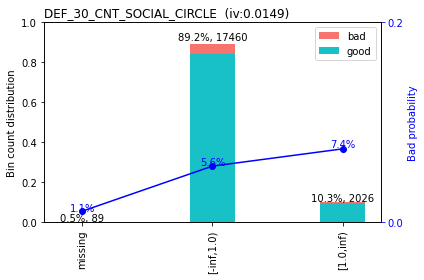

----------------------------------------------------------------------------------------------------


variable bin  count  count_distr   good  bad   badprob       woe  \
0  FLAG_OWN_CAR   Y  15608     0.797344  14742  866  0.055484 -0.044809   
1  FLAG_OWN_CAR   N   3967     0.202656   3700  267  0.067305  0.160922   

     bin_iv  total_iv breaks  is_special_values  
0  0.001570  0.007206      Y              False  
1  0.005637  0.007206      N              False

FLAG_OWN_CAR
Information Value: 0.00720647533477827
Bins: 0    Y
1    N
Name: bin, dtype: object



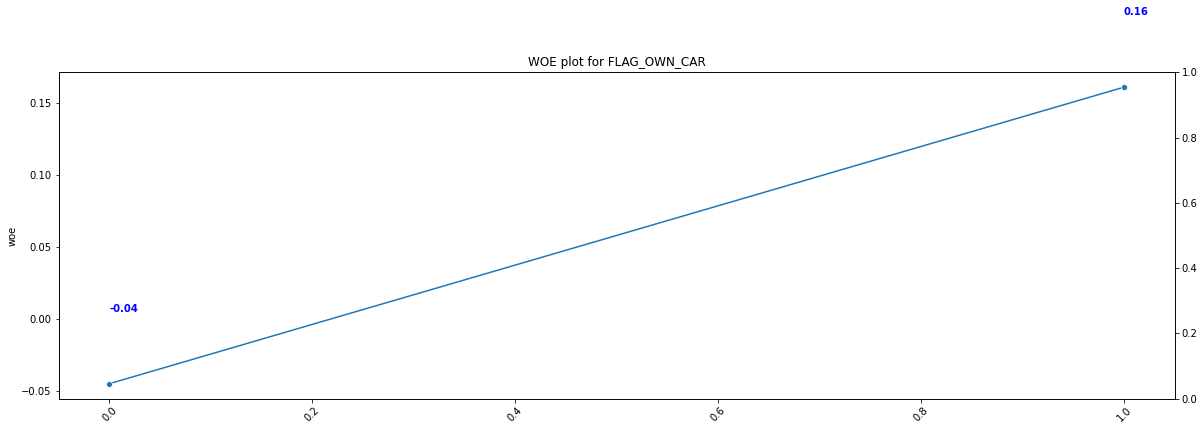

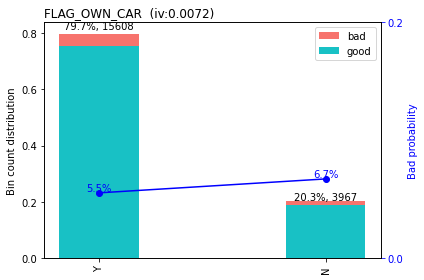

----------------------------------------------------------------------------------------------------


variable bin  count  count_distr   good  bad   badprob       woe  \
0  FLAG_OWN_REALTY   N   6393      0.32659   6059  334  0.052245 -0.108397   
1  FLAG_OWN_REALTY   Y  13182      0.67341  12383  799  0.060613  0.049043   

     bin_iv  total_iv breaks  is_special_values  
0  0.003659  0.005314      N              False  
1  0.001655  0.005314      Y              False

FLAG_OWN_REALTY
Information Value: 0.005313755840856096
Bins: 0    N
1    Y
Name: bin, dtype: object



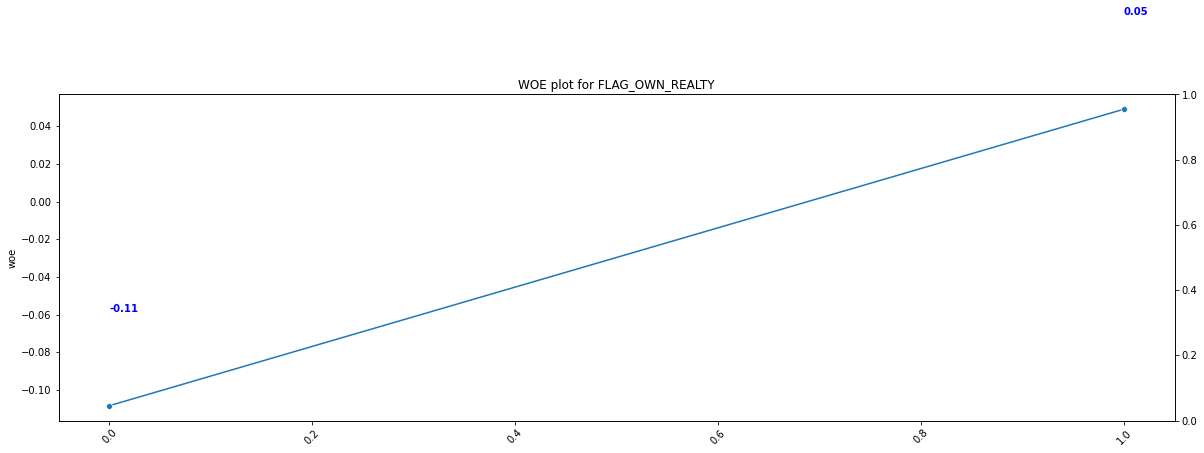

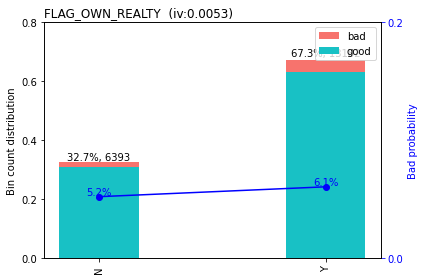

----------------------------------------------------------------------------------------------------


variable                                                bin  count  \
0  OCCUPATION_TYPE                                            missing   4025   
1  OCCUPATION_TYPE  HR staff%,%Waiters/barmen staff%,%Core staff%,...   1867   
2  OCCUPATION_TYPE     IT staff%,%Accountants%,%High skill tech staff   1895   
3  OCCUPATION_TYPE         Medicine staff%,%Security staff%,%Managers   4077   
4  OCCUPATION_TYPE             Laborers%,%Sales staff%,%Cooking staff   4842   
5  OCCUPATION_TYPE  Cleaning staff%,%Private service staff%,%Drive...   2869   

   count_distr  good  bad   badprob       woe    bin_iv  total_iv  \
0     0.205619  3816  209  0.051925 -0.114862  0.002579   0.07134   
1     0.095377  1801   66  0.035351 -0.516681  0.020360   0.07134   
2     0.096807  1813   82  0.043272 -0.306257  0.007942   0.07134   
3     0.208276  3859  218  0.053471 -0.083907  0.001413   0.07134   
4     0.247356  4537  305  0.062990  0.090052  0.002088   0.07134   
5     0.146564  2616  253  0.088184  0.453749  0.036958   0.07134   

                                              breaks  is_special_values  
0                                            missing               True  
1  HR staff%,%Waiters/barmen staff%,%Core staff%,...              False  
2     IT staff%,%Accountants%,%High skill tech staff              False  
3         Medicine staff%,%Security staff%,%Managers              False  
4             Laborers%,%Sales staff%,%Cooking staff              False  
5  Cleaning staff%,%Private service staff%,%Drive...              False

OCCUPATION_TYPE
Information Value: 0.0713402981952865
Bins: 0                                              missing
1    HR staff%,%Waiters/barmen staff%,%Core staff%,...
2       IT staff%,%Accountants%,%High skill tech staff
3           Medicine staff%,%Security staff%,%Managers
4               Laborers%,%Sales staff%,%Cooking staff
5    Cleaning staff%,%Private service staff%,%Drive...
Name: bin, dtype: object



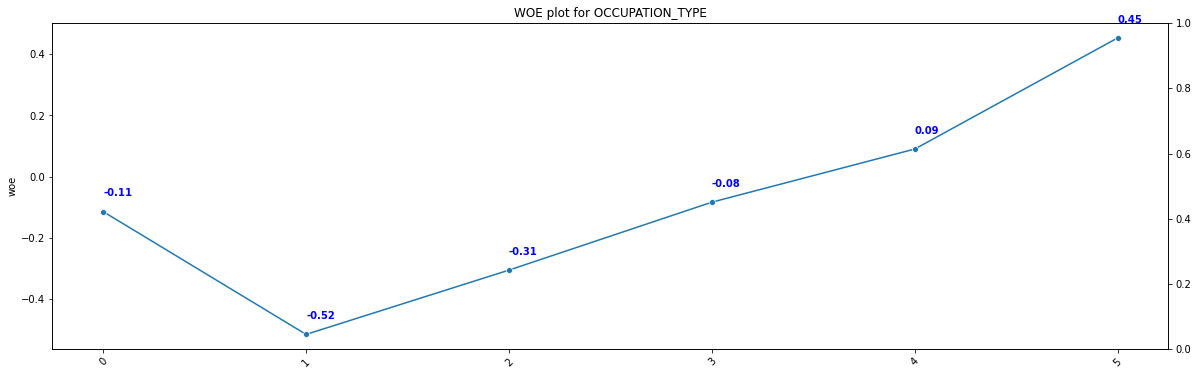

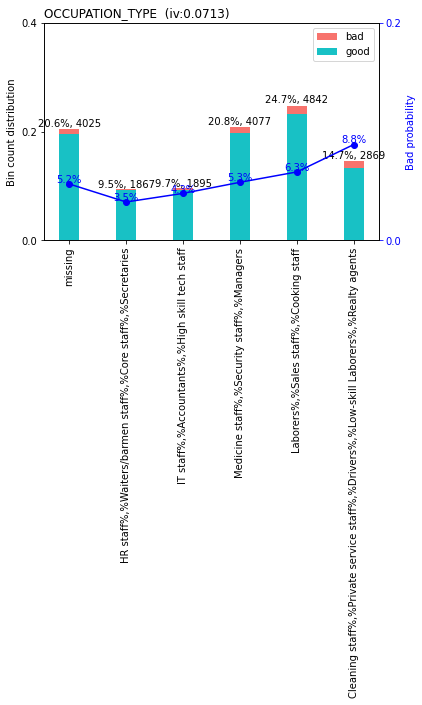

----------------------------------------------------------------------------------------------------


variable         bin  count  count_distr   good  bad  \
0  AMT_REQ_CREDIT_BUREAU_QRT  [-inf,1.0)  16076     0.821252  15120  956   
1  AMT_REQ_CREDIT_BUREAU_QRT   [1.0,inf)   3499     0.178748   3322  177   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.059468  0.028746  0.000687  0.004092    1.0              False  
1  0.050586 -0.142411  0.003405  0.004092    inf              False

AMT_REQ_CREDIT_BUREAU_QRT
Information Value: 0.004092340475547816
Bins: 0    [-inf,1.0)
1     [1.0,inf)
Name: bin, dtype: object



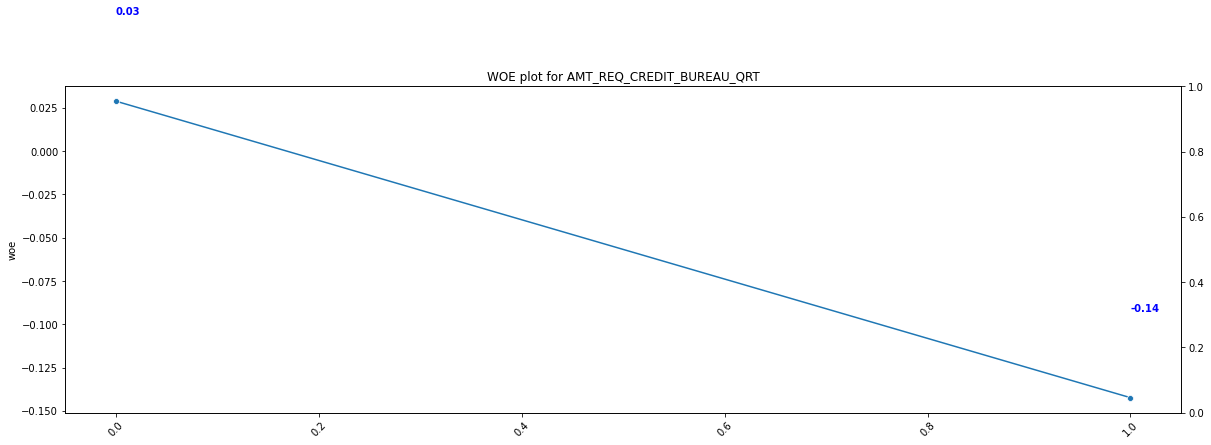

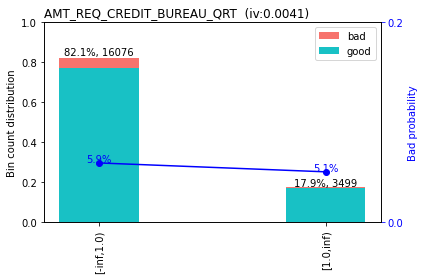

----------------------------------------------------------------------------------------------------


variable                                                bin  \
0  NAME_EDUCATION_TYPE                 Higher education%,%Academic degree   
1  NAME_EDUCATION_TYPE  Incomplete higher%,%Secondary / secondary spec...   

   count  count_distr   good  bad   badprob       woe    bin_iv  total_iv  \
0   7793      0.39811   7455  338  0.043372 -0.303833  0.032181  0.049513   
1  11782      0.60189  10987  795  0.067476  0.163636  0.017332  0.049513   

                                              breaks  is_special_values  
0                 Higher education%,%Academic degree              False  
1  Incomplete higher%,%Secondary / secondary spec...              False

NAME_EDUCATION_TYPE
Information Value: 0.049512984902792725
Bins: 0                   Higher education%,%Academic degree
1    Incomplete higher%,%Secondary / secondary spec...
Name: bin, dtype: object



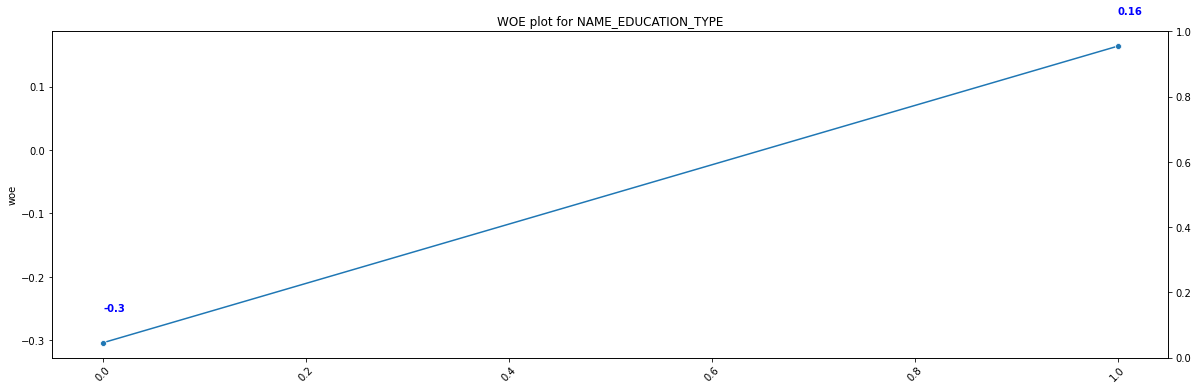

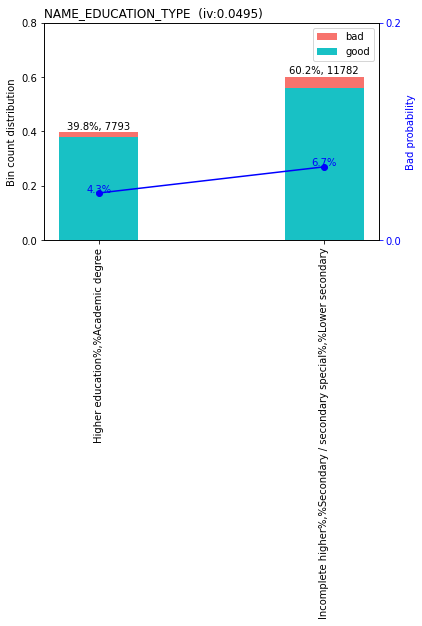

----------------------------------------------------------------------------------------------------


variable                bin  count  count_distr  good  bad   badprob  \
0  DAYS_EMPLOYED     [-inf,-6000.0)   1360     0.069476  1333   27  0.019853   
1  DAYS_EMPLOYED  [-6000.0,-4000.0)   2112     0.107893  2034   78  0.036932   
2  DAYS_EMPLOYED  [-4000.0,-2400.0)   4107     0.209808  3901  206  0.050158   
3  DAYS_EMPLOYED  [-2400.0,-1400.0)   3662     0.187075  3426  236  0.064446   
4  DAYS_EMPLOYED      [-1400.0,inf)   8334     0.425747  7748  586  0.070314   

        woe    bin_iv  total_iv   breaks  is_special_values  
0 -1.109589  0.053760  0.100551  -6000.0              False  
1 -0.471289  0.019534  0.100551  -4000.0              False  
2 -0.151350  0.004497  0.100551  -2400.0              False  
3  0.114445  0.002578  0.100551  -1400.0              False  
4  0.207891  0.020183  0.100551      inf              False

DAYS_EMPLOYED
Information Value: 0.10055086032644654
Bins: 0       [-inf,-6000.0)
1    [-6000.0,-4000.0)
2    [-4000.0,-2400.0)
3    [-2400.0,-1400.0)
4        [-1400.0,inf)
Name: bin, dtype: object



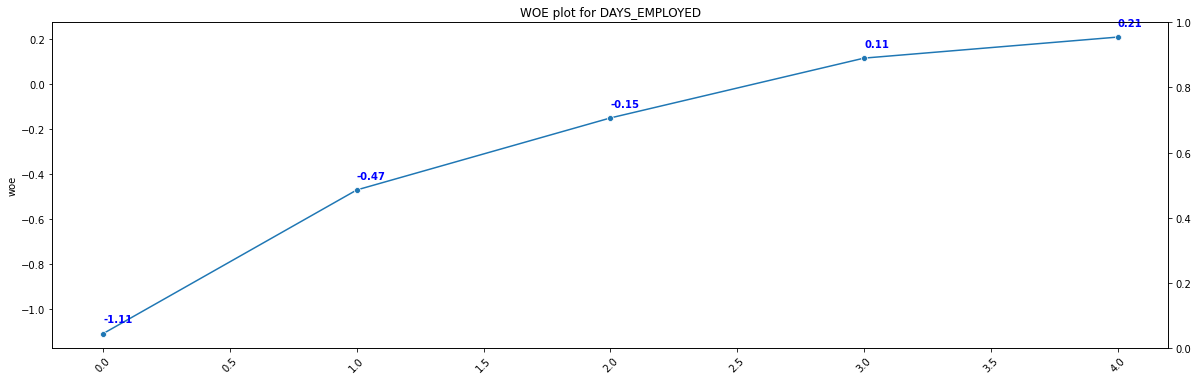

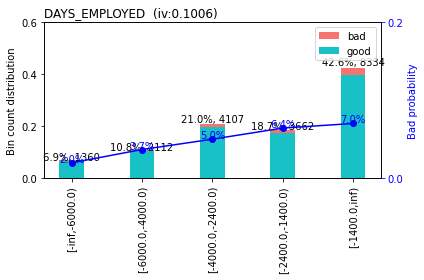

----------------------------------------------------------------------------------------------------


variable         bin  count  count_distr   good  bad   badprob  \
0  CNT_FAM_MEMBERS  [-inf,3.0)  13232     0.675964  12472  760  0.057437   
1  CNT_FAM_MEMBERS   [3.0,5.0)   6040     0.308557   5689  351  0.058113   
2  CNT_FAM_MEMBERS   [5.0,inf)    303     0.015479    281   22  0.072607   

        woe    bin_iv  total_iv breaks  is_special_values  
0 -0.008161  0.000045  0.001064    3.0              False  
1  0.004258  0.000006  0.001064    5.0              False  
2  0.242449  0.001014  0.001064    inf              False

CNT_FAM_MEMBERS
Information Value: 0.0010640308648349173
Bins: 0    [-inf,3.0)
1     [3.0,5.0)
2     [5.0,inf)
Name: bin, dtype: object



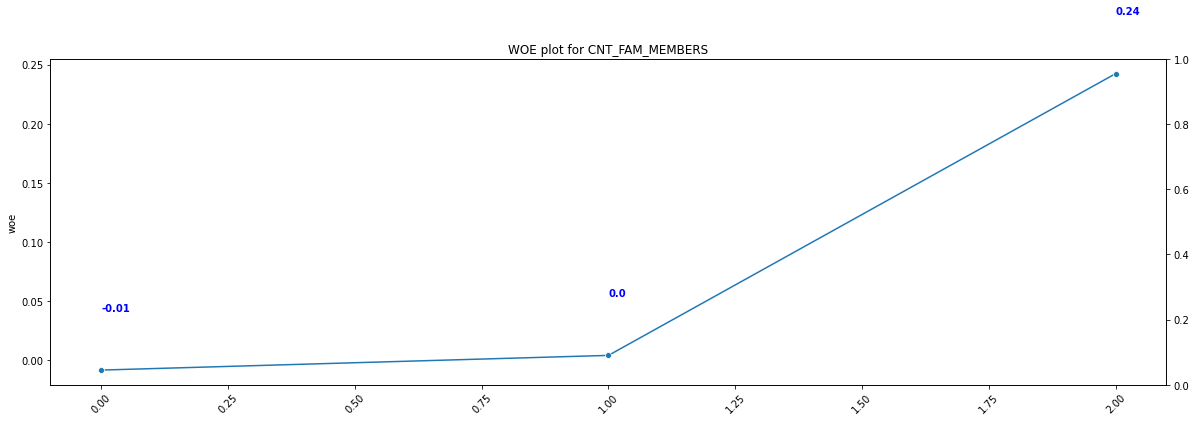

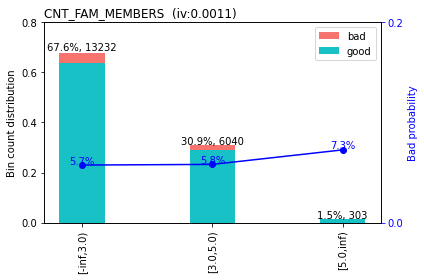

----------------------------------------------------------------------------------------------------


variable               bin  count  count_distr   good  bad  \
0  DAYS_CREDIT_UPDATE_MIN    [-inf,-1100.0)  11832     0.604444  11207  625   
1  DAYS_CREDIT_UPDATE_MIN  [-1100.0,-150.0)   6331     0.323423   5932  399   
2  DAYS_CREDIT_UPDATE_MIN      [-150.0,inf)   1412     0.072133   1303  109   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.052823 -0.096781  0.005425  0.016076  -1100.0              False  
1  0.063023  0.090606  0.002764  0.016076   -150.0              False  
2  0.077195  0.308685  0.007887  0.016076      inf              False

DAYS_CREDIT_UPDATE_MIN
Information Value: 0.016076275026101112
Bins: 0      [-inf,-1100.0)
1    [-1100.0,-150.0)
2        [-150.0,inf)
Name: bin, dtype: object



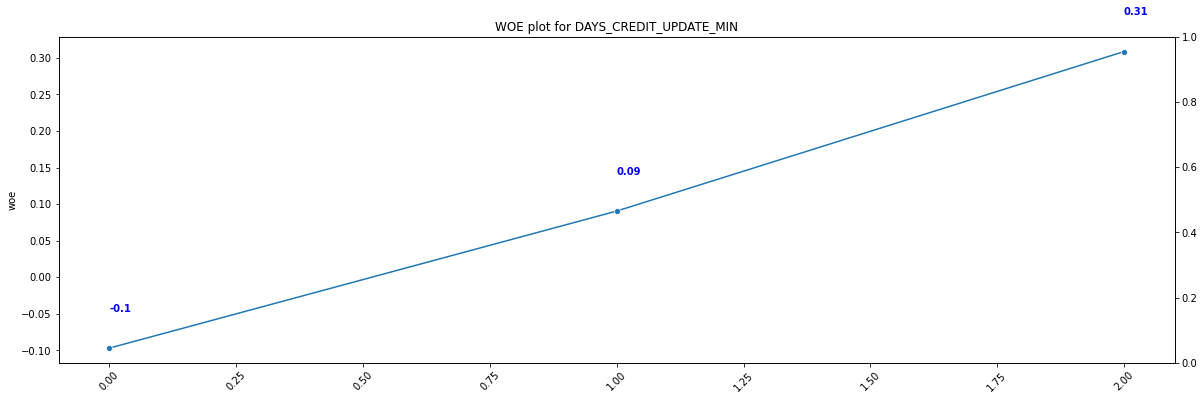

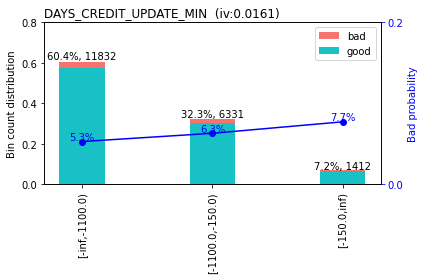

----------------------------------------------------------------------------------------------------


variable                  bin  count  count_distr  good  bad   badprob  \
0  DAYS_BIRTH      [-inf,-21500.0)   1212     0.061916  1166   46  0.037954   
1  DAYS_BIRTH  [-21500.0,-15500.0)   8185     0.418135  7754  431  0.052657   
2  DAYS_BIRTH  [-15500.0,-13500.0)   3940     0.201277  3717  223  0.056599   
3  DAYS_BIRTH       [-13500.0,inf)   6238     0.318672  5805  433  0.069413   

        woe    bin_iv  total_iv    breaks  is_special_values  
0 -0.442931  0.010021  0.027219  -21500.0              False  
1 -0.100094  0.004009  0.027219  -15500.0              False  
2 -0.023739  0.000112  0.027219  -13500.0              False  
3  0.194025  0.013077  0.027219       inf              False

DAYS_BIRTH
Information Value: 0.027219470377608725
Bins: 0        [-inf,-21500.0)
1    [-21500.0,-15500.0)
2    [-15500.0,-13500.0)
3         [-13500.0,inf)
Name: bin, dtype: category
Categories (4, object): ['[-inf,-21500.0)' < '[-21500.0,-15500.0)' < '[-15500.0,-13500.0)' < '[-13500.0,inf)']



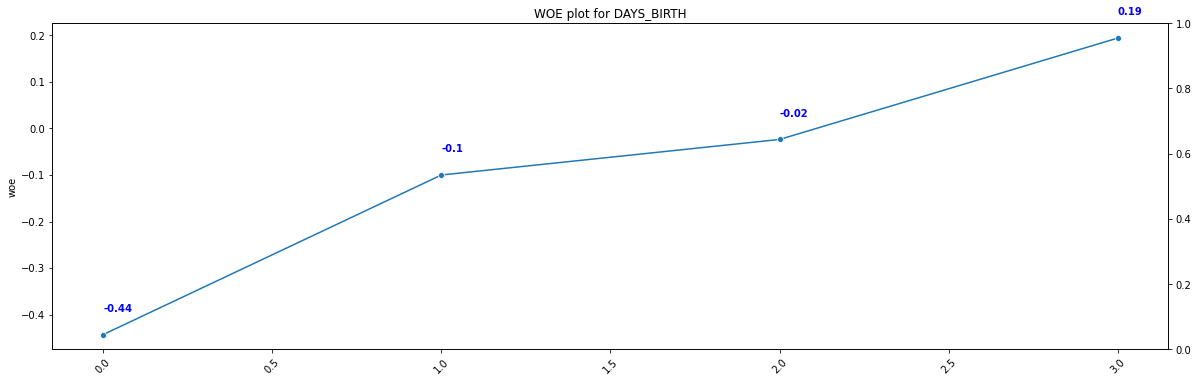

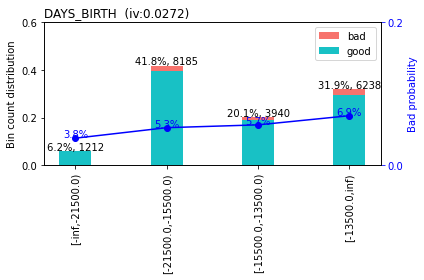

----------------------------------------------------------------------------------------------------


variable         bin  count  count_distr  good  bad   badprob       woe  \
0  OWN_CAR_AGE     missing   3967     0.202656  3700  267  0.067305  0.160922   
1  OWN_CAR_AGE  [-inf,6.0)   9226     0.471315  8800  426  0.046174 -0.238306   
2  OWN_CAR_AGE   [6.0,8.0)   2565     0.131034  2427  138  0.053801 -0.077396   
3  OWN_CAR_AGE   [8.0,inf)   3817     0.194994  3515  302  0.079120  0.335394   

     bin_iv  total_iv   breaks  is_special_values  
0  0.005637  0.055981  missing               True  
1  0.024111  0.055981      6.0              False  
2  0.000759  0.055981      8.0              False  
3  0.025474  0.055981      inf              False

OWN_CAR_AGE
Information Value: 0.05598059281052632
Bins: 0       missing
1    [-inf,6.0)
2     [6.0,8.0)
3     [8.0,inf)
Name: bin, dtype: object



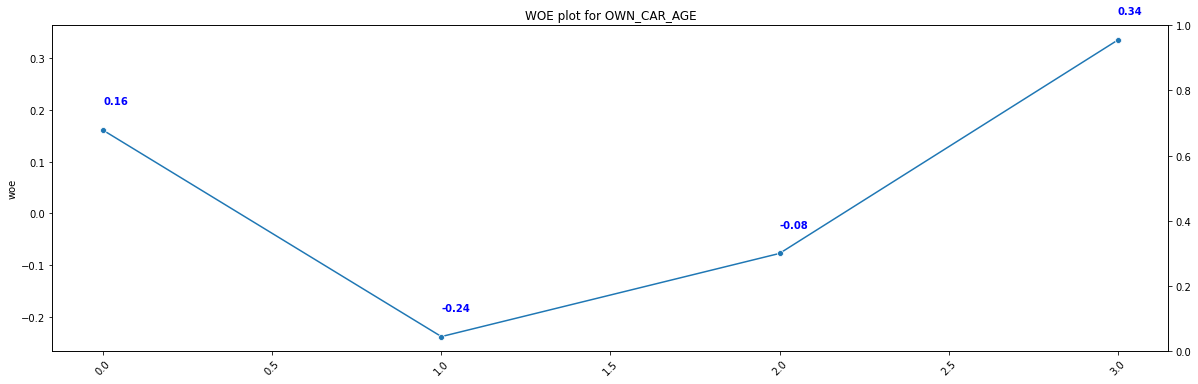

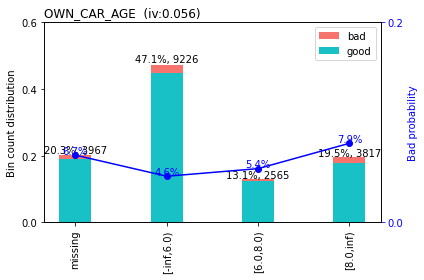

----------------------------------------------------------------------------------------------------


In [7]:
# create IV calc and WOE plotting function
def woe_iv_plot(data, variable_name):
    IV = data['total_iv'][0]
    BINS = data['bin']
    print('Information Value:', IV)
    print(f'Bins: {BINS}\n')
    fig, ax1 = plt.subplots(figsize=(20,6))
    sns.lineplot(data = data['woe'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)
    
    # add WOE values to the plot. i is x axis, v is y axis
    for i, v in enumerate(data['woe']):
        plt.text(i, v + 0.05, str(round(v, 2)), color='blue', fontweight='bold')
    
    # Create the scatter plot to plot the Missing WOE data point
    last_point = len(data['woe']) - 1
    scatter_plot = sns.scatterplot(x=[last_point], y=[data['woe'][last_point]], color='b', s=30, ax=ax1)
    ax2 = ax1.twinx()
    
    plt.title("WOE plot for " + variable_name)
    plt.show()

dataframe = data_df2.copy()
TARGET = 'TARGET'

# # bin adjustments for DAYS_CREDIT_Active_mean - adjust the breaks as needed
# breaks_adj = {'DAYS_CREDIT_Active_mean' : [-1250, -700, -400]}
# bins = sc.woebin(dataframe[['DAYS_CREDIT_Active_mean', TARGET]], y=TARGET, breaks_list=breaks_adj)

# # make it easy to read the bins
# for variables , bindetails in bins.items():
#     if variables == 'DAYS_CREDIT_Active_mean':
#         print(variables , " : ")
#         display(bindetails)
#         print("--"*50)

# sc.woebin_plot(bins['DAYS_CREDIT_Active_mean'])

breaks_adj = {
    'DAYS_CREDIT_Active_mean' : [-1250, -700, -400],
    'DAYS_EMPLOYED' : [-6000, -4000, -2400, -1400],
    'CREDIT_ACTIVE_Active' : [2, 4, 5],
    'LANDAREA_AVG' : [0.055, 0.11],
    'CREDIT_OVERDUE_RATIO' : [0.0006000000000000001, 0.0032],
    'DAYS_CREDIT_UPDATE_MIN' : [-1100.0, -150], 
    'AMT_REQ_CREDIT_BUREAU_QRT' : [1],
    'AMT_CREDIT_SUM_LIMIT_MEAN' : [2000],
    'AMT_REQ_CREDIT_BUREAU_YEAR' : [3, 4],
    'DEBT_TO_INCOME_RATIO' : [850000, 1550000],
    'CNT_FAM_MEMBERS' : [3, 5],
    'AMT_REQ_CREDIT_BUREAU_MON' : [1],
    'TOTAL_ANNUITY' : [14000, 22000],    
}
bins = sc.woebin(dataframe, y=TARGET, breaks_list=breaks_adj)
# make it easy to read the bins
for variables , bindetails in bins.items():
    display(bindetails)
    print(variables)
    
    # Plot WOE and IV
    woe_iv_plot(bindetails, variables)
    
    # plot the sc.woebin bins
    plots = sc.woebin_plot(bindetails) # this plot prob of target event. NOT IV

    # Loop through each figure and rotate the x-axis labels
    for fig in plots.values():
        for ax in fig.get_axes():
            for label in ax.get_xticklabels():
                label.set_rotation(90)  # Rotate labels by 45 degrees

        # Adjust the layout to prevent labels from overlapping
        fig.tight_layout()
        plt.show()

    print("--"*50)

In [8]:
bins['NAME_HOUSING_TYPE'].head()

variable                                                bin  \
0  NAME_HOUSING_TYPE               Office apartment%,%House / apartment   
1  NAME_HOUSING_TYPE  Municipal apartment%,%Rented apartment%,%With ...   

   count  count_distr   good   bad   badprob       woe    bin_iv  total_iv  \
0  17960     0.917497  16945  1015  0.056514 -0.025323  0.000582  0.006308   
1   1615     0.082503   1497   118  0.073065  0.249228  0.005726  0.006308   

                                              breaks  is_special_values  
0               Office apartment%,%House / apartment              False  
1  Municipal apartment%,%Rented apartment%,%With ...              False

# Logistic Regression

In [9]:
columns_to_drop = ['OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'CNT_FAM_MEMBERS', 'AMT_CREDIT_SUM_LIMIT_MEAN','DEF_30_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_YEAR', 'FLAG_OWN_REALTY', 'AMT_REQ_CREDIT_BUREAU_MON', 'NAME_HOUSING_TYPE', 'NAME_FAMILY_STATUS', ]

## Fine tuning

In [ ]:
input_list_1 = ["TARGET", "ORGANIZATION_TYPE", "DAYS_CREDIT_Active_mean", "DAYS_EMPLOYED",
                    "OWN_CAR_AGE", "OCCUPATION_TYPE", "NAME_EDUCATION_TYPE", "LANDAREA_AVG",
                    "CREDIT_OVERDUE_RATIO", "DAYS_BIRTH", "FLAG_OWN_CAR",
                    "DEBT_TO_INCOME_RATIO", "TOTAL_ANNUITY"]

input_list_2 = ["TARGET", "ORGANIZATION_TYPE", "DAYS_CREDIT_Active_mean", "DAYS_EMPLOYED",
                    "CREDIT_ACTIVE_Active", "OWN_CAR_AGE", "OCCUPATION_TYPE", "NAME_EDUCATION_TYPE", "LANDAREA_AVG",
                    "CREDIT_OVERDUE_RATIO", "DAYS_BIRTH", "DAYS_CREDIT_UPDATE_MIN", "FLAG_OWN_CAR",
                    "DEBT_TO_INCOME_RATIO", "TOTAL_ANNUITY"]

input_list_3 = ["TARGET", "ORGANIZATION_TYPE", "DAYS_CREDIT_Active_mean", "DAYS_EMPLOYED",
                    "CREDIT_ACTIVE_Active", "OWN_CAR_AGE", "OCCUPATION_TYPE", "NAME_EDUCATION_TYPE", "LANDAREA_AVG",
                    "CREDIT_OVERDUE_RATIO", "DAYS_BIRTH", "DAYS_CREDIT_UPDATE_MIN", "FLAG_OWN_CAR",
                    "DEBT_TO_INCOME_RATIO", "TOTAL_ANNUITY", "AMT_CREDIT_SUM_LIMIT_MEAN"]

input_list_4 = ["TARGET", "ORGANIZATION_TYPE", "DAYS_CREDIT_Active_mean", "DAYS_EMPLOYED",
                    "CREDIT_ACTIVE_Active", "OWN_CAR_AGE", "OCCUPATION_TYPE", "NAME_EDUCATION_TYPE", "LANDAREA_AVG",
                    "CREDIT_OVERDUE_RATIO", "DAYS_BIRTH", "DAYS_CREDIT_UPDATE_MIN", "FLAG_OWN_CAR",
                    "DEBT_TO_INCOME_RATIO", "TOTAL_ANNUITY", "CNT_FAM_MEMBERS"]

input_list_5 = ['OBS_30_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_QRT', 'DAYS_CREDIT_UPDATE_MIN','DEF_30_CNT_SOCIAL_CIRCLE',
                'AMT_REQ_CREDIT_BUREAU_YEAR','AMT_CREDIT_SUM_LIMIT_MEAN', 'AMT_REQ_CREDIT_BUREAU_MON','NAME_FAMILY_STATUS',
                'FLAG_OWN_REALTY','CNT_FAM_MEMBERS']

input_list_6 = ['OBS_30_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_QRT', 'DAYS_CREDIT_UPDATE_MIN','DEF_30_CNT_SOCIAL_CIRCLE',
                'AMT_REQ_CREDIT_BUREAU_YEAR','AMT_CREDIT_SUM_LIMIT_MEAN', 'AMT_REQ_CREDIT_BUREAU_MON','NAME_FAMILY_STATUS',
                'CNT_FAM_MEMBERS','FLAG_OWN_REALTY','OWN_CAR_AGE']

input_list_7 = ['OBS_30_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_QRT', 'DAYS_CREDIT_UPDATE_MIN','DEF_30_CNT_SOCIAL_CIRCLE',
                'AMT_REQ_CREDIT_BUREAU_YEAR','AMT_CREDIT_SUM_LIMIT_MEAN', 'AMT_REQ_CREDIT_BUREAU_MON','NAME_FAMILY_STATUS',
                'CNT_FAM_MEMBERS','FLAG_OWN_REALTY','OWN_CAR_AGE']
# Select 8-15 of the 24 here (excluding "TARGET") to be removed

## Model Training

In [10]:
input_data = dataframe.copy()

input_data.drop(columns=columns_to_drop, inplace=True)

# input_data = dataframe[input_list_7]

# split data into 70% train and 30% test
train, test = sc.split_df(input_data, TARGET, ratio=0.7).values()


# Calculate the percentage of 'TARGET' being 1 in both train and test sets
percentage_train = train[TARGET].mean() * 100
percentage_test = test[TARGET].mean() * 100

print(f"Percentage of TARGET 1 in train data: {percentage_train:.2f}%")
print(f"Percentage of TARGET 1 in test data: {percentage_test:.2f}%")


Percentage of TARGET 1 in train data: 5.79%
Percentage of TARGET 1 in test data: 5.79%


In [11]:
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)
train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


TARGET  DEBT_TO_INCOME_RATIO_woe  ORGANIZATION_TYPE_woe  \
0           0                  0.186155               0.337348   
3           0                  0.186155               0.098328   
4           0                  0.186155               0.098328   
6           0                  0.186155               0.098328   
7           0                 -0.569471              -1.248662   
...       ...                       ...                    ...   
19565       0                  0.186155               0.098328   
19568       0                 -0.142252              -0.373439   
19569       0                  0.186155              -0.373439   
19571       0                  0.186155              -0.373439   
19573       0                 -0.715887               0.337348   

       LANDAREA_AVG_woe  CREDIT_OVERDUE_RATIO_woe  \
0              0.115912                 -0.133019   
3             -0.237061                  0.338644   
4             -0.208531                 -0.133019   
6             -0.107975                 -0.133019   
7              0.115912                 -0.133019   
...                 ...                       ...   
19565         -0.208531                 -0.133019   
19568          0.115912                  0.338644   
19569          0.115912                 -0.133019   
19571          0.115912                 -0.133019   
19573          0.115912                  0.338644   

       DAYS_CREDIT_Active_mean_woe  FLAG_OWN_CAR_woe  \
0                         0.289859         -0.044809   
3                         0.164460         -0.044809   
4                         0.164460          0.160922   
6                         0.164460         -0.044809   
7                        -0.569471         -0.044809   
...                            ...               ...   
19565                    -0.139416          0.160922   
19568                    -0.139416          0.160922   
19569                     0.164460          0.160922   
19571                    -0.139416         -0.044809   
19573                     0.289859         -0.044809   

       CREDIT_ACTIVE_Active_woe  OCCUPATION_TYPE_woe  NAME_EDUCATION_TYPE_woe  \
0                     -0.026085             0.453749                 0.163636   
3                     -0.279364            -0.083907                -0.303833   
4                      0.462884            -0.083907                -0.303833   
6                     -0.279364             0.090052                 0.163636   
7                     -0.569471            -0.083907                -0.303833   
...                         ...                  ...                      ...   
19565                  0.462884             0.090052                 0.163636   
19568                  0.271117            -0.114862                -0.303833   
19569                  0.271117             0.453749                 0.163636   
19571                 -0.026085            -0.083907                 0.163636   
19573                  0.271117             0.090052                 0.163636   

       DAYS_EMPLOYED_woe  TOTAL_ANNUITY_woe  DAYS_CREDIT_UPDATE_MIN_woe  \
0               0.114445           0.084992                   -0.096781   
3              -1.109589           0.084992                    0.090606   
4              -0.471289           0.084992                   -0.096781   
6               0.207891           0.084992                    0.090606   
7               0.207891          -0.569948                    0.090606   
...                  ...                ...                         ...   
19565          -0.151350           0.084992                   -0.096781   
19568          -0.471289           0.084992                   -0.096781   
19569           0.207891           0.084992                    0.090606   
19571           0.114445           0.084992                   -0.096781   
19573           0.114445           0.084992                   -0.096781   

       DAYS_BIRTH_woe  OWN_CAR

In [12]:
columns = list(train_woe.columns)

In [13]:
len(columns)

15

In [14]:
len(columns_to_drop)

10

In [15]:
#create the X, y parts of data for train and test
y_train = train_woe.loc[:,'TARGET']
X_train = train_woe.loc[:,train_woe.columns != 'TARGET']
y_test = test_woe.loc[:,'TARGET']
X_test = test_woe.loc[:,train_woe.columns != 'TARGET']

#create a logistic regression model object
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.intercept_)

[[ 0.22762673  0.90870354  0.56478449  0.96682247  0.98539503  0.37664914
   1.08697665  0.32504663  0.71108443  0.89479191 -0.7895053   1.13553018
   0.40223117  0.89858661]]
[-0.02267445]


Testing accuracy is 0.6225
              precision    recall  f1-score   support

           0       0.96      0.62      0.76      5533
           1       0.09      0.59      0.15       340

    accuracy                           0.62      5873
   macro avg       0.52      0.61      0.45      5873
weighted avg       0.91      0.62      0.72      5873



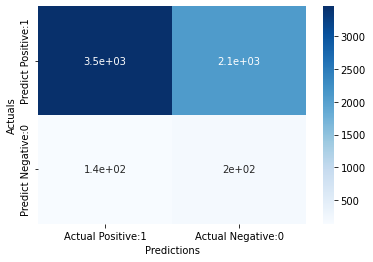

Percentage of TARGET predicted in the test data is 38.77%
ROC AUC Score: 0.6064256174184837


In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

# check the accuracy
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Testing accuracy is %s' % np.round(accuracy,4))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, cmap='Blues')
plt.ylabel('Actuals')
plt.xlabel('Predictions')
plt.show()

print("Percentage of TARGET predicted in the test data is", "{:.2%}".format(y_pred.sum()/y_test.shape[0]))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [18]:
card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/20, pdo = 20,
      basepoints_eq0 = True)

pprint.pprint(card)

{'CREDIT_ACTIVE_Active':                 variable         bin  points
13  CREDIT_ACTIVE_Active     missing    55.0
14  CREDIT_ACTIVE_Active  [-inf,2.0)    45.0
15  CREDIT_ACTIVE_Active   [2.0,4.0)    38.0
16  CREDIT_ACTIVE_Active   [4.0,5.0)    28.0
17  CREDIT_ACTIVE_Active   [5.0,inf)    22.0,
 'CREDIT_OVERDUE_RATIO':                variable                             bin  points
5  CREDIT_OVERDUE_RATIO    [-inf,0.0006000000000000001)    40.0
6  CREDIT_OVERDUE_RATIO  [0.0006000000000000001,0.0032)    34.0
7  CREDIT_OVERDUE_RATIO                    [0.0032,inf)    27.0,
 'DAYS_BIRTH':       variable                  bin  points
76  DAYS_BIRTH      [-inf,-21500.0)    42.0
77  DAYS_BIRTH  [-21500.0,-15500.0)    38.0
78  DAYS_BIRTH  [-15500.0,-13500.0)    37.0
79  DAYS_BIRTH       [-13500.0,inf)    34.0,
 'DAYS_CREDIT_Active_mean':                    variable               bin  points
8   DAYS_CREDIT_Active_mean           missing    53.0
9   DAYS_CREDIT_Active_mean    [-inf,-1250.0)    5